In [1]:
import sys
sys.path.append('/SEE-MTDA/see')
from sc.mesher.mesher import Mesher
import numpy as np
import os
import glob
from pathlib import Path
from sc.datasets.shared_utils import *
import open3d as o3d
from easydict import EasyDict
import yaml
from PIL import Image

def cfg_from_yaml_file(cfg_file):
    cfg = EasyDict()
    print("\n----- Cfgs -----")
    with open(cfg_file, 'r') as f:
        yaml_config = yaml.safe_load(f)
        print(yaml.dump(yaml_config))

    cfg.update(EasyDict(yaml_config))

    return cfg

cfg_file = '/SEE-MTDA/see/sc/cfgs/WAY-DM-ORH005.yaml'
cfg = cfg_from_yaml_file(cfg_file)
mesher = Mesher(cfg=cfg, cfg_path=cfg_file)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

----- Cfgs -----
DATASET:
  CAMERA_CHANNELS:
  - FRONT
  CLASSES:
  - Vehicle
  DET2D_MASK: true
  DET2D_MODEL: htc
  NAME: waymo
  POINT_CLOUD_RANGE:
  - -70
  - -70
  - -2
  - 70
  - 70
  - 4
  UPDATE_GT_DATABASE: false
DATA_PATH: /SEE-MTDA/data/waymo/custom_1000
MESHER:
  CLUSTERING:
    EPS_SCALING: 5
    NAME: db_scan
  MESH_ALGORITHM:
    LOWER_RADIUS: 0.01
    NAME: ball_pivoting
    UPPER_RADIUS: 1.155
  MIN_LIDAR_PTS_TO_MESH: 50
  NAME: gt_mesh
  REPLACE_OBJECT_WITH_MESH:
    POINT_DISTANCE_THRESH: 0.1
  SAMPLING:
    NAME: vres_ring_based_sampling
    OPTIMAL_RING_HEIGHT: 0.05
    TYPE: poisson
  VRES: 0.3125

Loading masks...
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!

Mesher Initialised!


# Export points in GT box

This is to assess shape completion with perfect data

In [2]:
mesher.min_lidar_pts_to_mesh = 5

for sample_idx in range(mesher.data_obj.__len__()):
    pcd_gtboxes = mesher.get_pcd_gtboxes(sample_idx)

    for object_id in range(len(pcd_gtboxes['gt_boxes'])):    

        object_pcd = pcd_gtboxes['pcd'].crop(pcd_gtboxes['gt_boxes'][object_id])

        if len(object_pcd.points) < mesher.min_lidar_pts_to_mesh:
            continue

        box_pts = np.asarray(pcd_gtboxes['gt_boxes'][object_id].get_box_points())

        if mesher.data_obj.dataset_name == 'nuscenes':
            fname = f'nsweeps-{mesher.data_obj.nsweeps}_frame-{sample_idx}_object-{object_id}_car_pts-{len(object_pcd.points)}'
        else:
            fname = f'frame-{sample_idx}_object-{object_id}_car_pts-{len(object_pcd.points)}'

        car_dir = Path(f'{mesher.data_obj.root_dir}/exported/cars')
        car_dir.mkdir(parents=True, exist_ok=True)
        o3d.io.write_point_cloud(str(car_dir / f'{fname}.pcd'), object_pcd)

        box_dir = Path(f'{mesher.data_obj.root_dir}/exported/bboxes')    
        box_dir.mkdir(parents=True, exist_ok=True)
        np.savetxt(str(box_dir / f'{fname}.txt'), box_pts, delimiter=' ')

        print(f"frame-{sample_idx}: Exported {object_id}/{len(pcd_gtboxes['gt_boxes'])} | car_pts-{len(object_pcd.points)}")


frame-1: Exported 0/1 | car_pts-9
frame-2: Exported 0/1 | car_pts-53


KeyboardInterrupt: 

In [2]:
infos = mesher.data_obj.get_infos(0)
sequence_name = infos['point_cloud']['lidar_sequence']
sample_idx = infos['point_cloud']['sample_idx']

imgpc_path = mesher.data_obj.root_dir / 'image_lidar_projections' / 'image_pc' / 'FRONT' / f'{sequence_name}_{sample_idx:04}.npy'
imgpc = np.load(imgpc_path)
pc = mesher.data_obj.get_pointcloud(0)

In [3]:
pc

array([[-72.53235   ,  12.119873  ,   4.8690796 ],
       [-72.43994   ,  12.284546  ,   4.866211  ],
       [-37.374268  ,  13.943481  ,   3.6420898 ],
       ...,
       [ -1.1960486 ,  -0.284662  ,   0.08731833],
       [ -1.2078    ,  -0.28243986,   0.08723167],
       [ -1.2210737 ,  -0.2866827 ,   0.07772306]], dtype=float32)

In [4]:
imgpc.shape

(16761, 3)

In [30]:
i_clouds = mesher.data_obj.get_mask_instance_clouds(0, camera_channel="FRONT", use_bbox=True)
o3dclouds = convert_to_o3dpcd(i_clouds)
pcd = convert_to_o3dpcd(pc)
pcd.paint_uniform_color([0.85,0.85,0.85])
o3d.visualization.draw_geometries([pcd] + o3dclouds)

In [15]:
import sc.datasets.shared_utils as shared_utils

camera_channel='FRONT'
sample_idx = 0

inst_labels = mesher.data_obj.get_camera_instances(sample_idx, camera_channel=camera_channel)
imgfov = mesher.data_obj.map_pointcloud_to_image(sample_idx, camera_channel)

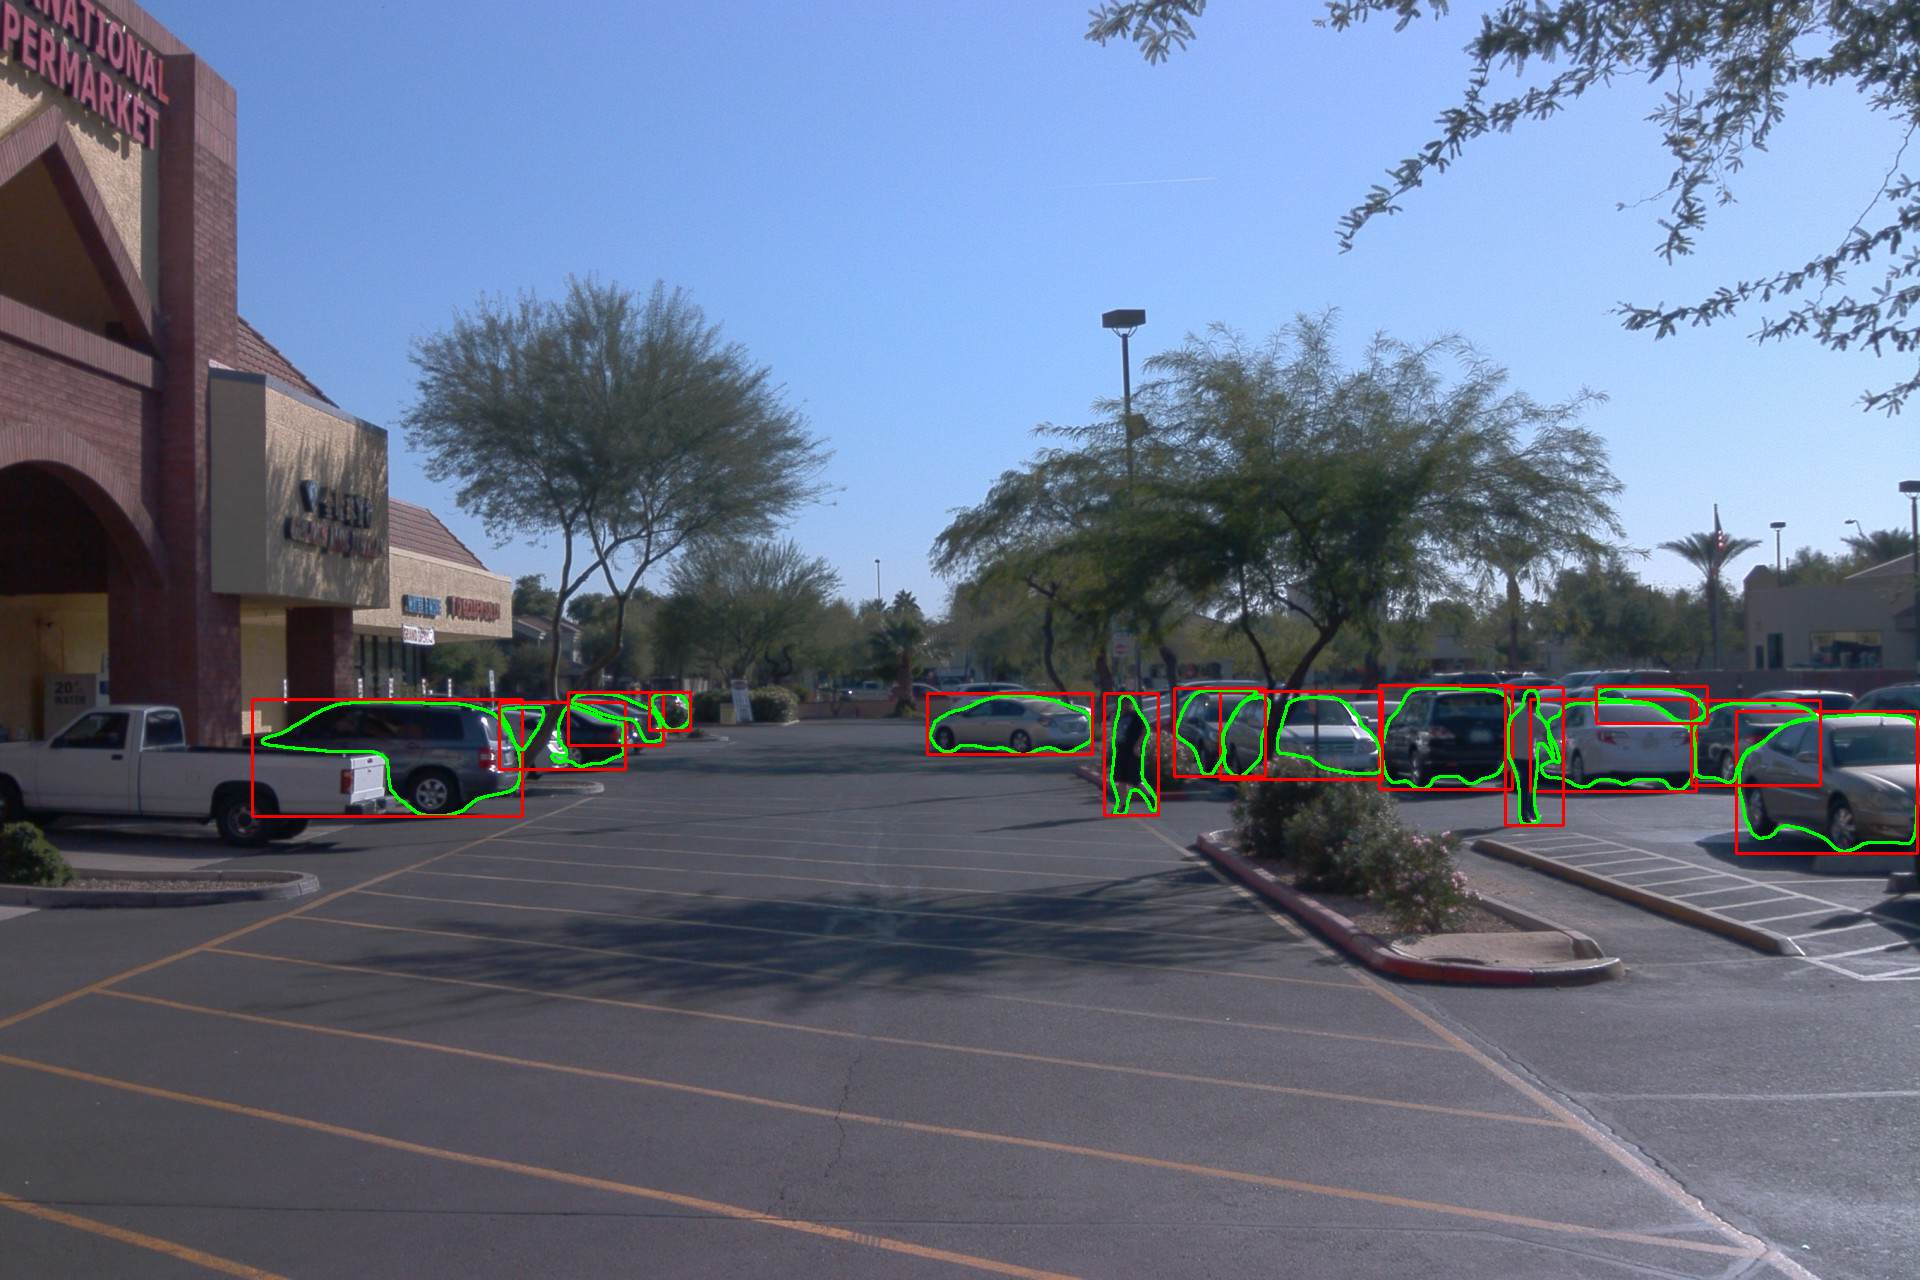

In [27]:
from PIL import Image

img = mesher.data_obj.get_image(sample_idx, camera_channel=camera_channel)
# imglabels = inst_labels[5]
ann_img = draw_lidar_on_image([], img, instances=inst_labels, display=False)
annimg = Image.fromarray(ann_img)
annimg

# Export points in mask/bbox

This is to test out lidar segmentation on the points within a box

In [7]:
from PIL import Image
from tqdm import tqdm

camera_channel = 'FRONT'

export_tag = 'bbox'
if export_tag == 'bbox':
    use_bbox = True
else:
    use_bbox = False

instance_dataset_id = 0
for sample_idx in tqdm(range(mesher.data_obj.__len__()), total=len(mesher.data_obj), desc='FRAME'):
    
    i_clouds = mesher.data_obj.get_mask_instance_clouds(sample_idx, camera_channel=camera_channel, use_bbox=use_bbox)
    pcd_gtboxes = mesher.get_pcd_gtboxes(sample_idx, add_ground_lift=True)    
    inst_labels = mesher.data_obj.get_camera_instances(sample_idx, channel=camera_channel)
        
    for object_id, i_cloud in enumerate(i_clouds):
        mask_pcd = convert_to_o3dpcd(i_clouds[object_id])
        cropped_pcds, num_pts_in_gt_for_mask = [], []        
        
        if len(i_cloud) < 5:
            continue
            
        for i in range(len(pcd_gtboxes['gt_boxes'])):    
            cropped = mask_pcd.crop(pcd_gtboxes['gt_boxes'][i])
            num_pts_in_gt_for_mask.append(len(cropped.points))
            cropped_pcds.append(cropped)            
            
        if not num_pts_in_gt_for_mask or max(num_pts_in_gt_for_mask) == 0:
            labelled_pts = np.hstack([i_cloud[:,:3], np.zeros((len(i_cloud),1))])
            box_pts = np.zeros((8,3))
            num_points_in_gt = 0
        else:
            gtbox_idx = np.argmax(np.array(num_pts_in_gt_for_mask)) 
            
            cropped_np = np.array(cropped_pcds[gtbox_idx].points)
            obj_pts_labelled = np.hstack([cropped_np, 10*np.ones((len(cropped_np),1))])

            dist = mask_pcd.compute_point_cloud_distance(cropped_pcds[gtbox_idx])
            cropped_inds = np.where(np.asarray(dist) < 0.01)[0]
            mask_without_obj = np.asarray(mask_pcd.select_by_index(cropped_inds, invert=True).points)
            mask_pts_labelled = np.hstack([mask_without_obj, np.zeros((len(mask_without_obj),1))])

            labelled_pts = np.vstack([mask_pts_labelled, obj_pts_labelled])
            box_pts = np.asarray(pcd_gtboxes['gt_boxes'][gtbox_idx].get_box_points())
            num_points_in_gt = len(cropped_np)
               
        # Save pcl
        fname = f"{instance_dataset_id:06}"
        car_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/pointcloud')
        car_dir.mkdir(parents=True, exist_ok=True)
        car_fname = str(car_dir / f'{fname}.bin')
        points = np.float32(labelled_pts)
        points.tofile(car_fname)
        
        # Save points labels
        label_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/labels')
        label_dir.mkdir(parents=True, exist_ok=True)
        label_fname = str(label_dir / f'{fname}.label')
        labels = np.uint32(labelled_pts[:,3])
        labels.tofile(label_fname)
        
        # Save gt bboxes
        box_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/gt_bboxes')    
        box_dir.mkdir(parents=True, exist_ok=True)
        np.savetxt(str(box_dir / f'{fname}.txt'), box_pts, delimiter=' ')
        
        # Save img
        img_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/image')    
        img_dir.mkdir(parents=True, exist_ok=True)
        img = mesher.data_obj.get_image(sample_idx, camera_channel=camera_channel)
        imglabels = inst_labels[object_id]
        ann_img = draw_lidar_on_image([], img, instances=[imglabels], display=False)
        Image.fromarray(ann_img).save(str(img_dir / f'{fname}.png'))

        # Save original filepath of input pointcloud
        origpath_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/fpath')
        origpath_dir.mkdir(parents=True, exist_ok=True)
        with open(str(origpath_dir / f'{fname}.txt'), 'w') as f:
              f.write(f'{sample_idx:06}')
        
        print(f"car #{instance_dataset_id}: Exported {object_id+1}/{len(i_clouds)} | total pts-{len(labelled_pts)}, gt pts - {num_points_in_gt}")
        instance_dataset_id = instance_dataset_id + 1

FRAME:   0%|                                                                                                                                     | 0/1000 [00:00<?, ?it/s]

car #0: Exported 1/14 | total pts-349, gt pts - 252
car #1: Exported 2/14 | total pts-617, gt pts - 318
car #2: Exported 3/14 | total pts-289, gt pts - 205
car #3: Exported 4/14 | total pts-186, gt pts - 114
car #4: Exported 5/14 | total pts-320, gt pts - 152
car #5: Exported 6/14 | total pts-195, gt pts - 164
car #6: Exported 7/14 | total pts-124, gt pts - 62
car #7: Exported 8/14 | total pts-159, gt pts - 54
car #8: Exported 9/14 | total pts-176, gt pts - 63
car #9: Exported 10/14 | total pts-146, gt pts - 16
car #10: Exported 11/14 | total pts-161, gt pts - 5
car #11: Exported 12/14 | total pts-53, gt pts - 37
car #12: Exported 13/14 | total pts-91, gt pts - 46


FRAME:   0%|                                                                                                                           | 1/1000 [00:20<5:39:03, 20.36s/it]

car #13: Exported 14/14 | total pts-42, gt pts - 9


FRAME:   0%|▏                                                                                                                          | 2/1000 [00:20<3:58:15, 14.32s/it]

car #14: Exported 1/15 | total pts-411, gt pts - 204
car #15: Exported 2/15 | total pts-290, gt pts - 178
car #16: Exported 3/15 | total pts-224, gt pts - 132
car #17: Exported 4/15 | total pts-218, gt pts - 0
car #18: Exported 5/15 | total pts-198, gt pts - 79
car #19: Exported 6/15 | total pts-102, gt pts - 87
car #20: Exported 7/15 | total pts-123, gt pts - 62
car #21: Exported 8/15 | total pts-155, gt pts - 92
car #22: Exported 9/15 | total pts-74, gt pts - 40
car #23: Exported 10/15 | total pts-119, gt pts - 0
car #24: Exported 11/15 | total pts-127, gt pts - 0
car #25: Exported 12/15 | total pts-82, gt pts - 48
car #26: Exported 13/15 | total pts-38, gt pts - 14
car #27: Exported 14/15 | total pts-80, gt pts - 5


FRAME:   0%|▎                                                                                                                          | 3/1000 [00:41<4:28:29, 16.16s/it]

car #28: Exported 15/15 | total pts-20, gt pts - 4
car #29: Exported 1/15 | total pts-296, gt pts - 52
car #30: Exported 2/15 | total pts-555, gt pts - 0
car #31: Exported 3/15 | total pts-281, gt pts - 227
car #32: Exported 4/15 | total pts-180, gt pts - 105
car #33: Exported 5/15 | total pts-184, gt pts - 0
car #34: Exported 6/15 | total pts-153, gt pts - 0
car #35: Exported 7/15 | total pts-37, gt pts - 32
car #36: Exported 8/15 | total pts-99, gt pts - 0
car #37: Exported 9/15 | total pts-46, gt pts - 25
car #38: Exported 10/15 | total pts-48, gt pts - 13
car #39: Exported 11/15 | total pts-32, gt pts - 10
car #40: Exported 12/15 | total pts-21, gt pts - 0
car #41: Exported 13/15 | total pts-34, gt pts - 0
car #42: Exported 14/15 | total pts-13, gt pts - 0


FRAME:   0%|▍                                                                                                                          | 4/1000 [01:01<4:49:43, 17.45s/it]

car #43: Exported 15/15 | total pts-8, gt pts - 0
car #44: Exported 1/10 | total pts-232, gt pts - 161
car #45: Exported 2/10 | total pts-431, gt pts - 247
car #46: Exported 3/10 | total pts-303, gt pts - 240
car #47: Exported 4/10 | total pts-241, gt pts - 129
car #48: Exported 5/10 | total pts-146, gt pts - 117
car #49: Exported 6/10 | total pts-86, gt pts - 65
car #50: Exported 7/10 | total pts-48, gt pts - 24


FRAME:   0%|▌                                                                                                                          | 5/1000 [01:12<4:16:49, 15.49s/it]

car #51: Exported 9/10 | total pts-8, gt pts - 8
car #52: Exported 1/9 | total pts-1720, gt pts - 1144
car #53: Exported 2/9 | total pts-793, gt pts - 648
car #54: Exported 3/9 | total pts-1032, gt pts - 680
car #55: Exported 4/9 | total pts-610, gt pts - 208
car #56: Exported 5/9 | total pts-644, gt pts - 89
car #57: Exported 6/9 | total pts-239, gt pts - 31
car #58: Exported 7/9 | total pts-242, gt pts - 0
car #59: Exported 8/9 | total pts-14, gt pts - 14


FRAME:   1%|▋                                                                                                                          | 6/1000 [01:25<4:03:38, 14.71s/it]

car #60: Exported 9/9 | total pts-24, gt pts - 3
car #61: Exported 1/20 | total pts-111, gt pts - 64
car #62: Exported 2/20 | total pts-125, gt pts - 95
car #63: Exported 3/20 | total pts-117, gt pts - 85
car #64: Exported 4/20 | total pts-154, gt pts - 134
car #65: Exported 5/20 | total pts-163, gt pts - 90
car #66: Exported 6/20 | total pts-101, gt pts - 87
car #67: Exported 7/20 | total pts-135, gt pts - 93
car #68: Exported 8/20 | total pts-105, gt pts - 21
car #69: Exported 9/20 | total pts-26, gt pts - 6
car #70: Exported 10/20 | total pts-118, gt pts - 45
car #71: Exported 11/20 | total pts-76, gt pts - 34
car #72: Exported 12/20 | total pts-76, gt pts - 0
car #73: Exported 13/20 | total pts-70, gt pts - 0
car #74: Exported 14/20 | total pts-39, gt pts - 30
car #75: Exported 15/20 | total pts-42, gt pts - 31
car #76: Exported 16/20 | total pts-23, gt pts - 16
car #77: Exported 17/20 | total pts-42, gt pts - 6
car #78: Exported 18/20 | total pts-39, gt pts - 0
car #79: Exported 1

FRAME:   1%|▊                                                                                                                          | 7/1000 [01:52<5:04:47, 18.42s/it]

car #80: Exported 20/20 | total pts-28, gt pts - 0
car #81: Exported 1/18 | total pts-724, gt pts - 533
car #82: Exported 2/18 | total pts-538, gt pts - 221
car #83: Exported 3/18 | total pts-571, gt pts - 322
car #84: Exported 4/18 | total pts-265, gt pts - 192
car #85: Exported 5/18 | total pts-105, gt pts - 62
car #86: Exported 6/18 | total pts-134, gt pts - 26
car #87: Exported 7/18 | total pts-137, gt pts - 6
car #88: Exported 8/18 | total pts-107, gt pts - 10
car #89: Exported 9/18 | total pts-85, gt pts - 30
car #90: Exported 10/18 | total pts-73, gt pts - 39
car #91: Exported 11/18 | total pts-20, gt pts - 15
car #92: Exported 12/18 | total pts-83, gt pts - 79
car #93: Exported 13/18 | total pts-56, gt pts - 1
car #94: Exported 14/18 | total pts-72, gt pts - 48
car #95: Exported 15/18 | total pts-25, gt pts - 4
car #96: Exported 16/18 | total pts-55, gt pts - 20
car #97: Exported 17/18 | total pts-8, gt pts - 0


FRAME:   1%|▉                                                                                                                          | 8/1000 [02:16<5:32:38, 20.12s/it]

car #98: Exported 18/18 | total pts-27, gt pts - 0
car #99: Exported 1/15 | total pts-1740, gt pts - 1098
car #100: Exported 2/15 | total pts-403, gt pts - 247
car #101: Exported 3/15 | total pts-219, gt pts - 176
car #102: Exported 4/15 | total pts-190, gt pts - 155
car #103: Exported 5/15 | total pts-259, gt pts - 88
car #104: Exported 6/15 | total pts-121, gt pts - 55
car #105: Exported 7/15 | total pts-27, gt pts - 18
car #106: Exported 8/15 | total pts-117, gt pts - 61
car #107: Exported 9/15 | total pts-180, gt pts - 180
car #108: Exported 10/15 | total pts-29, gt pts - 29
car #109: Exported 11/15 | total pts-114, gt pts - 9
car #110: Exported 12/15 | total pts-99, gt pts - 10
car #111: Exported 13/15 | total pts-81, gt pts - 43
car #112: Exported 14/15 | total pts-64, gt pts - 17


FRAME:   1%|█                                                                                                                          | 9/1000 [02:37<5:35:17, 20.30s/it]

car #113: Exported 15/15 | total pts-28, gt pts - 24
car #114: Exported 1/23 | total pts-1028, gt pts - 792
car #115: Exported 2/23 | total pts-829, gt pts - 580
car #116: Exported 3/23 | total pts-208, gt pts - 169
car #117: Exported 4/23 | total pts-419, gt pts - 0
car #118: Exported 5/23 | total pts-338, gt pts - 0
car #119: Exported 6/23 | total pts-113, gt pts - 107
car #120: Exported 7/23 | total pts-217, gt pts - 0
car #121: Exported 8/23 | total pts-211, gt pts - 0
car #122: Exported 9/23 | total pts-114, gt pts - 77
car #123: Exported 10/23 | total pts-199, gt pts - 114
car #124: Exported 11/23 | total pts-158, gt pts - 0
car #125: Exported 12/23 | total pts-173, gt pts - 0
car #126: Exported 13/23 | total pts-39, gt pts - 32
car #127: Exported 14/23 | total pts-48, gt pts - 35
car #128: Exported 15/23 | total pts-37, gt pts - 22
car #129: Exported 16/23 | total pts-34, gt pts - 23
car #130: Exported 18/23 | total pts-7, gt pts - 7
car #131: Exported 19/23 | total pts-56, gt p

FRAME:   1%|█▏                                                                                                                        | 10/1000 [03:08<6:31:21, 23.72s/it]

car #135: Exported 23/23 | total pts-39, gt pts - 0
car #136: Exported 1/19 | total pts-558, gt pts - 339
car #137: Exported 2/19 | total pts-1216, gt pts - 1216
car #138: Exported 3/19 | total pts-557, gt pts - 1
car #139: Exported 4/19 | total pts-465, gt pts - 5
car #140: Exported 5/19 | total pts-499, gt pts - 215
car #141: Exported 6/19 | total pts-348, gt pts - 101
car #142: Exported 7/19 | total pts-269, gt pts - 20
car #143: Exported 8/19 | total pts-200, gt pts - 147
car #144: Exported 9/19 | total pts-278, gt pts - 1
car #145: Exported 10/19 | total pts-211, gt pts - 174
car #146: Exported 11/19 | total pts-177, gt pts - 135
car #147: Exported 12/19 | total pts-218, gt pts - 17
car #148: Exported 13/19 | total pts-137, gt pts - 119
car #149: Exported 14/19 | total pts-44, gt pts - 39
car #150: Exported 15/19 | total pts-23, gt pts - 10
car #151: Exported 16/19 | total pts-68, gt pts - 41


FRAME:   1%|█▎                                                                                                                        | 11/1000 [03:32<6:28:20, 23.56s/it]

car #152: Exported 18/19 | total pts-12, gt pts - 4
car #153: Exported 1/16 | total pts-1900, gt pts - 1255
car #154: Exported 2/16 | total pts-782, gt pts - 594
car #155: Exported 3/16 | total pts-426, gt pts - 249
car #156: Exported 4/16 | total pts-87, gt pts - 44
car #157: Exported 5/16 | total pts-79, gt pts - 0
car #158: Exported 6/16 | total pts-82, gt pts - 0
car #159: Exported 7/16 | total pts-59, gt pts - 0
car #160: Exported 8/16 | total pts-54, gt pts - 2
car #161: Exported 9/16 | total pts-58, gt pts - 0
car #162: Exported 10/16 | total pts-43, gt pts - 0
car #163: Exported 11/16 | total pts-35, gt pts - 0
car #164: Exported 12/16 | total pts-55, gt pts - 0
car #165: Exported 13/16 | total pts-44, gt pts - 0
car #166: Exported 14/16 | total pts-31, gt pts - 0
car #167: Exported 15/16 | total pts-32, gt pts - 0


FRAME:   1%|█▍                                                                                                                        | 12/1000 [03:55<6:25:57, 23.44s/it]

car #168: Exported 16/16 | total pts-24, gt pts - 0
car #169: Exported 1/19 | total pts-2909, gt pts - 2245
car #170: Exported 2/19 | total pts-945, gt pts - 466
car #171: Exported 3/19 | total pts-383, gt pts - 324
car #172: Exported 4/19 | total pts-407, gt pts - 0
car #173: Exported 5/19 | total pts-229, gt pts - 136
car #174: Exported 6/19 | total pts-317, gt pts - 0
car #175: Exported 7/19 | total pts-159, gt pts - 21
car #176: Exported 8/19 | total pts-157, gt pts - 53
car #177: Exported 9/19 | total pts-42, gt pts - 39
car #178: Exported 10/19 | total pts-162, gt pts - 0
car #179: Exported 11/19 | total pts-146, gt pts - 67
car #180: Exported 12/19 | total pts-102, gt pts - 5
car #181: Exported 13/19 | total pts-38, gt pts - 15
car #182: Exported 14/19 | total pts-58, gt pts - 23
car #183: Exported 15/19 | total pts-167, gt pts - 0
car #184: Exported 16/19 | total pts-48, gt pts - 44
car #185: Exported 17/19 | total pts-46, gt pts - 0
car #186: Exported 18/19 | total pts-62, gt 

FRAME:   1%|█▌                                                                                                                        | 13/1000 [04:22<6:46:40, 24.72s/it]

car #187: Exported 19/19 | total pts-12, gt pts - 0
car #188: Exported 1/12 | total pts-1878, gt pts - 1431
car #189: Exported 2/12 | total pts-707, gt pts - 525
car #190: Exported 3/12 | total pts-538, gt pts - 447
car #191: Exported 4/12 | total pts-501, gt pts - 0
car #192: Exported 5/12 | total pts-320, gt pts - 250
car #193: Exported 6/12 | total pts-187, gt pts - 0
car #194: Exported 7/12 | total pts-202, gt pts - 153
car #195: Exported 8/12 | total pts-137, gt pts - 81
car #196: Exported 9/12 | total pts-170, gt pts - 157
car #197: Exported 10/12 | total pts-137, gt pts - 127
car #198: Exported 11/12 | total pts-79, gt pts - 46


FRAME:   1%|█▋                                                                                                                        | 14/1000 [04:45<6:37:45, 24.20s/it]

car #199: Exported 12/12 | total pts-28, gt pts - 27
car #200: Exported 1/2 | total pts-2970, gt pts - 2215


FRAME:   2%|█▊                                                                                                                        | 15/1000 [04:49<4:53:43, 17.89s/it]

car #201: Exported 2/2 | total pts-328, gt pts - 0
car #202: Exported 1/13 | total pts-1208, gt pts - 839
car #203: Exported 2/13 | total pts-814, gt pts - 379
car #204: Exported 3/13 | total pts-444, gt pts - 299
car #205: Exported 4/13 | total pts-440, gt pts - 296
car #206: Exported 5/13 | total pts-245, gt pts - 146
car #207: Exported 6/13 | total pts-329, gt pts - 210
car #208: Exported 7/13 | total pts-158, gt pts - 73
car #209: Exported 8/13 | total pts-122, gt pts - 44
car #210: Exported 10/13 | total pts-32, gt pts - 0
car #211: Exported 11/13 | total pts-41, gt pts - 0
car #212: Exported 12/13 | total pts-29, gt pts - 0


FRAME:   2%|█▉                                                                                                                        | 16/1000 [05:05<4:47:11, 17.51s/it]

car #213: Exported 13/13 | total pts-5, gt pts - 4
car #214: Exported 1/23 | total pts-302, gt pts - 258
car #215: Exported 2/23 | total pts-224, gt pts - 85
car #216: Exported 3/23 | total pts-357, gt pts - 22
car #217: Exported 4/23 | total pts-215, gt pts - 134
car #218: Exported 5/23 | total pts-298, gt pts - 0
car #219: Exported 6/23 | total pts-251, gt pts - 0
car #220: Exported 7/23 | total pts-148, gt pts - 95
car #221: Exported 8/23 | total pts-94, gt pts - 72
car #222: Exported 9/23 | total pts-164, gt pts - 0
car #223: Exported 10/23 | total pts-123, gt pts - 0
car #224: Exported 11/23 | total pts-99, gt pts - 56
car #225: Exported 12/23 | total pts-126, gt pts - 0
car #226: Exported 13/23 | total pts-72, gt pts - 31
car #227: Exported 14/23 | total pts-23, gt pts - 3
car #228: Exported 15/23 | total pts-63, gt pts - 15
car #229: Exported 17/23 | total pts-90, gt pts - 11
car #230: Exported 18/23 | total pts-45, gt pts - 34
car #231: Exported 19/23 | total pts-74, gt pts - 0

FRAME:   2%|██                                                                                                                        | 17/1000 [05:34<5:41:29, 20.84s/it]

car #234: Exported 23/23 | total pts-33, gt pts - 0
car #235: Exported 1/11 | total pts-613, gt pts - 86
car #236: Exported 2/11 | total pts-253, gt pts - 127
car #237: Exported 3/11 | total pts-386, gt pts - 0
car #238: Exported 4/11 | total pts-325, gt pts - 113
car #239: Exported 5/11 | total pts-188, gt pts - 153
car #240: Exported 6/11 | total pts-88, gt pts - 69
car #241: Exported 7/11 | total pts-103, gt pts - 37
car #242: Exported 8/11 | total pts-129, gt pts - 57
car #243: Exported 9/11 | total pts-30, gt pts - 16
car #244: Exported 10/11 | total pts-27, gt pts - 13


FRAME:   2%|██▏                                                                                                                       | 18/1000 [05:49<5:14:44, 19.23s/it]

car #245: Exported 11/11 | total pts-21, gt pts - 14
car #246: Exported 1/13 | total pts-736, gt pts - 477
car #247: Exported 2/13 | total pts-385, gt pts - 192
car #248: Exported 3/13 | total pts-409, gt pts - 314
car #249: Exported 4/13 | total pts-244, gt pts - 215
car #250: Exported 5/13 | total pts-474, gt pts - 183
car #251: Exported 6/13 | total pts-317, gt pts - 133
car #252: Exported 7/13 | total pts-180, gt pts - 69
car #253: Exported 8/13 | total pts-291, gt pts - 128
car #254: Exported 9/13 | total pts-191, gt pts - 86
car #255: Exported 10/13 | total pts-70, gt pts - 4
car #256: Exported 11/13 | total pts-238, gt pts - 101
car #257: Exported 12/13 | total pts-120, gt pts - 44


FRAME:   2%|██▎                                                                                                                       | 19/1000 [06:07<5:06:08, 18.72s/it]

car #258: Exported 13/13 | total pts-98, gt pts - 46
car #259: Exported 1/14 | total pts-1253, gt pts - 1013
car #260: Exported 2/14 | total pts-409, gt pts - 263
car #261: Exported 3/14 | total pts-438, gt pts - 322
car #262: Exported 4/14 | total pts-279, gt pts - 252
car #263: Exported 5/14 | total pts-446, gt pts - 214
car #264: Exported 6/14 | total pts-284, gt pts - 231
car #265: Exported 7/14 | total pts-159, gt pts - 109
car #266: Exported 8/14 | total pts-165, gt pts - 121
car #267: Exported 9/14 | total pts-118, gt pts - 89
car #268: Exported 10/14 | total pts-22, gt pts - 22
car #269: Exported 11/14 | total pts-212, gt pts - 86
car #270: Exported 12/14 | total pts-75, gt pts - 51
car #271: Exported 13/14 | total pts-44, gt pts - 38


FRAME:   2%|██▍                                                                                                                       | 20/1000 [06:27<5:13:08, 19.17s/it]

car #272: Exported 14/14 | total pts-18, gt pts - 0
car #273: Exported 1/2 | total pts-42, gt pts - 36


FRAME:   2%|██▌                                                                                                                       | 21/1000 [06:31<3:59:31, 14.68s/it]

car #274: Exported 2/2 | total pts-42, gt pts - 36
car #275: Exported 1/18 | total pts-4088, gt pts - 3000
car #276: Exported 2/18 | total pts-2834, gt pts - 2090
car #277: Exported 3/18 | total pts-922, gt pts - 546
car #278: Exported 4/18 | total pts-783, gt pts - 492
car #279: Exported 5/18 | total pts-438, gt pts - 344
car #280: Exported 6/18 | total pts-642, gt pts - 306
car #281: Exported 7/18 | total pts-328, gt pts - 199
car #282: Exported 8/18 | total pts-248, gt pts - 131
car #283: Exported 9/18 | total pts-192, gt pts - 80
car #284: Exported 10/18 | total pts-129, gt pts - 38
car #285: Exported 11/18 | total pts-215, gt pts - 75
car #286: Exported 12/18 | total pts-99, gt pts - 59
car #287: Exported 13/18 | total pts-58, gt pts - 12
car #288: Exported 14/18 | total pts-142, gt pts - 36
car #289: Exported 15/18 | total pts-82, gt pts - 67
car #290: Exported 16/18 | total pts-74, gt pts - 39


FRAME:   2%|██▋                                                                                                                       | 22/1000 [06:56<4:46:40, 17.59s/it]

car #291: Exported 18/18 | total pts-43, gt pts - 33
car #292: Exported 1/14 | total pts-616, gt pts - 401
car #293: Exported 2/14 | total pts-804, gt pts - 17
car #294: Exported 3/14 | total pts-849, gt pts - 306
car #295: Exported 4/14 | total pts-241, gt pts - 172
car #296: Exported 5/14 | total pts-527, gt pts - 293
car #297: Exported 6/14 | total pts-235, gt pts - 188
car #298: Exported 7/14 | total pts-230, gt pts - 90
car #299: Exported 8/14 | total pts-145, gt pts - 110
car #300: Exported 9/14 | total pts-119, gt pts - 97
car #301: Exported 10/14 | total pts-257, gt pts - 119
car #302: Exported 11/14 | total pts-67, gt pts - 17
car #303: Exported 12/14 | total pts-105, gt pts - 20
car #304: Exported 13/14 | total pts-126, gt pts - 12


FRAME:   2%|██▊                                                                                                                       | 23/1000 [07:15<4:55:00, 18.12s/it]

car #305: Exported 14/14 | total pts-110, gt pts - 36
car #306: Exported 1/14 | total pts-3228, gt pts - 2602
car #307: Exported 2/14 | total pts-709, gt pts - 393
car #308: Exported 3/14 | total pts-587, gt pts - 327
car #309: Exported 4/14 | total pts-339, gt pts - 250
car #310: Exported 5/14 | total pts-270, gt pts - 180
car #311: Exported 6/14 | total pts-183, gt pts - 109
car #312: Exported 7/14 | total pts-262, gt pts - 50
car #313: Exported 8/14 | total pts-184, gt pts - 50
car #314: Exported 9/14 | total pts-86, gt pts - 28
car #315: Exported 10/14 | total pts-72, gt pts - 45
car #316: Exported 11/14 | total pts-33, gt pts - 23
car #317: Exported 12/14 | total pts-143, gt pts - 43
car #318: Exported 13/14 | total pts-65, gt pts - 27


FRAME:   2%|██▉                                                                                                                       | 24/1000 [07:35<5:05:02, 18.75s/it]

car #319: Exported 14/14 | total pts-53, gt pts - 13
car #320: Exported 1/14 | total pts-2220, gt pts - 1482
car #321: Exported 2/14 | total pts-545, gt pts - 354
car #322: Exported 3/14 | total pts-195, gt pts - 120
car #323: Exported 4/14 | total pts-237, gt pts - 157
car #324: Exported 5/14 | total pts-118, gt pts - 72
car #325: Exported 6/14 | total pts-146, gt pts - 79
car #326: Exported 7/14 | total pts-167, gt pts - 61
car #327: Exported 8/14 | total pts-65, gt pts - 36
car #328: Exported 9/14 | total pts-46, gt pts - 27
car #329: Exported 10/14 | total pts-140, gt pts - 67
car #330: Exported 11/14 | total pts-113, gt pts - 52
car #331: Exported 12/14 | total pts-90, gt pts - 3
car #332: Exported 13/14 | total pts-29, gt pts - 0


FRAME:   2%|███                                                                                                                       | 25/1000 [07:57<5:20:10, 19.70s/it]

car #333: Exported 14/14 | total pts-31, gt pts - 6
car #334: Exported 1/17 | total pts-4791, gt pts - 3221
car #335: Exported 2/17 | total pts-2822, gt pts - 2040
car #336: Exported 3/17 | total pts-573, gt pts - 364
car #337: Exported 4/17 | total pts-628, gt pts - 457
car #338: Exported 5/17 | total pts-304, gt pts - 211
car #339: Exported 6/17 | total pts-203, gt pts - 167
car #340: Exported 7/17 | total pts-232, gt pts - 146
car #341: Exported 8/17 | total pts-272, gt pts - 114
car #342: Exported 9/17 | total pts-128, gt pts - 42
car #343: Exported 10/17 | total pts-266, gt pts - 119
car #344: Exported 11/17 | total pts-102, gt pts - 44
car #345: Exported 12/17 | total pts-146, gt pts - 65
car #346: Exported 13/17 | total pts-110, gt pts - 11
car #347: Exported 14/17 | total pts-23, gt pts - 1
car #348: Exported 15/17 | total pts-62, gt pts - 0
car #349: Exported 16/17 | total pts-8, gt pts - 0


FRAME:   3%|███▏                                                                                                                      | 26/1000 [08:22<5:43:56, 21.19s/it]

car #350: Exported 17/17 | total pts-33, gt pts - 2
car #351: Exported 1/6 | total pts-3865, gt pts - 703
car #352: Exported 2/6 | total pts-834, gt pts - 219
car #353: Exported 3/6 | total pts-1480, gt pts - 195
car #354: Exported 4/6 | total pts-1132, gt pts - 360
car #355: Exported 5/6 | total pts-108, gt pts - 107


FRAME:   3%|███▎                                                                                                                      | 27/1000 [08:34<4:58:28, 18.41s/it]

car #356: Exported 6/6 | total pts-43, gt pts - 43
car #357: Exported 1/10 | total pts-739, gt pts - 573
car #358: Exported 2/10 | total pts-287, gt pts - 213
car #359: Exported 3/10 | total pts-191, gt pts - 148
car #360: Exported 4/10 | total pts-151, gt pts - 76
car #361: Exported 5/10 | total pts-48, gt pts - 0
car #362: Exported 6/10 | total pts-64, gt pts - 60
car #363: Exported 7/10 | total pts-65, gt pts - 58
car #364: Exported 8/10 | total pts-62, gt pts - 42


FRAME:   3%|███▍                                                                                                                      | 28/1000 [08:47<4:35:15, 16.99s/it]

car #365: Exported 9/10 | total pts-58, gt pts - 58
car #366: Exported 1/12 | total pts-2723, gt pts - 2046
car #367: Exported 2/12 | total pts-1201, gt pts - 858
car #368: Exported 3/12 | total pts-1559, gt pts - 1038
car #369: Exported 4/12 | total pts-651, gt pts - 472
car #370: Exported 5/12 | total pts-601, gt pts - 427
car #371: Exported 6/12 | total pts-438, gt pts - 324
car #372: Exported 7/12 | total pts-376, gt pts - 223
car #373: Exported 8/12 | total pts-142, gt pts - 113
car #374: Exported 9/12 | total pts-164, gt pts - 87
car #375: Exported 10/12 | total pts-154, gt pts - 106
car #376: Exported 11/12 | total pts-98, gt pts - 33


FRAME:   3%|███▌                                                                                                                      | 29/1000 [09:05<4:37:19, 17.14s/it]

car #377: Exported 12/12 | total pts-65, gt pts - 41
car #378: Exported 1/11 | total pts-918, gt pts - 695
car #379: Exported 2/11 | total pts-578, gt pts - 387
car #380: Exported 3/11 | total pts-420, gt pts - 276
car #381: Exported 4/11 | total pts-400, gt pts - 252
car #382: Exported 5/11 | total pts-347, gt pts - 298
car #383: Exported 6/11 | total pts-286, gt pts - 200
car #384: Exported 7/11 | total pts-191, gt pts - 123
car #385: Exported 8/11 | total pts-108, gt pts - 54
car #386: Exported 9/11 | total pts-87, gt pts - 43
car #387: Exported 10/11 | total pts-30, gt pts - 21


FRAME:   3%|███▋                                                                                                                      | 30/1000 [09:23<4:40:54, 17.38s/it]

car #388: Exported 11/11 | total pts-26, gt pts - 0
car #389: Exported 1/11 | total pts-1745, gt pts - 1322
car #390: Exported 2/11 | total pts-935, gt pts - 790
car #391: Exported 3/11 | total pts-485, gt pts - 370
car #392: Exported 4/11 | total pts-328, gt pts - 247
car #393: Exported 5/11 | total pts-210, gt pts - 172
car #394: Exported 6/11 | total pts-124, gt pts - 66
car #395: Exported 7/11 | total pts-224, gt pts - 82
car #396: Exported 8/11 | total pts-44, gt pts - 39
car #397: Exported 9/11 | total pts-58, gt pts - 40
car #398: Exported 10/11 | total pts-10, gt pts - 10


FRAME:   3%|███▊                                                                                                                      | 31/1000 [09:37<4:23:30, 16.32s/it]

car #399: Exported 11/11 | total pts-102, gt pts - 51
car #400: Exported 1/11 | total pts-2063, gt pts - 1826
car #401: Exported 2/11 | total pts-1134, gt pts - 807
car #402: Exported 3/11 | total pts-929, gt pts - 704
car #403: Exported 4/11 | total pts-514, gt pts - 437
car #404: Exported 5/11 | total pts-522, gt pts - 387
car #405: Exported 6/11 | total pts-268, gt pts - 96
car #406: Exported 7/11 | total pts-282, gt pts - 192
car #407: Exported 8/11 | total pts-98, gt pts - 76
car #408: Exported 9/11 | total pts-86, gt pts - 14
car #409: Exported 10/11 | total pts-33, gt pts - 8


FRAME:   3%|███▉                                                                                                                      | 32/1000 [09:53<4:23:33, 16.34s/it]

car #410: Exported 11/11 | total pts-5, gt pts - 5
car #411: Exported 1/17 | total pts-3678, gt pts - 2880
car #412: Exported 2/17 | total pts-472, gt pts - 423
car #413: Exported 3/17 | total pts-724, gt pts - 36
car #414: Exported 4/17 | total pts-242, gt pts - 80
car #415: Exported 5/17 | total pts-330, gt pts - 0
car #416: Exported 6/17 | total pts-214, gt pts - 58
car #417: Exported 7/17 | total pts-41, gt pts - 27
car #418: Exported 8/17 | total pts-35, gt pts - 35
car #419: Exported 9/17 | total pts-93, gt pts - 0
car #420: Exported 10/17 | total pts-87, gt pts - 0
car #421: Exported 11/17 | total pts-66, gt pts - 0
car #422: Exported 12/17 | total pts-66, gt pts - 0
car #423: Exported 13/17 | total pts-22, gt pts - 18
car #424: Exported 14/17 | total pts-16, gt pts - 16
car #425: Exported 15/17 | total pts-25, gt pts - 8
car #426: Exported 16/17 | total pts-31, gt pts - 0


FRAME:   3%|████                                                                                                                      | 33/1000 [10:18<5:05:48, 18.97s/it]

car #427: Exported 17/17 | total pts-17, gt pts - 0
car #428: Exported 1/11 | total pts-676, gt pts - 481
car #429: Exported 2/11 | total pts-369, gt pts - 255
car #430: Exported 3/11 | total pts-510, gt pts - 399
car #431: Exported 4/11 | total pts-194, gt pts - 134
car #432: Exported 5/11 | total pts-137, gt pts - 27
car #433: Exported 6/11 | total pts-86, gt pts - 51
car #434: Exported 7/11 | total pts-32, gt pts - 0
car #435: Exported 8/11 | total pts-56, gt pts - 37
car #436: Exported 9/11 | total pts-60, gt pts - 21
car #437: Exported 10/11 | total pts-35, gt pts - 18


FRAME:   3%|████▏                                                                                                                     | 34/1000 [10:32<4:42:39, 17.56s/it]

car #438: Exported 11/11 | total pts-5, gt pts - 5
car #439: Exported 1/9 | total pts-1343, gt pts - 951
car #440: Exported 2/9 | total pts-491, gt pts - 142
car #441: Exported 3/9 | total pts-486, gt pts - 345
car #442: Exported 4/9 | total pts-333, gt pts - 271
car #443: Exported 5/9 | total pts-790, gt pts - 486
car #444: Exported 6/9 | total pts-313, gt pts - 156
car #445: Exported 7/9 | total pts-51, gt pts - 25
car #446: Exported 8/9 | total pts-34, gt pts - 0


FRAME:   4%|████▎                                                                                                                     | 35/1000 [10:44<4:13:08, 15.74s/it]

car #447: Exported 9/9 | total pts-6, gt pts - 0
car #448: Exported 1/15 | total pts-656, gt pts - 348
car #449: Exported 2/15 | total pts-211, gt pts - 179
car #450: Exported 3/15 | total pts-139, gt pts - 96
car #451: Exported 4/15 | total pts-121, gt pts - 121
car #452: Exported 5/15 | total pts-82, gt pts - 39
car #453: Exported 6/15 | total pts-61, gt pts - 30
car #454: Exported 7/15 | total pts-53, gt pts - 20
car #455: Exported 8/15 | total pts-43, gt pts - 27
car #456: Exported 9/15 | total pts-6, gt pts - 3
car #457: Exported 10/15 | total pts-29, gt pts - 17
car #458: Exported 11/15 | total pts-32, gt pts - 22
car #459: Exported 12/15 | total pts-36, gt pts - 24
car #460: Exported 13/15 | total pts-28, gt pts - 8
car #461: Exported 14/15 | total pts-60, gt pts - 38


FRAME:   4%|████▍                                                                                                                     | 36/1000 [11:05<4:37:34, 17.28s/it]

car #462: Exported 15/15 | total pts-23, gt pts - 10
car #463: Exported 1/17 | total pts-288, gt pts - 158
car #464: Exported 2/17 | total pts-259, gt pts - 118
car #465: Exported 3/17 | total pts-165, gt pts - 108
car #466: Exported 4/17 | total pts-182, gt pts - 74
car #467: Exported 5/17 | total pts-87, gt pts - 48
car #468: Exported 6/17 | total pts-108, gt pts - 71
car #469: Exported 7/17 | total pts-47, gt pts - 29
car #470: Exported 8/17 | total pts-70, gt pts - 28
car #471: Exported 9/17 | total pts-21, gt pts - 16
car #472: Exported 10/17 | total pts-62, gt pts - 14
car #473: Exported 11/17 | total pts-40, gt pts - 17
car #474: Exported 12/17 | total pts-47, gt pts - 21
car #475: Exported 13/17 | total pts-12, gt pts - 11
car #476: Exported 14/17 | total pts-56, gt pts - 21
car #477: Exported 15/17 | total pts-18, gt pts - 7


FRAME:   4%|████▌                                                                                                                     | 37/1000 [11:27<5:03:27, 18.91s/it]

car #478: Exported 17/17 | total pts-6, gt pts - 3
car #479: Exported 1/8 | total pts-107, gt pts - 0
car #480: Exported 2/8 | total pts-100, gt pts - 0
car #481: Exported 3/8 | total pts-120, gt pts - 0
car #482: Exported 4/8 | total pts-72, gt pts - 0
car #483: Exported 5/8 | total pts-68, gt pts - 0
car #484: Exported 6/8 | total pts-77, gt pts - 0


FRAME:   4%|████▋                                                                                                                     | 38/1000 [11:37<4:20:08, 16.23s/it]

car #485: Exported 7/8 | total pts-58, gt pts - 0
car #486: Exported 1/3 | total pts-1121, gt pts - 709
car #487: Exported 2/3 | total pts-136, gt pts - 113


FRAME:   4%|████▊                                                                                                                     | 39/1000 [11:42<3:24:27, 12.76s/it]

car #488: Exported 3/3 | total pts-28, gt pts - 12
car #489: Exported 1/13 | total pts-4196, gt pts - 3320
car #490: Exported 2/13 | total pts-691, gt pts - 499
car #491: Exported 3/13 | total pts-668, gt pts - 374
car #492: Exported 4/13 | total pts-534, gt pts - 325
car #493: Exported 5/13 | total pts-1137, gt pts - 533
car #494: Exported 6/13 | total pts-423, gt pts - 292
car #495: Exported 7/13 | total pts-277, gt pts - 137
car #496: Exported 8/13 | total pts-322, gt pts - 175
car #497: Exported 9/13 | total pts-272, gt pts - 147
car #498: Exported 10/13 | total pts-122, gt pts - 62
car #499: Exported 11/13 | total pts-147, gt pts - 71


FRAME:   4%|████▉                                                                                                                     | 40/1000 [11:57<3:35:26, 13.46s/it]

car #500: Exported 13/13 | total pts-7, gt pts - 4
car #501: Exported 1/4 | total pts-872, gt pts - 715
car #502: Exported 2/4 | total pts-520, gt pts - 24
car #503: Exported 3/4 | total pts-358, gt pts - 351


FRAME:   4%|█████                                                                                                                     | 41/1000 [12:04<3:04:51, 11.57s/it]

car #504: Exported 4/4 | total pts-7, gt pts - 0
car #505: Exported 1/17 | total pts-2589, gt pts - 1934
car #506: Exported 2/17 | total pts-740, gt pts - 314
car #507: Exported 3/17 | total pts-358, gt pts - 176
car #508: Exported 4/17 | total pts-143, gt pts - 67
car #509: Exported 5/17 | total pts-106, gt pts - 35
car #510: Exported 6/17 | total pts-83, gt pts - 0
car #511: Exported 7/17 | total pts-90, gt pts - 13
car #512: Exported 8/17 | total pts-80, gt pts - 0
car #513: Exported 9/17 | total pts-47, gt pts - 18
car #514: Exported 10/17 | total pts-68, gt pts - 0
car #515: Exported 11/17 | total pts-66, gt pts - 0
car #516: Exported 12/17 | total pts-7, gt pts - 0
car #517: Exported 13/17 | total pts-41, gt pts - 0
car #518: Exported 14/17 | total pts-59, gt pts - 0
car #519: Exported 15/17 | total pts-55, gt pts - 0
car #520: Exported 16/17 | total pts-45, gt pts - 0


FRAME:   4%|█████                                                                                                                     | 42/1000 [12:29<4:04:56, 15.34s/it]

car #521: Exported 17/17 | total pts-30, gt pts - 0
car #522: Exported 1/16 | total pts-1889, gt pts - 1532
car #523: Exported 2/16 | total pts-1866, gt pts - 898
car #524: Exported 3/16 | total pts-687, gt pts - 493
car #525: Exported 4/16 | total pts-552, gt pts - 325
car #526: Exported 5/16 | total pts-1104, gt pts - 455
car #527: Exported 6/16 | total pts-505, gt pts - 237
car #528: Exported 7/16 | total pts-635, gt pts - 236
car #529: Exported 8/16 | total pts-230, gt pts - 138
car #530: Exported 9/16 | total pts-279, gt pts - 181
car #531: Exported 10/16 | total pts-33, gt pts - 14
car #532: Exported 11/16 | total pts-37, gt pts - 25
car #533: Exported 12/16 | total pts-71, gt pts - 7
car #534: Exported 13/16 | total pts-117, gt pts - 50
car #535: Exported 14/16 | total pts-74, gt pts - 0


FRAME:   4%|█████▏                                                                                                                    | 43/1000 [12:48<4:24:42, 16.60s/it]

car #536: Exported 15/16 | total pts-72, gt pts - 6


FRAME:   4%|█████▎                                                                                                                    | 44/1000 [12:50<3:16:41, 12.34s/it]

car #537: Exported 1/1 | total pts-335, gt pts - 0
car #538: Exported 1/11 | total pts-1846, gt pts - 1318
car #539: Exported 2/11 | total pts-422, gt pts - 297
car #540: Exported 3/11 | total pts-241, gt pts - 188
car #541: Exported 4/11 | total pts-295, gt pts - 244
car #542: Exported 5/11 | total pts-240, gt pts - 181
car #543: Exported 6/11 | total pts-138, gt pts - 89
car #544: Exported 7/11 | total pts-50, gt pts - 47
car #545: Exported 8/11 | total pts-101, gt pts - 53
car #546: Exported 9/11 | total pts-78, gt pts - 0
car #547: Exported 10/11 | total pts-14, gt pts - 0


FRAME:   4%|█████▍                                                                                                                    | 45/1000 [13:06<3:31:51, 13.31s/it]

car #548: Exported 11/11 | total pts-8, gt pts - 5
car #549: Exported 1/15 | total pts-1807, gt pts - 1222
car #550: Exported 2/15 | total pts-1019, gt pts - 749
car #551: Exported 3/15 | total pts-548, gt pts - 391
car #552: Exported 4/15 | total pts-233, gt pts - 0
car #553: Exported 5/15 | total pts-171, gt pts - 112
car #554: Exported 6/15 | total pts-201, gt pts - 0
car #555: Exported 7/15 | total pts-155, gt pts - 121
car #556: Exported 8/15 | total pts-147, gt pts - 103
car #557: Exported 9/15 | total pts-128, gt pts - 70
car #558: Exported 10/15 | total pts-108, gt pts - 0
car #559: Exported 11/15 | total pts-176, gt pts - 63
car #560: Exported 12/15 | total pts-71, gt pts - 54
car #561: Exported 13/15 | total pts-38, gt pts - 22
car #562: Exported 14/15 | total pts-45, gt pts - 17


FRAME:   5%|█████▌                                                                                                                    | 46/1000 [13:34<4:40:41, 17.65s/it]

car #563: Exported 15/15 | total pts-24, gt pts - 0
car #564: Exported 1/12 | total pts-1011, gt pts - 528
car #565: Exported 2/12 | total pts-372, gt pts - 265
car #566: Exported 3/12 | total pts-211, gt pts - 100
car #567: Exported 4/12 | total pts-137, gt pts - 121
car #568: Exported 5/12 | total pts-190, gt pts - 32
car #569: Exported 6/12 | total pts-108, gt pts - 86
car #570: Exported 7/12 | total pts-59, gt pts - 32
car #571: Exported 8/12 | total pts-117, gt pts - 57
car #572: Exported 9/12 | total pts-118, gt pts - 0
car #573: Exported 10/12 | total pts-29, gt pts - 18
car #574: Exported 11/12 | total pts-41, gt pts - 18


FRAME:   5%|█████▋                                                                                                                    | 47/1000 [13:51<4:39:08, 17.57s/it]

car #575: Exported 12/12 | total pts-59, gt pts - 29
car #576: Exported 1/11 | total pts-141, gt pts - 121
car #577: Exported 2/11 | total pts-90, gt pts - 85
car #578: Exported 3/11 | total pts-43, gt pts - 18
car #579: Exported 4/11 | total pts-90, gt pts - 30
car #580: Exported 5/11 | total pts-50, gt pts - 37
car #581: Exported 7/11 | total pts-110, gt pts - 57
car #582: Exported 8/11 | total pts-37, gt pts - 24
car #583: Exported 9/11 | total pts-13, gt pts - 0
car #584: Exported 10/11 | total pts-7, gt pts - 7


FRAME:   5%|█████▊                                                                                                                    | 48/1000 [14:05<4:22:42, 16.56s/it]

car #585: Exported 11/11 | total pts-9, gt pts - 4
car #586: Exported 1/10 | total pts-1078, gt pts - 805
car #587: Exported 2/10 | total pts-404, gt pts - 233
car #588: Exported 3/10 | total pts-347, gt pts - 275
car #589: Exported 4/10 | total pts-142, gt pts - 127
car #590: Exported 5/10 | total pts-90, gt pts - 49
car #591: Exported 6/10 | total pts-181, gt pts - 82
car #592: Exported 7/10 | total pts-57, gt pts - 53
car #593: Exported 8/10 | total pts-99, gt pts - 82
car #594: Exported 9/10 | total pts-60, gt pts - 47


FRAME:   5%|█████▉                                                                                                                    | 49/1000 [14:21<4:16:11, 16.16s/it]

car #595: Exported 10/10 | total pts-62, gt pts - 36
car #596: Exported 1/10 | total pts-995, gt pts - 27
car #597: Exported 2/10 | total pts-83, gt pts - 72
car #598: Exported 3/10 | total pts-39, gt pts - 13
car #599: Exported 4/10 | total pts-54, gt pts - 40
car #600: Exported 5/10 | total pts-20, gt pts - 18
car #601: Exported 6/10 | total pts-76, gt pts - 15
car #602: Exported 8/10 | total pts-16, gt pts - 9
car #603: Exported 9/10 | total pts-23, gt pts - 17


FRAME:   5%|██████                                                                                                                    | 50/1000 [14:34<4:01:39, 15.26s/it]

car #604: Exported 10/10 | total pts-24, gt pts - 7
car #605: Exported 1/14 | total pts-1017, gt pts - 771
car #606: Exported 2/14 | total pts-246, gt pts - 184
car #607: Exported 3/14 | total pts-251, gt pts - 143
car #608: Exported 4/14 | total pts-101, gt pts - 82
car #609: Exported 5/14 | total pts-190, gt pts - 133
car #610: Exported 6/14 | total pts-48, gt pts - 36
car #611: Exported 7/14 | total pts-86, gt pts - 38
car #612: Exported 8/14 | total pts-43, gt pts - 26
car #613: Exported 9/14 | total pts-50, gt pts - 23
car #614: Exported 10/14 | total pts-47, gt pts - 41
car #615: Exported 11/14 | total pts-17, gt pts - 13
car #616: Exported 12/14 | total pts-51, gt pts - 15


FRAME:   5%|██████▏                                                                                                                   | 51/1000 [14:53<4:20:10, 16.45s/it]

car #617: Exported 13/14 | total pts-41, gt pts - 1
car #618: Exported 1/12 | total pts-2060, gt pts - 1569
car #619: Exported 2/12 | total pts-353, gt pts - 336
car #620: Exported 3/12 | total pts-220, gt pts - 141
car #621: Exported 4/12 | total pts-160, gt pts - 115
car #622: Exported 5/12 | total pts-73, gt pts - 30
car #623: Exported 6/12 | total pts-54, gt pts - 32
car #624: Exported 7/12 | total pts-24, gt pts - 7
car #625: Exported 8/12 | total pts-27, gt pts - 20
car #626: Exported 9/12 | total pts-7, gt pts - 7
car #627: Exported 10/12 | total pts-20, gt pts - 12
car #628: Exported 11/12 | total pts-22, gt pts - 16


FRAME:   5%|██████▎                                                                                                                   | 52/1000 [15:08<4:15:03, 16.14s/it]

car #629: Exported 12/12 | total pts-44, gt pts - 0
car #630: Exported 1/14 | total pts-603, gt pts - 406
car #631: Exported 2/14 | total pts-415, gt pts - 0
car #632: Exported 3/14 | total pts-294, gt pts - 167
car #633: Exported 4/14 | total pts-177, gt pts - 0
car #634: Exported 5/14 | total pts-60, gt pts - 52
car #635: Exported 6/14 | total pts-38, gt pts - 35
car #636: Exported 7/14 | total pts-81, gt pts - 66
car #637: Exported 8/14 | total pts-162, gt pts - 0
car #638: Exported 9/14 | total pts-76, gt pts - 0
car #639: Exported 10/14 | total pts-89, gt pts - 0
car #640: Exported 11/14 | total pts-75, gt pts - 0


FRAME:   5%|██████▍                                                                                                                   | 53/1000 [15:25<4:15:19, 16.18s/it]

car #641: Exported 12/14 | total pts-57, gt pts - 0
car #642: Exported 1/14 | total pts-2170, gt pts - 1688
car #643: Exported 2/14 | total pts-1492, gt pts - 1081
car #644: Exported 3/14 | total pts-1215, gt pts - 628
car #645: Exported 4/14 | total pts-546, gt pts - 388
car #646: Exported 5/14 | total pts-656, gt pts - 344
car #647: Exported 6/14 | total pts-354, gt pts - 238
car #648: Exported 7/14 | total pts-607, gt pts - 318
car #649: Exported 8/14 | total pts-263, gt pts - 111
car #650: Exported 9/14 | total pts-101, gt pts - 33
car #651: Exported 10/14 | total pts-153, gt pts - 108
car #652: Exported 11/14 | total pts-96, gt pts - 59
car #653: Exported 12/14 | total pts-14, gt pts - 10
car #654: Exported 13/14 | total pts-92, gt pts - 29


FRAME:   5%|██████▌                                                                                                                   | 54/1000 [15:45<4:35:37, 17.48s/it]

car #655: Exported 14/14 | total pts-58, gt pts - 33
car #656: Exported 1/21 | total pts-831, gt pts - 0
car #657: Exported 2/21 | total pts-236, gt pts - 0
car #658: Exported 3/21 | total pts-162, gt pts - 131
car #659: Exported 4/21 | total pts-197, gt pts - 122
car #660: Exported 5/21 | total pts-205, gt pts - 0
car #661: Exported 6/21 | total pts-203, gt pts - 0
car #662: Exported 7/21 | total pts-191, gt pts - 0
car #663: Exported 8/21 | total pts-154, gt pts - 0
car #664: Exported 9/21 | total pts-139, gt pts - 0
car #665: Exported 10/21 | total pts-144, gt pts - 0
car #666: Exported 11/21 | total pts-95, gt pts - 57
car #667: Exported 12/21 | total pts-148, gt pts - 14
car #668: Exported 13/21 | total pts-181, gt pts - 0
car #669: Exported 14/21 | total pts-151, gt pts - 72
car #670: Exported 15/21 | total pts-136, gt pts - 0
car #671: Exported 16/21 | total pts-124, gt pts - 0
car #672: Exported 17/21 | total pts-118, gt pts - 0
car #673: Exported 18/21 | total pts-104, gt pts 

FRAME:   6%|██████▋                                                                                                                   | 55/1000 [16:16<5:35:47, 21.32s/it]

car #676: Exported 21/21 | total pts-9, gt pts - 9
car #677: Exported 1/3 | total pts-25, gt pts - 0
car #678: Exported 2/3 | total pts-44, gt pts - 0


FRAME:   6%|██████▊                                                                                                                   | 56/1000 [16:20<4:15:36, 16.25s/it]

car #679: Exported 3/3 | total pts-32, gt pts - 0
car #680: Exported 1/17 | total pts-1864, gt pts - 1364
car #681: Exported 2/17 | total pts-251, gt pts - 192
car #682: Exported 3/17 | total pts-179, gt pts - 151
car #683: Exported 4/17 | total pts-138, gt pts - 25
car #684: Exported 5/17 | total pts-105, gt pts - 35
car #685: Exported 6/17 | total pts-21, gt pts - 21
car #686: Exported 9/17 | total pts-11, gt pts - 10
car #687: Exported 10/17 | total pts-5, gt pts - 2
car #688: Exported 11/17 | total pts-22, gt pts - 15
car #689: Exported 12/17 | total pts-56, gt pts - 0
car #690: Exported 13/17 | total pts-8, gt pts - 0
car #691: Exported 14/17 | total pts-48, gt pts - 0
car #692: Exported 15/17 | total pts-8, gt pts - 7


FRAME:   6%|██████▉                                                                                                                   | 57/1000 [16:40<4:33:43, 17.42s/it]

car #693: Exported 16/17 | total pts-32, gt pts - 0
car #694: Exported 1/14 | total pts-4175, gt pts - 3300
car #695: Exported 2/14 | total pts-1837, gt pts - 1290
car #696: Exported 3/14 | total pts-1791, gt pts - 1173
car #697: Exported 4/14 | total pts-519, gt pts - 351
car #698: Exported 5/14 | total pts-955, gt pts - 541
car #699: Exported 6/14 | total pts-415, gt pts - 334
car #700: Exported 7/14 | total pts-165, gt pts - 54
car #701: Exported 8/14 | total pts-336, gt pts - 190
car #702: Exported 9/14 | total pts-173, gt pts - 41
car #703: Exported 10/14 | total pts-106, gt pts - 61
car #704: Exported 11/14 | total pts-174, gt pts - 133
car #705: Exported 12/14 | total pts-150, gt pts - 64
car #706: Exported 13/14 | total pts-105, gt pts - 67


FRAME:   6%|███████                                                                                                                   | 58/1000 [17:03<4:58:05, 18.99s/it]

car #707: Exported 14/14 | total pts-45, gt pts - 13
car #708: Exported 1/7 | total pts-346, gt pts - 205
car #709: Exported 2/7 | total pts-224, gt pts - 201
car #710: Exported 3/7 | total pts-285, gt pts - 85
car #711: Exported 4/7 | total pts-145, gt pts - 125
car #712: Exported 5/7 | total pts-52, gt pts - 34
car #713: Exported 6/7 | total pts-25, gt pts - 14


FRAME:   6%|███████▏                                                                                                                  | 59/1000 [17:13<4:16:51, 16.38s/it]

car #714: Exported 7/7 | total pts-33, gt pts - 17
car #715: Exported 1/11 | total pts-330, gt pts - 167
car #716: Exported 2/11 | total pts-279, gt pts - 0
car #717: Exported 3/11 | total pts-114, gt pts - 58
car #718: Exported 4/11 | total pts-143, gt pts - 41
car #719: Exported 5/11 | total pts-35, gt pts - 25
car #720: Exported 6/11 | total pts-66, gt pts - 0
car #721: Exported 7/11 | total pts-42, gt pts - 38
car #722: Exported 8/11 | total pts-20, gt pts - 0
car #723: Exported 9/11 | total pts-21, gt pts - 0


FRAME:   6%|███████▎                                                                                                                  | 60/1000 [17:26<4:01:38, 15.42s/it]

car #724: Exported 10/11 | total pts-28, gt pts - 0
car #725: Exported 1/4 | total pts-193, gt pts - 58
car #726: Exported 2/4 | total pts-46, gt pts - 46


FRAME:   6%|███████▍                                                                                                                  | 61/1000 [17:30<3:08:58, 12.08s/it]

car #727: Exported 3/4 | total pts-49, gt pts - 36
car #728: Exported 1/17 | total pts-1868, gt pts - 1424
car #729: Exported 2/17 | total pts-1421, gt pts - 830
car #730: Exported 3/17 | total pts-759, gt pts - 504
car #731: Exported 4/17 | total pts-499, gt pts - 377
car #732: Exported 5/17 | total pts-344, gt pts - 175
car #733: Exported 6/17 | total pts-189, gt pts - 106
car #734: Exported 7/17 | total pts-316, gt pts - 193
car #735: Exported 8/17 | total pts-265, gt pts - 105
car #736: Exported 9/17 | total pts-471, gt pts - 249
car #737: Exported 10/17 | total pts-265, gt pts - 172
car #738: Exported 11/17 | total pts-165, gt pts - 48
car #739: Exported 12/17 | total pts-162, gt pts - 102
car #740: Exported 13/17 | total pts-75, gt pts - 12
car #741: Exported 14/17 | total pts-234, gt pts - 170
car #742: Exported 15/17 | total pts-48, gt pts - 15


FRAME:   6%|███████▌                                                                                                                  | 62/1000 [17:53<3:57:45, 15.21s/it]

car #743: Exported 17/17 | total pts-27, gt pts - 3
car #744: Exported 1/16 | total pts-2386, gt pts - 269
car #745: Exported 2/16 | total pts-768, gt pts - 0
car #746: Exported 3/16 | total pts-853, gt pts - 278
car #747: Exported 4/16 | total pts-536, gt pts - 335
car #748: Exported 5/16 | total pts-248, gt pts - 146
car #749: Exported 6/16 | total pts-191, gt pts - 143
car #750: Exported 7/16 | total pts-140, gt pts - 118
car #751: Exported 8/16 | total pts-426, gt pts - 133
car #752: Exported 9/16 | total pts-177, gt pts - 23
car #753: Exported 10/16 | total pts-132, gt pts - 9
car #754: Exported 11/16 | total pts-117, gt pts - 0
car #755: Exported 12/16 | total pts-161, gt pts - 21
car #756: Exported 13/16 | total pts-123, gt pts - 46
car #757: Exported 14/16 | total pts-48, gt pts - 33
car #758: Exported 15/16 | total pts-56, gt pts - 9


FRAME:   6%|███████▋                                                                                                                  | 63/1000 [18:16<4:34:26, 17.57s/it]

car #759: Exported 16/16 | total pts-60, gt pts - 5
car #760: Exported 1/15 | total pts-2430, gt pts - 1867
car #761: Exported 2/15 | total pts-1266, gt pts - 852
car #762: Exported 3/15 | total pts-852, gt pts - 660
car #763: Exported 4/15 | total pts-573, gt pts - 400
car #764: Exported 5/15 | total pts-283, gt pts - 190
car #765: Exported 6/15 | total pts-102, gt pts - 0
car #766: Exported 7/15 | total pts-70, gt pts - 0
car #767: Exported 8/15 | total pts-83, gt pts - 1
car #768: Exported 9/15 | total pts-70, gt pts - 0
car #769: Exported 10/15 | total pts-42, gt pts - 0
car #770: Exported 11/15 | total pts-29, gt pts - 0
car #771: Exported 12/15 | total pts-30, gt pts - 0
car #772: Exported 13/15 | total pts-38, gt pts - 0
car #773: Exported 14/15 | total pts-37, gt pts - 0


FRAME:   6%|███████▊                                                                                                                  | 64/1000 [18:38<4:52:59, 18.78s/it]

car #774: Exported 15/15 | total pts-24, gt pts - 0
car #775: Exported 1/8 | total pts-1312, gt pts - 1012
car #776: Exported 2/8 | total pts-512, gt pts - 391
car #777: Exported 3/8 | total pts-255, gt pts - 217
car #778: Exported 4/8 | total pts-267, gt pts - 204
car #779: Exported 5/8 | total pts-159, gt pts - 113
car #780: Exported 6/8 | total pts-43, gt pts - 41
car #781: Exported 7/8 | total pts-60, gt pts - 40


FRAME:   6%|███████▉                                                                                                                  | 65/1000 [18:50<4:21:20, 16.77s/it]

car #782: Exported 8/8 | total pts-6, gt pts - 6
car #783: Exported 1/13 | total pts-1121, gt pts - 757
car #784: Exported 2/13 | total pts-755, gt pts - 530
car #785: Exported 3/13 | total pts-336, gt pts - 166
car #786: Exported 4/13 | total pts-467, gt pts - 186
car #787: Exported 5/13 | total pts-94, gt pts - 79
car #788: Exported 6/13 | total pts-161, gt pts - 108
car #789: Exported 7/13 | total pts-243, gt pts - 121
car #790: Exported 8/13 | total pts-169, gt pts - 62
car #791: Exported 9/13 | total pts-103, gt pts - 22
car #792: Exported 10/13 | total pts-31, gt pts - 27
car #793: Exported 11/13 | total pts-29, gt pts - 26
car #794: Exported 12/13 | total pts-89, gt pts - 33


FRAME:   7%|████████                                                                                                                  | 66/1000 [19:09<4:32:22, 17.50s/it]

car #795: Exported 13/13 | total pts-25, gt pts - 16
car #796: Exported 1/21 | total pts-1976, gt pts - 1375
car #797: Exported 2/21 | total pts-604, gt pts - 15
car #798: Exported 3/21 | total pts-521, gt pts - 402
car #799: Exported 4/21 | total pts-471, gt pts - 261
car #800: Exported 5/21 | total pts-260, gt pts - 130
car #801: Exported 6/21 | total pts-135, gt pts - 0
car #802: Exported 7/21 | total pts-85, gt pts - 0
car #803: Exported 8/21 | total pts-151, gt pts - 39
car #804: Exported 9/21 | total pts-170, gt pts - 57
car #805: Exported 10/21 | total pts-112, gt pts - 5
car #806: Exported 11/21 | total pts-93, gt pts - 0
car #807: Exported 12/21 | total pts-66, gt pts - 41
car #808: Exported 13/21 | total pts-86, gt pts - 5
car #809: Exported 14/21 | total pts-74, gt pts - 0
car #810: Exported 15/21 | total pts-82, gt pts - 2
car #811: Exported 16/21 | total pts-33, gt pts - 33
car #812: Exported 17/21 | total pts-51, gt pts - 0
car #813: Exported 18/21 | total pts-36, gt pts 

FRAME:   7%|████████▏                                                                                                                 | 67/1000 [19:35<5:14:15, 20.21s/it]

car #815: Exported 20/21 | total pts-16, gt pts - 13
car #816: Exported 1/22 | total pts-2370, gt pts - 1701
car #817: Exported 2/22 | total pts-820, gt pts - 587
car #818: Exported 3/22 | total pts-804, gt pts - 629
car #819: Exported 4/22 | total pts-930, gt pts - 587
car #820: Exported 5/22 | total pts-649, gt pts - 475
car #821: Exported 6/22 | total pts-555, gt pts - 435
car #822: Exported 7/22 | total pts-241, gt pts - 192
car #823: Exported 8/22 | total pts-334, gt pts - 184
car #824: Exported 9/22 | total pts-165, gt pts - 58
car #825: Exported 10/22 | total pts-112, gt pts - 83
car #826: Exported 11/22 | total pts-90, gt pts - 66
car #827: Exported 12/22 | total pts-111, gt pts - 28
car #828: Exported 13/22 | total pts-120, gt pts - 51
car #829: Exported 14/22 | total pts-70, gt pts - 0
car #830: Exported 15/22 | total pts-135, gt pts - 0
car #831: Exported 16/22 | total pts-33, gt pts - 33
car #832: Exported 17/22 | total pts-92, gt pts - 0
car #833: Exported 18/22 | total pt

FRAME:   7%|████████▎                                                                                                                 | 68/1000 [20:07<6:06:08, 23.57s/it]

car #837: Exported 22/22 | total pts-52, gt pts - 0
car #838: Exported 1/11 | total pts-3009, gt pts - 2371
car #839: Exported 2/11 | total pts-1080, gt pts - 811
car #840: Exported 3/11 | total pts-526, gt pts - 399
car #841: Exported 4/11 | total pts-949, gt pts - 656
car #842: Exported 5/11 | total pts-735, gt pts - 475
car #843: Exported 6/11 | total pts-272, gt pts - 189
car #844: Exported 7/11 | total pts-263, gt pts - 105
car #845: Exported 8/11 | total pts-33, gt pts - 18
car #846: Exported 9/11 | total pts-26, gt pts - 9
car #847: Exported 10/11 | total pts-68, gt pts - 37


FRAME:   7%|████████▍                                                                                                                 | 69/1000 [20:23<5:32:00, 21.40s/it]

car #848: Exported 11/11 | total pts-79, gt pts - 55
car #849: Exported 1/10 | total pts-478, gt pts - 414
car #850: Exported 2/10 | total pts-249, gt pts - 179
car #851: Exported 3/10 | total pts-339, gt pts - 193
car #852: Exported 4/10 | total pts-273, gt pts - 159
car #853: Exported 5/10 | total pts-195, gt pts - 123
car #854: Exported 6/10 | total pts-98, gt pts - 55
car #855: Exported 7/10 | total pts-61, gt pts - 31
car #856: Exported 8/10 | total pts-75, gt pts - 40
car #857: Exported 9/10 | total pts-80, gt pts - 41


FRAME:   7%|████████▌                                                                                                                 | 70/1000 [20:41<5:14:54, 20.32s/it]

car #858: Exported 10/10 | total pts-95, gt pts - 64
car #859: Exported 1/15 | total pts-1470, gt pts - 0
car #860: Exported 2/15 | total pts-1141, gt pts - 36
car #861: Exported 3/15 | total pts-913, gt pts - 0
car #862: Exported 4/15 | total pts-319, gt pts - 169
car #863: Exported 5/15 | total pts-366, gt pts - 283
car #864: Exported 6/15 | total pts-428, gt pts - 314
car #865: Exported 7/15 | total pts-146, gt pts - 91
car #866: Exported 8/15 | total pts-226, gt pts - 118
car #867: Exported 9/15 | total pts-178, gt pts - 99
car #868: Exported 10/15 | total pts-133, gt pts - 58
car #869: Exported 11/15 | total pts-146, gt pts - 5
car #870: Exported 12/15 | total pts-44, gt pts - 32
car #871: Exported 13/15 | total pts-69, gt pts - 34
car #872: Exported 14/15 | total pts-6, gt pts - 2


FRAME:   7%|████████▋                                                                                                                 | 71/1000 [21:02<5:18:55, 20.60s/it]

car #873: Exported 15/15 | total pts-11, gt pts - 11
car #874: Exported 1/22 | total pts-1593, gt pts - 1149
car #875: Exported 2/22 | total pts-1518, gt pts - 1190
car #876: Exported 3/22 | total pts-664, gt pts - 439
car #877: Exported 4/22 | total pts-374, gt pts - 292
car #878: Exported 5/22 | total pts-507, gt pts - 186
car #879: Exported 6/22 | total pts-341, gt pts - 211
car #880: Exported 7/22 | total pts-160, gt pts - 47
car #881: Exported 8/22 | total pts-179, gt pts - 5
car #882: Exported 9/22 | total pts-134, gt pts - 12
car #883: Exported 10/22 | total pts-65, gt pts - 43
car #884: Exported 11/22 | total pts-159, gt pts - 56
car #885: Exported 12/22 | total pts-108, gt pts - 0
car #886: Exported 13/22 | total pts-72, gt pts - 61
car #887: Exported 14/22 | total pts-82, gt pts - 4
car #888: Exported 15/22 | total pts-75, gt pts - 1
car #889: Exported 16/22 | total pts-39, gt pts - 0
car #890: Exported 17/22 | total pts-38, gt pts - 0
car #891: Exported 18/22 | total pts-49,

FRAME:   7%|████████▊                                                                                                                 | 72/1000 [21:33<6:04:37, 23.57s/it]

car #895: Exported 22/22 | total pts-19, gt pts - 0
car #896: Exported 1/15 | total pts-743, gt pts - 397
car #897: Exported 2/15 | total pts-413, gt pts - 9
car #898: Exported 3/15 | total pts-333, gt pts - 140
car #899: Exported 4/15 | total pts-82, gt pts - 68
car #900: Exported 5/15 | total pts-112, gt pts - 71
car #901: Exported 6/15 | total pts-50, gt pts - 47
car #902: Exported 7/15 | total pts-111, gt pts - 71
car #903: Exported 8/15 | total pts-69, gt pts - 0
car #904: Exported 9/15 | total pts-75, gt pts - 10
car #905: Exported 10/15 | total pts-59, gt pts - 5
car #906: Exported 11/15 | total pts-59, gt pts - 26
car #907: Exported 12/15 | total pts-17, gt pts - 2


FRAME:   7%|████████▉                                                                                                                 | 73/1000 [21:51<5:39:57, 22.00s/it]

car #908: Exported 14/15 | total pts-10, gt pts - 5
car #909: Exported 1/18 | total pts-2086, gt pts - 1477
car #910: Exported 2/18 | total pts-1435, gt pts - 1014
car #911: Exported 3/18 | total pts-636, gt pts - 383
car #912: Exported 4/18 | total pts-276, gt pts - 184
car #913: Exported 5/18 | total pts-629, gt pts - 305
car #914: Exported 6/18 | total pts-291, gt pts - 110
car #915: Exported 7/18 | total pts-76, gt pts - 55
car #916: Exported 8/18 | total pts-106, gt pts - 52
car #917: Exported 9/18 | total pts-138, gt pts - 0
car #918: Exported 10/18 | total pts-107, gt pts - 2
car #919: Exported 11/18 | total pts-79, gt pts - 0
car #920: Exported 12/18 | total pts-71, gt pts - 0
car #921: Exported 13/18 | total pts-29, gt pts - 8
car #922: Exported 14/18 | total pts-43, gt pts - 0
car #923: Exported 15/18 | total pts-38, gt pts - 0
car #924: Exported 16/18 | total pts-41, gt pts - 0


FRAME:   7%|█████████                                                                                                                 | 74/1000 [22:16<5:51:05, 22.75s/it]

car #925: Exported 17/18 | total pts-20, gt pts - 0
car #926: Exported 1/11 | total pts-461, gt pts - 374
car #927: Exported 2/11 | total pts-158, gt pts - 64
car #928: Exported 3/11 | total pts-119, gt pts - 98
car #929: Exported 4/11 | total pts-56, gt pts - 18
car #930: Exported 5/11 | total pts-127, gt pts - 0
car #931: Exported 6/11 | total pts-80, gt pts - 80
car #932: Exported 8/11 | total pts-15, gt pts - 0
car #933: Exported 9/11 | total pts-15, gt pts - 15
car #934: Exported 10/11 | total pts-9, gt pts - 0


FRAME:   8%|█████████▏                                                                                                                | 75/1000 [22:29<5:05:30, 19.82s/it]

car #935: Exported 11/11 | total pts-16, gt pts - 0
car #936: Exported 1/17 | total pts-1014, gt pts - 830
car #937: Exported 2/17 | total pts-1143, gt pts - 791
car #938: Exported 3/17 | total pts-1027, gt pts - 463
car #939: Exported 4/17 | total pts-690, gt pts - 315
car #940: Exported 5/17 | total pts-401, gt pts - 294
car #941: Exported 6/17 | total pts-354, gt pts - 209
car #942: Exported 7/17 | total pts-194, gt pts - 154
car #943: Exported 8/17 | total pts-347, gt pts - 111
car #944: Exported 9/17 | total pts-115, gt pts - 90
car #945: Exported 10/17 | total pts-367, gt pts - 162
car #946: Exported 11/17 | total pts-258, gt pts - 129
car #947: Exported 12/17 | total pts-101, gt pts - 61
car #948: Exported 13/17 | total pts-98, gt pts - 38
car #949: Exported 14/17 | total pts-11, gt pts - 9


FRAME:   8%|█████████▎                                                                                                                | 76/1000 [22:48<5:05:24, 19.83s/it]

car #950: Exported 15/17 | total pts-39, gt pts - 39
car #951: Exported 1/5 | total pts-154, gt pts - 21
car #952: Exported 2/5 | total pts-95, gt pts - 25
car #953: Exported 4/5 | total pts-29, gt pts - 10


FRAME:   8%|█████████▍                                                                                                                | 77/1000 [22:54<4:01:03, 15.67s/it]

car #954: Exported 5/5 | total pts-9, gt pts - 0
car #955: Exported 1/11 | total pts-481, gt pts - 326
car #956: Exported 2/11 | total pts-91, gt pts - 54
car #957: Exported 3/11 | total pts-147, gt pts - 73
car #958: Exported 4/11 | total pts-130, gt pts - 0
car #959: Exported 5/11 | total pts-133, gt pts - 72
car #960: Exported 6/11 | total pts-77, gt pts - 0
car #961: Exported 7/11 | total pts-16, gt pts - 0


FRAME:   8%|█████████▌                                                                                                                | 78/1000 [23:06<3:42:17, 14.47s/it]

car #962: Exported 8/11 | total pts-24, gt pts - 19
car #963: Exported 1/17 | total pts-1211, gt pts - 779
car #964: Exported 2/17 | total pts-667, gt pts - 414
car #965: Exported 3/17 | total pts-309, gt pts - 138
car #966: Exported 4/17 | total pts-108, gt pts - 89
car #967: Exported 5/17 | total pts-225, gt pts - 87
car #968: Exported 6/17 | total pts-109, gt pts - 13
car #969: Exported 7/17 | total pts-18, gt pts - 4
car #970: Exported 8/17 | total pts-125, gt pts - 26
car #971: Exported 9/17 | total pts-91, gt pts - 52
car #972: Exported 10/17 | total pts-67, gt pts - 39
car #973: Exported 11/17 | total pts-20, gt pts - 7
car #974: Exported 12/17 | total pts-21, gt pts - 19
car #975: Exported 13/17 | total pts-58, gt pts - 0
car #976: Exported 14/17 | total pts-49, gt pts - 0
car #977: Exported 15/17 | total pts-35, gt pts - 0
car #978: Exported 16/17 | total pts-19, gt pts - 0


FRAME:   8%|█████████▋                                                                                                                | 79/1000 [23:35<4:50:01, 18.89s/it]

car #979: Exported 17/17 | total pts-23, gt pts - 0
car #980: Exported 1/19 | total pts-1082, gt pts - 886
car #981: Exported 2/19 | total pts-631, gt pts - 304
car #982: Exported 3/19 | total pts-212, gt pts - 142
car #983: Exported 4/19 | total pts-350, gt pts - 254
car #984: Exported 5/19 | total pts-132, gt pts - 94
car #985: Exported 6/19 | total pts-132, gt pts - 0
car #986: Exported 7/19 | total pts-140, gt pts - 70
car #987: Exported 8/19 | total pts-126, gt pts - 61
car #988: Exported 9/19 | total pts-82, gt pts - 68
car #989: Exported 10/19 | total pts-116, gt pts - 80
car #990: Exported 11/19 | total pts-86, gt pts - 0
car #991: Exported 12/19 | total pts-79, gt pts - 64
car #992: Exported 13/19 | total pts-55, gt pts - 31
car #993: Exported 14/19 | total pts-7, gt pts - 6
car #994: Exported 15/19 | total pts-41, gt pts - 20
car #995: Exported 16/19 | total pts-39, gt pts - 2
car #996: Exported 17/19 | total pts-38, gt pts - 3
car #997: Exported 18/19 | total pts-32, gt pts 

FRAME:   8%|█████████▊                                                                                                                | 80/1000 [24:03<5:31:17, 21.61s/it]

car #998: Exported 19/19 | total pts-17, gt pts - 0
car #999: Exported 1/15 | total pts-746, gt pts - 543
car #1000: Exported 2/15 | total pts-437, gt pts - 335
car #1001: Exported 3/15 | total pts-262, gt pts - 229
car #1002: Exported 4/15 | total pts-110, gt pts - 87
car #1003: Exported 5/15 | total pts-113, gt pts - 0
car #1004: Exported 6/15 | total pts-130, gt pts - 78
car #1005: Exported 7/15 | total pts-76, gt pts - 52
car #1006: Exported 8/15 | total pts-78, gt pts - 0
car #1007: Exported 9/15 | total pts-34, gt pts - 11
car #1008: Exported 10/15 | total pts-35, gt pts - 20
car #1009: Exported 11/15 | total pts-8, gt pts - 6
car #1010: Exported 12/15 | total pts-20, gt pts - 0
car #1011: Exported 13/15 | total pts-28, gt pts - 0
car #1012: Exported 14/15 | total pts-10, gt pts - 0


FRAME:   8%|█████████▉                                                                                                                | 81/1000 [24:25<5:32:38, 21.72s/it]

car #1013: Exported 15/15 | total pts-22, gt pts - 0
car #1014: Exported 1/13 | total pts-2766, gt pts - 2285
car #1015: Exported 2/13 | total pts-2399, gt pts - 1293
car #1016: Exported 3/13 | total pts-1518, gt pts - 719
car #1017: Exported 4/13 | total pts-493, gt pts - 257
car #1018: Exported 5/13 | total pts-779, gt pts - 346
car #1019: Exported 6/13 | total pts-572, gt pts - 188
car #1020: Exported 7/13 | total pts-247, gt pts - 117
car #1021: Exported 8/13 | total pts-131, gt pts - 86
car #1022: Exported 9/13 | total pts-137, gt pts - 27
car #1023: Exported 10/13 | total pts-65, gt pts - 27
car #1024: Exported 11/13 | total pts-77, gt pts - 5


FRAME:   8%|██████████                                                                                                                | 82/1000 [24:42<5:10:12, 20.27s/it]

car #1025: Exported 12/13 | total pts-53, gt pts - 38
car #1026: Exported 1/20 | total pts-1287, gt pts - 825
car #1027: Exported 2/20 | total pts-1561, gt pts - 1022
car #1028: Exported 3/20 | total pts-748, gt pts - 538
car #1029: Exported 4/20 | total pts-487, gt pts - 227
car #1030: Exported 5/20 | total pts-218, gt pts - 166
car #1031: Exported 6/20 | total pts-329, gt pts - 247
car #1032: Exported 7/20 | total pts-217, gt pts - 123
car #1033: Exported 8/20 | total pts-88, gt pts - 61
car #1034: Exported 9/20 | total pts-83, gt pts - 52
car #1035: Exported 10/20 | total pts-150, gt pts - 126
car #1036: Exported 11/20 | total pts-154, gt pts - 107
car #1037: Exported 12/20 | total pts-40, gt pts - 30
car #1038: Exported 13/20 | total pts-144, gt pts - 7
car #1039: Exported 14/20 | total pts-168, gt pts - 64
car #1040: Exported 15/20 | total pts-109, gt pts - 0
car #1041: Exported 16/20 | total pts-114, gt pts - 56
car #1042: Exported 17/20 | total pts-88, gt pts - 69
car #1043: Exp

FRAME:   8%|██████████▏                                                                                                               | 83/1000 [25:06<5:25:52, 21.32s/it]

car #1045: Exported 20/20 | total pts-21, gt pts - 0
car #1046: Exported 1/22 | total pts-1600, gt pts - 1170
car #1047: Exported 2/22 | total pts-920, gt pts - 678
car #1048: Exported 3/22 | total pts-615, gt pts - 397
car #1049: Exported 4/22 | total pts-391, gt pts - 198
car #1050: Exported 5/22 | total pts-225, gt pts - 0
car #1051: Exported 6/22 | total pts-246, gt pts - 101
car #1052: Exported 7/22 | total pts-135, gt pts - 69
car #1053: Exported 8/22 | total pts-263, gt pts - 127
car #1054: Exported 9/22 | total pts-226, gt pts - 112
car #1055: Exported 10/22 | total pts-49, gt pts - 25
car #1056: Exported 11/22 | total pts-112, gt pts - 61
car #1057: Exported 12/22 | total pts-93, gt pts - 0
car #1058: Exported 13/22 | total pts-103, gt pts - 50
car #1059: Exported 14/22 | total pts-107, gt pts - 0
car #1060: Exported 15/22 | total pts-9, gt pts - 4
car #1061: Exported 16/22 | total pts-89, gt pts - 2
car #1062: Exported 17/22 | total pts-83, gt pts - 0
car #1063: Exported 18/2

FRAME:   8%|██████████▏                                                                                                               | 84/1000 [25:37<6:08:29, 24.14s/it]

car #1067: Exported 22/22 | total pts-39, gt pts - 2
car #1068: Exported 1/9 | total pts-1440, gt pts - 959
car #1069: Exported 2/9 | total pts-658, gt pts - 634
car #1070: Exported 3/9 | total pts-581, gt pts - 569
car #1071: Exported 4/9 | total pts-196, gt pts - 114
car #1072: Exported 5/9 | total pts-249, gt pts - 188
car #1073: Exported 6/9 | total pts-69, gt pts - 42
car #1074: Exported 7/9 | total pts-80, gt pts - 39
car #1075: Exported 8/9 | total pts-18, gt pts - 13


FRAME:   8%|██████████▎                                                                                                               | 85/1000 [25:53<5:33:56, 21.90s/it]

car #1076: Exported 9/9 | total pts-52, gt pts - 41
car #1077: Exported 1/4 | total pts-102, gt pts - 95
car #1078: Exported 2/4 | total pts-137, gt pts - 100
car #1079: Exported 3/4 | total pts-84, gt pts - 81


FRAME:   9%|██████████▍                                                                                                               | 86/1000 [25:59<4:18:45, 16.99s/it]

car #1080: Exported 4/4 | total pts-41, gt pts - 0
car #1081: Exported 1/16 | total pts-380, gt pts - 117
car #1082: Exported 2/16 | total pts-158, gt pts - 0
car #1083: Exported 3/16 | total pts-176, gt pts - 0
car #1084: Exported 4/16 | total pts-89, gt pts - 0
car #1085: Exported 5/16 | total pts-64, gt pts - 0
car #1086: Exported 6/16 | total pts-79, gt pts - 40
car #1087: Exported 7/16 | total pts-85, gt pts - 0
car #1088: Exported 8/16 | total pts-54, gt pts - 42
car #1089: Exported 9/16 | total pts-37, gt pts - 15
car #1090: Exported 10/16 | total pts-61, gt pts - 0
car #1091: Exported 11/16 | total pts-61, gt pts - 41
car #1092: Exported 12/16 | total pts-56, gt pts - 0
car #1093: Exported 13/16 | total pts-57, gt pts - 32


FRAME:   9%|██████████▌                                                                                                               | 87/1000 [26:18<4:29:02, 17.68s/it]

car #1094: Exported 14/16 | total pts-35, gt pts - 15
car #1095: Exported 1/13 | total pts-578, gt pts - 348
car #1096: Exported 2/13 | total pts-379, gt pts - 258
car #1097: Exported 3/13 | total pts-417, gt pts - 156
car #1098: Exported 4/13 | total pts-112, gt pts - 0
car #1099: Exported 5/13 | total pts-124, gt pts - 87
car #1100: Exported 6/13 | total pts-84, gt pts - 66
car #1101: Exported 7/13 | total pts-78, gt pts - 0
car #1102: Exported 8/13 | total pts-70, gt pts - 18
car #1103: Exported 9/13 | total pts-52, gt pts - 0
car #1104: Exported 10/13 | total pts-59, gt pts - 1
car #1105: Exported 11/13 | total pts-32, gt pts - 3
car #1106: Exported 12/13 | total pts-27, gt pts - 14


FRAME:   9%|██████████▋                                                                                                               | 88/1000 [26:37<4:34:38, 18.07s/it]

car #1107: Exported 13/13 | total pts-30, gt pts - 21
car #1108: Exported 1/13 | total pts-3335, gt pts - 2590
car #1109: Exported 2/13 | total pts-3496, gt pts - 2791
car #1110: Exported 3/13 | total pts-1687, gt pts - 1183
car #1111: Exported 4/13 | total pts-835, gt pts - 688
car #1112: Exported 5/13 | total pts-784, gt pts - 396
car #1113: Exported 6/13 | total pts-793, gt pts - 486
car #1114: Exported 7/13 | total pts-505, gt pts - 300
car #1115: Exported 8/13 | total pts-624, gt pts - 445
car #1116: Exported 9/13 | total pts-414, gt pts - 285
car #1117: Exported 10/13 | total pts-300, gt pts - 182
car #1118: Exported 11/13 | total pts-348, gt pts - 157
car #1119: Exported 12/13 | total pts-125, gt pts - 109


FRAME:   9%|██████████▊                                                                                                               | 89/1000 [26:59<4:52:33, 19.27s/it]

car #1120: Exported 13/13 | total pts-57, gt pts - 0
car #1121: Exported 1/6 | total pts-1484, gt pts - 1199
car #1122: Exported 2/6 | total pts-257, gt pts - 207
car #1123: Exported 3/6 | total pts-166, gt pts - 149
car #1124: Exported 4/6 | total pts-15, gt pts - 12


FRAME:   9%|██████████▉                                                                                                               | 90/1000 [27:06<3:55:24, 15.52s/it]

car #1125: Exported 5/6 | total pts-6, gt pts - 6
car #1126: Exported 1/19 | total pts-378, gt pts - 261
car #1127: Exported 2/19 | total pts-341, gt pts - 201
car #1128: Exported 3/19 | total pts-426, gt pts - 301
car #1129: Exported 4/19 | total pts-513, gt pts - 91
car #1130: Exported 5/19 | total pts-329, gt pts - 0
car #1131: Exported 6/19 | total pts-242, gt pts - 227
car #1132: Exported 7/19 | total pts-162, gt pts - 104
car #1133: Exported 8/19 | total pts-173, gt pts - 3
car #1134: Exported 9/19 | total pts-65, gt pts - 36
car #1135: Exported 10/19 | total pts-78, gt pts - 67
car #1136: Exported 11/19 | total pts-80, gt pts - 7
car #1137: Exported 12/19 | total pts-94, gt pts - 47
car #1138: Exported 13/19 | total pts-48, gt pts - 21
car #1139: Exported 14/19 | total pts-12, gt pts - 10
car #1140: Exported 15/19 | total pts-20, gt pts - 18
car #1141: Exported 16/19 | total pts-31, gt pts - 19
car #1142: Exported 17/19 | total pts-21, gt pts - 2


FRAME:   9%|███████████                                                                                                               | 91/1000 [27:28<4:26:23, 17.58s/it]

car #1143: Exported 18/19 | total pts-19, gt pts - 0
car #1144: Exported 1/20 | total pts-678, gt pts - 370
car #1145: Exported 2/20 | total pts-770, gt pts - 464
car #1146: Exported 3/20 | total pts-251, gt pts - 121
car #1147: Exported 4/20 | total pts-324, gt pts - 246
car #1148: Exported 5/20 | total pts-334, gt pts - 231
car #1149: Exported 6/20 | total pts-197, gt pts - 138
car #1150: Exported 7/20 | total pts-503, gt pts - 95
car #1151: Exported 8/20 | total pts-95, gt pts - 83
car #1152: Exported 9/20 | total pts-141, gt pts - 0
car #1153: Exported 10/20 | total pts-121, gt pts - 0
car #1154: Exported 11/20 | total pts-111, gt pts - 0
car #1155: Exported 12/20 | total pts-114, gt pts - 0
car #1156: Exported 13/20 | total pts-86, gt pts - 49
car #1157: Exported 14/20 | total pts-67, gt pts - 56
car #1158: Exported 15/20 | total pts-96, gt pts - 0
car #1159: Exported 16/20 | total pts-78, gt pts - 1
car #1160: Exported 17/20 | total pts-93, gt pts - 0
car #1161: Exported 18/20 | 

FRAME:   9%|███████████▏                                                                                                              | 92/1000 [28:00<5:31:34, 21.91s/it]

car #1162: Exported 19/20 | total pts-44, gt pts - 0
car #1163: Exported 1/12 | total pts-781, gt pts - 583
car #1164: Exported 2/12 | total pts-73, gt pts - 62
car #1165: Exported 3/12 | total pts-35, gt pts - 18
car #1166: Exported 4/12 | total pts-88, gt pts - 83
car #1167: Exported 5/12 | total pts-83, gt pts - 74
car #1168: Exported 6/12 | total pts-16, gt pts - 16
car #1169: Exported 7/12 | total pts-58, gt pts - 47
car #1170: Exported 8/12 | total pts-18, gt pts - 18
car #1171: Exported 9/12 | total pts-45, gt pts - 38
car #1172: Exported 10/12 | total pts-18, gt pts - 13


FRAME:   9%|███████████▎                                                                                                              | 93/1000 [28:15<5:00:15, 19.86s/it]

car #1173: Exported 11/12 | total pts-6, gt pts - 2
car #1174: Exported 1/23 | total pts-1439, gt pts - 1055
car #1175: Exported 2/23 | total pts-579, gt pts - 201
car #1176: Exported 3/23 | total pts-256, gt pts - 166
car #1177: Exported 4/23 | total pts-399, gt pts - 275
car #1178: Exported 5/23 | total pts-289, gt pts - 224
car #1179: Exported 6/23 | total pts-180, gt pts - 68
car #1180: Exported 7/23 | total pts-190, gt pts - 170
car #1181: Exported 8/23 | total pts-171, gt pts - 22
car #1182: Exported 9/23 | total pts-104, gt pts - 42
car #1183: Exported 10/23 | total pts-143, gt pts - 57
car #1184: Exported 11/23 | total pts-124, gt pts - 65
car #1185: Exported 12/23 | total pts-75, gt pts - 40
car #1186: Exported 13/23 | total pts-73, gt pts - 6
car #1187: Exported 14/23 | total pts-19, gt pts - 16
car #1188: Exported 16/23 | total pts-70, gt pts - 5
car #1189: Exported 17/23 | total pts-50, gt pts - 5
car #1190: Exported 18/23 | total pts-51, gt pts - 0
car #1191: Exported 19/2

FRAME:   9%|███████████▍                                                                                                              | 94/1000 [28:46<5:48:10, 23.06s/it]

car #1195: Exported 23/23 | total pts-17, gt pts - 0
car #1196: Exported 1/13 | total pts-1083, gt pts - 673
car #1197: Exported 2/13 | total pts-628, gt pts - 477
car #1198: Exported 3/13 | total pts-353, gt pts - 255
car #1199: Exported 4/13 | total pts-158, gt pts - 80
car #1200: Exported 5/13 | total pts-116, gt pts - 74
car #1201: Exported 6/13 | total pts-98, gt pts - 1
car #1202: Exported 7/13 | total pts-56, gt pts - 4
car #1203: Exported 8/13 | total pts-79, gt pts - 40
car #1204: Exported 9/13 | total pts-26, gt pts - 1
car #1205: Exported 10/13 | total pts-9, gt pts - 7
car #1206: Exported 11/13 | total pts-11, gt pts - 5
car #1207: Exported 12/13 | total pts-32, gt pts - 1


FRAME:  10%|███████████▌                                                                                                              | 95/1000 [29:04<5:25:59, 21.61s/it]

car #1208: Exported 13/13 | total pts-14, gt pts - 10
car #1209: Exported 1/7 | total pts-2104, gt pts - 1469
car #1210: Exported 2/7 | total pts-404, gt pts - 285
car #1211: Exported 3/7 | total pts-380, gt pts - 308
car #1212: Exported 4/7 | total pts-266, gt pts - 126
car #1213: Exported 5/7 | total pts-103, gt pts - 95


FRAME:  10%|███████████▋                                                                                                              | 96/1000 [29:13<4:29:35, 17.89s/it]

car #1214: Exported 7/7 | total pts-44, gt pts - 26
car #1215: Exported 1/11 | total pts-1485, gt pts - 1011
car #1216: Exported 2/11 | total pts-284, gt pts - 221
car #1217: Exported 3/11 | total pts-126, gt pts - 99
car #1218: Exported 4/11 | total pts-128, gt pts - 4
car #1219: Exported 5/11 | total pts-97, gt pts - 31
car #1220: Exported 6/11 | total pts-33, gt pts - 4
car #1221: Exported 7/11 | total pts-20, gt pts - 20
car #1222: Exported 8/11 | total pts-36, gt pts - 26
car #1223: Exported 10/11 | total pts-8, gt pts - 0


FRAME:  10%|███████████▊                                                                                                              | 97/1000 [29:28<4:14:37, 16.92s/it]

car #1224: Exported 11/11 | total pts-30, gt pts - 6
car #1225: Exported 1/17 | total pts-1086, gt pts - 869
car #1226: Exported 2/17 | total pts-774, gt pts - 556
car #1227: Exported 3/17 | total pts-675, gt pts - 408
car #1228: Exported 4/17 | total pts-373, gt pts - 0
car #1229: Exported 5/17 | total pts-420, gt pts - 102
car #1230: Exported 6/17 | total pts-507, gt pts - 222
car #1231: Exported 7/17 | total pts-104, gt pts - 20
car #1232: Exported 8/17 | total pts-147, gt pts - 100
car #1233: Exported 9/17 | total pts-98, gt pts - 0
car #1234: Exported 10/17 | total pts-64, gt pts - 0
car #1235: Exported 11/17 | total pts-119, gt pts - 58
car #1236: Exported 12/17 | total pts-87, gt pts - 79
car #1237: Exported 13/17 | total pts-8, gt pts - 0
car #1238: Exported 14/17 | total pts-28, gt pts - 19
car #1239: Exported 15/17 | total pts-48, gt pts - 25


FRAME:  10%|███████████▉                                                                                                              | 98/1000 [29:49<4:33:59, 18.23s/it]

car #1240: Exported 16/17 | total pts-5, gt pts - 5
car #1241: Exported 1/10 | total pts-1071, gt pts - 768
car #1242: Exported 2/10 | total pts-143, gt pts - 128
car #1243: Exported 3/10 | total pts-158, gt pts - 0
car #1244: Exported 4/10 | total pts-144, gt pts - 122
car #1245: Exported 5/10 | total pts-87, gt pts - 62
car #1246: Exported 6/10 | total pts-109, gt pts - 16
car #1247: Exported 7/10 | total pts-42, gt pts - 38
car #1248: Exported 8/10 | total pts-45, gt pts - 0
car #1249: Exported 9/10 | total pts-29, gt pts - 0


FRAME:  10%|████████████                                                                                                              | 99/1000 [30:04<4:19:39, 17.29s/it]

car #1250: Exported 10/10 | total pts-36, gt pts - 0
car #1251: Exported 1/15 | total pts-1927, gt pts - 1326
car #1252: Exported 2/15 | total pts-667, gt pts - 465
car #1253: Exported 3/15 | total pts-420, gt pts - 255
car #1254: Exported 4/15 | total pts-574, gt pts - 292
car #1255: Exported 5/15 | total pts-152, gt pts - 72
car #1256: Exported 6/15 | total pts-166, gt pts - 138
car #1257: Exported 7/15 | total pts-16, gt pts - 14
car #1258: Exported 8/15 | total pts-59, gt pts - 21
car #1259: Exported 9/15 | total pts-96, gt pts - 0
car #1260: Exported 10/15 | total pts-52, gt pts - 0
car #1261: Exported 11/15 | total pts-52, gt pts - 0
car #1262: Exported 12/15 | total pts-27, gt pts - 14
car #1263: Exported 13/15 | total pts-5, gt pts - 5
car #1264: Exported 14/15 | total pts-14, gt pts - 7


FRAME:  10%|████████████                                                                                                             | 100/1000 [30:25<4:33:27, 18.23s/it]

car #1265: Exported 15/15 | total pts-27, gt pts - 17
car #1266: Exported 1/17 | total pts-3263, gt pts - 2287
car #1267: Exported 2/17 | total pts-939, gt pts - 543
car #1268: Exported 3/17 | total pts-474, gt pts - 2
car #1269: Exported 4/17 | total pts-324, gt pts - 170
car #1270: Exported 5/17 | total pts-264, gt pts - 0
car #1271: Exported 6/17 | total pts-113, gt pts - 24
car #1272: Exported 7/17 | total pts-74, gt pts - 0
car #1273: Exported 8/17 | total pts-49, gt pts - 4
car #1274: Exported 9/17 | total pts-46, gt pts - 0
car #1275: Exported 10/17 | total pts-45, gt pts - 0
car #1276: Exported 11/17 | total pts-41, gt pts - 0
car #1277: Exported 12/17 | total pts-42, gt pts - 0
car #1278: Exported 13/17 | total pts-28, gt pts - 0
car #1279: Exported 14/17 | total pts-34, gt pts - 0
car #1280: Exported 15/17 | total pts-22, gt pts - 0
car #1281: Exported 16/17 | total pts-18, gt pts - 0


FRAME:  10%|████████████▏                                                                                                            | 101/1000 [30:50<5:03:32, 20.26s/it]

car #1282: Exported 17/17 | total pts-20, gt pts - 0
car #1283: Exported 1/6 | total pts-737, gt pts - 615
car #1284: Exported 2/6 | total pts-123, gt pts - 21
car #1285: Exported 3/6 | total pts-40, gt pts - 39
car #1286: Exported 4/6 | total pts-15, gt pts - 0
car #1287: Exported 5/6 | total pts-66, gt pts - 38


FRAME:  10%|████████████▎                                                                                                            | 102/1000 [30:57<4:03:42, 16.28s/it]

car #1288: Exported 6/6 | total pts-23, gt pts - 12
car #1289: Exported 1/11 | total pts-529, gt pts - 0
car #1290: Exported 2/11 | total pts-93, gt pts - 75
car #1291: Exported 3/11 | total pts-129, gt pts - 43
car #1292: Exported 4/11 | total pts-20, gt pts - 12
car #1293: Exported 5/11 | total pts-24, gt pts - 6
car #1294: Exported 6/11 | total pts-25, gt pts - 9
car #1295: Exported 7/11 | total pts-48, gt pts - 0
car #1296: Exported 8/11 | total pts-51, gt pts - 0
car #1297: Exported 9/11 | total pts-23, gt pts - 14


FRAME:  10%|████████████▌                                                                                                            | 104/1000 [31:12<2:47:28, 11.21s/it]

car #1298: Exported 10/11 | total pts-23, gt pts - 10
car #1299: Exported 1/6 | total pts-1568, gt pts - 1094
car #1300: Exported 2/6 | total pts-464, gt pts - 214
car #1301: Exported 3/6 | total pts-91, gt pts - 88
car #1302: Exported 4/6 | total pts-60, gt pts - 58


FRAME:  10%|████████████▋                                                                                                            | 105/1000 [31:22<2:41:27, 10.82s/it]

car #1303: Exported 5/6 | total pts-53, gt pts - 52
car #1304: Exported 1/14 | total pts-2991, gt pts - 2364
car #1305: Exported 2/14 | total pts-837, gt pts - 496
car #1306: Exported 3/14 | total pts-337, gt pts - 202
car #1307: Exported 4/14 | total pts-295, gt pts - 202
car #1308: Exported 5/14 | total pts-125, gt pts - 123
car #1309: Exported 6/14 | total pts-162, gt pts - 149
car #1310: Exported 7/14 | total pts-102, gt pts - 102
car #1311: Exported 8/14 | total pts-104, gt pts - 84
car #1312: Exported 9/14 | total pts-62, gt pts - 40
car #1313: Exported 10/14 | total pts-43, gt pts - 26
car #1314: Exported 11/14 | total pts-71, gt pts - 24
car #1315: Exported 12/14 | total pts-7, gt pts - 7


FRAME:  11%|████████████▊                                                                                                            | 106/1000 [31:39<3:09:59, 12.75s/it]

car #1316: Exported 13/14 | total pts-5, gt pts - 5
car #1317: Exported 1/4 | total pts-677, gt pts - 414
car #1318: Exported 2/4 | total pts-84, gt pts - 31


FRAME:  11%|████████████▉                                                                                                            | 107/1000 [31:44<2:34:27, 10.38s/it]

car #1319: Exported 3/4 | total pts-38, gt pts - 0
car #1320: Exported 1/9 | total pts-352, gt pts - 216
car #1321: Exported 2/9 | total pts-362, gt pts - 279
car #1322: Exported 3/9 | total pts-276, gt pts - 94
car #1323: Exported 4/9 | total pts-186, gt pts - 102
car #1324: Exported 5/9 | total pts-146, gt pts - 58
car #1325: Exported 6/9 | total pts-81, gt pts - 63
car #1326: Exported 7/9 | total pts-83, gt pts - 28
car #1327: Exported 8/9 | total pts-80, gt pts - 61


FRAME:  11%|█████████████                                                                                                            | 108/1000 [32:02<3:05:39, 12.49s/it]

car #1328: Exported 9/9 | total pts-35, gt pts - 35
car #1329: Exported 1/17 | total pts-819, gt pts - 579
car #1330: Exported 2/17 | total pts-871, gt pts - 599
car #1331: Exported 3/17 | total pts-289, gt pts - 200
car #1332: Exported 4/17 | total pts-188, gt pts - 107
car #1333: Exported 5/17 | total pts-106, gt pts - 0
car #1334: Exported 6/17 | total pts-182, gt pts - 76
car #1335: Exported 7/17 | total pts-143, gt pts - 74
car #1336: Exported 8/17 | total pts-91, gt pts - 59
car #1337: Exported 9/17 | total pts-45, gt pts - 43
car #1338: Exported 10/17 | total pts-54, gt pts - 21
car #1339: Exported 11/17 | total pts-88, gt pts - 0
car #1340: Exported 12/17 | total pts-49, gt pts - 29
car #1341: Exported 13/17 | total pts-65, gt pts - 0
car #1342: Exported 14/17 | total pts-62, gt pts - 0
car #1343: Exported 15/17 | total pts-41, gt pts - 1
car #1344: Exported 16/17 | total pts-12, gt pts - 12


FRAME:  11%|█████████████▏                                                                                                           | 109/1000 [32:28<4:06:52, 16.62s/it]

car #1345: Exported 17/17 | total pts-12, gt pts - 0
car #1346: Exported 1/14 | total pts-2925, gt pts - 2383
car #1347: Exported 2/14 | total pts-1873, gt pts - 1331
car #1348: Exported 3/14 | total pts-122, gt pts - 105
car #1349: Exported 4/14 | total pts-178, gt pts - 131
car #1350: Exported 5/14 | total pts-40, gt pts - 17
car #1351: Exported 6/14 | total pts-105, gt pts - 92
car #1352: Exported 7/14 | total pts-71, gt pts - 59
car #1353: Exported 8/14 | total pts-49, gt pts - 38
car #1354: Exported 9/14 | total pts-127, gt pts - 109
car #1355: Exported 10/14 | total pts-93, gt pts - 31
car #1356: Exported 11/14 | total pts-77, gt pts - 35
car #1357: Exported 12/14 | total pts-15, gt pts - 14
car #1358: Exported 13/14 | total pts-11, gt pts - 0


FRAME:  11%|█████████████▎                                                                                                           | 110/1000 [32:48<4:22:27, 17.69s/it]

car #1359: Exported 14/14 | total pts-51, gt pts - 1
car #1360: Exported 1/18 | total pts-1078, gt pts - 0
car #1361: Exported 2/18 | total pts-240, gt pts - 193
car #1362: Exported 3/18 | total pts-135, gt pts - 127
car #1363: Exported 4/18 | total pts-210, gt pts - 0
car #1364: Exported 5/18 | total pts-106, gt pts - 0
car #1365: Exported 6/18 | total pts-52, gt pts - 43
car #1366: Exported 7/18 | total pts-67, gt pts - 0
car #1367: Exported 8/18 | total pts-83, gt pts - 0
car #1368: Exported 9/18 | total pts-75, gt pts - 0
car #1369: Exported 10/18 | total pts-27, gt pts - 11
car #1370: Exported 11/18 | total pts-24, gt pts - 15
car #1371: Exported 12/18 | total pts-57, gt pts - 0
car #1372: Exported 13/18 | total pts-46, gt pts - 0
car #1373: Exported 14/18 | total pts-46, gt pts - 0
car #1374: Exported 15/18 | total pts-50, gt pts - 0
car #1375: Exported 16/18 | total pts-17, gt pts - 12
car #1376: Exported 17/18 | total pts-29, gt pts - 0


FRAME:  11%|█████████████▍                                                                                                           | 111/1000 [33:13<4:56:05, 19.98s/it]

car #1377: Exported 18/18 | total pts-21, gt pts - 0
car #1378: Exported 1/10 | total pts-827, gt pts - 644
car #1379: Exported 2/10 | total pts-1054, gt pts - 541
car #1380: Exported 3/10 | total pts-532, gt pts - 409
car #1381: Exported 4/10 | total pts-319, gt pts - 175
car #1382: Exported 5/10 | total pts-99, gt pts - 38
car #1383: Exported 6/10 | total pts-219, gt pts - 1
car #1384: Exported 7/10 | total pts-73, gt pts - 29
car #1385: Exported 8/10 | total pts-63, gt pts - 24
car #1386: Exported 9/10 | total pts-60, gt pts - 27


FRAME:  11%|█████████████▌                                                                                                           | 112/1000 [33:31<4:45:51, 19.31s/it]

car #1387: Exported 10/10 | total pts-21, gt pts - 8
car #1388: Exported 1/8 | total pts-77, gt pts - 0
car #1389: Exported 2/8 | total pts-71, gt pts - 0
car #1390: Exported 3/8 | total pts-22, gt pts - 7
car #1391: Exported 4/8 | total pts-49, gt pts - 0
car #1392: Exported 5/8 | total pts-42, gt pts - 0
car #1393: Exported 6/8 | total pts-40, gt pts - 0
car #1394: Exported 7/8 | total pts-35, gt pts - 0


FRAME:  11%|█████████████▋                                                                                                           | 113/1000 [33:42<4:08:43, 16.83s/it]

car #1395: Exported 8/8 | total pts-17, gt pts - 0
car #1396: Exported 1/9 | total pts-1313, gt pts - 1018
car #1397: Exported 2/9 | total pts-700, gt pts - 445
car #1398: Exported 3/9 | total pts-693, gt pts - 618
car #1399: Exported 4/9 | total pts-338, gt pts - 271
car #1400: Exported 5/9 | total pts-285, gt pts - 253
car #1401: Exported 6/9 | total pts-247, gt pts - 157
car #1402: Exported 7/9 | total pts-25, gt pts - 25
car #1403: Exported 8/9 | total pts-92, gt pts - 56


FRAME:  11%|█████████████▊                                                                                                           | 114/1000 [33:59<4:08:57, 16.86s/it]

car #1404: Exported 9/9 | total pts-47, gt pts - 47
car #1405: Exported 1/17 | total pts-403, gt pts - 312
car #1406: Exported 2/17 | total pts-294, gt pts - 205
car #1407: Exported 3/17 | total pts-198, gt pts - 112
car #1408: Exported 4/17 | total pts-158, gt pts - 89
car #1409: Exported 5/17 | total pts-150, gt pts - 0
car #1410: Exported 6/17 | total pts-73, gt pts - 59
car #1411: Exported 7/17 | total pts-83, gt pts - 39
car #1412: Exported 8/17 | total pts-96, gt pts - 70
car #1413: Exported 9/17 | total pts-86, gt pts - 86
car #1414: Exported 10/17 | total pts-63, gt pts - 50
car #1415: Exported 11/17 | total pts-92, gt pts - 0
car #1416: Exported 12/17 | total pts-37, gt pts - 27
car #1417: Exported 13/17 | total pts-37, gt pts - 26
car #1418: Exported 14/17 | total pts-33, gt pts - 33
car #1419: Exported 15/17 | total pts-11, gt pts - 9


FRAME:  12%|█████████████▉                                                                                                           | 115/1000 [34:21<4:30:40, 18.35s/it]

car #1420: Exported 16/17 | total pts-38, gt pts - 17
car #1421: Exported 1/6 | total pts-2292, gt pts - 1714
car #1422: Exported 2/6 | total pts-585, gt pts - 132
car #1423: Exported 3/6 | total pts-202, gt pts - 143
car #1424: Exported 4/6 | total pts-380, gt pts - 221
car #1425: Exported 5/6 | total pts-33, gt pts - 20


FRAME:  12%|██████████████                                                                                                           | 116/1000 [34:30<3:47:19, 15.43s/it]

car #1426: Exported 6/6 | total pts-15, gt pts - 11
car #1427: Exported 1/7 | total pts-70, gt pts - 62
car #1428: Exported 2/7 | total pts-46, gt pts - 45
car #1429: Exported 3/7 | total pts-72, gt pts - 0
car #1430: Exported 4/7 | total pts-60, gt pts - 0
car #1431: Exported 5/7 | total pts-21, gt pts - 0


FRAME:  12%|██████████████▏                                                                                                          | 117/1000 [34:38<3:17:43, 13.44s/it]

car #1432: Exported 6/7 | total pts-14, gt pts - 0
car #1433: Exported 1/15 | total pts-1218, gt pts - 926
car #1434: Exported 2/15 | total pts-1040, gt pts - 757
car #1435: Exported 3/15 | total pts-309, gt pts - 169
car #1436: Exported 4/15 | total pts-327, gt pts - 0
car #1437: Exported 5/15 | total pts-184, gt pts - 151
car #1438: Exported 6/15 | total pts-72, gt pts - 69
car #1439: Exported 7/15 | total pts-68, gt pts - 39
car #1440: Exported 8/15 | total pts-93, gt pts - 0
car #1441: Exported 9/15 | total pts-91, gt pts - 0
car #1442: Exported 10/15 | total pts-88, gt pts - 0
car #1443: Exported 11/15 | total pts-81, gt pts - 0
car #1444: Exported 12/15 | total pts-71, gt pts - 0
car #1445: Exported 13/15 | total pts-25, gt pts - 16
car #1446: Exported 14/15 | total pts-72, gt pts - 0


FRAME:  12%|██████████████▎                                                                                                          | 118/1000 [34:58<3:44:15, 15.26s/it]

car #1447: Exported 15/15 | total pts-44, gt pts - 0
car #1448: Exported 1/13 | total pts-1124, gt pts - 822
car #1449: Exported 2/13 | total pts-572, gt pts - 419
car #1450: Exported 3/13 | total pts-450, gt pts - 315
car #1451: Exported 4/13 | total pts-373, gt pts - 205
car #1452: Exported 5/13 | total pts-229, gt pts - 122
car #1453: Exported 6/13 | total pts-70, gt pts - 21
car #1454: Exported 7/13 | total pts-74, gt pts - 32
car #1455: Exported 8/13 | total pts-54, gt pts - 28
car #1456: Exported 9/13 | total pts-24, gt pts - 23
car #1457: Exported 10/13 | total pts-28, gt pts - 11
car #1458: Exported 11/13 | total pts-31, gt pts - 15
car #1459: Exported 12/13 | total pts-6, gt pts - 6


FRAME:  12%|██████████████▍                                                                                                          | 119/1000 [35:16<3:58:38, 16.25s/it]

car #1460: Exported 13/13 | total pts-19, gt pts - 8
car #1461: Exported 1/13 | total pts-2717, gt pts - 1860
car #1462: Exported 2/13 | total pts-1239, gt pts - 948
car #1463: Exported 3/13 | total pts-721, gt pts - 568
car #1464: Exported 4/13 | total pts-657, gt pts - 426
car #1465: Exported 5/13 | total pts-370, gt pts - 294
car #1466: Exported 6/13 | total pts-178, gt pts - 134
car #1467: Exported 7/13 | total pts-275, gt pts - 174
car #1468: Exported 8/13 | total pts-179, gt pts - 100
car #1469: Exported 9/13 | total pts-29, gt pts - 26
car #1470: Exported 10/13 | total pts-72, gt pts - 47
car #1471: Exported 11/13 | total pts-138, gt pts - 53
car #1472: Exported 12/13 | total pts-54, gt pts - 19


FRAME:  12%|██████████████▌                                                                                                          | 120/1000 [35:38<4:22:20, 17.89s/it]

car #1473: Exported 13/13 | total pts-21, gt pts - 9
car #1474: Exported 1/16 | total pts-802, gt pts - 0
car #1475: Exported 2/16 | total pts-240, gt pts - 144
car #1476: Exported 3/16 | total pts-209, gt pts - 0
car #1477: Exported 4/16 | total pts-152, gt pts - 50
car #1478: Exported 5/16 | total pts-85, gt pts - 47
car #1479: Exported 6/16 | total pts-116, gt pts - 0
car #1480: Exported 7/16 | total pts-130, gt pts - 0
car #1481: Exported 8/16 | total pts-120, gt pts - 0
car #1482: Exported 9/16 | total pts-98, gt pts - 0
car #1483: Exported 10/16 | total pts-39, gt pts - 28
car #1484: Exported 11/16 | total pts-42, gt pts - 33
car #1485: Exported 12/16 | total pts-66, gt pts - 0
car #1486: Exported 13/16 | total pts-76, gt pts - 0
car #1487: Exported 14/16 | total pts-26, gt pts - 15
car #1488: Exported 15/16 | total pts-43, gt pts - 0


FRAME:  12%|██████████████▋                                                                                                          | 121/1000 [36:01<4:42:59, 19.32s/it]

car #1489: Exported 16/16 | total pts-9, gt pts - 9
car #1490: Exported 1/12 | total pts-2506, gt pts - 2092
car #1491: Exported 2/12 | total pts-2433, gt pts - 1885
car #1492: Exported 3/12 | total pts-1036, gt pts - 710
car #1493: Exported 4/12 | total pts-651, gt pts - 311
car #1494: Exported 5/12 | total pts-601, gt pts - 477
car #1495: Exported 6/12 | total pts-214, gt pts - 93
car #1496: Exported 7/12 | total pts-75, gt pts - 25
car #1497: Exported 8/12 | total pts-209, gt pts - 138
car #1498: Exported 9/12 | total pts-70, gt pts - 13
car #1499: Exported 10/12 | total pts-113, gt pts - 108
car #1500: Exported 11/12 | total pts-28, gt pts - 20


FRAME:  12%|██████████████▊                                                                                                          | 122/1000 [36:17<4:29:53, 18.44s/it]

car #1501: Exported 12/12 | total pts-16, gt pts - 16
car #1502: Exported 1/18 | total pts-945, gt pts - 701
car #1503: Exported 2/18 | total pts-550, gt pts - 31
car #1504: Exported 3/18 | total pts-989, gt pts - 460
car #1505: Exported 4/18 | total pts-309, gt pts - 100
car #1506: Exported 5/18 | total pts-257, gt pts - 196
car #1507: Exported 6/18 | total pts-318, gt pts - 161
car #1508: Exported 7/18 | total pts-143, gt pts - 103
car #1509: Exported 8/18 | total pts-251, gt pts - 24
car #1510: Exported 9/18 | total pts-166, gt pts - 106
car #1511: Exported 10/18 | total pts-218, gt pts - 9
car #1512: Exported 11/18 | total pts-324, gt pts - 140
car #1513: Exported 12/18 | total pts-155, gt pts - 79
car #1514: Exported 13/18 | total pts-201, gt pts - 11
car #1515: Exported 14/18 | total pts-223, gt pts - 95
car #1516: Exported 15/18 | total pts-178, gt pts - 0
car #1517: Exported 16/18 | total pts-127, gt pts - 5
car #1518: Exported 17/18 | total pts-83, gt pts - 37


FRAME:  12%|██████████████▉                                                                                                          | 123/1000 [36:40<4:47:21, 19.66s/it]

car #1519: Exported 18/18 | total pts-44, gt pts - 7
car #1520: Exported 1/18 | total pts-2078, gt pts - 1642
car #1521: Exported 2/18 | total pts-1204, gt pts - 850
car #1522: Exported 3/18 | total pts-1193, gt pts - 793
car #1523: Exported 4/18 | total pts-608, gt pts - 451
car #1524: Exported 5/18 | total pts-273, gt pts - 188
car #1525: Exported 6/18 | total pts-247, gt pts - 117
car #1526: Exported 7/18 | total pts-92, gt pts - 0
car #1527: Exported 8/18 | total pts-69, gt pts - 0
car #1528: Exported 9/18 | total pts-82, gt pts - 0
car #1529: Exported 10/18 | total pts-45, gt pts - 1
car #1530: Exported 11/18 | total pts-45, gt pts - 2
car #1531: Exported 12/18 | total pts-44, gt pts - 0
car #1532: Exported 13/18 | total pts-36, gt pts - 0
car #1533: Exported 14/18 | total pts-32, gt pts - 0
car #1534: Exported 15/18 | total pts-32, gt pts - 0
car #1535: Exported 16/18 | total pts-25, gt pts - 0


FRAME:  12%|███████████████                                                                                                          | 124/1000 [37:04<5:08:56, 21.16s/it]

car #1536: Exported 17/18 | total pts-24, gt pts - 0
car #1537: Exported 1/14 | total pts-241, gt pts - 169
car #1538: Exported 2/14 | total pts-297, gt pts - 247
car #1539: Exported 3/14 | total pts-200, gt pts - 160
car #1540: Exported 4/14 | total pts-181, gt pts - 144
car #1541: Exported 5/14 | total pts-98, gt pts - 0
car #1542: Exported 6/14 | total pts-68, gt pts - 48
car #1543: Exported 7/14 | total pts-83, gt pts - 34
car #1544: Exported 8/14 | total pts-95, gt pts - 60
car #1545: Exported 9/14 | total pts-90, gt pts - 12
car #1546: Exported 10/14 | total pts-122, gt pts - 57
car #1547: Exported 11/14 | total pts-77, gt pts - 27
car #1548: Exported 12/14 | total pts-29, gt pts - 15


FRAME:  12%|███████████████▏                                                                                                         | 125/1000 [37:23<4:57:01, 20.37s/it]

car #1549: Exported 14/14 | total pts-13, gt pts - 12
car #1550: Exported 1/11 | total pts-1542, gt pts - 1230
car #1551: Exported 2/11 | total pts-1426, gt pts - 1157
car #1552: Exported 3/11 | total pts-164, gt pts - 86
car #1553: Exported 4/11 | total pts-167, gt pts - 113
car #1554: Exported 5/11 | total pts-68, gt pts - 45
car #1555: Exported 6/11 | total pts-78, gt pts - 33
car #1556: Exported 7/11 | total pts-73, gt pts - 71
car #1557: Exported 8/11 | total pts-108, gt pts - 56
car #1558: Exported 9/11 | total pts-110, gt pts - 84


FRAME:  13%|███████████████▏                                                                                                         | 126/1000 [37:35<4:23:05, 18.06s/it]

car #1559: Exported 11/11 | total pts-6, gt pts - 0
car #1560: Exported 1/12 | total pts-1571, gt pts - 1266
car #1561: Exported 2/12 | total pts-766, gt pts - 499
car #1562: Exported 3/12 | total pts-510, gt pts - 242
car #1563: Exported 4/12 | total pts-231, gt pts - 192
car #1564: Exported 5/12 | total pts-352, gt pts - 182
car #1565: Exported 6/12 | total pts-204, gt pts - 148
car #1566: Exported 7/12 | total pts-188, gt pts - 136
car #1567: Exported 8/12 | total pts-56, gt pts - 52
car #1568: Exported 9/12 | total pts-100, gt pts - 80
car #1569: Exported 10/12 | total pts-17, gt pts - 17


FRAME:  13%|███████████████▎                                                                                                         | 127/1000 [37:52<4:17:41, 17.71s/it]

car #1570: Exported 12/12 | total pts-16, gt pts - 0
car #1571: Exported 1/11 | total pts-290, gt pts - 0
car #1572: Exported 2/11 | total pts-220, gt pts - 120
car #1573: Exported 3/11 | total pts-183, gt pts - 160
car #1574: Exported 4/11 | total pts-50, gt pts - 20
car #1575: Exported 5/11 | total pts-102, gt pts - 68
car #1576: Exported 7/11 | total pts-31, gt pts - 20
car #1577: Exported 8/11 | total pts-27, gt pts - 0
car #1578: Exported 9/11 | total pts-23, gt pts - 0
car #1579: Exported 10/11 | total pts-9, gt pts - 7


FRAME:  13%|███████████████▍                                                                                                         | 128/1000 [38:05<3:56:43, 16.29s/it]

car #1580: Exported 11/11 | total pts-8, gt pts - 0
car #1581: Exported 1/17 | total pts-1057, gt pts - 753
car #1582: Exported 2/17 | total pts-1070, gt pts - 834
car #1583: Exported 3/17 | total pts-574, gt pts - 385
car #1584: Exported 4/17 | total pts-308, gt pts - 167
car #1585: Exported 5/17 | total pts-256, gt pts - 126
car #1586: Exported 6/17 | total pts-430, gt pts - 204
car #1587: Exported 7/17 | total pts-591, gt pts - 286
car #1588: Exported 8/17 | total pts-226, gt pts - 0
car #1589: Exported 9/17 | total pts-210, gt pts - 132
car #1590: Exported 10/17 | total pts-381, gt pts - 160
car #1591: Exported 11/17 | total pts-132, gt pts - 63
car #1592: Exported 12/17 | total pts-100, gt pts - 53
car #1593: Exported 13/17 | total pts-213, gt pts - 87
car #1594: Exported 14/17 | total pts-161, gt pts - 60


FRAME:  13%|███████████████▌                                                                                                         | 129/1000 [38:31<4:35:54, 19.01s/it]

car #1595: Exported 15/17 | total pts-53, gt pts - 37
car #1596: Exported 1/9 | total pts-458, gt pts - 317
car #1597: Exported 2/9 | total pts-241, gt pts - 187
car #1598: Exported 3/9 | total pts-208, gt pts - 177
car #1599: Exported 4/9 | total pts-191, gt pts - 160
car #1600: Exported 5/9 | total pts-100, gt pts - 62
car #1601: Exported 6/9 | total pts-129, gt pts - 100
car #1602: Exported 7/9 | total pts-120, gt pts - 61
car #1603: Exported 8/9 | total pts-68, gt pts - 39


FRAME:  13%|███████████████▋                                                                                                         | 130/1000 [38:50<4:36:47, 19.09s/it]

car #1604: Exported 9/9 | total pts-24, gt pts - 17
car #1605: Exported 1/13 | total pts-2790, gt pts - 1803
car #1606: Exported 2/13 | total pts-820, gt pts - 561
car #1607: Exported 3/13 | total pts-130, gt pts - 86
car #1608: Exported 4/13 | total pts-159, gt pts - 130
car #1609: Exported 5/13 | total pts-390, gt pts - 179
car #1610: Exported 6/13 | total pts-235, gt pts - 122
car #1611: Exported 7/13 | total pts-289, gt pts - 126
car #1612: Exported 8/13 | total pts-125, gt pts - 101
car #1613: Exported 9/13 | total pts-81, gt pts - 44
car #1614: Exported 10/13 | total pts-157, gt pts - 102
car #1615: Exported 11/13 | total pts-180, gt pts - 96
car #1616: Exported 12/13 | total pts-19, gt pts - 3


FRAME:  13%|███████████████▊                                                                                                         | 131/1000 [39:09<4:35:29, 19.02s/it]

car #1617: Exported 13/13 | total pts-20, gt pts - 20
car #1618: Exported 1/11 | total pts-291, gt pts - 0
car #1619: Exported 2/11 | total pts-174, gt pts - 0
car #1620: Exported 3/11 | total pts-108, gt pts - 7
car #1621: Exported 4/11 | total pts-107, gt pts - 0
car #1622: Exported 5/11 | total pts-71, gt pts - 0
car #1623: Exported 6/11 | total pts-64, gt pts - 0
car #1624: Exported 7/11 | total pts-104, gt pts - 5
car #1625: Exported 8/11 | total pts-73, gt pts - 0
car #1626: Exported 9/11 | total pts-23, gt pts - 18
car #1627: Exported 10/11 | total pts-57, gt pts - 4


FRAME:  13%|███████████████▉                                                                                                         | 132/1000 [39:24<4:19:00, 17.90s/it]

car #1628: Exported 11/11 | total pts-32, gt pts - 0
car #1629: Exported 1/8 | total pts-80, gt pts - 49
car #1630: Exported 2/8 | total pts-64, gt pts - 63
car #1631: Exported 3/8 | total pts-104, gt pts - 46
car #1632: Exported 4/8 | total pts-31, gt pts - 0
car #1633: Exported 5/8 | total pts-11, gt pts - 0
car #1634: Exported 6/8 | total pts-27, gt pts - 24
car #1635: Exported 7/8 | total pts-26, gt pts - 0


FRAME:  13%|████████████████                                                                                                         | 133/1000 [39:35<3:46:42, 15.69s/it]

car #1636: Exported 8/8 | total pts-8, gt pts - 0
car #1637: Exported 1/21 | total pts-457, gt pts - 0
car #1638: Exported 2/21 | total pts-204, gt pts - 161
car #1639: Exported 3/21 | total pts-148, gt pts - 121
car #1640: Exported 4/21 | total pts-229, gt pts - 0
car #1641: Exported 5/21 | total pts-132, gt pts - 0
car #1642: Exported 6/21 | total pts-141, gt pts - 0
car #1643: Exported 7/21 | total pts-164, gt pts - 0
car #1644: Exported 8/21 | total pts-109, gt pts - 0
car #1645: Exported 9/21 | total pts-160, gt pts - 0
car #1646: Exported 10/21 | total pts-74, gt pts - 0
car #1647: Exported 11/21 | total pts-96, gt pts - 0
car #1648: Exported 12/21 | total pts-47, gt pts - 35
car #1649: Exported 13/21 | total pts-83, gt pts - 0
car #1650: Exported 14/21 | total pts-110, gt pts - 0
car #1651: Exported 15/21 | total pts-99, gt pts - 0
car #1652: Exported 16/21 | total pts-86, gt pts - 0
car #1653: Exported 17/21 | total pts-89, gt pts - 0
car #1654: Exported 18/21 | total pts-69, g

FRAME:  13%|████████████████▏                                                                                                        | 134/1000 [40:03<4:40:18, 19.42s/it]

car #1656: Exported 20/21 | total pts-102, gt pts - 64
car #1657: Exported 1/6 | total pts-6120, gt pts - 4848
car #1658: Exported 2/6 | total pts-805, gt pts - 511
car #1659: Exported 3/6 | total pts-540, gt pts - 406
car #1660: Exported 4/6 | total pts-410, gt pts - 410
car #1661: Exported 5/6 | total pts-146, gt pts - 121


FRAME:  14%|████████████████▎                                                                                                        | 135/1000 [40:13<3:58:12, 16.52s/it]

car #1662: Exported 6/6 | total pts-80, gt pts - 68
car #1663: Exported 1/13 | total pts-2855, gt pts - 2165
car #1664: Exported 2/13 | total pts-2693, gt pts - 2018
car #1665: Exported 3/13 | total pts-1081, gt pts - 772
car #1666: Exported 4/13 | total pts-625, gt pts - 440
car #1667: Exported 5/13 | total pts-463, gt pts - 311
car #1668: Exported 6/13 | total pts-349, gt pts - 166
car #1669: Exported 7/13 | total pts-112, gt pts - 72
car #1670: Exported 8/13 | total pts-189, gt pts - 80
car #1671: Exported 9/13 | total pts-177, gt pts - 99
car #1672: Exported 10/13 | total pts-23, gt pts - 23
car #1673: Exported 11/13 | total pts-21, gt pts - 16
car #1674: Exported 12/13 | total pts-30, gt pts - 18


FRAME:  14%|████████████████▍                                                                                                        | 136/1000 [40:32<4:11:41, 17.48s/it]

car #1675: Exported 13/13 | total pts-50, gt pts - 29
car #1676: Exported 1/20 | total pts-1981, gt pts - 1490
car #1677: Exported 2/20 | total pts-502, gt pts - 358
car #1678: Exported 3/20 | total pts-527, gt pts - 247
car #1679: Exported 4/20 | total pts-516, gt pts - 331
car #1680: Exported 5/20 | total pts-416, gt pts - 334
car #1681: Exported 6/20 | total pts-308, gt pts - 186
car #1682: Exported 7/20 | total pts-141, gt pts - 80
car #1683: Exported 8/20 | total pts-130, gt pts - 66
car #1684: Exported 9/20 | total pts-87, gt pts - 37
car #1685: Exported 10/20 | total pts-119, gt pts - 69
car #1686: Exported 11/20 | total pts-39, gt pts - 37
car #1687: Exported 12/20 | total pts-93, gt pts - 93
car #1688: Exported 13/20 | total pts-137, gt pts - 5
car #1689: Exported 14/20 | total pts-124, gt pts - 0
car #1690: Exported 15/20 | total pts-41, gt pts - 19
car #1691: Exported 16/20 | total pts-16, gt pts - 6
car #1692: Exported 17/20 | total pts-10, gt pts - 5
car #1693: Exported 18

FRAME:  14%|████████████████▌                                                                                                        | 137/1000 [41:00<4:53:40, 20.42s/it]

car #1695: Exported 20/20 | total pts-24, gt pts - 19
car #1696: Exported 1/18 | total pts-1460, gt pts - 940
car #1697: Exported 2/18 | total pts-728, gt pts - 595
car #1698: Exported 3/18 | total pts-356, gt pts - 187
car #1699: Exported 4/18 | total pts-350, gt pts - 244
car #1700: Exported 5/18 | total pts-225, gt pts - 181
car #1701: Exported 6/18 | total pts-244, gt pts - 113
car #1702: Exported 7/18 | total pts-141, gt pts - 99
car #1703: Exported 8/18 | total pts-122, gt pts - 95
car #1704: Exported 9/18 | total pts-61, gt pts - 52
car #1705: Exported 10/18 | total pts-107, gt pts - 79
car #1706: Exported 11/18 | total pts-76, gt pts - 72
car #1707: Exported 12/18 | total pts-40, gt pts - 10
car #1708: Exported 13/18 | total pts-36, gt pts - 13
car #1709: Exported 14/18 | total pts-40, gt pts - 0
car #1710: Exported 15/18 | total pts-52, gt pts - 0
car #1711: Exported 16/18 | total pts-32, gt pts - 0
car #1712: Exported 17/18 | total pts-40, gt pts - 0


FRAME:  14%|████████████████▋                                                                                                        | 138/1000 [41:25<5:14:56, 21.92s/it]

car #1713: Exported 18/18 | total pts-32, gt pts - 0
car #1714: Exported 1/9 | total pts-471, gt pts - 312
car #1715: Exported 2/9 | total pts-179, gt pts - 158
car #1716: Exported 3/9 | total pts-271, gt pts - 169
car #1717: Exported 4/9 | total pts-134, gt pts - 101
car #1718: Exported 5/9 | total pts-184, gt pts - 89
car #1719: Exported 6/9 | total pts-152, gt pts - 79
car #1720: Exported 7/9 | total pts-223, gt pts - 78
car #1721: Exported 8/9 | total pts-92, gt pts - 51


FRAME:  14%|████████████████▊                                                                                                        | 139/1000 [41:38<4:37:13, 19.32s/it]

car #1722: Exported 9/9 | total pts-44, gt pts - 0
car #1723: Exported 1/19 | total pts-1569, gt pts - 1107
car #1724: Exported 2/19 | total pts-1644, gt pts - 1244
car #1725: Exported 3/19 | total pts-150, gt pts - 80
car #1726: Exported 4/19 | total pts-136, gt pts - 91
car #1727: Exported 5/19 | total pts-137, gt pts - 104
car #1728: Exported 6/19 | total pts-132, gt pts - 74
car #1729: Exported 7/19 | total pts-85, gt pts - 48
car #1730: Exported 8/19 | total pts-45, gt pts - 31
car #1731: Exported 9/19 | total pts-82, gt pts - 67
car #1732: Exported 10/19 | total pts-67, gt pts - 0
car #1733: Exported 11/19 | total pts-81, gt pts - 61
car #1734: Exported 12/19 | total pts-60, gt pts - 32
car #1735: Exported 13/19 | total pts-59, gt pts - 0
car #1736: Exported 15/19 | total pts-19, gt pts - 5
car #1737: Exported 16/19 | total pts-22, gt pts - 0
car #1738: Exported 17/19 | total pts-36, gt pts - 21
car #1739: Exported 18/19 | total pts-36, gt pts - 0


FRAME:  14%|████████████████▉                                                                                                        | 140/1000 [42:03<5:02:17, 21.09s/it]

car #1740: Exported 19/19 | total pts-22, gt pts - 1
car #1741: Exported 1/11 | total pts-263, gt pts - 166
car #1742: Exported 2/11 | total pts-220, gt pts - 0
car #1743: Exported 3/11 | total pts-135, gt pts - 107
car #1744: Exported 4/11 | total pts-63, gt pts - 53
car #1745: Exported 5/11 | total pts-127, gt pts - 0
car #1746: Exported 6/11 | total pts-83, gt pts - 0
car #1747: Exported 7/11 | total pts-103, gt pts - 0
car #1748: Exported 8/11 | total pts-77, gt pts - 0
car #1749: Exported 9/11 | total pts-64, gt pts - 0
car #1750: Exported 10/11 | total pts-28, gt pts - 16


FRAME:  14%|█████████████████                                                                                                        | 141/1000 [42:19<4:36:19, 19.30s/it]

car #1751: Exported 11/11 | total pts-29, gt pts - 0
car #1752: Exported 1/13 | total pts-1775, gt pts - 1200
car #1753: Exported 2/13 | total pts-562, gt pts - 444
car #1754: Exported 3/13 | total pts-345, gt pts - 236
car #1755: Exported 4/13 | total pts-252, gt pts - 178
car #1756: Exported 5/13 | total pts-195, gt pts - 90
car #1757: Exported 6/13 | total pts-93, gt pts - 0
car #1758: Exported 7/13 | total pts-67, gt pts - 11
car #1759: Exported 8/13 | total pts-111, gt pts - 53
car #1760: Exported 9/13 | total pts-88, gt pts - 32
car #1761: Exported 10/13 | total pts-47, gt pts - 0
car #1762: Exported 11/13 | total pts-37, gt pts - 27
car #1763: Exported 12/13 | total pts-10, gt pts - 0


FRAME:  14%|█████████████████▏                                                                                                       | 142/1000 [42:38<4:36:57, 19.37s/it]

car #1764: Exported 13/13 | total pts-20, gt pts - 0
car #1765: Exported 1/19 | total pts-2398, gt pts - 1735
car #1766: Exported 2/19 | total pts-2511, gt pts - 1818
car #1767: Exported 3/19 | total pts-1599, gt pts - 1232
car #1768: Exported 4/19 | total pts-767, gt pts - 260
car #1769: Exported 5/19 | total pts-227, gt pts - 28
car #1770: Exported 6/19 | total pts-181, gt pts - 106
car #1771: Exported 7/19 | total pts-173, gt pts - 0
car #1772: Exported 8/19 | total pts-236, gt pts - 84
car #1773: Exported 9/19 | total pts-158, gt pts - 8
car #1774: Exported 10/19 | total pts-112, gt pts - 0
car #1775: Exported 11/19 | total pts-131, gt pts - 0
car #1776: Exported 12/19 | total pts-78, gt pts - 9
car #1777: Exported 13/19 | total pts-92, gt pts - 9
car #1778: Exported 14/19 | total pts-75, gt pts - 6
car #1779: Exported 15/19 | total pts-52, gt pts - 0
car #1780: Exported 16/19 | total pts-48, gt pts - 0
car #1781: Exported 17/19 | total pts-33, gt pts - 0
car #1782: Exported 18/19 

FRAME:  14%|█████████████████▎                                                                                                       | 143/1000 [43:07<5:18:59, 22.33s/it]

car #1783: Exported 19/19 | total pts-23, gt pts - 0
car #1784: Exported 1/16 | total pts-2263, gt pts - 1725
car #1785: Exported 2/16 | total pts-1900, gt pts - 1465
car #1786: Exported 3/16 | total pts-1012, gt pts - 704
car #1787: Exported 4/16 | total pts-816, gt pts - 699
car #1788: Exported 5/16 | total pts-426, gt pts - 300
car #1789: Exported 6/16 | total pts-292, gt pts - 159
car #1790: Exported 7/16 | total pts-274, gt pts - 193
car #1791: Exported 8/16 | total pts-283, gt pts - 158
car #1792: Exported 9/16 | total pts-100, gt pts - 63
car #1793: Exported 10/16 | total pts-131, gt pts - 117
car #1794: Exported 11/16 | total pts-267, gt pts - 123
car #1795: Exported 12/16 | total pts-210, gt pts - 97
car #1796: Exported 13/16 | total pts-151, gt pts - 11
car #1797: Exported 14/16 | total pts-93, gt pts - 60


FRAME:  14%|█████████████████▍                                                                                                       | 144/1000 [43:34<5:37:17, 23.64s/it]

car #1798: Exported 15/16 | total pts-55, gt pts - 0
car #1799: Exported 1/16 | total pts-1191, gt pts - 0
car #1800: Exported 2/16 | total pts-590, gt pts - 282
car #1801: Exported 3/16 | total pts-232, gt pts - 118
car #1802: Exported 4/16 | total pts-136, gt pts - 82
car #1803: Exported 5/16 | total pts-149, gt pts - 46
car #1804: Exported 6/16 | total pts-148, gt pts - 64
car #1805: Exported 7/16 | total pts-116, gt pts - 10
car #1806: Exported 8/16 | total pts-102, gt pts - 7
car #1807: Exported 9/16 | total pts-118, gt pts - 50
car #1808: Exported 10/16 | total pts-161, gt pts - 9
car #1809: Exported 11/16 | total pts-126, gt pts - 45
car #1810: Exported 12/16 | total pts-51, gt pts - 38
car #1811: Exported 13/16 | total pts-32, gt pts - 22
car #1812: Exported 14/16 | total pts-85, gt pts - 22
car #1813: Exported 15/16 | total pts-10, gt pts - 8


FRAME:  14%|█████████████████▌                                                                                                       | 145/1000 [43:56<5:31:26, 23.26s/it]

car #1814: Exported 16/16 | total pts-39, gt pts - 0
car #1815: Exported 1/5 | total pts-85, gt pts - 65
car #1816: Exported 3/5 | total pts-31, gt pts - 0


FRAME:  15%|█████████████████▋                                                                                                       | 146/1000 [44:01<4:12:39, 17.75s/it]

car #1817: Exported 4/5 | total pts-8, gt pts - 0
car #1818: Exported 1/9 | total pts-1373, gt pts - 731
car #1819: Exported 2/9 | total pts-604, gt pts - 434
car #1820: Exported 3/9 | total pts-419, gt pts - 44
car #1821: Exported 4/9 | total pts-423, gt pts - 63
car #1822: Exported 5/9 | total pts-385, gt pts - 0
car #1823: Exported 6/9 | total pts-196, gt pts - 185
car #1824: Exported 7/9 | total pts-71, gt pts - 42
car #1825: Exported 8/9 | total pts-48, gt pts - 39


FRAME:  15%|█████████████████▊                                                                                                       | 147/1000 [44:14<3:49:11, 16.12s/it]

car #1826: Exported 9/9 | total pts-53, gt pts - 30
car #1827: Exported 1/7 | total pts-403, gt pts - 89
car #1828: Exported 2/7 | total pts-467, gt pts - 275
car #1829: Exported 3/7 | total pts-69, gt pts - 45
car #1830: Exported 4/7 | total pts-39, gt pts - 39
car #1831: Exported 5/7 | total pts-13, gt pts - 9
car #1832: Exported 6/7 | total pts-48, gt pts - 24


FRAME:  15%|█████████████████▉                                                                                                       | 148/1000 [44:23<3:21:24, 14.18s/it]

car #1833: Exported 7/7 | total pts-25, gt pts - 14
car #1834: Exported 1/8 | total pts-2337, gt pts - 1752
car #1835: Exported 2/8 | total pts-1673, gt pts - 1128
car #1836: Exported 3/8 | total pts-879, gt pts - 702
car #1837: Exported 4/8 | total pts-803, gt pts - 521
car #1838: Exported 5/8 | total pts-17, gt pts - 7
car #1839: Exported 6/8 | total pts-35, gt pts - 33


FRAME:  15%|██████████████████                                                                                                       | 149/1000 [44:33<3:03:10, 12.91s/it]

car #1840: Exported 7/8 | total pts-11, gt pts - 0
car #1841: Exported 1/10 | total pts-583, gt pts - 514
car #1842: Exported 2/10 | total pts-636, gt pts - 520
car #1843: Exported 3/10 | total pts-407, gt pts - 326
car #1844: Exported 4/10 | total pts-189, gt pts - 0
car #1845: Exported 5/10 | total pts-34, gt pts - 0
car #1846: Exported 6/10 | total pts-119, gt pts - 0
car #1847: Exported 7/10 | total pts-48, gt pts - 30
car #1848: Exported 8/10 | total pts-5, gt pts - 0
car #1849: Exported 9/10 | total pts-10, gt pts - 0


FRAME:  15%|██████████████████▏                                                                                                      | 150/1000 [44:46<3:03:08, 12.93s/it]

car #1850: Exported 10/10 | total pts-15, gt pts - 15
car #1851: Exported 1/7 | total pts-243, gt pts - 173
car #1852: Exported 2/7 | total pts-136, gt pts - 86
car #1853: Exported 3/7 | total pts-143, gt pts - 104
car #1854: Exported 4/7 | total pts-161, gt pts - 98
car #1855: Exported 5/7 | total pts-64, gt pts - 33
car #1856: Exported 6/7 | total pts-36, gt pts - 36


FRAME:  15%|██████████████████▎                                                                                                      | 151/1000 [44:56<2:49:11, 11.96s/it]

car #1857: Exported 7/7 | total pts-6, gt pts - 0
car #1858: Exported 1/12 | total pts-328, gt pts - 259
car #1859: Exported 2/12 | total pts-356, gt pts - 285
car #1860: Exported 3/12 | total pts-239, gt pts - 113
car #1861: Exported 4/12 | total pts-191, gt pts - 82
car #1862: Exported 5/12 | total pts-95, gt pts - 49
car #1863: Exported 6/12 | total pts-87, gt pts - 1
car #1864: Exported 7/12 | total pts-34, gt pts - 28
car #1865: Exported 8/12 | total pts-26, gt pts - 9
car #1866: Exported 9/12 | total pts-22, gt pts - 21
car #1867: Exported 10/12 | total pts-18, gt pts - 11
car #1868: Exported 11/12 | total pts-20, gt pts - 9


FRAME:  15%|██████████████████▍                                                                                                      | 152/1000 [45:14<3:14:21, 13.75s/it]

car #1869: Exported 12/12 | total pts-8, gt pts - 7


FRAME:  15%|██████████████████▌                                                                                                      | 153/1000 [45:15<2:22:25, 10.09s/it]

car #1870: Exported 1/1 | total pts-17, gt pts - 0
car #1871: Exported 1/10 | total pts-814, gt pts - 471
car #1872: Exported 2/10 | total pts-571, gt pts - 349
car #1873: Exported 3/10 | total pts-580, gt pts - 404
car #1874: Exported 4/10 | total pts-93, gt pts - 71
car #1875: Exported 5/10 | total pts-65, gt pts - 48
car #1876: Exported 6/10 | total pts-58, gt pts - 32
car #1877: Exported 7/10 | total pts-75, gt pts - 21
car #1878: Exported 8/10 | total pts-88, gt pts - 79
car #1879: Exported 9/10 | total pts-187, gt pts - 78


FRAME:  15%|██████████████████▋                                                                                                      | 154/1000 [45:30<2:39:45, 11.33s/it]

car #1880: Exported 10/10 | total pts-17, gt pts - 7
car #1881: Exported 1/7 | total pts-433, gt pts - 210
car #1882: Exported 2/7 | total pts-68, gt pts - 33
car #1883: Exported 3/7 | total pts-76, gt pts - 76
car #1884: Exported 4/7 | total pts-70, gt pts - 50
car #1885: Exported 5/7 | total pts-62, gt pts - 52


FRAME:  16%|██████████████████▊                                                                                                      | 155/1000 [45:38<2:27:47, 10.49s/it]

car #1886: Exported 6/7 | total pts-11, gt pts - 8
car #1887: Exported 1/4 | total pts-352, gt pts - 214
car #1888: Exported 2/4 | total pts-27, gt pts - 25
car #1889: Exported 3/4 | total pts-14, gt pts - 0


FRAME:  16%|██████████████████▉                                                                                                      | 156/1000 [45:44<2:06:58,  9.03s/it]

car #1890: Exported 4/4 | total pts-10, gt pts - 0
car #1891: Exported 1/13 | total pts-2830, gt pts - 2262
car #1892: Exported 2/13 | total pts-1548, gt pts - 1029
car #1893: Exported 3/13 | total pts-1820, gt pts - 1294
car #1894: Exported 4/13 | total pts-1143, gt pts - 816
car #1895: Exported 5/13 | total pts-866, gt pts - 604
car #1896: Exported 6/13 | total pts-1111, gt pts - 616
car #1897: Exported 7/13 | total pts-562, gt pts - 377
car #1898: Exported 8/13 | total pts-262, gt pts - 230
car #1899: Exported 9/13 | total pts-304, gt pts - 200
car #1900: Exported 10/13 | total pts-159, gt pts - 74
car #1901: Exported 11/13 | total pts-117, gt pts - 95
car #1902: Exported 12/13 | total pts-116, gt pts - 44


FRAME:  16%|██████████████████▉                                                                                                      | 157/1000 [46:02<2:46:35, 11.86s/it]

car #1903: Exported 13/13 | total pts-13, gt pts - 13
car #1904: Exported 1/20 | total pts-1391, gt pts - 1228
car #1905: Exported 2/20 | total pts-318, gt pts - 311
car #1906: Exported 3/20 | total pts-267, gt pts - 212
car #1907: Exported 4/20 | total pts-155, gt pts - 0
car #1908: Exported 5/20 | total pts-127, gt pts - 0
car #1909: Exported 6/20 | total pts-125, gt pts - 72
car #1910: Exported 7/20 | total pts-114, gt pts - 0
car #1911: Exported 8/20 | total pts-111, gt pts - 0
car #1912: Exported 9/20 | total pts-64, gt pts - 30
car #1913: Exported 10/20 | total pts-87, gt pts - 0
car #1914: Exported 11/20 | total pts-75, gt pts - 44
car #1915: Exported 12/20 | total pts-55, gt pts - 50
car #1916: Exported 13/20 | total pts-50, gt pts - 25
car #1917: Exported 14/20 | total pts-80, gt pts - 0
car #1918: Exported 15/20 | total pts-78, gt pts - 0
car #1919: Exported 16/20 | total pts-48, gt pts - 23
car #1920: Exported 17/20 | total pts-34, gt pts - 21
car #1921: Exported 18/20 | tot

FRAME:  16%|███████████████████                                                                                                      | 158/1000 [46:29<3:48:57, 16.32s/it]

car #1922: Exported 20/20 | total pts-16, gt pts - 0
car #1923: Exported 1/19 | total pts-1755, gt pts - 1341
car #1924: Exported 2/19 | total pts-475, gt pts - 233
car #1925: Exported 3/19 | total pts-109, gt pts - 70
car #1926: Exported 4/19 | total pts-156, gt pts - 58
car #1927: Exported 5/19 | total pts-60, gt pts - 54
car #1928: Exported 6/19 | total pts-87, gt pts - 26
car #1929: Exported 7/19 | total pts-64, gt pts - 47
car #1930: Exported 8/19 | total pts-28, gt pts - 28
car #1931: Exported 9/19 | total pts-38, gt pts - 21
car #1932: Exported 10/19 | total pts-64, gt pts - 9
car #1933: Exported 11/19 | total pts-30, gt pts - 0
car #1934: Exported 12/19 | total pts-35, gt pts - 0
car #1935: Exported 13/19 | total pts-23, gt pts - 0
car #1936: Exported 14/19 | total pts-27, gt pts - 0
car #1937: Exported 17/19 | total pts-27, gt pts - 0
car #1938: Exported 18/19 | total pts-14, gt pts - 0


FRAME:  16%|███████████████████▏                                                                                                     | 159/1000 [46:53<4:20:22, 18.58s/it]

car #1939: Exported 19/19 | total pts-15, gt pts - 0
car #1940: Exported 1/12 | total pts-2812, gt pts - 2200
car #1941: Exported 2/12 | total pts-1517, gt pts - 1180
car #1942: Exported 3/12 | total pts-242, gt pts - 137
car #1943: Exported 4/12 | total pts-364, gt pts - 193
car #1944: Exported 5/12 | total pts-244, gt pts - 225
car #1945: Exported 6/12 | total pts-212, gt pts - 148
car #1946: Exported 7/12 | total pts-216, gt pts - 174
car #1947: Exported 8/12 | total pts-97, gt pts - 68
car #1948: Exported 9/12 | total pts-117, gt pts - 33
car #1949: Exported 10/12 | total pts-47, gt pts - 39


FRAME:  16%|███████████████████▎                                                                                                     | 160/1000 [47:08<4:07:38, 17.69s/it]

car #1950: Exported 11/12 | total pts-6, gt pts - 0
car #1951: Exported 1/10 | total pts-1706, gt pts - 1153
car #1952: Exported 2/10 | total pts-279, gt pts - 213
car #1953: Exported 3/10 | total pts-505, gt pts - 371
car #1954: Exported 4/10 | total pts-122, gt pts - 116
car #1955: Exported 5/10 | total pts-79, gt pts - 38
car #1956: Exported 6/10 | total pts-118, gt pts - 53
car #1957: Exported 7/10 | total pts-19, gt pts - 18
car #1958: Exported 8/10 | total pts-59, gt pts - 3


FRAME:  16%|███████████████████▍                                                                                                     | 161/1000 [47:21<3:47:39, 16.28s/it]

car #1959: Exported 10/10 | total pts-52, gt pts - 0
car #1960: Exported 1/15 | total pts-519, gt pts - 313
car #1961: Exported 2/15 | total pts-371, gt pts - 279
car #1962: Exported 3/15 | total pts-507, gt pts - 362
car #1963: Exported 4/15 | total pts-395, gt pts - 193
car #1964: Exported 5/15 | total pts-254, gt pts - 140
car #1965: Exported 6/15 | total pts-198, gt pts - 137
car #1966: Exported 7/15 | total pts-140, gt pts - 112
car #1967: Exported 8/15 | total pts-107, gt pts - 72
car #1968: Exported 9/15 | total pts-99, gt pts - 47
car #1969: Exported 10/15 | total pts-39, gt pts - 13
car #1970: Exported 11/15 | total pts-40, gt pts - 20
car #1971: Exported 12/15 | total pts-74, gt pts - 43
car #1972: Exported 13/15 | total pts-41, gt pts - 16
car #1973: Exported 14/15 | total pts-31, gt pts - 13


FRAME:  16%|███████████████████▌                                                                                                     | 162/1000 [47:42<4:04:39, 17.52s/it]

car #1974: Exported 15/15 | total pts-9, gt pts - 7
car #1975: Exported 1/14 | total pts-1189, gt pts - 864
car #1976: Exported 2/14 | total pts-1145, gt pts - 880
car #1977: Exported 3/14 | total pts-782, gt pts - 545
car #1978: Exported 4/14 | total pts-699, gt pts - 310
car #1979: Exported 5/14 | total pts-620, gt pts - 291
car #1980: Exported 6/14 | total pts-170, gt pts - 85
car #1981: Exported 7/14 | total pts-205, gt pts - 173
car #1982: Exported 8/14 | total pts-346, gt pts - 135
car #1983: Exported 9/14 | total pts-328, gt pts - 149
car #1984: Exported 10/14 | total pts-109, gt pts - 52
car #1985: Exported 11/14 | total pts-56, gt pts - 32
car #1986: Exported 12/14 | total pts-136, gt pts - 78
car #1987: Exported 13/14 | total pts-6, gt pts - 6


FRAME:  16%|███████████████████▋                                                                                                     | 163/1000 [48:00<4:08:53, 17.84s/it]

car #1988: Exported 14/14 | total pts-5, gt pts - 5
car #1989: Exported 1/6 | total pts-296, gt pts - 197
car #1990: Exported 2/6 | total pts-240, gt pts - 51
car #1991: Exported 3/6 | total pts-48, gt pts - 0
car #1992: Exported 4/6 | total pts-5, gt pts - 5
car #1993: Exported 5/6 | total pts-128, gt pts - 36


FRAME:  16%|███████████████████▊                                                                                                     | 164/1000 [48:08<3:27:51, 14.92s/it]

car #1994: Exported 6/6 | total pts-48, gt pts - 20
car #1995: Exported 1/12 | total pts-3677, gt pts - 2915
car #1996: Exported 2/12 | total pts-541, gt pts - 332
car #1997: Exported 3/12 | total pts-256, gt pts - 185
car #1998: Exported 4/12 | total pts-361, gt pts - 303
car #1999: Exported 5/12 | total pts-402, gt pts - 260
car #2000: Exported 6/12 | total pts-96, gt pts - 2
car #2001: Exported 7/12 | total pts-91, gt pts - 57
car #2002: Exported 8/12 | total pts-75, gt pts - 41
car #2003: Exported 9/12 | total pts-49, gt pts - 31
car #2004: Exported 10/12 | total pts-62, gt pts - 0
car #2005: Exported 11/12 | total pts-29, gt pts - 0


FRAME:  16%|███████████████████▉                                                                                                     | 165/1000 [48:26<3:36:57, 15.59s/it]

car #2006: Exported 12/12 | total pts-28, gt pts - 0
car #2007: Exported 1/5 | total pts-289, gt pts - 225
car #2008: Exported 2/5 | total pts-154, gt pts - 95
car #2009: Exported 3/5 | total pts-109, gt pts - 72
car #2010: Exported 4/5 | total pts-99, gt pts - 80


FRAME:  17%|████████████████████                                                                                                     | 166/1000 [48:36<3:16:52, 14.16s/it]

car #2011: Exported 5/5 | total pts-112, gt pts - 109
car #2012: Exported 1/12 | total pts-498, gt pts - 339
car #2013: Exported 2/12 | total pts-308, gt pts - 6
car #2014: Exported 3/12 | total pts-155, gt pts - 101
car #2015: Exported 4/12 | total pts-198, gt pts - 122
car #2016: Exported 5/12 | total pts-259, gt pts - 139
car #2017: Exported 6/12 | total pts-212, gt pts - 0
car #2018: Exported 7/12 | total pts-113, gt pts - 0
car #2019: Exported 8/12 | total pts-114, gt pts - 0
car #2020: Exported 9/12 | total pts-48, gt pts - 39
car #2021: Exported 10/12 | total pts-54, gt pts - 24
car #2022: Exported 11/12 | total pts-9, gt pts - 9


FRAME:  17%|████████████████████▏                                                                                                    | 167/1000 [48:54<3:30:54, 15.19s/it]

car #2023: Exported 12/12 | total pts-7, gt pts - 5
car #2024: Exported 1/16 | total pts-2053, gt pts - 1582
car #2025: Exported 2/16 | total pts-1577, gt pts - 1077
car #2026: Exported 3/16 | total pts-628, gt pts - 474
car #2027: Exported 4/16 | total pts-257, gt pts - 165
car #2028: Exported 5/16 | total pts-245, gt pts - 123
car #2029: Exported 6/16 | total pts-242, gt pts - 86
car #2030: Exported 7/16 | total pts-313, gt pts - 201
car #2031: Exported 8/16 | total pts-314, gt pts - 221
car #2032: Exported 9/16 | total pts-282, gt pts - 216
car #2033: Exported 10/16 | total pts-83, gt pts - 0
car #2034: Exported 11/16 | total pts-71, gt pts - 0
car #2035: Exported 12/16 | total pts-71, gt pts - 0
car #2036: Exported 13/16 | total pts-77, gt pts - 0
car #2037: Exported 14/16 | total pts-37, gt pts - 0
car #2038: Exported 15/16 | total pts-30, gt pts - 0


FRAME:  17%|████████████████████▎                                                                                                    | 168/1000 [49:19<4:10:44, 18.08s/it]

car #2039: Exported 16/16 | total pts-5, gt pts - 0
car #2040: Exported 1/7 | total pts-465, gt pts - 373
car #2041: Exported 2/7 | total pts-445, gt pts - 355
car #2042: Exported 3/7 | total pts-153, gt pts - 110
car #2043: Exported 4/7 | total pts-191, gt pts - 76
car #2044: Exported 5/7 | total pts-60, gt pts - 44


FRAME:  17%|████████████████████▍                                                                                                    | 169/1000 [49:30<3:43:17, 16.12s/it]

car #2045: Exported 6/7 | total pts-129, gt pts - 48
car #2046: Exported 1/23 | total pts-1457, gt pts - 921
car #2047: Exported 2/23 | total pts-1262, gt pts - 65
car #2048: Exported 3/23 | total pts-1338, gt pts - 264
car #2049: Exported 4/23 | total pts-339, gt pts - 192
car #2050: Exported 5/23 | total pts-410, gt pts - 222
car #2051: Exported 6/23 | total pts-169, gt pts - 118
car #2052: Exported 7/23 | total pts-76, gt pts - 21
car #2053: Exported 8/23 | total pts-123, gt pts - 0
car #2054: Exported 9/23 | total pts-81, gt pts - 1
car #2055: Exported 10/23 | total pts-23, gt pts - 23
car #2056: Exported 11/23 | total pts-63, gt pts - 0
car #2057: Exported 12/23 | total pts-28, gt pts - 28
car #2058: Exported 13/23 | total pts-58, gt pts - 0
car #2059: Exported 14/23 | total pts-54, gt pts - 4
car #2060: Exported 15/23 | total pts-50, gt pts - 0
car #2061: Exported 16/23 | total pts-57, gt pts - 0
car #2062: Exported 17/23 | total pts-50, gt pts - 11
car #2063: Exported 19/23 | to

FRAME:  17%|████████████████████▌                                                                                                    | 170/1000 [50:01<4:42:13, 20.40s/it]

car #2066: Exported 22/23 | total pts-30, gt pts - 0
car #2067: Exported 1/13 | total pts-1160, gt pts - 771
car #2068: Exported 2/13 | total pts-147, gt pts - 84
car #2069: Exported 3/13 | total pts-325, gt pts - 160
car #2070: Exported 4/13 | total pts-86, gt pts - 35
car #2071: Exported 5/13 | total pts-42, gt pts - 19
car #2072: Exported 6/13 | total pts-56, gt pts - 20
car #2073: Exported 7/13 | total pts-8, gt pts - 0
car #2074: Exported 8/13 | total pts-91, gt pts - 3
car #2075: Exported 9/13 | total pts-45, gt pts - 36
car #2076: Exported 10/13 | total pts-41, gt pts - 36
car #2077: Exported 11/13 | total pts-36, gt pts - 2
car #2078: Exported 12/13 | total pts-35, gt pts - 0


FRAME:  17%|████████████████████▋                                                                                                    | 171/1000 [50:19<4:31:22, 19.64s/it]

car #2079: Exported 13/13 | total pts-18, gt pts - 2
car #2080: Exported 1/11 | total pts-2917, gt pts - 1793
car #2081: Exported 2/11 | total pts-839, gt pts - 380
car #2082: Exported 3/11 | total pts-214, gt pts - 159
car #2083: Exported 4/11 | total pts-230, gt pts - 8
car #2084: Exported 5/11 | total pts-58, gt pts - 38
car #2085: Exported 6/11 | total pts-173, gt pts - 0
car #2086: Exported 7/11 | total pts-111, gt pts - 57
car #2087: Exported 8/11 | total pts-76, gt pts - 0
car #2088: Exported 9/11 | total pts-97, gt pts - 5
car #2089: Exported 10/11 | total pts-84, gt pts - 0


FRAME:  17%|████████████████████▊                                                                                                    | 172/1000 [50:34<4:14:34, 18.45s/it]

car #2090: Exported 11/11 | total pts-34, gt pts - 23
car #2091: Exported 1/17 | total pts-592, gt pts - 0
car #2092: Exported 2/17 | total pts-375, gt pts - 257
car #2093: Exported 3/17 | total pts-460, gt pts - 0
car #2094: Exported 4/17 | total pts-208, gt pts - 0
car #2095: Exported 5/17 | total pts-79, gt pts - 69
car #2096: Exported 6/17 | total pts-94, gt pts - 73
car #2097: Exported 7/17 | total pts-69, gt pts - 64
car #2098: Exported 8/17 | total pts-84, gt pts - 40
car #2099: Exported 9/17 | total pts-78, gt pts - 55
car #2100: Exported 10/17 | total pts-84, gt pts - 0
car #2101: Exported 11/17 | total pts-201, gt pts - 0
car #2102: Exported 12/17 | total pts-104, gt pts - 0
car #2103: Exported 13/17 | total pts-72, gt pts - 0
car #2104: Exported 15/17 | total pts-33, gt pts - 0
car #2105: Exported 16/17 | total pts-11, gt pts - 7


FRAME:  17%|████████████████████▉                                                                                                    | 173/1000 [50:56<4:28:38, 19.49s/it]

car #2106: Exported 17/17 | total pts-16, gt pts - 0
car #2107: Exported 1/13 | total pts-6038, gt pts - 4016
car #2108: Exported 2/13 | total pts-964, gt pts - 666
car #2109: Exported 3/13 | total pts-1094, gt pts - 863
car #2110: Exported 4/13 | total pts-931, gt pts - 396
car #2111: Exported 5/13 | total pts-342, gt pts - 112
car #2112: Exported 6/13 | total pts-258, gt pts - 180
car #2113: Exported 7/13 | total pts-232, gt pts - 155
car #2114: Exported 8/13 | total pts-68, gt pts - 52
car #2115: Exported 9/13 | total pts-129, gt pts - 23
car #2116: Exported 10/13 | total pts-216, gt pts - 83
car #2117: Exported 11/13 | total pts-28, gt pts - 26
car #2118: Exported 12/13 | total pts-51, gt pts - 28


FRAME:  17%|█████████████████████                                                                                                    | 174/1000 [51:15<4:23:31, 19.14s/it]

car #2119: Exported 13/13 | total pts-19, gt pts - 9
car #2120: Exported 1/9 | total pts-293, gt pts - 178
car #2121: Exported 2/9 | total pts-259, gt pts - 186
car #2122: Exported 3/9 | total pts-87, gt pts - 54
car #2123: Exported 4/9 | total pts-121, gt pts - 120
car #2124: Exported 5/9 | total pts-62, gt pts - 53
car #2125: Exported 6/9 | total pts-68, gt pts - 37
car #2126: Exported 7/9 | total pts-59, gt pts - 47


FRAME:  18%|█████████████████████▏                                                                                                   | 175/1000 [51:24<3:44:13, 16.31s/it]

car #2127: Exported 8/9 | total pts-41, gt pts - 38
car #2128: Exported 1/18 | total pts-1844, gt pts - 1288
car #2129: Exported 2/18 | total pts-583, gt pts - 412
car #2130: Exported 3/18 | total pts-216, gt pts - 0
car #2131: Exported 4/18 | total pts-161, gt pts - 90
car #2132: Exported 5/18 | total pts-239, gt pts - 115
car #2133: Exported 6/18 | total pts-153, gt pts - 7
car #2134: Exported 7/18 | total pts-109, gt pts - 61
car #2135: Exported 8/18 | total pts-132, gt pts - 24
car #2136: Exported 9/18 | total pts-107, gt pts - 0
car #2137: Exported 10/18 | total pts-132, gt pts - 0
car #2138: Exported 11/18 | total pts-53, gt pts - 5
car #2139: Exported 12/18 | total pts-50, gt pts - 2
car #2140: Exported 13/18 | total pts-44, gt pts - 0
car #2141: Exported 14/18 | total pts-44, gt pts - 2
car #2142: Exported 15/18 | total pts-69, gt pts - 11
car #2143: Exported 16/18 | total pts-34, gt pts - 0
car #2144: Exported 17/18 | total pts-23, gt pts - 0


FRAME:  18%|█████████████████████▎                                                                                                   | 176/1000 [51:50<4:22:38, 19.12s/it]

car #2145: Exported 18/18 | total pts-21, gt pts - 0
car #2146: Exported 1/10 | total pts-1097, gt pts - 768
car #2147: Exported 2/10 | total pts-1349, gt pts - 983
car #2148: Exported 3/10 | total pts-224, gt pts - 138
car #2149: Exported 4/10 | total pts-275, gt pts - 207
car #2150: Exported 5/10 | total pts-255, gt pts - 145
car #2151: Exported 6/10 | total pts-179, gt pts - 66
car #2152: Exported 7/10 | total pts-196, gt pts - 64
car #2153: Exported 8/10 | total pts-189, gt pts - 187
car #2154: Exported 9/10 | total pts-23, gt pts - 22


FRAME:  18%|█████████████████████▍                                                                                                   | 177/1000 [52:09<4:22:09, 19.11s/it]

car #2155: Exported 10/10 | total pts-44, gt pts - 44
car #2156: Exported 1/16 | total pts-712, gt pts - 486
car #2157: Exported 2/16 | total pts-378, gt pts - 197
car #2158: Exported 3/16 | total pts-191, gt pts - 142
car #2159: Exported 4/16 | total pts-399, gt pts - 0
car #2160: Exported 5/16 | total pts-243, gt pts - 226
car #2161: Exported 6/16 | total pts-277, gt pts - 0
car #2162: Exported 7/16 | total pts-88, gt pts - 24
car #2163: Exported 8/16 | total pts-197, gt pts - 131
car #2164: Exported 9/16 | total pts-235, gt pts - 3
car #2165: Exported 10/16 | total pts-18, gt pts - 11
car #2166: Exported 11/16 | total pts-42, gt pts - 31
car #2167: Exported 12/16 | total pts-14, gt pts - 6
car #2168: Exported 13/16 | total pts-53, gt pts - 0
car #2169: Exported 14/16 | total pts-6, gt pts - 3
car #2170: Exported 15/16 | total pts-51, gt pts - 0


FRAME:  18%|█████████████████████▌                                                                                                   | 178/1000 [52:32<4:39:25, 20.40s/it]

car #2171: Exported 16/16 | total pts-33, gt pts - 0
car #2172: Exported 1/12 | total pts-265, gt pts - 176
car #2173: Exported 2/12 | total pts-148, gt pts - 69
car #2174: Exported 3/12 | total pts-104, gt pts - 69
car #2175: Exported 4/12 | total pts-255, gt pts - 126
car #2176: Exported 5/12 | total pts-121, gt pts - 73
car #2177: Exported 6/12 | total pts-106, gt pts - 67
car #2178: Exported 7/12 | total pts-89, gt pts - 50
car #2179: Exported 8/12 | total pts-38, gt pts - 23
car #2180: Exported 9/12 | total pts-37, gt pts - 8
car #2181: Exported 10/12 | total pts-54, gt pts - 38


FRAME:  18%|█████████████████████▋                                                                                                   | 179/1000 [52:49<4:22:59, 19.22s/it]

car #2182: Exported 12/12 | total pts-79, gt pts - 15
car #2183: Exported 1/7 | total pts-561, gt pts - 470
car #2184: Exported 2/7 | total pts-411, gt pts - 299
car #2185: Exported 3/7 | total pts-34, gt pts - 34
car #2186: Exported 4/7 | total pts-29, gt pts - 0
car #2187: Exported 5/7 | total pts-43, gt pts - 43


FRAME:  18%|█████████████████████▊                                                                                                   | 180/1000 [52:58<3:42:13, 16.26s/it]

car #2188: Exported 6/7 | total pts-15, gt pts - 15
car #2189: Exported 1/3 | total pts-1049, gt pts - 0
car #2190: Exported 2/3 | total pts-606, gt pts - 0


FRAME:  18%|█████████████████████▉                                                                                                   | 181/1000 [53:03<2:54:49, 12.81s/it]

car #2191: Exported 3/3 | total pts-466, gt pts - 0
car #2192: Exported 1/20 | total pts-2746, gt pts - 1920
car #2193: Exported 2/20 | total pts-773, gt pts - 566
car #2194: Exported 3/20 | total pts-809, gt pts - 368
car #2195: Exported 4/20 | total pts-414, gt pts - 204
car #2196: Exported 5/20 | total pts-89, gt pts - 49
car #2197: Exported 6/20 | total pts-106, gt pts - 0
car #2198: Exported 7/20 | total pts-90, gt pts - 0
car #2199: Exported 8/20 | total pts-95, gt pts - 0
car #2200: Exported 9/20 | total pts-75, gt pts - 0
car #2201: Exported 10/20 | total pts-78, gt pts - 0
car #2202: Exported 11/20 | total pts-28, gt pts - 10
car #2203: Exported 12/20 | total pts-52, gt pts - 34
car #2204: Exported 13/20 | total pts-112, gt pts - 0
car #2205: Exported 14/20 | total pts-77, gt pts - 3
car #2206: Exported 15/20 | total pts-69, gt pts - 0
car #2207: Exported 16/20 | total pts-51, gt pts - 0
car #2208: Exported 17/20 | total pts-72, gt pts - 0
car #2209: Exported 18/20 | total pts

FRAME:  18%|██████████████████████                                                                                                   | 182/1000 [53:30<3:51:04, 16.95s/it]

car #2211: Exported 20/20 | total pts-30, gt pts - 0
car #2212: Exported 1/6 | total pts-1360, gt pts - 1068
car #2213: Exported 2/6 | total pts-547, gt pts - 345
car #2214: Exported 3/6 | total pts-349, gt pts - 236
car #2215: Exported 4/6 | total pts-432, gt pts - 289
car #2216: Exported 5/6 | total pts-59, gt pts - 33


FRAME:  18%|██████████████████████▏                                                                                                  | 183/1000 [53:42<3:33:56, 15.71s/it]

car #2217: Exported 6/6 | total pts-38, gt pts - 0
car #2218: Exported 1/3 | total pts-334, gt pts - 263
car #2219: Exported 2/3 | total pts-78, gt pts - 71


FRAME:  18%|██████████████████████▎                                                                                                  | 184/1000 [53:46<2:44:57, 12.13s/it]

car #2220: Exported 3/3 | total pts-94, gt pts - 0
car #2221: Exported 1/8 | total pts-435, gt pts - 317
car #2222: Exported 2/8 | total pts-239, gt pts - 202
car #2223: Exported 3/8 | total pts-500, gt pts - 180
car #2224: Exported 4/8 | total pts-106, gt pts - 91
car #2225: Exported 5/8 | total pts-57, gt pts - 37
car #2226: Exported 6/8 | total pts-43, gt pts - 23
car #2227: Exported 7/8 | total pts-13, gt pts - 0


FRAME:  18%|██████████████████████▍                                                                                                  | 185/1000 [53:57<2:39:35, 11.75s/it]

car #2228: Exported 8/8 | total pts-8, gt pts - 0
car #2229: Exported 1/14 | total pts-1980, gt pts - 1206
car #2230: Exported 2/14 | total pts-1100, gt pts - 810
car #2231: Exported 3/14 | total pts-861, gt pts - 646
car #2232: Exported 4/14 | total pts-743, gt pts - 443
car #2233: Exported 5/14 | total pts-760, gt pts - 336
car #2234: Exported 6/14 | total pts-605, gt pts - 352
car #2235: Exported 7/14 | total pts-295, gt pts - 143
car #2236: Exported 8/14 | total pts-320, gt pts - 167
car #2237: Exported 9/14 | total pts-270, gt pts - 119
car #2238: Exported 10/14 | total pts-223, gt pts - 60
car #2239: Exported 11/14 | total pts-185, gt pts - 37
car #2240: Exported 12/14 | total pts-158, gt pts - 0
car #2241: Exported 13/14 | total pts-86, gt pts - 6


FRAME:  19%|██████████████████████▌                                                                                                  | 186/1000 [54:19<3:19:36, 14.71s/it]

car #2242: Exported 14/14 | total pts-52, gt pts - 0
car #2243: Exported 1/12 | total pts-3633, gt pts - 2610
car #2244: Exported 2/12 | total pts-2294, gt pts - 1707
car #2245: Exported 3/12 | total pts-772, gt pts - 373
car #2246: Exported 4/12 | total pts-658, gt pts - 482
car #2247: Exported 5/12 | total pts-290, gt pts - 0
car #2248: Exported 6/12 | total pts-231, gt pts - 140
car #2249: Exported 7/12 | total pts-286, gt pts - 120
car #2250: Exported 8/12 | total pts-83, gt pts - 35
car #2251: Exported 9/12 | total pts-128, gt pts - 30
car #2252: Exported 10/12 | total pts-11, gt pts - 0
car #2253: Exported 11/12 | total pts-31, gt pts - 31


FRAME:  19%|██████████████████████▋                                                                                                  | 187/1000 [54:36<3:29:15, 15.44s/it]

car #2254: Exported 12/12 | total pts-5, gt pts - 0
car #2255: Exported 1/5 | total pts-425, gt pts - 0
car #2256: Exported 2/5 | total pts-5, gt pts - 5
car #2257: Exported 3/5 | total pts-26, gt pts - 0


FRAME:  19%|██████████████████████▋                                                                                                  | 188/1000 [54:42<2:50:16, 12.58s/it]

car #2258: Exported 5/5 | total pts-10, gt pts - 0
car #2259: Exported 1/14 | total pts-3043, gt pts - 2587
car #2260: Exported 2/14 | total pts-1342, gt pts - 1029
car #2261: Exported 3/14 | total pts-654, gt pts - 504
car #2262: Exported 4/14 | total pts-404, gt pts - 174
car #2263: Exported 5/14 | total pts-300, gt pts - 254
car #2264: Exported 6/14 | total pts-512, gt pts - 233
car #2265: Exported 7/14 | total pts-209, gt pts - 116
car #2266: Exported 8/14 | total pts-188, gt pts - 115
car #2267: Exported 9/14 | total pts-105, gt pts - 105
car #2268: Exported 10/14 | total pts-92, gt pts - 54
car #2269: Exported 11/14 | total pts-82, gt pts - 19
car #2270: Exported 12/14 | total pts-67, gt pts - 44
car #2271: Exported 13/14 | total pts-72, gt pts - 38


FRAME:  19%|██████████████████████▊                                                                                                  | 189/1000 [55:00<3:12:18, 14.23s/it]

car #2272: Exported 14/14 | total pts-22, gt pts - 0
car #2273: Exported 1/13 | total pts-3501, gt pts - 2557
car #2274: Exported 2/13 | total pts-694, gt pts - 537
car #2275: Exported 3/13 | total pts-884, gt pts - 597
car #2276: Exported 4/13 | total pts-255, gt pts - 177
car #2277: Exported 5/13 | total pts-113, gt pts - 59
car #2278: Exported 6/13 | total pts-106, gt pts - 40
car #2279: Exported 7/13 | total pts-82, gt pts - 31
car #2280: Exported 8/13 | total pts-139, gt pts - 41
car #2281: Exported 9/13 | total pts-136, gt pts - 74
car #2282: Exported 10/13 | total pts-33, gt pts - 32
car #2283: Exported 11/13 | total pts-36, gt pts - 24


FRAME:  19%|██████████████████████▉                                                                                                  | 190/1000 [55:18<3:28:50, 15.47s/it]

car #2284: Exported 13/13 | total pts-24, gt pts - 0
car #2285: Exported 1/10 | total pts-4849, gt pts - 2757
car #2286: Exported 2/10 | total pts-2965, gt pts - 2328
car #2287: Exported 3/10 | total pts-1328, gt pts - 812
car #2288: Exported 4/10 | total pts-599, gt pts - 279
car #2289: Exported 5/10 | total pts-440, gt pts - 184
car #2290: Exported 6/10 | total pts-313, gt pts - 182
car #2291: Exported 7/10 | total pts-147, gt pts - 45
car #2292: Exported 8/10 | total pts-166, gt pts - 92
car #2293: Exported 9/10 | total pts-123, gt pts - 75


FRAME:  19%|███████████████████████                                                                                                  | 191/1000 [55:33<3:26:45, 15.33s/it]

car #2294: Exported 10/10 | total pts-37, gt pts - 30
car #2295: Exported 1/13 | total pts-3318, gt pts - 2394
car #2296: Exported 2/13 | total pts-2481, gt pts - 1738
car #2297: Exported 3/13 | total pts-1103, gt pts - 897
car #2298: Exported 4/13 | total pts-1067, gt pts - 772
car #2299: Exported 5/13 | total pts-782, gt pts - 556
car #2300: Exported 6/13 | total pts-625, gt pts - 478
car #2301: Exported 7/13 | total pts-314, gt pts - 127
car #2302: Exported 8/13 | total pts-148, gt pts - 102
car #2303: Exported 9/13 | total pts-138, gt pts - 10
car #2304: Exported 10/13 | total pts-154, gt pts - 20
car #2305: Exported 11/13 | total pts-79, gt pts - 54
car #2306: Exported 12/13 | total pts-109, gt pts - 0


FRAME:  19%|███████████████████████▏                                                                                                 | 192/1000 [55:58<4:04:30, 18.16s/it]

car #2307: Exported 13/13 | total pts-73, gt pts - 36
car #2308: Exported 1/9 | total pts-1873, gt pts - 1291
car #2309: Exported 2/9 | total pts-562, gt pts - 435
car #2310: Exported 3/9 | total pts-392, gt pts - 0
car #2311: Exported 4/9 | total pts-253, gt pts - 111
car #2312: Exported 5/9 | total pts-260, gt pts - 137
car #2313: Exported 6/9 | total pts-69, gt pts - 52
car #2314: Exported 7/9 | total pts-34, gt pts - 0
car #2315: Exported 8/9 | total pts-39, gt pts - 27


FRAME:  19%|███████████████████████▎                                                                                                 | 193/1000 [56:17<4:06:30, 18.33s/it]

car #2316: Exported 9/9 | total pts-5, gt pts - 5
car #2317: Exported 1/18 | total pts-1823, gt pts - 977
car #2318: Exported 2/18 | total pts-1758, gt pts - 1178
car #2319: Exported 3/18 | total pts-582, gt pts - 423
car #2320: Exported 4/18 | total pts-556, gt pts - 231
car #2321: Exported 5/18 | total pts-466, gt pts - 317
car #2322: Exported 6/18 | total pts-380, gt pts - 266
car #2323: Exported 7/18 | total pts-276, gt pts - 130
car #2324: Exported 8/18 | total pts-69, gt pts - 25
car #2325: Exported 9/18 | total pts-74, gt pts - 40
car #2326: Exported 10/18 | total pts-53, gt pts - 53
car #2327: Exported 11/18 | total pts-49, gt pts - 8
car #2328: Exported 12/18 | total pts-35, gt pts - 5
car #2329: Exported 13/18 | total pts-28, gt pts - 2
car #2330: Exported 14/18 | total pts-20, gt pts - 0
car #2331: Exported 15/18 | total pts-10, gt pts - 0
car #2332: Exported 16/18 | total pts-13, gt pts - 2
car #2333: Exported 17/18 | total pts-14, gt pts - 0


FRAME:  19%|███████████████████████▍                                                                                                 | 194/1000 [56:38<4:17:40, 19.18s/it]

car #2334: Exported 18/18 | total pts-9, gt pts - 0
car #2335: Exported 1/5 | total pts-2969, gt pts - 2197
car #2336: Exported 2/5 | total pts-388, gt pts - 280
car #2337: Exported 3/5 | total pts-451, gt pts - 187
car #2338: Exported 4/5 | total pts-162, gt pts - 100


FRAME:  20%|███████████████████████▌                                                                                                 | 195/1000 [56:45<3:26:53, 15.42s/it]

car #2339: Exported 5/5 | total pts-32, gt pts - 20
car #2340: Exported 1/4 | total pts-305, gt pts - 227
car #2341: Exported 2/4 | total pts-171, gt pts - 0
car #2342: Exported 3/4 | total pts-125, gt pts - 0


FRAME:  20%|███████████████████████▋                                                                                                 | 196/1000 [56:50<2:47:05, 12.47s/it]

car #2343: Exported 4/4 | total pts-54, gt pts - 34
car #2344: Exported 1/5 | total pts-407, gt pts - 306
car #2345: Exported 2/5 | total pts-136, gt pts - 86
car #2346: Exported 3/5 | total pts-326, gt pts - 0
car #2347: Exported 4/5 | total pts-143, gt pts - 38


FRAME:  20%|███████████████████████▊                                                                                                 | 197/1000 [56:59<2:34:21, 11.53s/it]

car #2348: Exported 5/5 | total pts-45, gt pts - 24
car #2349: Exported 1/9 | total pts-1531, gt pts - 1005
car #2350: Exported 2/9 | total pts-887, gt pts - 705
car #2351: Exported 3/9 | total pts-303, gt pts - 218
car #2352: Exported 4/9 | total pts-439, gt pts - 292
car #2353: Exported 5/9 | total pts-6, gt pts - 0
car #2354: Exported 6/9 | total pts-35, gt pts - 0
car #2355: Exported 7/9 | total pts-14, gt pts - 0
car #2356: Exported 8/9 | total pts-42, gt pts - 28


FRAME:  20%|███████████████████████▉                                                                                                 | 198/1000 [57:13<2:40:22, 12.00s/it]

car #2357: Exported 9/9 | total pts-17, gt pts - 0
car #2358: Exported 1/13 | total pts-602, gt pts - 471
car #2359: Exported 2/13 | total pts-716, gt pts - 534
car #2360: Exported 3/13 | total pts-261, gt pts - 162
car #2361: Exported 4/13 | total pts-202, gt pts - 121
car #2362: Exported 5/13 | total pts-197, gt pts - 108
car #2363: Exported 6/13 | total pts-144, gt pts - 84
car #2364: Exported 7/13 | total pts-90, gt pts - 58
car #2365: Exported 8/13 | total pts-42, gt pts - 27
car #2366: Exported 9/13 | total pts-76, gt pts - 47
car #2367: Exported 10/13 | total pts-64, gt pts - 26
car #2368: Exported 11/13 | total pts-15, gt pts - 11


FRAME:  20%|████████████████████████                                                                                                 | 199/1000 [57:31<3:04:00, 13.78s/it]

car #2369: Exported 12/13 | total pts-5, gt pts - 3
car #2370: Exported 1/11 | total pts-1127, gt pts - 632
car #2371: Exported 2/11 | total pts-381, gt pts - 323
car #2372: Exported 3/11 | total pts-453, gt pts - 322
car #2373: Exported 4/11 | total pts-217, gt pts - 155
car #2374: Exported 5/11 | total pts-126, gt pts - 56
car #2375: Exported 6/11 | total pts-294, gt pts - 182
car #2376: Exported 7/11 | total pts-78, gt pts - 44
car #2377: Exported 8/11 | total pts-145, gt pts - 0
car #2378: Exported 9/11 | total pts-84, gt pts - 46


FRAME:  20%|████████████████████████▏                                                                                                | 200/1000 [57:48<3:18:13, 14.87s/it]

car #2379: Exported 11/11 | total pts-19, gt pts - 11
car #2380: Exported 1/15 | total pts-396, gt pts - 228
car #2381: Exported 2/15 | total pts-487, gt pts - 325
car #2382: Exported 3/15 | total pts-383, gt pts - 253
car #2383: Exported 4/15 | total pts-420, gt pts - 0
car #2384: Exported 5/15 | total pts-182, gt pts - 112
car #2385: Exported 6/15 | total pts-76, gt pts - 30
car #2386: Exported 7/15 | total pts-64, gt pts - 41
car #2387: Exported 8/15 | total pts-65, gt pts - 26
car #2388: Exported 9/15 | total pts-113, gt pts - 0
car #2389: Exported 10/15 | total pts-71, gt pts - 62
car #2390: Exported 11/15 | total pts-61, gt pts - 0
car #2391: Exported 12/15 | total pts-42, gt pts - 28
car #2392: Exported 13/15 | total pts-34, gt pts - 20


FRAME:  20%|████████████████████████▎                                                                                                | 201/1000 [58:09<3:42:26, 16.70s/it]

car #2393: Exported 15/15 | total pts-6, gt pts - 6
car #2394: Exported 1/11 | total pts-3435, gt pts - 2634
car #2395: Exported 2/11 | total pts-3558, gt pts - 2424
car #2396: Exported 3/11 | total pts-1340, gt pts - 755
car #2397: Exported 4/11 | total pts-433, gt pts - 261
car #2398: Exported 5/11 | total pts-411, gt pts - 231
car #2399: Exported 6/11 | total pts-161, gt pts - 55
car #2400: Exported 7/11 | total pts-19, gt pts - 5
car #2401: Exported 8/11 | total pts-17, gt pts - 16
car #2402: Exported 9/11 | total pts-83, gt pts - 0
car #2403: Exported 10/11 | total pts-66, gt pts - 0


FRAME:  20%|████████████████████████▍                                                                                                | 202/1000 [58:25<3:37:48, 16.38s/it]

car #2404: Exported 11/11 | total pts-29, gt pts - 0
car #2405: Exported 1/15 | total pts-1221, gt pts - 1047
car #2406: Exported 2/15 | total pts-1468, gt pts - 654
car #2407: Exported 3/15 | total pts-659, gt pts - 268
car #2408: Exported 4/15 | total pts-131, gt pts - 69
car #2409: Exported 5/15 | total pts-81, gt pts - 32
car #2410: Exported 6/15 | total pts-87, gt pts - 71
car #2411: Exported 7/15 | total pts-48, gt pts - 29
car #2412: Exported 8/15 | total pts-16, gt pts - 10
car #2413: Exported 9/15 | total pts-42, gt pts - 20
car #2414: Exported 10/15 | total pts-59, gt pts - 0
car #2415: Exported 11/15 | total pts-72, gt pts - 0
car #2416: Exported 12/15 | total pts-34, gt pts - 19
car #2417: Exported 13/15 | total pts-37, gt pts - 0


FRAME:  20%|████████████████████████▌                                                                                                | 203/1000 [58:46<3:57:02, 17.85s/it]

car #2418: Exported 15/15 | total pts-7, gt pts - 1
car #2419: Exported 1/20 | total pts-1683, gt pts - 1327
car #2420: Exported 2/20 | total pts-1347, gt pts - 951
car #2421: Exported 3/20 | total pts-268, gt pts - 202
car #2422: Exported 4/20 | total pts-339, gt pts - 151
car #2423: Exported 5/20 | total pts-179, gt pts - 117
car #2424: Exported 6/20 | total pts-105, gt pts - 68
car #2425: Exported 7/20 | total pts-210, gt pts - 0
car #2426: Exported 8/20 | total pts-143, gt pts - 90
car #2427: Exported 9/20 | total pts-118, gt pts - 0
car #2428: Exported 10/20 | total pts-120, gt pts - 0
car #2429: Exported 11/20 | total pts-66, gt pts - 55
car #2430: Exported 12/20 | total pts-124, gt pts - 0
car #2431: Exported 13/20 | total pts-97, gt pts - 0
car #2432: Exported 14/20 | total pts-62, gt pts - 53
car #2433: Exported 15/20 | total pts-107, gt pts - 0
car #2434: Exported 16/20 | total pts-60, gt pts - 0
car #2435: Exported 17/20 | total pts-57, gt pts - 0
car #2436: Exported 18/20 |

FRAME:  20%|████████████████████████▋                                                                                                | 204/1000 [59:13<4:35:12, 20.74s/it]

car #2438: Exported 20/20 | total pts-27, gt pts - 4
car #2439: Exported 1/22 | total pts-435, gt pts - 321
car #2440: Exported 2/22 | total pts-342, gt pts - 231
car #2441: Exported 3/22 | total pts-290, gt pts - 76
car #2442: Exported 4/22 | total pts-127, gt pts - 76
car #2443: Exported 5/22 | total pts-131, gt pts - 51
car #2444: Exported 6/22 | total pts-257, gt pts - 126
car #2445: Exported 7/22 | total pts-117, gt pts - 0
car #2446: Exported 8/22 | total pts-143, gt pts - 0
car #2447: Exported 9/22 | total pts-92, gt pts - 0
car #2448: Exported 10/22 | total pts-194, gt pts - 61
car #2449: Exported 11/22 | total pts-67, gt pts - 0
car #2450: Exported 12/22 | total pts-71, gt pts - 0
car #2451: Exported 13/22 | total pts-56, gt pts - 0
car #2452: Exported 14/22 | total pts-51, gt pts - 44
car #2453: Exported 15/22 | total pts-52, gt pts - 40
car #2454: Exported 16/22 | total pts-71, gt pts - 0
car #2455: Exported 17/22 | total pts-38, gt pts - 18
car #2456: Exported 18/22 | total

FRAME:  20%|████████████████████████▊                                                                                                | 205/1000 [59:45<5:17:09, 23.94s/it]

car #2460: Exported 22/22 | total pts-43, gt pts - 1
car #2461: Exported 1/20 | total pts-1576, gt pts - 0
car #2462: Exported 2/20 | total pts-548, gt pts - 0
car #2463: Exported 3/20 | total pts-297, gt pts - 193
car #2464: Exported 4/20 | total pts-374, gt pts - 267
car #2465: Exported 5/20 | total pts-268, gt pts - 176
car #2466: Exported 6/20 | total pts-250, gt pts - 0
car #2467: Exported 7/20 | total pts-215, gt pts - 118
car #2468: Exported 8/20 | total pts-203, gt pts - 0
car #2469: Exported 9/20 | total pts-235, gt pts - 38
car #2470: Exported 10/20 | total pts-184, gt pts - 0
car #2471: Exported 11/20 | total pts-177, gt pts - 0
car #2472: Exported 12/20 | total pts-80, gt pts - 44
car #2473: Exported 13/20 | total pts-77, gt pts - 45
car #2474: Exported 14/20 | total pts-155, gt pts - 0
car #2475: Exported 15/20 | total pts-68, gt pts - 33
car #2476: Exported 16/20 | total pts-115, gt pts - 0
car #2477: Exported 17/20 | total pts-119, gt pts - 0
car #2478: Exported 18/20 | 

FRAME:  21%|████████████████████████▌                                                                                              | 206/1000 [1:00:12<5:30:06, 24.95s/it]

car #2480: Exported 20/20 | total pts-42, gt pts - 0
car #2481: Exported 1/13 | total pts-4011, gt pts - 3105
car #2482: Exported 2/13 | total pts-1766, gt pts - 1324
car #2483: Exported 3/13 | total pts-346, gt pts - 241
car #2484: Exported 4/13 | total pts-278, gt pts - 191
car #2485: Exported 5/13 | total pts-685, gt pts - 186
car #2486: Exported 6/13 | total pts-221, gt pts - 17
car #2487: Exported 7/13 | total pts-157, gt pts - 118
car #2488: Exported 8/13 | total pts-164, gt pts - 0
car #2489: Exported 9/13 | total pts-136, gt pts - 0
car #2490: Exported 10/13 | total pts-78, gt pts - 53
car #2491: Exported 11/13 | total pts-47, gt pts - 23
car #2492: Exported 12/13 | total pts-48, gt pts - 38


FRAME:  21%|████████████████████████▋                                                                                              | 207/1000 [1:00:34<5:19:01, 24.14s/it]

car #2493: Exported 13/13 | total pts-35, gt pts - 15
car #2494: Exported 1/13 | total pts-1773, gt pts - 1312
car #2495: Exported 2/13 | total pts-568, gt pts - 395
car #2496: Exported 3/13 | total pts-158, gt pts - 104
car #2497: Exported 4/13 | total pts-176, gt pts - 106
car #2498: Exported 5/13 | total pts-84, gt pts - 51
car #2499: Exported 6/13 | total pts-84, gt pts - 41
car #2500: Exported 7/13 | total pts-97, gt pts - 51
car #2501: Exported 8/13 | total pts-115, gt pts - 38
car #2502: Exported 9/13 | total pts-46, gt pts - 29
car #2503: Exported 10/13 | total pts-53, gt pts - 32
car #2504: Exported 11/13 | total pts-81, gt pts - 39
car #2505: Exported 12/13 | total pts-15, gt pts - 7


FRAME:  21%|████████████████████████▊                                                                                              | 208/1000 [1:00:57<5:11:47, 23.62s/it]

car #2506: Exported 13/13 | total pts-21, gt pts - 8
car #2507: Exported 1/12 | total pts-3911, gt pts - 2782
car #2508: Exported 2/12 | total pts-2637, gt pts - 1964
car #2509: Exported 3/12 | total pts-1236, gt pts - 674
car #2510: Exported 4/12 | total pts-741, gt pts - 384
car #2511: Exported 5/12 | total pts-369, gt pts - 188
car #2512: Exported 6/12 | total pts-395, gt pts - 178
car #2513: Exported 7/12 | total pts-218, gt pts - 0
car #2514: Exported 8/12 | total pts-273, gt pts - 90
car #2515: Exported 9/12 | total pts-143, gt pts - 0
car #2516: Exported 10/12 | total pts-170, gt pts - 84
car #2517: Exported 11/12 | total pts-102, gt pts - 0


FRAME:  21%|████████████████████████▊                                                                                              | 209/1000 [1:01:15<4:49:36, 21.97s/it]

car #2518: Exported 12/12 | total pts-74, gt pts - 3
car #2519: Exported 1/17 | total pts-1039, gt pts - 795
car #2520: Exported 2/17 | total pts-848, gt pts - 548
car #2521: Exported 3/17 | total pts-816, gt pts - 458
car #2522: Exported 4/17 | total pts-394, gt pts - 264
car #2523: Exported 5/17 | total pts-344, gt pts - 242
car #2524: Exported 6/17 | total pts-187, gt pts - 108
car #2525: Exported 7/17 | total pts-140, gt pts - 87
car #2526: Exported 8/17 | total pts-149, gt pts - 46
car #2527: Exported 9/17 | total pts-117, gt pts - 103
car #2528: Exported 10/17 | total pts-115, gt pts - 86
car #2529: Exported 11/17 | total pts-122, gt pts - 65
car #2530: Exported 12/17 | total pts-71, gt pts - 27
car #2531: Exported 13/17 | total pts-82, gt pts - 1
car #2532: Exported 14/17 | total pts-60, gt pts - 51
car #2533: Exported 15/17 | total pts-31, gt pts - 15
car #2534: Exported 16/17 | total pts-38, gt pts - 0


FRAME:  21%|████████████████████████▉                                                                                              | 210/1000 [1:01:35<4:41:46, 21.40s/it]

car #2535: Exported 17/17 | total pts-25, gt pts - 10
car #2536: Exported 1/12 | total pts-949, gt pts - 821
car #2537: Exported 2/12 | total pts-385, gt pts - 60
car #2538: Exported 3/12 | total pts-230, gt pts - 182
car #2539: Exported 4/12 | total pts-58, gt pts - 37
car #2540: Exported 5/12 | total pts-28, gt pts - 17
car #2541: Exported 6/12 | total pts-66, gt pts - 38
car #2542: Exported 7/12 | total pts-88, gt pts - 63
car #2543: Exported 8/12 | total pts-80, gt pts - 47
car #2544: Exported 9/12 | total pts-75, gt pts - 47
car #2545: Exported 10/12 | total pts-23, gt pts - 0
car #2546: Exported 11/12 | total pts-22, gt pts - 0


FRAME:  21%|█████████████████████████                                                                                              | 211/1000 [1:01:51<4:19:01, 19.70s/it]

car #2547: Exported 12/12 | total pts-21, gt pts - 0
car #2548: Exported 1/26 | total pts-3506, gt pts - 2631
car #2549: Exported 2/26 | total pts-1987, gt pts - 912
car #2550: Exported 3/26 | total pts-858, gt pts - 635
car #2551: Exported 4/26 | total pts-507, gt pts - 260
car #2552: Exported 5/26 | total pts-272, gt pts - 182
car #2553: Exported 6/26 | total pts-200, gt pts - 139
car #2554: Exported 7/26 | total pts-175, gt pts - 0
car #2555: Exported 8/26 | total pts-159, gt pts - 59
car #2556: Exported 9/26 | total pts-57, gt pts - 41
car #2557: Exported 10/26 | total pts-92, gt pts - 69
car #2558: Exported 11/26 | total pts-121, gt pts - 0
car #2559: Exported 12/26 | total pts-54, gt pts - 22
car #2560: Exported 13/26 | total pts-71, gt pts - 0
car #2561: Exported 14/26 | total pts-51, gt pts - 30
car #2562: Exported 15/26 | total pts-30, gt pts - 23
car #2563: Exported 16/26 | total pts-17, gt pts - 8
car #2564: Exported 17/26 | total pts-57, gt pts - 0
car #2565: Exported 18/26

FRAME:  21%|█████████████████████████▏                                                                                             | 212/1000 [1:02:26<5:22:37, 24.57s/it]

car #2572: Exported 26/26 | total pts-20, gt pts - 0
car #2573: Exported 1/15 | total pts-2029, gt pts - 1525
car #2574: Exported 2/15 | total pts-1525, gt pts - 1130
car #2575: Exported 3/15 | total pts-1475, gt pts - 734
car #2576: Exported 4/15 | total pts-313, gt pts - 251
car #2577: Exported 5/15 | total pts-779, gt pts - 665
car #2578: Exported 6/15 | total pts-101, gt pts - 52
car #2579: Exported 7/15 | total pts-155, gt pts - 127
car #2580: Exported 8/15 | total pts-149, gt pts - 62
car #2581: Exported 9/15 | total pts-124, gt pts - 77
car #2582: Exported 10/15 | total pts-132, gt pts - 74
car #2583: Exported 11/15 | total pts-89, gt pts - 64
car #2584: Exported 12/15 | total pts-67, gt pts - 52
car #2585: Exported 13/15 | total pts-19, gt pts - 0


FRAME:  21%|█████████████████████████▎                                                                                             | 213/1000 [1:02:52<5:25:34, 24.82s/it]

car #2586: Exported 14/15 | total pts-12, gt pts - 0
car #2587: Exported 1/11 | total pts-1242, gt pts - 908
car #2588: Exported 2/11 | total pts-953, gt pts - 690
car #2589: Exported 3/11 | total pts-460, gt pts - 307
car #2590: Exported 4/11 | total pts-366, gt pts - 188
car #2591: Exported 5/11 | total pts-298, gt pts - 184
car #2592: Exported 6/11 | total pts-257, gt pts - 133
car #2593: Exported 7/11 | total pts-198, gt pts - 112
car #2594: Exported 8/11 | total pts-165, gt pts - 80
car #2595: Exported 9/11 | total pts-24, gt pts - 7
car #2596: Exported 10/11 | total pts-64, gt pts - 23


FRAME:  21%|█████████████████████████▍                                                                                             | 214/1000 [1:03:09<4:53:44, 22.42s/it]

car #2597: Exported 11/11 | total pts-42, gt pts - 0
car #2598: Exported 1/12 | total pts-2223, gt pts - 1574
car #2599: Exported 2/12 | total pts-1153, gt pts - 923
car #2600: Exported 3/12 | total pts-1063, gt pts - 769
car #2601: Exported 4/12 | total pts-436, gt pts - 306
car #2602: Exported 5/12 | total pts-301, gt pts - 150
car #2603: Exported 6/12 | total pts-96, gt pts - 56
car #2604: Exported 7/12 | total pts-61, gt pts - 57
car #2605: Exported 8/12 | total pts-68, gt pts - 45
car #2606: Exported 9/12 | total pts-45, gt pts - 4
car #2607: Exported 10/12 | total pts-40, gt pts - 34


FRAME:  22%|█████████████████████████▌                                                                                             | 215/1000 [1:03:25<4:29:57, 20.63s/it]

car #2608: Exported 12/12 | total pts-25, gt pts - 18
car #2609: Exported 1/6 | total pts-4183, gt pts - 2913
car #2610: Exported 2/6 | total pts-988, gt pts - 683
car #2611: Exported 3/6 | total pts-64, gt pts - 13
car #2612: Exported 4/6 | total pts-50, gt pts - 27
car #2613: Exported 5/6 | total pts-5, gt pts - 5


FRAME:  22%|█████████████████████████▋                                                                                             | 216/1000 [1:03:34<3:42:41, 17.04s/it]

car #2614: Exported 6/6 | total pts-20, gt pts - 3
car #2615: Exported 1/6 | total pts-3722, gt pts - 1663
car #2616: Exported 2/6 | total pts-1217, gt pts - 773
car #2617: Exported 3/6 | total pts-878, gt pts - 440
car #2618: Exported 4/6 | total pts-51, gt pts - 51
car #2619: Exported 5/6 | total pts-34, gt pts - 34


FRAME:  22%|█████████████████████████▊                                                                                             | 217/1000 [1:03:44<3:13:31, 14.83s/it]

car #2620: Exported 6/6 | total pts-93, gt pts - 48
car #2621: Exported 1/8 | total pts-556, gt pts - 421
car #2622: Exported 2/8 | total pts-1097, gt pts - 701
car #2623: Exported 3/8 | total pts-73, gt pts - 70
car #2624: Exported 4/8 | total pts-29, gt pts - 24
car #2625: Exported 5/8 | total pts-25, gt pts - 16
car #2626: Exported 6/8 | total pts-48, gt pts - 39


FRAME:  22%|█████████████████████████▉                                                                                             | 218/1000 [1:03:54<2:57:03, 13.59s/it]

car #2627: Exported 7/8 | total pts-20, gt pts - 9
car #2628: Exported 1/5 | total pts-3019, gt pts - 2423
car #2629: Exported 2/5 | total pts-1037, gt pts - 14
car #2630: Exported 3/5 | total pts-72, gt pts - 41
car #2631: Exported 4/5 | total pts-94, gt pts - 0


FRAME:  22%|██████████████████████████                                                                                             | 219/1000 [1:04:04<2:43:37, 12.57s/it]

car #2632: Exported 5/5 | total pts-48, gt pts - 46
car #2633: Exported 1/14 | total pts-2003, gt pts - 1309
car #2634: Exported 2/14 | total pts-1209, gt pts - 777
car #2635: Exported 3/14 | total pts-577, gt pts - 386
car #2636: Exported 4/14 | total pts-295, gt pts - 207
car #2637: Exported 5/14 | total pts-242, gt pts - 189
car #2638: Exported 6/14 | total pts-439, gt pts - 166
car #2639: Exported 7/14 | total pts-163, gt pts - 147
car #2640: Exported 8/14 | total pts-319, gt pts - 159
car #2641: Exported 9/14 | total pts-56, gt pts - 34
car #2642: Exported 10/14 | total pts-95, gt pts - 58
car #2643: Exported 11/14 | total pts-77, gt pts - 62
car #2644: Exported 12/14 | total pts-34, gt pts - 21
car #2645: Exported 13/14 | total pts-90, gt pts - 52


FRAME:  22%|██████████████████████████▏                                                                                            | 220/1000 [1:04:29<3:28:46, 16.06s/it]

car #2646: Exported 14/14 | total pts-98, gt pts - 39
car #2647: Exported 1/13 | total pts-2900, gt pts - 2126
car #2648: Exported 2/13 | total pts-247, gt pts - 212
car #2649: Exported 3/13 | total pts-460, gt pts - 263
car #2650: Exported 4/13 | total pts-462, gt pts - 307
car #2651: Exported 5/13 | total pts-233, gt pts - 216
car #2652: Exported 6/13 | total pts-70, gt pts - 45
car #2653: Exported 7/13 | total pts-269, gt pts - 138
car #2654: Exported 8/13 | total pts-128, gt pts - 61
car #2655: Exported 9/13 | total pts-30, gt pts - 0
car #2656: Exported 10/13 | total pts-123, gt pts - 47
car #2657: Exported 11/13 | total pts-123, gt pts - 66
car #2658: Exported 12/13 | total pts-67, gt pts - 0


FRAME:  22%|██████████████████████████▎                                                                                            | 221/1000 [1:04:47<3:38:02, 16.79s/it]

car #2659: Exported 13/13 | total pts-24, gt pts - 21
car #2660: Exported 1/16 | total pts-4077, gt pts - 3235
car #2661: Exported 2/16 | total pts-639, gt pts - 462
car #2662: Exported 3/16 | total pts-392, gt pts - 281
car #2663: Exported 4/16 | total pts-340, gt pts - 226
car #2664: Exported 5/16 | total pts-81, gt pts - 66
car #2665: Exported 6/16 | total pts-137, gt pts - 0
car #2666: Exported 7/16 | total pts-123, gt pts - 70
car #2667: Exported 8/16 | total pts-104, gt pts - 0
car #2668: Exported 9/16 | total pts-108, gt pts - 0
car #2669: Exported 10/16 | total pts-67, gt pts - 57
car #2670: Exported 11/16 | total pts-6, gt pts - 6
car #2671: Exported 12/16 | total pts-38, gt pts - 26
car #2672: Exported 13/16 | total pts-31, gt pts - 23
car #2673: Exported 14/16 | total pts-32, gt pts - 20
car #2674: Exported 15/16 | total pts-46, gt pts - 0


FRAME:  22%|██████████████████████████▍                                                                                            | 222/1000 [1:05:10<4:02:19, 18.69s/it]

car #2675: Exported 16/16 | total pts-46, gt pts - 0
car #2676: Exported 1/11 | total pts-343, gt pts - 312
car #2677: Exported 2/11 | total pts-467, gt pts - 343
car #2678: Exported 3/11 | total pts-546, gt pts - 337
car #2679: Exported 4/11 | total pts-349, gt pts - 256
car #2680: Exported 5/11 | total pts-253, gt pts - 214
car #2681: Exported 6/11 | total pts-115, gt pts - 25
car #2682: Exported 7/11 | total pts-132, gt pts - 84
car #2683: Exported 8/11 | total pts-102, gt pts - 91
car #2684: Exported 9/11 | total pts-107, gt pts - 43
car #2685: Exported 10/11 | total pts-97, gt pts - 17


FRAME:  22%|██████████████████████████▌                                                                                            | 223/1000 [1:05:26<3:51:38, 17.89s/it]

car #2686: Exported 11/11 | total pts-67, gt pts - 20
car #2687: Exported 1/21 | total pts-1842, gt pts - 1342
car #2688: Exported 2/21 | total pts-475, gt pts - 319
car #2689: Exported 3/21 | total pts-426, gt pts - 302
car #2690: Exported 4/21 | total pts-364, gt pts - 301
car #2691: Exported 5/21 | total pts-337, gt pts - 258
car #2692: Exported 6/21 | total pts-267, gt pts - 191
car #2693: Exported 7/21 | total pts-255, gt pts - 107
car #2694: Exported 8/21 | total pts-131, gt pts - 63
car #2695: Exported 9/21 | total pts-142, gt pts - 1
car #2696: Exported 10/21 | total pts-147, gt pts - 0
car #2697: Exported 11/21 | total pts-123, gt pts - 76
car #2698: Exported 12/21 | total pts-105, gt pts - 65
car #2699: Exported 13/21 | total pts-101, gt pts - 30
car #2700: Exported 14/21 | total pts-23, gt pts - 10
car #2701: Exported 15/21 | total pts-38, gt pts - 26
car #2702: Exported 16/21 | total pts-92, gt pts - 46
car #2703: Exported 17/21 | total pts-64, gt pts - 0
car #2704: Exporte

FRAME:  22%|██████████████████████████▋                                                                                            | 224/1000 [1:05:54<4:28:14, 20.74s/it]

car #2707: Exported 21/21 | total pts-26, gt pts - 16


FRAME:  22%|██████████████████████████▊                                                                                            | 225/1000 [1:05:56<3:14:52, 15.09s/it]

car #2708: Exported 1/1 | total pts-4919, gt pts - 0
car #2709: Exported 1/12 | total pts-1304, gt pts - 988
car #2710: Exported 2/12 | total pts-666, gt pts - 483
car #2711: Exported 3/12 | total pts-81, gt pts - 38
car #2712: Exported 4/12 | total pts-115, gt pts - 86
car #2713: Exported 5/12 | total pts-154, gt pts - 0
car #2714: Exported 6/12 | total pts-191, gt pts - 0
car #2715: Exported 7/12 | total pts-132, gt pts - 0
car #2716: Exported 8/12 | total pts-120, gt pts - 0
car #2717: Exported 9/12 | total pts-70, gt pts - 61
car #2718: Exported 10/12 | total pts-51, gt pts - 37
car #2719: Exported 11/12 | total pts-67, gt pts - 0


FRAME:  23%|██████████████████████████▉                                                                                            | 226/1000 [1:06:13<3:25:12, 15.91s/it]

car #2720: Exported 12/12 | total pts-23, gt pts - 22
car #2721: Exported 1/16 | total pts-1136, gt pts - 554
car #2722: Exported 2/16 | total pts-836, gt pts - 661
car #2723: Exported 3/16 | total pts-945, gt pts - 523
car #2724: Exported 4/16 | total pts-385, gt pts - 292
car #2725: Exported 5/16 | total pts-196, gt pts - 157
car #2726: Exported 6/16 | total pts-95, gt pts - 92
car #2727: Exported 7/16 | total pts-35, gt pts - 24
car #2728: Exported 8/16 | total pts-131, gt pts - 57
car #2729: Exported 9/16 | total pts-106, gt pts - 0
car #2730: Exported 10/16 | total pts-6, gt pts - 6
car #2731: Exported 11/16 | total pts-39, gt pts - 30
car #2732: Exported 12/16 | total pts-110, gt pts - 61
car #2733: Exported 13/16 | total pts-54, gt pts - 34
car #2734: Exported 14/16 | total pts-13, gt pts - 0
car #2735: Exported 15/16 | total pts-38, gt pts - 21


FRAME:  23%|███████████████████████████                                                                                            | 227/1000 [1:06:36<3:51:35, 17.98s/it]

car #2736: Exported 16/16 | total pts-26, gt pts - 0
car #2737: Exported 1/20 | total pts-2110, gt pts - 1570
car #2738: Exported 2/20 | total pts-128, gt pts - 90
car #2739: Exported 3/20 | total pts-84, gt pts - 30
car #2740: Exported 4/20 | total pts-166, gt pts - 0
car #2741: Exported 5/20 | total pts-57, gt pts - 55
car #2742: Exported 6/20 | total pts-159, gt pts - 137
car #2743: Exported 7/20 | total pts-123, gt pts - 0
car #2744: Exported 8/20 | total pts-116, gt pts - 0
car #2745: Exported 9/20 | total pts-131, gt pts - 0
car #2746: Exported 10/20 | total pts-72, gt pts - 0
car #2747: Exported 11/20 | total pts-48, gt pts - 37
car #2748: Exported 12/20 | total pts-59, gt pts - 0
car #2749: Exported 13/20 | total pts-55, gt pts - 0
car #2750: Exported 14/20 | total pts-74, gt pts - 0
car #2751: Exported 15/20 | total pts-70, gt pts - 0
car #2752: Exported 16/20 | total pts-63, gt pts - 0
car #2753: Exported 17/20 | total pts-63, gt pts - 0
car #2754: Exported 18/20 | total pts-

FRAME:  23%|███████████████████████████▏                                                                                           | 228/1000 [1:07:03<4:25:15, 20.62s/it]

car #2756: Exported 20/20 | total pts-46, gt pts - 0
car #2757: Exported 1/6 | total pts-1940, gt pts - 1451
car #2758: Exported 2/6 | total pts-551, gt pts - 384
car #2759: Exported 3/6 | total pts-422, gt pts - 366
car #2760: Exported 4/6 | total pts-545, gt pts - 325
car #2761: Exported 5/6 | total pts-233, gt pts - 196


FRAME:  23%|███████████████████████████▎                                                                                           | 229/1000 [1:07:11<3:36:45, 16.87s/it]

car #2762: Exported 6/6 | total pts-31, gt pts - 8
car #2763: Exported 1/13 | total pts-3205, gt pts - 2455
car #2764: Exported 2/13 | total pts-1385, gt pts - 1037
car #2765: Exported 3/13 | total pts-425, gt pts - 354
car #2766: Exported 4/13 | total pts-78, gt pts - 67
car #2767: Exported 5/13 | total pts-92, gt pts - 76
car #2768: Exported 6/13 | total pts-136, gt pts - 70
car #2769: Exported 7/13 | total pts-86, gt pts - 61
car #2770: Exported 8/13 | total pts-42, gt pts - 22
car #2771: Exported 9/13 | total pts-58, gt pts - 29
car #2772: Exported 10/13 | total pts-31, gt pts - 29
car #2773: Exported 11/13 | total pts-19, gt pts - 7


FRAME:  23%|███████████████████████████▎                                                                                           | 230/1000 [1:07:29<3:40:58, 17.22s/it]

car #2774: Exported 12/13 | total pts-5, gt pts - 5
car #2775: Exported 1/9 | total pts-1314, gt pts - 976
car #2776: Exported 2/9 | total pts-922, gt pts - 716
car #2777: Exported 3/9 | total pts-552, gt pts - 389
car #2778: Exported 4/9 | total pts-476, gt pts - 233
car #2779: Exported 5/9 | total pts-306, gt pts - 202
car #2780: Exported 6/9 | total pts-217, gt pts - 155
car #2781: Exported 7/9 | total pts-152, gt pts - 99
car #2782: Exported 8/9 | total pts-166, gt pts - 99


FRAME:  23%|███████████████████████████▍                                                                                           | 231/1000 [1:07:46<3:41:16, 17.26s/it]

car #2783: Exported 9/9 | total pts-127, gt pts - 61
car #2784: Exported 1/8 | total pts-1538, gt pts - 1124
car #2785: Exported 2/8 | total pts-375, gt pts - 302
car #2786: Exported 3/8 | total pts-275, gt pts - 241
car #2787: Exported 4/8 | total pts-139, gt pts - 0
car #2788: Exported 5/8 | total pts-51, gt pts - 38
car #2789: Exported 6/8 | total pts-38, gt pts - 0


FRAME:  23%|███████████████████████████▌                                                                                           | 232/1000 [1:07:57<3:16:05, 15.32s/it]

car #2790: Exported 8/8 | total pts-7, gt pts - 3
car #2791: Exported 1/7 | total pts-673, gt pts - 485
car #2792: Exported 2/7 | total pts-833, gt pts - 527
car #2793: Exported 3/7 | total pts-664, gt pts - 408
car #2794: Exported 4/7 | total pts-349, gt pts - 62
car #2795: Exported 5/7 | total pts-327, gt pts - 0
car #2796: Exported 6/7 | total pts-42, gt pts - 4


FRAME:  23%|███████████████████████████▋                                                                                           | 233/1000 [1:08:07<2:54:30, 13.65s/it]

car #2797: Exported 7/7 | total pts-58, gt pts - 0
car #2798: Exported 1/9 | total pts-1357, gt pts - 880
car #2799: Exported 2/9 | total pts-705, gt pts - 523
car #2800: Exported 3/9 | total pts-712, gt pts - 423
car #2801: Exported 4/9 | total pts-388, gt pts - 242
car #2802: Exported 5/9 | total pts-272, gt pts - 134
car #2803: Exported 6/9 | total pts-234, gt pts - 124
car #2804: Exported 7/9 | total pts-155, gt pts - 74
car #2805: Exported 8/9 | total pts-90, gt pts - 86


FRAME:  23%|███████████████████████████▊                                                                                           | 234/1000 [1:08:18<2:44:51, 12.91s/it]

car #2806: Exported 9/9 | total pts-54, gt pts - 52
car #2807: Exported 1/14 | total pts-2603, gt pts - 2005
car #2808: Exported 2/14 | total pts-2269, gt pts - 1505
car #2809: Exported 3/14 | total pts-811, gt pts - 414
car #2810: Exported 4/14 | total pts-336, gt pts - 200
car #2811: Exported 5/14 | total pts-325, gt pts - 116
car #2812: Exported 6/14 | total pts-202, gt pts - 144
car #2813: Exported 7/14 | total pts-193, gt pts - 100
car #2814: Exported 8/14 | total pts-148, gt pts - 69
car #2815: Exported 9/14 | total pts-26, gt pts - 25
car #2816: Exported 10/14 | total pts-139, gt pts - 73
car #2817: Exported 11/14 | total pts-67, gt pts - 56
car #2818: Exported 12/14 | total pts-106, gt pts - 57
car #2819: Exported 13/14 | total pts-69, gt pts - 22


FRAME:  24%|███████████████████████████▉                                                                                           | 235/1000 [1:08:40<3:17:09, 15.46s/it]

car #2820: Exported 14/14 | total pts-18, gt pts - 0
car #2821: Exported 1/9 | total pts-1851, gt pts - 1293
car #2822: Exported 2/9 | total pts-590, gt pts - 311
car #2823: Exported 3/9 | total pts-113, gt pts - 108
car #2824: Exported 4/9 | total pts-41, gt pts - 5
car #2825: Exported 5/9 | total pts-14, gt pts - 0
car #2826: Exported 6/9 | total pts-110, gt pts - 23
car #2827: Exported 7/9 | total pts-16, gt pts - 0
car #2828: Exported 8/9 | total pts-31, gt pts - 4


FRAME:  24%|████████████████████████████                                                                                           | 236/1000 [1:08:52<3:05:59, 14.61s/it]

car #2829: Exported 9/9 | total pts-6, gt pts - 0
car #2830: Exported 1/17 | total pts-2160, gt pts - 1612
car #2831: Exported 2/17 | total pts-714, gt pts - 544
car #2832: Exported 3/17 | total pts-845, gt pts - 673
car #2833: Exported 4/17 | total pts-656, gt pts - 361
car #2834: Exported 5/17 | total pts-635, gt pts - 325
car #2835: Exported 6/17 | total pts-783, gt pts - 316
car #2836: Exported 7/17 | total pts-224, gt pts - 204
car #2837: Exported 8/17 | total pts-511, gt pts - 233
car #2838: Exported 9/17 | total pts-331, gt pts - 122
car #2839: Exported 10/17 | total pts-232, gt pts - 151
car #2840: Exported 11/17 | total pts-218, gt pts - 75
car #2841: Exported 12/17 | total pts-153, gt pts - 76
car #2842: Exported 13/17 | total pts-131, gt pts - 42
car #2843: Exported 14/17 | total pts-52, gt pts - 30
car #2844: Exported 15/17 | total pts-70, gt pts - 7
car #2845: Exported 16/17 | total pts-85, gt pts - 34


FRAME:  24%|████████████████████████████▏                                                                                          | 237/1000 [1:09:14<3:31:54, 16.66s/it]

car #2846: Exported 17/17 | total pts-38, gt pts - 12
car #2847: Exported 1/9 | total pts-542, gt pts - 445
car #2848: Exported 2/9 | total pts-305, gt pts - 174
car #2849: Exported 3/9 | total pts-373, gt pts - 306
car #2850: Exported 4/9 | total pts-130, gt pts - 116
car #2851: Exported 5/9 | total pts-156, gt pts - 92
car #2852: Exported 6/9 | total pts-58, gt pts - 27
car #2853: Exported 7/9 | total pts-90, gt pts - 42
car #2854: Exported 8/9 | total pts-57, gt pts - 47


FRAME:  24%|████████████████████████████▎                                                                                          | 238/1000 [1:09:27<3:17:05, 15.52s/it]

car #2855: Exported 9/9 | total pts-29, gt pts - 5
car #2856: Exported 1/14 | total pts-974, gt pts - 725
car #2857: Exported 2/14 | total pts-702, gt pts - 0
car #2858: Exported 3/14 | total pts-275, gt pts - 0
car #2859: Exported 4/14 | total pts-170, gt pts - 0
car #2860: Exported 5/14 | total pts-194, gt pts - 0
car #2861: Exported 6/14 | total pts-154, gt pts - 0
car #2862: Exported 7/14 | total pts-89, gt pts - 77
car #2863: Exported 8/14 | total pts-144, gt pts - 0
car #2864: Exported 9/14 | total pts-49, gt pts - 44
car #2865: Exported 10/14 | total pts-64, gt pts - 47
car #2866: Exported 11/14 | total pts-34, gt pts - 31
car #2867: Exported 12/14 | total pts-61, gt pts - 0
car #2868: Exported 13/14 | total pts-46, gt pts - 0


FRAME:  24%|████████████████████████████▍                                                                                          | 239/1000 [1:09:45<3:27:05, 16.33s/it]

car #2869: Exported 14/14 | total pts-23, gt pts - 0
car #2870: Exported 1/6 | total pts-347, gt pts - 230
car #2871: Exported 2/6 | total pts-18, gt pts - 9
car #2872: Exported 3/6 | total pts-7, gt pts - 4
car #2873: Exported 5/6 | total pts-53, gt pts - 0


FRAME:  24%|████████████████████████████▌                                                                                          | 240/1000 [1:09:52<2:53:18, 13.68s/it]

car #2874: Exported 6/6 | total pts-13, gt pts - 13
car #2875: Exported 1/7 | total pts-2364, gt pts - 1655
car #2876: Exported 2/7 | total pts-1587, gt pts - 980
car #2877: Exported 3/7 | total pts-125, gt pts - 52
car #2878: Exported 4/7 | total pts-106, gt pts - 71
car #2879: Exported 5/7 | total pts-36, gt pts - 23
car #2880: Exported 6/7 | total pts-166, gt pts - 68


FRAME:  24%|████████████████████████████▋                                                                                          | 241/1000 [1:10:02<2:39:11, 12.58s/it]

car #2881: Exported 7/7 | total pts-41, gt pts - 0
car #2882: Exported 1/21 | total pts-582, gt pts - 410
car #2883: Exported 2/21 | total pts-399, gt pts - 279
car #2884: Exported 3/21 | total pts-490, gt pts - 294
car #2885: Exported 4/21 | total pts-254, gt pts - 178
car #2886: Exported 5/21 | total pts-146, gt pts - 58
car #2887: Exported 6/21 | total pts-97, gt pts - 62
car #2888: Exported 7/21 | total pts-98, gt pts - 35
car #2889: Exported 8/21 | total pts-182, gt pts - 9
car #2890: Exported 9/21 | total pts-104, gt pts - 97
car #2891: Exported 10/21 | total pts-112, gt pts - 81
car #2892: Exported 11/21 | total pts-66, gt pts - 32
car #2893: Exported 12/21 | total pts-68, gt pts - 34
car #2894: Exported 13/21 | total pts-42, gt pts - 24
car #2895: Exported 14/21 | total pts-128, gt pts - 60
car #2896: Exported 15/21 | total pts-74, gt pts - 0
car #2897: Exported 16/21 | total pts-112, gt pts - 23
car #2898: Exported 17/21 | total pts-30, gt pts - 15
car #2899: Exported 18/21 | 

FRAME:  24%|████████████████████████████▊                                                                                          | 242/1000 [1:10:33<3:47:28, 18.01s/it]

car #2902: Exported 21/21 | total pts-41, gt pts - 1
car #2903: Exported 1/4 | total pts-129, gt pts - 0
car #2904: Exported 2/4 | total pts-127, gt pts - 0


FRAME:  24%|████████████████████████████▉                                                                                          | 243/1000 [1:10:37<2:53:19, 13.74s/it]

car #2905: Exported 4/4 | total pts-35, gt pts - 0
car #2906: Exported 1/22 | total pts-3176, gt pts - 2168
car #2907: Exported 2/22 | total pts-334, gt pts - 237
car #2908: Exported 3/22 | total pts-274, gt pts - 247
car #2909: Exported 4/22 | total pts-170, gt pts - 97
car #2910: Exported 5/22 | total pts-142, gt pts - 39
car #2911: Exported 6/22 | total pts-45, gt pts - 29
car #2912: Exported 7/22 | total pts-65, gt pts - 0
car #2913: Exported 8/22 | total pts-91, gt pts - 7
car #2914: Exported 9/22 | total pts-67, gt pts - 3
car #2915: Exported 10/22 | total pts-49, gt pts - 0
car #2916: Exported 11/22 | total pts-47, gt pts - 0
car #2917: Exported 12/22 | total pts-60, gt pts - 5
car #2918: Exported 13/22 | total pts-53, gt pts - 0
car #2919: Exported 14/22 | total pts-39, gt pts - 0
car #2920: Exported 15/22 | total pts-46, gt pts - 0
car #2921: Exported 16/22 | total pts-45, gt pts - 0
car #2922: Exported 17/22 | total pts-49, gt pts - 2
car #2923: Exported 18/22 | total pts-47,

FRAME:  24%|█████████████████████████████                                                                                          | 244/1000 [1:11:07<3:54:54, 18.64s/it]

car #2927: Exported 22/22 | total pts-21, gt pts - 0
car #2928: Exported 1/7 | total pts-928, gt pts - 661
car #2929: Exported 2/7 | total pts-267, gt pts - 207
car #2930: Exported 3/7 | total pts-89, gt pts - 84
car #2931: Exported 4/7 | total pts-38, gt pts - 24
car #2932: Exported 5/7 | total pts-6, gt pts - 0
car #2933: Exported 6/7 | total pts-17, gt pts - 0


FRAME:  24%|█████████████████████████████▏                                                                                         | 245/1000 [1:11:18<3:25:34, 16.34s/it]

car #2934: Exported 7/7 | total pts-13, gt pts - 13
car #2935: Exported 1/6 | total pts-365, gt pts - 232
car #2936: Exported 2/6 | total pts-472, gt pts - 245
car #2937: Exported 3/6 | total pts-311, gt pts - 75
car #2938: Exported 4/6 | total pts-94, gt pts - 0
car #2939: Exported 5/6 | total pts-108, gt pts - 0


FRAME:  25%|█████████████████████████████▎                                                                                         | 246/1000 [1:11:27<2:58:08, 14.18s/it]

car #2940: Exported 6/6 | total pts-50, gt pts - 30
car #2941: Exported 1/7 | total pts-3187, gt pts - 2611
car #2942: Exported 2/7 | total pts-1360, gt pts - 1061
car #2943: Exported 3/7 | total pts-329, gt pts - 282
car #2944: Exported 4/7 | total pts-167, gt pts - 165
car #2945: Exported 5/7 | total pts-69, gt pts - 69


FRAME:  25%|█████████████████████████████▍                                                                                         | 247/1000 [1:11:34<2:32:57, 12.19s/it]

car #2946: Exported 6/7 | total pts-44, gt pts - 36
car #2947: Exported 1/10 | total pts-885, gt pts - 722
car #2948: Exported 2/10 | total pts-510, gt pts - 337
car #2949: Exported 3/10 | total pts-399, gt pts - 208
car #2950: Exported 4/10 | total pts-272, gt pts - 0
car #2951: Exported 5/10 | total pts-315, gt pts - 281
car #2952: Exported 6/10 | total pts-175, gt pts - 149
car #2953: Exported 7/10 | total pts-39, gt pts - 26
car #2954: Exported 8/10 | total pts-67, gt pts - 40


FRAME:  25%|█████████████████████████████▌                                                                                         | 248/1000 [1:11:46<2:30:35, 12.02s/it]

car #2955: Exported 10/10 | total pts-11, gt pts - 8
car #2956: Exported 1/5 | total pts-8544, gt pts - 3461
car #2957: Exported 2/5 | total pts-1454, gt pts - 875
car #2958: Exported 3/5 | total pts-322, gt pts - 210
car #2959: Exported 4/5 | total pts-37, gt pts - 29


FRAME:  25%|█████████████████████████████▋                                                                                         | 249/1000 [1:11:57<2:27:33, 11.79s/it]

car #2960: Exported 5/5 | total pts-129, gt pts - 57
car #2961: Exported 1/11 | total pts-883, gt pts - 636
car #2962: Exported 2/11 | total pts-348, gt pts - 157
car #2963: Exported 3/11 | total pts-259, gt pts - 122
car #2964: Exported 4/11 | total pts-172, gt pts - 60
car #2965: Exported 5/11 | total pts-149, gt pts - 86
car #2966: Exported 6/11 | total pts-260, gt pts - 152
car #2967: Exported 7/11 | total pts-152, gt pts - 110
car #2968: Exported 8/11 | total pts-116, gt pts - 70
car #2969: Exported 9/11 | total pts-90, gt pts - 80
car #2970: Exported 10/11 | total pts-180, gt pts - 48


FRAME:  25%|█████████████████████████████▊                                                                                         | 250/1000 [1:12:17<2:56:39, 14.13s/it]

car #2971: Exported 11/11 | total pts-55, gt pts - 51
car #2972: Exported 1/12 | total pts-2467, gt pts - 1703
car #2973: Exported 2/12 | total pts-1492, gt pts - 1015
car #2974: Exported 3/12 | total pts-1379, gt pts - 743
car #2975: Exported 4/12 | total pts-213, gt pts - 113
car #2976: Exported 5/12 | total pts-186, gt pts - 164
car #2977: Exported 6/12 | total pts-304, gt pts - 107
car #2978: Exported 7/12 | total pts-184, gt pts - 39
car #2979: Exported 8/12 | total pts-141, gt pts - 0
car #2980: Exported 9/12 | total pts-255, gt pts - 94
car #2981: Exported 10/12 | total pts-72, gt pts - 62
car #2982: Exported 11/12 | total pts-104, gt pts - 66


FRAME:  25%|█████████████████████████████▊                                                                                         | 251/1000 [1:12:34<3:09:19, 15.17s/it]

car #2983: Exported 12/12 | total pts-66, gt pts - 30
car #2984: Exported 1/22 | total pts-550, gt pts - 432
car #2985: Exported 2/22 | total pts-601, gt pts - 400
car #2986: Exported 3/22 | total pts-314, gt pts - 20
car #2987: Exported 4/22 | total pts-318, gt pts - 243
car #2988: Exported 5/22 | total pts-334, gt pts - 174
car #2989: Exported 6/22 | total pts-243, gt pts - 204
car #2990: Exported 7/22 | total pts-258, gt pts - 210
car #2991: Exported 8/22 | total pts-185, gt pts - 0
car #2992: Exported 9/22 | total pts-144, gt pts - 0
car #2993: Exported 10/22 | total pts-153, gt pts - 0
car #2994: Exported 11/22 | total pts-89, gt pts - 17
car #2995: Exported 12/22 | total pts-124, gt pts - 0
car #2996: Exported 13/22 | total pts-129, gt pts - 0
car #2997: Exported 14/22 | total pts-112, gt pts - 0
car #2998: Exported 15/22 | total pts-152, gt pts - 0
car #2999: Exported 16/22 | total pts-141, gt pts - 0
car #3000: Exported 17/22 | total pts-106, gt pts - 51
car #3001: Exported 18/

FRAME:  25%|█████████████████████████████▉                                                                                         | 252/1000 [1:13:04<4:02:23, 19.44s/it]

car #3005: Exported 22/22 | total pts-28, gt pts - 10
car #3006: Exported 1/10 | total pts-704, gt pts - 544
car #3007: Exported 2/10 | total pts-602, gt pts - 348
car #3008: Exported 3/10 | total pts-273, gt pts - 215
car #3009: Exported 4/10 | total pts-264, gt pts - 189
car #3010: Exported 5/10 | total pts-141, gt pts - 105
car #3011: Exported 6/10 | total pts-197, gt pts - 104
car #3012: Exported 7/10 | total pts-30, gt pts - 25
car #3013: Exported 8/10 | total pts-54, gt pts - 2
car #3014: Exported 9/10 | total pts-21, gt pts - 0


FRAME:  25%|██████████████████████████████                                                                                         | 253/1000 [1:13:16<3:34:30, 17.23s/it]

car #3015: Exported 10/10 | total pts-12, gt pts - 0
car #3016: Exported 1/8 | total pts-446, gt pts - 281
car #3017: Exported 2/8 | total pts-230, gt pts - 186
car #3018: Exported 3/8 | total pts-208, gt pts - 99
car #3019: Exported 4/8 | total pts-78, gt pts - 66
car #3020: Exported 5/8 | total pts-82, gt pts - 50
car #3021: Exported 6/8 | total pts-79, gt pts - 48
car #3022: Exported 7/8 | total pts-21, gt pts - 8


FRAME:  25%|██████████████████████████████▏                                                                                        | 254/1000 [1:13:25<3:02:15, 14.66s/it]

car #3023: Exported 8/8 | total pts-33, gt pts - 21
car #3024: Exported 1/11 | total pts-1427, gt pts - 1025
car #3025: Exported 2/11 | total pts-838, gt pts - 563
car #3026: Exported 3/11 | total pts-782, gt pts - 589
car #3027: Exported 4/11 | total pts-382, gt pts - 248
car #3028: Exported 5/11 | total pts-191, gt pts - 156
car #3029: Exported 6/11 | total pts-217, gt pts - 109
car #3030: Exported 7/11 | total pts-109, gt pts - 89
car #3031: Exported 8/11 | total pts-66, gt pts - 38
car #3032: Exported 9/11 | total pts-82, gt pts - 53
car #3033: Exported 10/11 | total pts-29, gt pts - 19


FRAME:  26%|██████████████████████████████▎                                                                                        | 255/1000 [1:13:38<2:57:06, 14.26s/it]

car #3034: Exported 11/11 | total pts-59, gt pts - 39
car #3035: Exported 1/19 | total pts-3053, gt pts - 2224
car #3036: Exported 2/19 | total pts-1296, gt pts - 950
car #3037: Exported 3/19 | total pts-819, gt pts - 525
car #3038: Exported 4/19 | total pts-557, gt pts - 405
car #3039: Exported 5/19 | total pts-607, gt pts - 369
car #3040: Exported 6/19 | total pts-345, gt pts - 211
car #3041: Exported 7/19 | total pts-362, gt pts - 272
car #3042: Exported 8/19 | total pts-410, gt pts - 319
car #3043: Exported 9/19 | total pts-309, gt pts - 139
car #3044: Exported 10/19 | total pts-224, gt pts - 164
car #3045: Exported 11/19 | total pts-135, gt pts - 105
car #3046: Exported 12/19 | total pts-136, gt pts - 120
car #3047: Exported 13/19 | total pts-116, gt pts - 87
car #3048: Exported 14/19 | total pts-84, gt pts - 1
car #3049: Exported 15/19 | total pts-49, gt pts - 2
car #3050: Exported 16/19 | total pts-53, gt pts - 0
car #3051: Exported 17/19 | total pts-33, gt pts - 0
car #3052: Ex

FRAME:  26%|██████████████████████████████▍                                                                                        | 256/1000 [1:14:05<3:45:01, 18.15s/it]

car #3053: Exported 19/19 | total pts-26, gt pts - 0
car #3054: Exported 1/8 | total pts-427, gt pts - 318
car #3055: Exported 2/8 | total pts-368, gt pts - 229
car #3056: Exported 3/8 | total pts-150, gt pts - 52
car #3057: Exported 4/8 | total pts-130, gt pts - 83
car #3058: Exported 5/8 | total pts-97, gt pts - 59
car #3059: Exported 6/8 | total pts-39, gt pts - 20
car #3060: Exported 7/8 | total pts-12, gt pts - 4


FRAME:  26%|██████████████████████████████▌                                                                                        | 257/1000 [1:14:17<3:21:46, 16.29s/it]

car #3061: Exported 8/8 | total pts-17, gt pts - 9
car #3062: Exported 1/12 | total pts-3685, gt pts - 2784
car #3063: Exported 2/12 | total pts-1815, gt pts - 1318
car #3064: Exported 3/12 | total pts-433, gt pts - 197
car #3065: Exported 4/12 | total pts-800, gt pts - 584
car #3066: Exported 5/12 | total pts-283, gt pts - 198
car #3067: Exported 6/12 | total pts-327, gt pts - 179
car #3068: Exported 7/12 | total pts-376, gt pts - 223
car #3069: Exported 8/12 | total pts-253, gt pts - 167
car #3070: Exported 9/12 | total pts-110, gt pts - 62
car #3071: Exported 10/12 | total pts-236, gt pts - 97
car #3072: Exported 11/12 | total pts-6, gt pts - 0


FRAME:  26%|██████████████████████████████▋                                                                                        | 258/1000 [1:14:33<3:21:04, 16.26s/it]

car #3073: Exported 12/12 | total pts-21, gt pts - 21
car #3074: Exported 1/15 | total pts-1488, gt pts - 816
car #3075: Exported 2/15 | total pts-1820, gt pts - 1338
car #3076: Exported 3/15 | total pts-1639, gt pts - 1045
car #3077: Exported 4/15 | total pts-410, gt pts - 348
car #3078: Exported 5/15 | total pts-423, gt pts - 269
car #3079: Exported 6/15 | total pts-213, gt pts - 142
car #3080: Exported 7/15 | total pts-249, gt pts - 128
car #3081: Exported 8/15 | total pts-66, gt pts - 66
car #3082: Exported 9/15 | total pts-97, gt pts - 36
car #3083: Exported 10/15 | total pts-96, gt pts - 55
car #3084: Exported 11/15 | total pts-116, gt pts - 60
car #3085: Exported 12/15 | total pts-41, gt pts - 32


FRAME:  26%|██████████████████████████████▉                                                                                        | 260/1000 [1:14:54<2:32:54, 12.40s/it]

car #3086: Exported 14/15 | total pts-20, gt pts - 20
car #3087: Exported 1/13 | total pts-3454, gt pts - 2688
car #3088: Exported 2/13 | total pts-2520, gt pts - 1965
car #3089: Exported 3/13 | total pts-986, gt pts - 542
car #3090: Exported 4/13 | total pts-972, gt pts - 781
car #3091: Exported 5/13 | total pts-539, gt pts - 364
car #3092: Exported 6/13 | total pts-249, gt pts - 188
car #3093: Exported 7/13 | total pts-263, gt pts - 135
car #3094: Exported 8/13 | total pts-737, gt pts - 569
car #3095: Exported 9/13 | total pts-58, gt pts - 37
car #3096: Exported 10/13 | total pts-88, gt pts - 40
car #3097: Exported 11/13 | total pts-55, gt pts - 24
car #3098: Exported 12/13 | total pts-84, gt pts - 79


FRAME:  26%|███████████████████████████████                                                                                        | 261/1000 [1:15:12<2:51:19, 13.91s/it]

car #3099: Exported 13/13 | total pts-85, gt pts - 0
car #3100: Exported 1/16 | total pts-1174, gt pts - 871
car #3101: Exported 2/16 | total pts-749, gt pts - 478
car #3102: Exported 3/16 | total pts-263, gt pts - 139
car #3103: Exported 4/16 | total pts-257, gt pts - 181
car #3104: Exported 5/16 | total pts-268, gt pts - 240
car #3105: Exported 6/16 | total pts-144, gt pts - 108
car #3106: Exported 7/16 | total pts-175, gt pts - 80
car #3107: Exported 8/16 | total pts-102, gt pts - 66
car #3108: Exported 9/16 | total pts-251, gt pts - 108
car #3109: Exported 10/16 | total pts-31, gt pts - 26
car #3110: Exported 11/16 | total pts-21, gt pts - 18
car #3111: Exported 12/16 | total pts-66, gt pts - 33
car #3112: Exported 13/16 | total pts-67, gt pts - 30
car #3113: Exported 14/16 | total pts-14, gt pts - 7
car #3114: Exported 15/16 | total pts-31, gt pts - 28


FRAME:  26%|███████████████████████████████▏                                                                                       | 262/1000 [1:15:33<3:19:35, 16.23s/it]

car #3115: Exported 16/16 | total pts-23, gt pts - 14
car #3116: Exported 1/9 | total pts-449, gt pts - 284
car #3117: Exported 2/9 | total pts-303, gt pts - 0
car #3118: Exported 3/9 | total pts-146, gt pts - 92
car #3119: Exported 4/9 | total pts-69, gt pts - 50
car #3120: Exported 5/9 | total pts-93, gt pts - 1
car #3121: Exported 6/9 | total pts-22, gt pts - 0
car #3122: Exported 7/9 | total pts-15, gt pts - 11
car #3123: Exported 8/9 | total pts-20, gt pts - 1


FRAME:  26%|███████████████████████████████▍                                                                                       | 264/1000 [1:15:45<2:06:44, 10.33s/it]

car #3124: Exported 9/9 | total pts-17, gt pts - 0
car #3125: Exported 1/12 | total pts-4276, gt pts - 3256
car #3126: Exported 2/12 | total pts-962, gt pts - 635
car #3127: Exported 3/12 | total pts-287, gt pts - 184
car #3128: Exported 4/12 | total pts-135, gt pts - 82
car #3129: Exported 5/12 | total pts-29, gt pts - 22
car #3130: Exported 6/12 | total pts-77, gt pts - 0
car #3131: Exported 7/12 | total pts-56, gt pts - 22
car #3132: Exported 8/12 | total pts-41, gt pts - 0
car #3133: Exported 9/12 | total pts-45, gt pts - 0
car #3134: Exported 10/12 | total pts-33, gt pts - 0
car #3135: Exported 11/12 | total pts-37, gt pts - 0


FRAME:  26%|███████████████████████████████▌                                                                                       | 265/1000 [1:16:02<2:31:10, 12.34s/it]

car #3136: Exported 12/12 | total pts-27, gt pts - 0
car #3137: Exported 1/7 | total pts-1903, gt pts - 1261
car #3138: Exported 2/7 | total pts-612, gt pts - 434
car #3139: Exported 3/7 | total pts-725, gt pts - 297
car #3140: Exported 4/7 | total pts-380, gt pts - 273
car #3141: Exported 5/7 | total pts-74, gt pts - 49
car #3142: Exported 6/7 | total pts-69, gt pts - 0


FRAME:  27%|███████████████████████████████▋                                                                                       | 266/1000 [1:16:12<2:21:48, 11.59s/it]

car #3143: Exported 7/7 | total pts-21, gt pts - 0
car #3144: Exported 1/12 | total pts-1521, gt pts - 1093
car #3145: Exported 2/12 | total pts-725, gt pts - 586
car #3146: Exported 3/12 | total pts-428, gt pts - 316
car #3147: Exported 4/12 | total pts-137, gt pts - 0
car #3148: Exported 5/12 | total pts-84, gt pts - 57
car #3149: Exported 6/12 | total pts-98, gt pts - 40
car #3150: Exported 7/12 | total pts-20, gt pts - 20
car #3151: Exported 8/12 | total pts-49, gt pts - 15
car #3152: Exported 9/12 | total pts-40, gt pts - 28
car #3153: Exported 10/12 | total pts-59, gt pts - 34
car #3154: Exported 11/12 | total pts-6, gt pts - 6


FRAME:  27%|███████████████████████████████▊                                                                                       | 267/1000 [1:16:30<2:45:07, 13.52s/it]

car #3155: Exported 12/12 | total pts-45, gt pts - 1
car #3156: Exported 1/24 | total pts-327, gt pts - 97
car #3157: Exported 2/24 | total pts-330, gt pts - 82
car #3158: Exported 3/24 | total pts-277, gt pts - 0
car #3159: Exported 4/24 | total pts-248, gt pts - 0
car #3160: Exported 5/24 | total pts-130, gt pts - 15
car #3161: Exported 6/24 | total pts-196, gt pts - 0
car #3162: Exported 7/24 | total pts-35, gt pts - 31
car #3163: Exported 8/24 | total pts-163, gt pts - 69
car #3164: Exported 9/24 | total pts-132, gt pts - 0
car #3165: Exported 10/24 | total pts-36, gt pts - 29
car #3166: Exported 11/24 | total pts-99, gt pts - 12
car #3167: Exported 12/24 | total pts-58, gt pts - 0
car #3168: Exported 13/24 | total pts-69, gt pts - 0
car #3169: Exported 14/24 | total pts-66, gt pts - 0
car #3170: Exported 15/24 | total pts-51, gt pts - 0
car #3171: Exported 16/24 | total pts-52, gt pts - 0
car #3172: Exported 17/24 | total pts-50, gt pts - 0
car #3173: Exported 18/24 | total pts-41

FRAME:  27%|███████████████████████████████▉                                                                                       | 268/1000 [1:17:04<4:01:47, 19.82s/it]

car #3179: Exported 24/24 | total pts-32, gt pts - 0
car #3180: Exported 1/11 | total pts-1260, gt pts - 899
car #3181: Exported 2/11 | total pts-454, gt pts - 302
car #3182: Exported 3/11 | total pts-735, gt pts - 435
car #3183: Exported 4/11 | total pts-165, gt pts - 81
car #3184: Exported 5/11 | total pts-77, gt pts - 38
car #3185: Exported 6/11 | total pts-59, gt pts - 26
car #3186: Exported 7/11 | total pts-130, gt pts - 6
car #3187: Exported 8/11 | total pts-59, gt pts - 32
car #3188: Exported 9/11 | total pts-148, gt pts - 0
car #3189: Exported 10/11 | total pts-63, gt pts - 0


FRAME:  27%|████████████████████████████████                                                                                       | 269/1000 [1:17:20<3:47:07, 18.64s/it]

car #3190: Exported 11/11 | total pts-16, gt pts - 2
car #3191: Exported 1/10 | total pts-440, gt pts - 356
car #3192: Exported 2/10 | total pts-116, gt pts - 92
car #3193: Exported 3/10 | total pts-59, gt pts - 44
car #3194: Exported 4/10 | total pts-130, gt pts - 97
car #3195: Exported 5/10 | total pts-80, gt pts - 77
car #3196: Exported 6/10 | total pts-34, gt pts - 18
car #3197: Exported 7/10 | total pts-6, gt pts - 0
car #3198: Exported 8/10 | total pts-14, gt pts - 13


FRAME:  27%|████████████████████████████████▏                                                                                      | 270/1000 [1:17:29<3:11:51, 15.77s/it]

car #3199: Exported 10/10 | total pts-6, gt pts - 6
car #3200: Exported 1/3 | total pts-1353, gt pts - 1087
car #3201: Exported 2/3 | total pts-328, gt pts - 200


FRAME:  27%|████████████████████████████████▏                                                                                      | 271/1000 [1:17:34<2:30:49, 12.41s/it]

car #3202: Exported 3/3 | total pts-137, gt pts - 85
car #3203: Exported 1/6 | total pts-335, gt pts - 0
car #3204: Exported 2/6 | total pts-307, gt pts - 0
car #3205: Exported 3/6 | total pts-108, gt pts - 0
car #3206: Exported 5/6 | total pts-36, gt pts - 36


FRAME:  27%|████████████████████████████████▎                                                                                      | 272/1000 [1:17:41<2:13:39, 11.02s/it]

car #3207: Exported 6/6 | total pts-30, gt pts - 30
car #3208: Exported 1/24 | total pts-2768, gt pts - 1269
car #3209: Exported 2/24 | total pts-1427, gt pts - 0
car #3210: Exported 3/24 | total pts-1131, gt pts - 88
car #3211: Exported 4/24 | total pts-909, gt pts - 0
car #3212: Exported 5/24 | total pts-966, gt pts - 0
car #3213: Exported 6/24 | total pts-1445, gt pts - 332
car #3214: Exported 7/24 | total pts-928, gt pts - 6
car #3215: Exported 8/24 | total pts-761, gt pts - 25
car #3216: Exported 9/24 | total pts-1252, gt pts - 0
car #3217: Exported 10/24 | total pts-430, gt pts - 0
car #3218: Exported 11/24 | total pts-223, gt pts - 136
car #3219: Exported 12/24 | total pts-146, gt pts - 100
car #3220: Exported 13/24 | total pts-246, gt pts - 79
car #3221: Exported 14/24 | total pts-196, gt pts - 5
car #3222: Exported 15/24 | total pts-141, gt pts - 19
car #3223: Exported 16/24 | total pts-154, gt pts - 1
car #3224: Exported 17/24 | total pts-159, gt pts - 14
car #3225: Exported 

FRAME:  27%|████████████████████████████████▍                                                                                      | 273/1000 [1:18:13<3:28:58, 17.25s/it]

car #3231: Exported 24/24 | total pts-88, gt pts - 6
car #3232: Exported 1/19 | total pts-1556, gt pts - 1144
car #3233: Exported 2/19 | total pts-338, gt pts - 280
car #3234: Exported 3/19 | total pts-163, gt pts - 137
car #3235: Exported 4/19 | total pts-161, gt pts - 0
car #3236: Exported 5/19 | total pts-105, gt pts - 79
car #3237: Exported 6/19 | total pts-133, gt pts - 62
car #3238: Exported 7/19 | total pts-86, gt pts - 0
car #3239: Exported 8/19 | total pts-80, gt pts - 0
car #3240: Exported 9/19 | total pts-66, gt pts - 0
car #3241: Exported 10/19 | total pts-54, gt pts - 29
car #3242: Exported 11/19 | total pts-55, gt pts - 0
car #3243: Exported 12/19 | total pts-49, gt pts - 0
car #3244: Exported 13/19 | total pts-48, gt pts - 0
car #3245: Exported 14/19 | total pts-40, gt pts - 0
car #3246: Exported 15/19 | total pts-35, gt pts - 0
car #3247: Exported 16/19 | total pts-34, gt pts - 0
car #3248: Exported 17/19 | total pts-34, gt pts - 0


FRAME:  27%|████████████████████████████████▌                                                                                      | 274/1000 [1:18:40<4:02:00, 20.00s/it]

car #3249: Exported 18/19 | total pts-21, gt pts - 0
car #3250: Exported 1/8 | total pts-2967, gt pts - 2844
car #3251: Exported 2/8 | total pts-788, gt pts - 507
car #3252: Exported 3/8 | total pts-521, gt pts - 310
car #3253: Exported 4/8 | total pts-129, gt pts - 74
car #3254: Exported 5/8 | total pts-73, gt pts - 60
car #3255: Exported 6/8 | total pts-7, gt pts - 5
car #3256: Exported 7/8 | total pts-175, gt pts - 108


FRAME:  28%|████████████████████████████████▋                                                                                      | 275/1000 [1:18:51<3:31:58, 17.54s/it]

car #3257: Exported 8/8 | total pts-34, gt pts - 0
car #3258: Exported 1/10 | total pts-1013, gt pts - 562
car #3259: Exported 2/10 | total pts-510, gt pts - 401
car #3260: Exported 3/10 | total pts-408, gt pts - 289
car #3261: Exported 4/10 | total pts-140, gt pts - 98
car #3262: Exported 5/10 | total pts-143, gt pts - 142
car #3263: Exported 6/10 | total pts-84, gt pts - 81
car #3264: Exported 7/10 | total pts-76, gt pts - 47
car #3265: Exported 8/10 | total pts-78, gt pts - 68
car #3266: Exported 9/10 | total pts-34, gt pts - 17


FRAME:  28%|████████████████████████████████▊                                                                                      | 276/1000 [1:19:03<3:09:34, 15.71s/it]

car #3267: Exported 10/10 | total pts-101, gt pts - 68
car #3268: Exported 1/16 | total pts-1711, gt pts - 1204
car #3269: Exported 2/16 | total pts-377, gt pts - 166
car #3270: Exported 3/16 | total pts-352, gt pts - 221
car #3271: Exported 4/16 | total pts-239, gt pts - 149
car #3272: Exported 5/16 | total pts-224, gt pts - 141
car #3273: Exported 6/16 | total pts-286, gt pts - 160
car #3274: Exported 7/16 | total pts-150, gt pts - 118
car #3275: Exported 8/16 | total pts-144, gt pts - 0
car #3276: Exported 9/16 | total pts-204, gt pts - 0
car #3277: Exported 10/16 | total pts-62, gt pts - 58
car #3278: Exported 11/16 | total pts-79, gt pts - 0
car #3279: Exported 12/16 | total pts-60, gt pts - 0
car #3280: Exported 13/16 | total pts-60, gt pts - 12
car #3281: Exported 14/16 | total pts-47, gt pts - 0
car #3282: Exported 15/16 | total pts-44, gt pts - 0


FRAME:  28%|████████████████████████████████▉                                                                                      | 277/1000 [1:19:26<3:37:42, 18.07s/it]

car #3283: Exported 16/16 | total pts-35, gt pts - 0
car #3284: Exported 1/11 | total pts-1635, gt pts - 1129
car #3285: Exported 2/11 | total pts-451, gt pts - 402
car #3286: Exported 3/11 | total pts-284, gt pts - 137
car #3287: Exported 4/11 | total pts-183, gt pts - 105
car #3288: Exported 5/11 | total pts-304, gt pts - 130
car #3289: Exported 6/11 | total pts-74, gt pts - 55
car #3290: Exported 7/11 | total pts-124, gt pts - 0
car #3291: Exported 8/11 | total pts-112, gt pts - 0
car #3292: Exported 9/11 | total pts-93, gt pts - 38
car #3293: Exported 10/11 | total pts-51, gt pts - 44


FRAME:  28%|█████████████████████████████████                                                                                      | 278/1000 [1:19:43<3:32:50, 17.69s/it]

car #3294: Exported 11/11 | total pts-44, gt pts - 0
car #3295: Exported 1/10 | total pts-1620, gt pts - 1230
car #3296: Exported 2/10 | total pts-540, gt pts - 405
car #3297: Exported 3/10 | total pts-404, gt pts - 258
car #3298: Exported 4/10 | total pts-313, gt pts - 224
car #3299: Exported 5/10 | total pts-226, gt pts - 203
car #3300: Exported 6/10 | total pts-220, gt pts - 165
car #3301: Exported 7/10 | total pts-260, gt pts - 132
car #3302: Exported 8/10 | total pts-30, gt pts - 18


FRAME:  28%|█████████████████████████████████▏                                                                                     | 279/1000 [1:19:57<3:17:32, 16.44s/it]

car #3303: Exported 9/10 | total pts-52, gt pts - 52
car #3304: Exported 1/22 | total pts-1859, gt pts - 991
car #3305: Exported 2/22 | total pts-876, gt pts - 689
car #3306: Exported 3/22 | total pts-527, gt pts - 128
car #3307: Exported 4/22 | total pts-525, gt pts - 152
car #3308: Exported 5/22 | total pts-353, gt pts - 80
car #3309: Exported 6/22 | total pts-153, gt pts - 120
car #3310: Exported 7/22 | total pts-81, gt pts - 61
car #3311: Exported 8/22 | total pts-167, gt pts - 58
car #3312: Exported 9/22 | total pts-126, gt pts - 32
car #3313: Exported 10/22 | total pts-74, gt pts - 0
car #3314: Exported 11/22 | total pts-73, gt pts - 0
car #3315: Exported 12/22 | total pts-47, gt pts - 47
car #3316: Exported 13/22 | total pts-58, gt pts - 3
car #3317: Exported 14/22 | total pts-58, gt pts - 0
car #3318: Exported 15/22 | total pts-51, gt pts - 0
car #3319: Exported 16/22 | total pts-58, gt pts - 2
car #3320: Exported 17/22 | total pts-48, gt pts - 0
car #3321: Exported 18/22 | tot

FRAME:  28%|█████████████████████████████████▎                                                                                     | 280/1000 [1:20:27<4:07:45, 20.65s/it]

car #3325: Exported 22/22 | total pts-20, gt pts - 0
car #3326: Exported 1/9 | total pts-1975, gt pts - 1538
car #3327: Exported 2/9 | total pts-763, gt pts - 586
car #3328: Exported 3/9 | total pts-174, gt pts - 116
car #3329: Exported 4/9 | total pts-99, gt pts - 68
car #3330: Exported 6/9 | total pts-37, gt pts - 26
car #3331: Exported 7/9 | total pts-21, gt pts - 18


FRAME:  28%|█████████████████████████████████▍                                                                                     | 281/1000 [1:20:37<3:29:29, 17.48s/it]

car #3332: Exported 8/9 | total pts-44, gt pts - 5
car #3333: Exported 1/16 | total pts-643, gt pts - 439
car #3334: Exported 2/16 | total pts-297, gt pts - 189
car #3335: Exported 3/16 | total pts-346, gt pts - 298
car #3336: Exported 4/16 | total pts-259, gt pts - 224
car #3337: Exported 5/16 | total pts-205, gt pts - 157
car #3338: Exported 6/16 | total pts-113, gt pts - 94
car #3339: Exported 7/16 | total pts-78, gt pts - 77
car #3340: Exported 8/16 | total pts-58, gt pts - 0
car #3341: Exported 10/16 | total pts-14, gt pts - 0
car #3342: Exported 11/16 | total pts-48, gt pts - 46
car #3343: Exported 12/16 | total pts-49, gt pts - 5
car #3344: Exported 13/16 | total pts-8, gt pts - 8
car #3345: Exported 14/16 | total pts-16, gt pts - 16


FRAME:  28%|█████████████████████████████████▌                                                                                     | 282/1000 [1:20:57<3:36:49, 18.12s/it]

car #3346: Exported 16/16 | total pts-23, gt pts - 0
car #3347: Exported 1/17 | total pts-3962, gt pts - 2908
car #3348: Exported 2/17 | total pts-3002, gt pts - 2289
car #3349: Exported 3/17 | total pts-1034, gt pts - 728
car #3350: Exported 4/17 | total pts-825, gt pts - 540
car #3351: Exported 5/17 | total pts-540, gt pts - 311
car #3352: Exported 6/17 | total pts-266, gt pts - 185
car #3353: Exported 7/17 | total pts-334, gt pts - 175
car #3354: Exported 8/17 | total pts-711, gt pts - 289
car #3355: Exported 9/17 | total pts-372, gt pts - 201
car #3356: Exported 10/17 | total pts-249, gt pts - 122
car #3357: Exported 11/17 | total pts-131, gt pts - 26
car #3358: Exported 12/17 | total pts-111, gt pts - 8
car #3359: Exported 13/17 | total pts-88, gt pts - 3
car #3360: Exported 14/17 | total pts-56, gt pts - 47
car #3361: Exported 15/17 | total pts-65, gt pts - 2
car #3362: Exported 16/17 | total pts-59, gt pts - 1


FRAME:  28%|█████████████████████████████████▋                                                                                     | 283/1000 [1:21:21<3:59:34, 20.05s/it]

car #3363: Exported 17/17 | total pts-26, gt pts - 0
car #3364: Exported 1/27 | total pts-3357, gt pts - 2429
car #3365: Exported 2/27 | total pts-2285, gt pts - 1611
car #3366: Exported 3/27 | total pts-2562, gt pts - 1941
car #3367: Exported 4/27 | total pts-1061, gt pts - 795
car #3368: Exported 5/27 | total pts-594, gt pts - 428
car #3369: Exported 6/27 | total pts-505, gt pts - 381
car #3370: Exported 7/27 | total pts-562, gt pts - 264
car #3371: Exported 8/27 | total pts-350, gt pts - 198
car #3372: Exported 9/27 | total pts-190, gt pts - 139
car #3373: Exported 10/27 | total pts-253, gt pts - 85
car #3374: Exported 11/27 | total pts-97, gt pts - 97
car #3375: Exported 12/27 | total pts-42, gt pts - 11
car #3376: Exported 13/27 | total pts-106, gt pts - 32
car #3377: Exported 14/27 | total pts-74, gt pts - 40
car #3378: Exported 15/27 | total pts-41, gt pts - 9
car #3379: Exported 16/27 | total pts-28, gt pts - 0
car #3380: Exported 17/27 | total pts-27, gt pts - 0
car #3381: Exp

FRAME:  28%|█████████████████████████████████▊                                                                                     | 284/1000 [1:22:03<5:15:32, 26.44s/it]

car #3390: Exported 27/27 | total pts-25, gt pts - 0
car #3391: Exported 1/5 | total pts-3329, gt pts - 2415
car #3392: Exported 2/5 | total pts-1438, gt pts - 1162
car #3393: Exported 3/5 | total pts-883, gt pts - 496
car #3394: Exported 4/5 | total pts-237, gt pts - 111


FRAME:  28%|█████████████████████████████████▉                                                                                     | 285/1000 [1:22:10<4:04:39, 20.53s/it]

car #3395: Exported 5/5 | total pts-128, gt pts - 48
car #3396: Exported 1/12 | total pts-2811, gt pts - 2062
car #3397: Exported 2/12 | total pts-856, gt pts - 608
car #3398: Exported 3/12 | total pts-826, gt pts - 329
car #3399: Exported 4/12 | total pts-679, gt pts - 366
car #3400: Exported 5/12 | total pts-216, gt pts - 105
car #3401: Exported 6/12 | total pts-431, gt pts - 215
car #3402: Exported 7/12 | total pts-121, gt pts - 79
car #3403: Exported 8/12 | total pts-109, gt pts - 51
car #3404: Exported 9/12 | total pts-127, gt pts - 57
car #3405: Exported 10/12 | total pts-62, gt pts - 39
car #3406: Exported 11/12 | total pts-47, gt pts - 22


FRAME:  29%|██████████████████████████████████                                                                                     | 286/1000 [1:22:26<3:51:09, 19.43s/it]

car #3407: Exported 12/12 | total pts-20, gt pts - 0
car #3408: Exported 1/5 | total pts-2218, gt pts - 1693
car #3409: Exported 2/5 | total pts-103, gt pts - 79
car #3410: Exported 3/5 | total pts-105, gt pts - 91
car #3411: Exported 4/5 | total pts-160, gt pts - 86


FRAME:  29%|██████████████████████████████████▏                                                                                    | 287/1000 [1:22:34<3:07:10, 15.75s/it]

car #3412: Exported 5/5 | total pts-42, gt pts - 25
car #3413: Exported 1/4 | total pts-622, gt pts - 507
car #3414: Exported 2/4 | total pts-174, gt pts - 127


FRAME:  29%|██████████████████████████████████▎                                                                                    | 288/1000 [1:22:38<2:25:36, 12.27s/it]

car #3415: Exported 4/4 | total pts-14, gt pts - 5
car #3416: Exported 1/9 | total pts-917, gt pts - 565
car #3417: Exported 2/9 | total pts-334, gt pts - 229
car #3418: Exported 3/9 | total pts-308, gt pts - 160
car #3419: Exported 4/9 | total pts-294, gt pts - 0
car #3420: Exported 5/9 | total pts-289, gt pts - 77
car #3421: Exported 6/9 | total pts-92, gt pts - 0
car #3422: Exported 7/9 | total pts-52, gt pts - 0


FRAME:  29%|██████████████████████████████████▍                                                                                    | 289/1000 [1:22:48<2:19:25, 11.77s/it]

car #3423: Exported 8/9 | total pts-29, gt pts - 0
car #3424: Exported 1/14 | total pts-1763, gt pts - 1277
car #3425: Exported 2/14 | total pts-1029, gt pts - 809
car #3426: Exported 3/14 | total pts-387, gt pts - 316
car #3427: Exported 4/14 | total pts-225, gt pts - 184
car #3428: Exported 5/14 | total pts-126, gt pts - 117
car #3429: Exported 6/14 | total pts-78, gt pts - 55
car #3430: Exported 7/14 | total pts-85, gt pts - 48
car #3431: Exported 8/14 | total pts-68, gt pts - 56
car #3432: Exported 9/14 | total pts-49, gt pts - 45
car #3433: Exported 10/14 | total pts-65, gt pts - 36
car #3434: Exported 11/14 | total pts-58, gt pts - 45
car #3435: Exported 13/14 | total pts-58, gt pts - 38


FRAME:  29%|██████████████████████████████████▌                                                                                    | 290/1000 [1:23:04<2:34:44, 13.08s/it]

car #3436: Exported 14/14 | total pts-6, gt pts - 0
car #3437: Exported 1/5 | total pts-140, gt pts - 105
car #3438: Exported 2/5 | total pts-106, gt pts - 89
car #3439: Exported 3/5 | total pts-6, gt pts - 0
car #3440: Exported 4/5 | total pts-20, gt pts - 0


FRAME:  29%|██████████████████████████████████▋                                                                                    | 291/1000 [1:23:11<2:12:55, 11.25s/it]

car #3441: Exported 5/5 | total pts-65, gt pts - 0
car #3442: Exported 1/22 | total pts-2007, gt pts - 1378
car #3443: Exported 2/22 | total pts-552, gt pts - 333
car #3444: Exported 3/22 | total pts-535, gt pts - 281
car #3445: Exported 4/22 | total pts-361, gt pts - 0
car #3446: Exported 5/22 | total pts-218, gt pts - 144
car #3447: Exported 6/22 | total pts-235, gt pts - 0
car #3448: Exported 7/22 | total pts-167, gt pts - 144
car #3449: Exported 8/22 | total pts-236, gt pts - 0
car #3450: Exported 9/22 | total pts-168, gt pts - 0
car #3451: Exported 10/22 | total pts-107, gt pts - 69
car #3452: Exported 11/22 | total pts-203, gt pts - 0
car #3453: Exported 12/22 | total pts-117, gt pts - 66
car #3454: Exported 13/22 | total pts-128, gt pts - 87
car #3455: Exported 14/22 | total pts-196, gt pts - 0
car #3456: Exported 15/22 | total pts-147, gt pts - 0
car #3457: Exported 16/22 | total pts-171, gt pts - 0
car #3458: Exported 17/22 | total pts-74, gt pts - 14
car #3459: Exported 18/22

FRAME:  29%|██████████████████████████████████▋                                                                                    | 292/1000 [1:23:46<3:36:46, 18.37s/it]

car #3463: Exported 22/22 | total pts-26, gt pts - 3
car #3464: Exported 1/12 | total pts-1279, gt pts - 973
car #3465: Exported 2/12 | total pts-363, gt pts - 261
car #3466: Exported 3/12 | total pts-327, gt pts - 247
car #3467: Exported 4/12 | total pts-131, gt pts - 78
car #3468: Exported 5/12 | total pts-185, gt pts - 122
car #3469: Exported 6/12 | total pts-85, gt pts - 59
car #3470: Exported 7/12 | total pts-108, gt pts - 64
car #3471: Exported 8/12 | total pts-79, gt pts - 58
car #3472: Exported 9/12 | total pts-60, gt pts - 38
car #3473: Exported 10/12 | total pts-40, gt pts - 25
car #3474: Exported 11/12 | total pts-48, gt pts - 31


FRAME:  29%|██████████████████████████████████▊                                                                                    | 293/1000 [1:24:04<3:33:24, 18.11s/it]

car #3475: Exported 12/12 | total pts-6, gt pts - 6
car #3476: Exported 1/4 | total pts-580, gt pts - 0
car #3477: Exported 2/4 | total pts-628, gt pts - 0
car #3478: Exported 3/4 | total pts-64, gt pts - 64


FRAME:  29%|██████████████████████████████████▉                                                                                    | 294/1000 [1:24:10<2:50:04, 14.45s/it]

car #3479: Exported 4/4 | total pts-67, gt pts - 0
car #3480: Exported 1/4 | total pts-1466, gt pts - 958
car #3481: Exported 2/4 | total pts-589, gt pts - 485
car #3482: Exported 3/4 | total pts-163, gt pts - 85


FRAME:  30%|███████████████████████████████████                                                                                    | 295/1000 [1:24:16<2:19:38, 11.89s/it]

car #3483: Exported 4/4 | total pts-228, gt pts - 4
car #3484: Exported 1/17 | total pts-1752, gt pts - 1299
car #3485: Exported 2/17 | total pts-421, gt pts - 333
car #3486: Exported 3/17 | total pts-182, gt pts - 0
car #3487: Exported 4/17 | total pts-111, gt pts - 106
car #3488: Exported 5/17 | total pts-156, gt pts - 0
car #3489: Exported 6/17 | total pts-135, gt pts - 0
car #3490: Exported 7/17 | total pts-89, gt pts - 0
car #3491: Exported 8/17 | total pts-94, gt pts - 68
car #3492: Exported 9/17 | total pts-59, gt pts - 53
car #3493: Exported 10/17 | total pts-79, gt pts - 2
car #3494: Exported 11/17 | total pts-63, gt pts - 0
car #3495: Exported 12/17 | total pts-55, gt pts - 0
car #3496: Exported 16/17 | total pts-33, gt pts - 0


FRAME:  30%|███████████████████████████████████▏                                                                                   | 296/1000 [1:24:36<2:48:56, 14.40s/it]

car #3497: Exported 17/17 | total pts-31, gt pts - 0
car #3498: Exported 1/7 | total pts-456, gt pts - 364
car #3499: Exported 2/7 | total pts-357, gt pts - 206
car #3500: Exported 3/7 | total pts-230, gt pts - 164
car #3501: Exported 4/7 | total pts-301, gt pts - 208
car #3502: Exported 5/7 | total pts-297, gt pts - 180
car #3503: Exported 6/7 | total pts-194, gt pts - 27


FRAME:  30%|███████████████████████████████████▎                                                                                   | 297/1000 [1:24:49<2:43:34, 13.96s/it]

car #3504: Exported 7/7 | total pts-276, gt pts - 46
car #3505: Exported 1/22 | total pts-1893, gt pts - 1300
car #3506: Exported 2/22 | total pts-869, gt pts - 559
car #3507: Exported 3/22 | total pts-538, gt pts - 300
car #3508: Exported 4/22 | total pts-264, gt pts - 188
car #3509: Exported 5/22 | total pts-303, gt pts - 147
car #3510: Exported 6/22 | total pts-106, gt pts - 59
car #3511: Exported 7/22 | total pts-182, gt pts - 14
car #3512: Exported 8/22 | total pts-61, gt pts - 24
car #3513: Exported 9/22 | total pts-104, gt pts - 0
car #3514: Exported 10/22 | total pts-138, gt pts - 49
car #3515: Exported 11/22 | total pts-44, gt pts - 15
car #3516: Exported 12/22 | total pts-96, gt pts - 54
car #3517: Exported 13/22 | total pts-110, gt pts - 22
car #3518: Exported 14/22 | total pts-71, gt pts - 0
car #3519: Exported 15/22 | total pts-17, gt pts - 15
car #3520: Exported 17/22 | total pts-52, gt pts - 0
car #3521: Exported 18/22 | total pts-29, gt pts - 12
car #3522: Exported 19/2

FRAME:  30%|███████████████████████████████████▍                                                                                   | 298/1000 [1:25:20<3:41:54, 18.97s/it]

car #3525: Exported 22/22 | total pts-21, gt pts - 0
car #3526: Exported 1/3 | total pts-14, gt pts - 0
car #3527: Exported 2/3 | total pts-15, gt pts - 0


FRAME:  30%|███████████████████████████████████▌                                                                                   | 299/1000 [1:25:24<2:50:16, 14.57s/it]

car #3528: Exported 3/3 | total pts-19, gt pts - 0
car #3529: Exported 1/13 | total pts-688, gt pts - 440
car #3530: Exported 2/13 | total pts-397, gt pts - 258
car #3531: Exported 3/13 | total pts-312, gt pts - 218
car #3532: Exported 4/13 | total pts-327, gt pts - 202
car #3533: Exported 5/13 | total pts-96, gt pts - 76
car #3534: Exported 6/13 | total pts-116, gt pts - 88
car #3535: Exported 7/13 | total pts-69, gt pts - 64
car #3536: Exported 8/13 | total pts-128, gt pts - 9
car #3537: Exported 9/13 | total pts-39, gt pts - 0
car #3538: Exported 10/13 | total pts-45, gt pts - 0
car #3539: Exported 11/13 | total pts-43, gt pts - 0


FRAME:  30%|███████████████████████████████████▋                                                                                   | 300/1000 [1:25:41<2:59:11, 15.36s/it]

car #3540: Exported 12/13 | total pts-24, gt pts - 0
car #3541: Exported 1/7 | total pts-2345, gt pts - 1868
car #3542: Exported 2/7 | total pts-618, gt pts - 285
car #3543: Exported 3/7 | total pts-436, gt pts - 249
car #3544: Exported 4/7 | total pts-203, gt pts - 169
car #3545: Exported 5/7 | total pts-60, gt pts - 45
car #3546: Exported 6/7 | total pts-26, gt pts - 0


FRAME:  30%|███████████████████████████████████▊                                                                                   | 301/1000 [1:25:50<2:37:07, 13.49s/it]

car #3547: Exported 7/7 | total pts-26, gt pts - 0
car #3548: Exported 1/18 | total pts-4485, gt pts - 3763
car #3549: Exported 2/18 | total pts-567, gt pts - 426
car #3550: Exported 3/18 | total pts-189, gt pts - 133
car #3551: Exported 4/18 | total pts-215, gt pts - 167
car #3552: Exported 5/18 | total pts-233, gt pts - 158
car #3553: Exported 6/18 | total pts-278, gt pts - 97
car #3554: Exported 7/18 | total pts-217, gt pts - 0
car #3555: Exported 8/18 | total pts-52, gt pts - 50
car #3556: Exported 9/18 | total pts-163, gt pts - 4
car #3557: Exported 10/18 | total pts-84, gt pts - 72
car #3558: Exported 11/18 | total pts-47, gt pts - 33
car #3559: Exported 12/18 | total pts-46, gt pts - 34
car #3560: Exported 13/18 | total pts-52, gt pts - 2
car #3561: Exported 14/18 | total pts-44, gt pts - 0
car #3562: Exported 15/18 | total pts-55, gt pts - 4
car #3563: Exported 16/18 | total pts-35, gt pts - 3
car #3564: Exported 17/18 | total pts-45, gt pts - 0


FRAME:  30%|███████████████████████████████████▉                                                                                   | 302/1000 [1:26:16<3:19:15, 17.13s/it]

car #3565: Exported 18/18 | total pts-6, gt pts - 6
car #3566: Exported 1/12 | total pts-3820, gt pts - 2953
car #3567: Exported 2/12 | total pts-1535, gt pts - 1124
car #3568: Exported 3/12 | total pts-1388, gt pts - 869
car #3569: Exported 4/12 | total pts-683, gt pts - 497
car #3570: Exported 5/12 | total pts-213, gt pts - 102
car #3571: Exported 6/12 | total pts-337, gt pts - 153
car #3572: Exported 7/12 | total pts-167, gt pts - 138
car #3573: Exported 8/12 | total pts-149, gt pts - 65
car #3574: Exported 9/12 | total pts-104, gt pts - 78
car #3575: Exported 10/12 | total pts-96, gt pts - 52
car #3576: Exported 11/12 | total pts-22, gt pts - 17


FRAME:  30%|████████████████████████████████████                                                                                   | 303/1000 [1:26:33<3:20:19, 17.24s/it]

car #3577: Exported 12/12 | total pts-55, gt pts - 27
car #3578: Exported 1/10 | total pts-3430, gt pts - 2513
car #3579: Exported 2/10 | total pts-632, gt pts - 386
car #3580: Exported 3/10 | total pts-346, gt pts - 193
car #3581: Exported 4/10 | total pts-257, gt pts - 183
car #3582: Exported 5/10 | total pts-94, gt pts - 82
car #3583: Exported 6/10 | total pts-132, gt pts - 0
car #3584: Exported 7/10 | total pts-83, gt pts - 0
car #3585: Exported 8/10 | total pts-40, gt pts - 4
car #3586: Exported 9/10 | total pts-34, gt pts - 0


FRAME:  30%|████████████████████████████████████▏                                                                                  | 304/1000 [1:26:47<3:09:08, 16.31s/it]

car #3587: Exported 10/10 | total pts-34, gt pts - 0
car #3588: Exported 1/16 | total pts-2389, gt pts - 1387
car #3589: Exported 2/16 | total pts-935, gt pts - 710
car #3590: Exported 3/16 | total pts-278, gt pts - 190
car #3591: Exported 4/16 | total pts-190, gt pts - 156
car #3592: Exported 5/16 | total pts-244, gt pts - 78
car #3593: Exported 6/16 | total pts-192, gt pts - 109
car #3594: Exported 7/16 | total pts-147, gt pts - 1
car #3595: Exported 8/16 | total pts-131, gt pts - 13
car #3596: Exported 9/16 | total pts-153, gt pts - 8
car #3597: Exported 10/16 | total pts-109, gt pts - 9
car #3598: Exported 11/16 | total pts-74, gt pts - 54
car #3599: Exported 12/16 | total pts-106, gt pts - 0
car #3600: Exported 13/16 | total pts-53, gt pts - 42
car #3601: Exported 14/16 | total pts-6, gt pts - 6


FRAME:  30%|████████████████████████████████████▎                                                                                  | 305/1000 [1:27:06<3:17:03, 17.01s/it]

car #3602: Exported 15/16 | total pts-26, gt pts - 0
car #3603: Exported 1/9 | total pts-728, gt pts - 513
car #3604: Exported 2/9 | total pts-854, gt pts - 541
car #3605: Exported 3/9 | total pts-292, gt pts - 143
car #3606: Exported 4/9 | total pts-312, gt pts - 152
car #3607: Exported 5/9 | total pts-140, gt pts - 71
car #3608: Exported 6/9 | total pts-48, gt pts - 30
car #3609: Exported 7/9 | total pts-36, gt pts - 0
car #3610: Exported 8/9 | total pts-66, gt pts - 0


FRAME:  31%|████████████████████████████████████▍                                                                                  | 306/1000 [1:27:20<3:04:15, 15.93s/it]

car #3611: Exported 9/9 | total pts-54, gt pts - 0
car #3612: Exported 1/9 | total pts-2062, gt pts - 1557
car #3613: Exported 2/9 | total pts-459, gt pts - 256
car #3614: Exported 3/9 | total pts-505, gt pts - 429
car #3615: Exported 4/9 | total pts-99, gt pts - 71
car #3616: Exported 5/9 | total pts-468, gt pts - 275
car #3617: Exported 6/9 | total pts-62, gt pts - 62
car #3618: Exported 7/9 | total pts-107, gt pts - 0


FRAME:  31%|████████████████████████████████████▌                                                                                  | 307/1000 [1:27:30<2:46:05, 14.38s/it]

car #3619: Exported 8/9 | total pts-14, gt pts - 6
car #3620: Exported 1/5 | total pts-879, gt pts - 682
car #3621: Exported 2/5 | total pts-623, gt pts - 439
car #3622: Exported 3/5 | total pts-242, gt pts - 187


FRAME:  31%|████████████████████████████████████▋                                                                                  | 308/1000 [1:27:37<2:18:09, 11.98s/it]

car #3623: Exported 4/5 | total pts-112, gt pts - 7
car #3624: Exported 1/6 | total pts-2518, gt pts - 1718
car #3625: Exported 2/6 | total pts-284, gt pts - 222
car #3626: Exported 3/6 | total pts-134, gt pts - 126
car #3627: Exported 4/6 | total pts-23, gt pts - 18
car #3628: Exported 5/6 | total pts-21, gt pts - 0


FRAME:  31%|████████████████████████████████████▊                                                                                  | 309/1000 [1:27:45<2:05:05, 10.86s/it]

car #3629: Exported 6/6 | total pts-15, gt pts - 0
car #3630: Exported 1/5 | total pts-139, gt pts - 117
car #3631: Exported 2/5 | total pts-65, gt pts - 64
car #3632: Exported 3/5 | total pts-241, gt pts - 62
car #3633: Exported 4/5 | total pts-222, gt pts - 110


FRAME:  31%|████████████████████████████████████▉                                                                                  | 310/1000 [1:27:52<1:52:00,  9.74s/it]

car #3634: Exported 5/5 | total pts-11, gt pts - 0
car #3635: Exported 1/14 | total pts-1948, gt pts - 1330
car #3636: Exported 2/14 | total pts-691, gt pts - 418
car #3637: Exported 3/14 | total pts-530, gt pts - 420
car #3638: Exported 4/14 | total pts-261, gt pts - 0
car #3639: Exported 5/14 | total pts-274, gt pts - 0
car #3640: Exported 6/14 | total pts-205, gt pts - 146
car #3641: Exported 7/14 | total pts-239, gt pts - 80
car #3642: Exported 8/14 | total pts-238, gt pts - 88
car #3643: Exported 9/14 | total pts-265, gt pts - 165
car #3644: Exported 10/14 | total pts-163, gt pts - 0
car #3645: Exported 11/14 | total pts-120, gt pts - 84
car #3646: Exported 12/14 | total pts-50, gt pts - 39


FRAME:  31%|█████████████████████████████████████                                                                                  | 311/1000 [1:28:10<2:19:22, 12.14s/it]

car #3647: Exported 13/14 | total pts-69, gt pts - 3
car #3648: Exported 1/13 | total pts-4499, gt pts - 3597
car #3649: Exported 2/13 | total pts-2739, gt pts - 2092
car #3650: Exported 3/13 | total pts-1344, gt pts - 860
car #3651: Exported 4/13 | total pts-1311, gt pts - 892
car #3652: Exported 5/13 | total pts-1175, gt pts - 597
car #3653: Exported 6/13 | total pts-880, gt pts - 407
car #3654: Exported 7/13 | total pts-509, gt pts - 337
car #3655: Exported 8/13 | total pts-370, gt pts - 232
car #3656: Exported 9/13 | total pts-276, gt pts - 117
car #3657: Exported 10/13 | total pts-258, gt pts - 108
car #3658: Exported 11/13 | total pts-45, gt pts - 0
car #3659: Exported 12/13 | total pts-45, gt pts - 0


FRAME:  31%|█████████████████████████████████████▏                                                                                 | 312/1000 [1:28:28<2:41:26, 14.08s/it]

car #3660: Exported 13/13 | total pts-47, gt pts - 9
car #3661: Exported 1/7 | total pts-2160, gt pts - 1389
car #3662: Exported 2/7 | total pts-945, gt pts - 647
car #3663: Exported 3/7 | total pts-1555, gt pts - 1132
car #3664: Exported 4/7 | total pts-375, gt pts - 189
car #3665: Exported 5/7 | total pts-312, gt pts - 181
car #3666: Exported 6/7 | total pts-112, gt pts - 82


FRAME:  31%|█████████████████████████████████████▏                                                                                 | 313/1000 [1:28:38<2:25:49, 12.74s/it]

car #3667: Exported 7/7 | total pts-62, gt pts - 0
car #3668: Exported 1/19 | total pts-4472, gt pts - 3578
car #3669: Exported 2/19 | total pts-502, gt pts - 340
car #3670: Exported 3/19 | total pts-145, gt pts - 131
car #3671: Exported 4/19 | total pts-243, gt pts - 120
car #3672: Exported 5/19 | total pts-87, gt pts - 77
car #3673: Exported 6/19 | total pts-180, gt pts - 47
car #3674: Exported 7/19 | total pts-290, gt pts - 100
car #3675: Exported 8/19 | total pts-116, gt pts - 101
car #3676: Exported 9/19 | total pts-118, gt pts - 62
car #3677: Exported 11/19 | total pts-75, gt pts - 61
car #3678: Exported 12/19 | total pts-94, gt pts - 26
car #3679: Exported 13/19 | total pts-90, gt pts - 0
car #3680: Exported 14/19 | total pts-106, gt pts - 0
car #3681: Exported 15/19 | total pts-50, gt pts - 43
car #3682: Exported 16/19 | total pts-27, gt pts - 19
car #3683: Exported 17/19 | total pts-87, gt pts - 14
car #3684: Exported 18/19 | total pts-17, gt pts - 0


FRAME:  31%|█████████████████████████████████████▎                                                                                 | 314/1000 [1:28:58<2:52:14, 15.06s/it]

car #3685: Exported 19/19 | total pts-25, gt pts - 14
car #3686: Exported 1/7 | total pts-2552, gt pts - 1479
car #3687: Exported 2/7 | total pts-924, gt pts - 658
car #3688: Exported 3/7 | total pts-708, gt pts - 504
car #3689: Exported 4/7 | total pts-244, gt pts - 185
car #3690: Exported 5/7 | total pts-126, gt pts - 61
car #3691: Exported 6/7 | total pts-323, gt pts - 159


FRAME:  32%|█████████████████████████████████████▍                                                                                 | 315/1000 [1:29:14<2:54:06, 15.25s/it]

car #3692: Exported 7/7 | total pts-36, gt pts - 33
car #3693: Exported 1/21 | total pts-1990, gt pts - 1252
car #3694: Exported 2/21 | total pts-475, gt pts - 0
car #3695: Exported 3/21 | total pts-272, gt pts - 95
car #3696: Exported 4/21 | total pts-215, gt pts - 172
car #3697: Exported 5/21 | total pts-133, gt pts - 0
car #3698: Exported 6/21 | total pts-121, gt pts - 0
car #3699: Exported 7/21 | total pts-115, gt pts - 72
car #3700: Exported 8/21 | total pts-116, gt pts - 0
car #3701: Exported 9/21 | total pts-88, gt pts - 0
car #3702: Exported 10/21 | total pts-111, gt pts - 0
car #3703: Exported 11/21 | total pts-82, gt pts - 39
car #3704: Exported 12/21 | total pts-138, gt pts - 0
car #3705: Exported 13/21 | total pts-106, gt pts - 45
car #3706: Exported 14/21 | total pts-78, gt pts - 0
car #3707: Exported 15/21 | total pts-76, gt pts - 0
car #3708: Exported 16/21 | total pts-30, gt pts - 5
car #3709: Exported 17/21 | total pts-73, gt pts - 4
car #3710: Exported 18/21 | total p

FRAME:  32%|█████████████████████████████████████▌                                                                                 | 316/1000 [1:29:43<3:39:19, 19.24s/it]

car #3712: Exported 20/21 | total pts-56, gt pts - 0
car #3713: Exported 1/7 | total pts-148, gt pts - 81
car #3714: Exported 2/7 | total pts-47, gt pts - 45
car #3715: Exported 3/7 | total pts-18, gt pts - 7
car #3716: Exported 4/7 | total pts-67, gt pts - 0
car #3717: Exported 5/7 | total pts-13, gt pts - 9


FRAME:  32%|█████████████████████████████████████▋                                                                                 | 317/1000 [1:29:50<2:59:10, 15.74s/it]

car #3718: Exported 6/7 | total pts-18, gt pts - 17
car #3719: Exported 1/6 | total pts-403, gt pts - 312
car #3720: Exported 2/6 | total pts-178, gt pts - 147
car #3721: Exported 3/6 | total pts-145, gt pts - 61
car #3722: Exported 4/6 | total pts-109, gt pts - 94
car #3723: Exported 5/6 | total pts-42, gt pts - 12


FRAME:  32%|█████████████████████████████████████▊                                                                                 | 318/1000 [1:30:01<2:42:26, 14.29s/it]

car #3724: Exported 6/6 | total pts-10, gt pts - 10
car #3725: Exported 1/9 | total pts-1609, gt pts - 1169
car #3726: Exported 2/9 | total pts-978, gt pts - 712
car #3727: Exported 3/9 | total pts-958, gt pts - 599
car #3728: Exported 4/9 | total pts-268, gt pts - 191
car #3729: Exported 5/9 | total pts-259, gt pts - 40
car #3730: Exported 6/9 | total pts-408, gt pts - 137
car #3731: Exported 7/9 | total pts-219, gt pts - 136


FRAME:  32%|█████████████████████████████████████▉                                                                                 | 319/1000 [1:30:12<2:28:42, 13.10s/it]

car #3732: Exported 9/9 | total pts-45, gt pts - 2
car #3733: Exported 1/7 | total pts-152, gt pts - 89
car #3734: Exported 2/7 | total pts-175, gt pts - 140
car #3735: Exported 3/7 | total pts-70, gt pts - 66
car #3736: Exported 5/7 | total pts-45, gt pts - 23
car #3737: Exported 6/7 | total pts-49, gt pts - 17


FRAME:  32%|██████████████████████████████████████                                                                                 | 320/1000 [1:30:19<2:10:11, 11.49s/it]

car #3738: Exported 7/7 | total pts-30, gt pts - 24
car #3739: Exported 1/24 | total pts-906, gt pts - 720
car #3740: Exported 2/24 | total pts-614, gt pts - 280
car #3741: Exported 3/24 | total pts-766, gt pts - 47
car #3742: Exported 4/24 | total pts-672, gt pts - 6
car #3743: Exported 5/24 | total pts-508, gt pts - 52
car #3744: Exported 6/24 | total pts-445, gt pts - 9
car #3745: Exported 7/24 | total pts-511, gt pts - 22
car #3746: Exported 8/24 | total pts-297, gt pts - 7
car #3747: Exported 9/24 | total pts-105, gt pts - 43
car #3748: Exported 10/24 | total pts-355, gt pts - 14
car #3749: Exported 11/24 | total pts-461, gt pts - 95
car #3750: Exported 12/24 | total pts-119, gt pts - 111
car #3751: Exported 13/24 | total pts-185, gt pts - 19
car #3752: Exported 14/24 | total pts-43, gt pts - 35
car #3753: Exported 15/24 | total pts-48, gt pts - 38
car #3754: Exported 16/24 | total pts-59, gt pts - 35
car #3755: Exported 17/24 | total pts-42, gt pts - 42
car #3756: Exported 19/24 

FRAME:  32%|██████████████████████████████████████▏                                                                                | 321/1000 [1:30:52<3:20:45, 17.74s/it]

car #3761: Exported 24/24 | total pts-38, gt pts - 0
car #3762: Exported 1/26 | total pts-2601, gt pts - 1860
car #3763: Exported 2/26 | total pts-1370, gt pts - 759
car #3764: Exported 3/26 | total pts-747, gt pts - 144
car #3765: Exported 4/26 | total pts-219, gt pts - 143
car #3766: Exported 5/26 | total pts-346, gt pts - 135
car #3767: Exported 6/26 | total pts-371, gt pts - 197
car #3768: Exported 7/26 | total pts-324, gt pts - 118
car #3769: Exported 8/26 | total pts-385, gt pts - 143
car #3770: Exported 9/26 | total pts-314, gt pts - 161
car #3771: Exported 10/26 | total pts-189, gt pts - 154
car #3772: Exported 11/26 | total pts-136, gt pts - 17
car #3773: Exported 12/26 | total pts-131, gt pts - 25
car #3774: Exported 13/26 | total pts-128, gt pts - 7
car #3775: Exported 14/26 | total pts-166, gt pts - 19
car #3776: Exported 15/26 | total pts-141, gt pts - 0
car #3777: Exported 16/26 | total pts-110, gt pts - 44
car #3778: Exported 17/26 | total pts-82, gt pts - 80
car #3779: 

FRAME:  32%|██████████████████████████████████████▎                                                                                | 322/1000 [1:31:30<4:29:52, 23.88s/it]

car #3787: Exported 26/26 | total pts-35, gt pts - 4
car #3788: Exported 1/15 | total pts-1158, gt pts - 751
car #3789: Exported 2/15 | total pts-307, gt pts - 214
car #3790: Exported 3/15 | total pts-278, gt pts - 200
car #3791: Exported 4/15 | total pts-133, gt pts - 123
car #3792: Exported 5/15 | total pts-105, gt pts - 99
car #3793: Exported 6/15 | total pts-49, gt pts - 35
car #3794: Exported 7/15 | total pts-160, gt pts - 151
car #3795: Exported 8/15 | total pts-85, gt pts - 83
car #3796: Exported 9/15 | total pts-72, gt pts - 0
car #3797: Exported 10/15 | total pts-71, gt pts - 0
car #3798: Exported 11/15 | total pts-41, gt pts - 3
car #3799: Exported 12/15 | total pts-11, gt pts - 8
car #3800: Exported 13/15 | total pts-18, gt pts - 0
car #3801: Exported 14/15 | total pts-24, gt pts - 0


FRAME:  32%|██████████████████████████████████████▍                                                                                | 323/1000 [1:31:50<4:16:22, 22.72s/it]

car #3802: Exported 15/15 | total pts-18, gt pts - 0
car #3803: Exported 1/18 | total pts-1717, gt pts - 1213
car #3804: Exported 2/18 | total pts-363, gt pts - 267
car #3805: Exported 3/18 | total pts-370, gt pts - 247
car #3806: Exported 4/18 | total pts-143, gt pts - 82
car #3807: Exported 5/18 | total pts-137, gt pts - 0
car #3808: Exported 6/18 | total pts-49, gt pts - 26
car #3809: Exported 7/18 | total pts-96, gt pts - 0
car #3810: Exported 8/18 | total pts-60, gt pts - 50
car #3811: Exported 9/18 | total pts-63, gt pts - 38
car #3812: Exported 10/18 | total pts-72, gt pts - 0
car #3813: Exported 11/18 | total pts-74, gt pts - 0
car #3814: Exported 12/18 | total pts-53, gt pts - 0
car #3815: Exported 13/18 | total pts-57, gt pts - 1
car #3816: Exported 14/18 | total pts-43, gt pts - 0
car #3817: Exported 15/18 | total pts-44, gt pts - 1
car #3818: Exported 16/18 | total pts-18, gt pts - 14
car #3819: Exported 17/18 | total pts-24, gt pts - 0


FRAME:  32%|██████████████████████████████████████▌                                                                                | 324/1000 [1:32:18<4:33:37, 24.29s/it]

car #3820: Exported 18/18 | total pts-24, gt pts - 0
car #3821: Exported 1/16 | total pts-2273, gt pts - 1389
car #3822: Exported 2/16 | total pts-709, gt pts - 470
car #3823: Exported 3/16 | total pts-157, gt pts - 0
car #3824: Exported 4/16 | total pts-230, gt pts - 0
car #3825: Exported 5/16 | total pts-148, gt pts - 0
car #3826: Exported 6/16 | total pts-29, gt pts - 0
car #3827: Exported 7/16 | total pts-177, gt pts - 0
car #3828: Exported 8/16 | total pts-64, gt pts - 44
car #3829: Exported 9/16 | total pts-57, gt pts - 1
car #3830: Exported 10/16 | total pts-42, gt pts - 32
car #3831: Exported 11/16 | total pts-68, gt pts - 4
car #3832: Exported 12/16 | total pts-64, gt pts - 13
car #3833: Exported 13/16 | total pts-54, gt pts - 0
car #3834: Exported 14/16 | total pts-49, gt pts - 0


FRAME:  32%|██████████████████████████████████████▋                                                                                | 325/1000 [1:32:39<4:24:39, 23.53s/it]

car #3835: Exported 16/16 | total pts-24, gt pts - 0
car #3836: Exported 1/3 | total pts-595, gt pts - 270
car #3837: Exported 2/3 | total pts-163, gt pts - 136


FRAME:  33%|██████████████████████████████████████▊                                                                                | 326/1000 [1:32:44<3:19:05, 17.72s/it]

car #3838: Exported 3/3 | total pts-201, gt pts - 125
car #3839: Exported 1/12 | total pts-1822, gt pts - 1298
car #3840: Exported 2/12 | total pts-1330, gt pts - 0
car #3841: Exported 3/12 | total pts-228, gt pts - 163
car #3842: Exported 4/12 | total pts-183, gt pts - 112
car #3843: Exported 5/12 | total pts-133, gt pts - 87
car #3844: Exported 6/12 | total pts-119, gt pts - 75
car #3845: Exported 7/12 | total pts-45, gt pts - 44
car #3846: Exported 8/12 | total pts-82, gt pts - 64
car #3847: Exported 9/12 | total pts-34, gt pts - 29
car #3848: Exported 10/12 | total pts-38, gt pts - 27


FRAME:  33%|██████████████████████████████████████▉                                                                                | 327/1000 [1:33:00<3:12:29, 17.16s/it]

car #3849: Exported 11/12 | total pts-22, gt pts - 0
car #3850: Exported 1/11 | total pts-91, gt pts - 62
car #3851: Exported 2/11 | total pts-33, gt pts - 23
car #3852: Exported 3/11 | total pts-93, gt pts - 0
car #3853: Exported 4/11 | total pts-72, gt pts - 0
car #3854: Exported 5/11 | total pts-81, gt pts - 0
car #3855: Exported 6/11 | total pts-15, gt pts - 0
car #3856: Exported 7/11 | total pts-58, gt pts - 0
car #3857: Exported 8/11 | total pts-39, gt pts - 0
car #3858: Exported 9/11 | total pts-26, gt pts - 0
car #3859: Exported 10/11 | total pts-22, gt pts - 0


FRAME:  33%|███████████████████████████████████████                                                                                | 328/1000 [1:33:15<3:05:50, 16.59s/it]

car #3860: Exported 11/11 | total pts-16, gt pts - 0
car #3861: Exported 1/9 | total pts-2805, gt pts - 2219
car #3862: Exported 2/9 | total pts-1551, gt pts - 1046
car #3863: Exported 3/9 | total pts-962, gt pts - 796
car #3864: Exported 4/9 | total pts-283, gt pts - 156
car #3865: Exported 5/9 | total pts-442, gt pts - 284
car #3866: Exported 6/9 | total pts-61, gt pts - 28
car #3867: Exported 7/9 | total pts-45, gt pts - 15


FRAME:  33%|███████████████████████████████████████▏                                                                               | 329/1000 [1:33:26<2:46:06, 14.85s/it]

car #3868: Exported 8/9 | total pts-56, gt pts - 21
car #3869: Exported 1/2 | total pts-538, gt pts - 455


FRAME:  33%|███████████████████████████████████████▎                                                                               | 330/1000 [1:33:30<2:10:17, 11.67s/it]

car #3870: Exported 2/2 | total pts-192, gt pts - 91
car #3871: Exported 1/6 | total pts-3612, gt pts - 2649
car #3872: Exported 2/6 | total pts-2605, gt pts - 2030
car #3873: Exported 3/6 | total pts-254, gt pts - 0
car #3874: Exported 4/6 | total pts-202, gt pts - 165
car #3875: Exported 5/6 | total pts-158, gt pts - 121


FRAME:  33%|███████████████████████████████████████▍                                                                               | 331/1000 [1:33:39<2:02:12, 10.96s/it]

car #3876: Exported 6/6 | total pts-123, gt pts - 0
car #3877: Exported 1/11 | total pts-1024, gt pts - 687
car #3878: Exported 2/11 | total pts-429, gt pts - 274
car #3879: Exported 3/11 | total pts-436, gt pts - 323
car #3880: Exported 4/11 | total pts-187, gt pts - 118
car #3881: Exported 5/11 | total pts-75, gt pts - 57
car #3882: Exported 6/11 | total pts-126, gt pts - 120
car #3883: Exported 7/11 | total pts-102, gt pts - 90
car #3884: Exported 8/11 | total pts-65, gt pts - 43
car #3885: Exported 9/11 | total pts-61, gt pts - 57


FRAME:  33%|███████████████████████████████████████▌                                                                               | 332/1000 [1:33:54<2:14:37, 12.09s/it]

car #3886: Exported 10/11 | total pts-44, gt pts - 43
car #3887: Exported 1/3 | total pts-105, gt pts - 48
car #3888: Exported 2/3 | total pts-42, gt pts - 25


FRAME:  33%|███████████████████████████████████████▋                                                                               | 333/1000 [1:33:58<1:49:20,  9.84s/it]

car #3889: Exported 3/3 | total pts-9, gt pts - 9
car #3890: Exported 1/8 | total pts-716, gt pts - 547
car #3891: Exported 2/8 | total pts-193, gt pts - 139
car #3892: Exported 3/8 | total pts-222, gt pts - 0
car #3893: Exported 4/8 | total pts-85, gt pts - 59
car #3894: Exported 5/8 | total pts-74, gt pts - 0
car #3895: Exported 6/8 | total pts-31, gt pts - 2
car #3896: Exported 7/8 | total pts-42, gt pts - 0


FRAME:  33%|███████████████████████████████████████▋                                                                               | 334/1000 [1:34:10<1:53:38, 10.24s/it]

car #3897: Exported 8/8 | total pts-29, gt pts - 0
car #3898: Exported 1/21 | total pts-4085, gt pts - 3061
car #3899: Exported 2/21 | total pts-3232, gt pts - 2468
car #3900: Exported 3/21 | total pts-1192, gt pts - 858
car #3901: Exported 4/21 | total pts-845, gt pts - 557
car #3902: Exported 5/21 | total pts-620, gt pts - 312
car #3903: Exported 6/21 | total pts-395, gt pts - 192
car #3904: Exported 7/21 | total pts-798, gt pts - 309
car #3905: Exported 8/21 | total pts-240, gt pts - 156
car #3906: Exported 9/21 | total pts-390, gt pts - 205
car #3907: Exported 10/21 | total pts-306, gt pts - 198
car #3908: Exported 11/21 | total pts-137, gt pts - 0
car #3909: Exported 12/21 | total pts-107, gt pts - 12
car #3910: Exported 13/21 | total pts-50, gt pts - 2
car #3911: Exported 14/21 | total pts-60, gt pts - 3
car #3912: Exported 15/21 | total pts-55, gt pts - 0
car #3913: Exported 16/21 | total pts-50, gt pts - 6
car #3914: Exported 17/21 | total pts-56, gt pts - 0
car #3915: Exported

FRAME:  34%|███████████████████████████████████████▊                                                                               | 335/1000 [1:34:40<2:59:33, 16.20s/it]

car #3918: Exported 21/21 | total pts-20, gt pts - 0
car #3919: Exported 1/16 | total pts-1478, gt pts - 856
car #3920: Exported 2/16 | total pts-1044, gt pts - 726
car #3921: Exported 3/16 | total pts-772, gt pts - 535
car #3922: Exported 4/16 | total pts-522, gt pts - 346
car #3923: Exported 5/16 | total pts-412, gt pts - 213
car #3924: Exported 6/16 | total pts-177, gt pts - 148
car #3925: Exported 7/16 | total pts-63, gt pts - 27
car #3926: Exported 8/16 | total pts-62, gt pts - 0
car #3927: Exported 9/16 | total pts-36, gt pts - 0
car #3928: Exported 10/16 | total pts-31, gt pts - 11
car #3929: Exported 11/16 | total pts-64, gt pts - 36
car #3930: Exported 12/16 | total pts-74, gt pts - 0
car #3931: Exported 13/16 | total pts-33, gt pts - 29
car #3932: Exported 14/16 | total pts-5, gt pts - 0
car #3933: Exported 15/16 | total pts-14, gt pts - 0


FRAME:  34%|███████████████████████████████████████▉                                                                               | 336/1000 [1:35:02<3:20:42, 18.14s/it]

car #3934: Exported 16/16 | total pts-21, gt pts - 21
car #3935: Exported 1/5 | total pts-2903, gt pts - 2014
car #3936: Exported 2/5 | total pts-1712, gt pts - 1152
car #3937: Exported 3/5 | total pts-205, gt pts - 161
car #3938: Exported 4/5 | total pts-165, gt pts - 155


FRAME:  34%|████████████████████████████████████████                                                                               | 337/1000 [1:35:09<2:42:56, 14.75s/it]

car #3939: Exported 5/5 | total pts-54, gt pts - 42
car #3940: Exported 1/12 | total pts-365, gt pts - 0
car #3941: Exported 2/12 | total pts-219, gt pts - 0
car #3942: Exported 3/12 | total pts-199, gt pts - 110
car #3943: Exported 4/12 | total pts-384, gt pts - 0
car #3944: Exported 5/12 | total pts-157, gt pts - 82
car #3945: Exported 6/12 | total pts-193, gt pts - 0
car #3946: Exported 7/12 | total pts-141, gt pts - 0
car #3947: Exported 8/12 | total pts-128, gt pts - 0
car #3948: Exported 9/12 | total pts-41, gt pts - 17
car #3949: Exported 10/12 | total pts-30, gt pts - 19
car #3950: Exported 11/12 | total pts-14, gt pts - 12


FRAME:  34%|████████████████████████████████████████▏                                                                              | 338/1000 [1:35:26<2:50:22, 15.44s/it]

car #3951: Exported 12/12 | total pts-6, gt pts - 6
car #3952: Exported 1/8 | total pts-285, gt pts - 171
car #3953: Exported 2/8 | total pts-233, gt pts - 208
car #3954: Exported 3/8 | total pts-146, gt pts - 75
car #3955: Exported 4/8 | total pts-149, gt pts - 110
car #3956: Exported 5/8 | total pts-158, gt pts - 0
car #3957: Exported 6/8 | total pts-159, gt pts - 0
car #3958: Exported 7/8 | total pts-95, gt pts - 62


FRAME:  34%|████████████████████████████████████████▎                                                                              | 339/1000 [1:35:38<2:36:08, 14.17s/it]

car #3959: Exported 8/8 | total pts-38, gt pts - 13
car #3960: Exported 1/11 | total pts-3222, gt pts - 2589
car #3961: Exported 2/11 | total pts-1296, gt pts - 842
car #3962: Exported 3/11 | total pts-486, gt pts - 309
car #3963: Exported 4/11 | total pts-453, gt pts - 330
car #3964: Exported 5/11 | total pts-450, gt pts - 377
car #3965: Exported 6/11 | total pts-261, gt pts - 147
car #3966: Exported 7/11 | total pts-145, gt pts - 130
car #3967: Exported 8/11 | total pts-143, gt pts - 74
car #3968: Exported 9/11 | total pts-125, gt pts - 10
car #3969: Exported 10/11 | total pts-85, gt pts - 76


FRAME:  34%|████████████████████████████████████████▍                                                                              | 340/1000 [1:35:53<2:39:06, 14.46s/it]

car #3970: Exported 11/11 | total pts-32, gt pts - 0
car #3971: Exported 1/7 | total pts-1490, gt pts - 827
car #3972: Exported 2/7 | total pts-304, gt pts - 218
car #3973: Exported 3/7 | total pts-115, gt pts - 91
car #3974: Exported 4/7 | total pts-232, gt pts - 202
car #3975: Exported 5/7 | total pts-132, gt pts - 105
car #3976: Exported 6/7 | total pts-49, gt pts - 21


FRAME:  34%|████████████████████████████████████████▌                                                                              | 341/1000 [1:36:03<2:24:50, 13.19s/it]

car #3977: Exported 7/7 | total pts-36, gt pts - 26
car #3978: Exported 1/9 | total pts-876, gt pts - 596
car #3979: Exported 2/9 | total pts-375, gt pts - 337
car #3980: Exported 3/9 | total pts-238, gt pts - 133
car #3981: Exported 4/9 | total pts-154, gt pts - 112
car #3982: Exported 5/9 | total pts-142, gt pts - 0
car #3983: Exported 6/9 | total pts-35, gt pts - 12
car #3984: Exported 7/9 | total pts-5, gt pts - 0
car #3985: Exported 8/9 | total pts-37, gt pts - 27


FRAME:  34%|████████████████████████████████████████▋                                                                              | 342/1000 [1:36:19<2:34:02, 14.05s/it]

car #3986: Exported 9/9 | total pts-31, gt pts - 0
car #3987: Exported 1/9 | total pts-2324, gt pts - 1741
car #3988: Exported 2/9 | total pts-1832, gt pts - 1376
car #3989: Exported 3/9 | total pts-1118, gt pts - 612
car #3990: Exported 4/9 | total pts-576, gt pts - 359
car #3991: Exported 5/9 | total pts-206, gt pts - 143
car #3992: Exported 6/9 | total pts-273, gt pts - 160
car #3993: Exported 7/9 | total pts-131, gt pts - 110
car #3994: Exported 8/9 | total pts-119, gt pts - 54


FRAME:  34%|████████████████████████████████████████▊                                                                              | 343/1000 [1:36:39<2:54:03, 15.90s/it]

car #3995: Exported 9/9 | total pts-45, gt pts - 22
car #3996: Exported 1/12 | total pts-1060, gt pts - 706
car #3997: Exported 2/12 | total pts-551, gt pts - 404
car #3998: Exported 3/12 | total pts-626, gt pts - 20
car #3999: Exported 4/12 | total pts-239, gt pts - 1
car #4000: Exported 5/12 | total pts-270, gt pts - 225
car #4001: Exported 6/12 | total pts-77, gt pts - 56
car #4002: Exported 7/12 | total pts-112, gt pts - 3
car #4003: Exported 8/12 | total pts-71, gt pts - 0
car #4004: Exported 9/12 | total pts-56, gt pts - 10
car #4005: Exported 10/12 | total pts-28, gt pts - 18
car #4006: Exported 11/12 | total pts-58, gt pts - 0


FRAME:  34%|████████████████████████████████████████▉                                                                              | 344/1000 [1:36:55<2:53:19, 15.85s/it]

car #4007: Exported 12/12 | total pts-37, gt pts - 0
car #4008: Exported 1/9 | total pts-2450, gt pts - 1897
car #4009: Exported 2/9 | total pts-823, gt pts - 544
car #4010: Exported 3/9 | total pts-742, gt pts - 454
car #4011: Exported 4/9 | total pts-507, gt pts - 343
car #4012: Exported 5/9 | total pts-151, gt pts - 72
car #4013: Exported 6/9 | total pts-195, gt pts - 151
car #4014: Exported 7/9 | total pts-131, gt pts - 50
car #4015: Exported 8/9 | total pts-91, gt pts - 57


FRAME:  34%|█████████████████████████████████████████                                                                              | 345/1000 [1:37:08<2:45:07, 15.13s/it]

car #4016: Exported 9/9 | total pts-91, gt pts - 40
car #4017: Exported 1/4 | total pts-134, gt pts - 0
car #4018: Exported 2/4 | total pts-131, gt pts - 0
car #4019: Exported 3/4 | total pts-92, gt pts - 0


FRAME:  35%|█████████████████████████████████████████▏                                                                             | 346/1000 [1:37:14<2:14:27, 12.34s/it]

car #4020: Exported 4/4 | total pts-103, gt pts - 0
car #4021: Exported 1/8 | total pts-3810, gt pts - 2660
car #4022: Exported 2/8 | total pts-262, gt pts - 134
car #4023: Exported 3/8 | total pts-267, gt pts - 157
car #4024: Exported 4/8 | total pts-171, gt pts - 149
car #4025: Exported 5/8 | total pts-170, gt pts - 0
car #4026: Exported 6/8 | total pts-149, gt pts - 0
car #4027: Exported 7/8 | total pts-175, gt pts - 3


FRAME:  35%|█████████████████████████████████████████▎                                                                             | 347/1000 [1:37:26<2:12:20, 12.16s/it]

car #4028: Exported 8/8 | total pts-151, gt pts - 0
car #4029: Exported 1/15 | total pts-805, gt pts - 565
car #4030: Exported 2/15 | total pts-781, gt pts - 542
car #4031: Exported 3/15 | total pts-317, gt pts - 0
car #4032: Exported 4/15 | total pts-207, gt pts - 0
car #4033: Exported 5/15 | total pts-247, gt pts - 0
car #4034: Exported 6/15 | total pts-168, gt pts - 0
car #4035: Exported 7/15 | total pts-142, gt pts - 94
car #4036: Exported 8/15 | total pts-179, gt pts - 59
car #4037: Exported 9/15 | total pts-86, gt pts - 42
car #4038: Exported 10/15 | total pts-109, gt pts - 7
car #4039: Exported 11/15 | total pts-66, gt pts - 0
car #4040: Exported 12/15 | total pts-24, gt pts - 0
car #4041: Exported 13/15 | total pts-36, gt pts - 9
car #4042: Exported 14/15 | total pts-25, gt pts - 0


FRAME:  35%|█████████████████████████████████████████▍                                                                             | 348/1000 [1:37:48<2:45:03, 15.19s/it]

car #4043: Exported 15/15 | total pts-24, gt pts - 0
car #4044: Exported 1/19 | total pts-1675, gt pts - 0
car #4045: Exported 2/19 | total pts-124, gt pts - 78
car #4046: Exported 3/19 | total pts-181, gt pts - 0
car #4047: Exported 4/19 | total pts-172, gt pts - 0
car #4048: Exported 5/19 | total pts-69, gt pts - 49
car #4049: Exported 6/19 | total pts-124, gt pts - 0
car #4050: Exported 7/19 | total pts-84, gt pts - 0
car #4051: Exported 8/19 | total pts-110, gt pts - 0
car #4052: Exported 9/19 | total pts-103, gt pts - 0
car #4053: Exported 10/19 | total pts-47, gt pts - 35
car #4054: Exported 11/19 | total pts-82, gt pts - 0
car #4055: Exported 12/19 | total pts-74, gt pts - 0
car #4056: Exported 13/19 | total pts-62, gt pts - 15
car #4057: Exported 14/19 | total pts-22, gt pts - 20
car #4058: Exported 15/19 | total pts-46, gt pts - 0
car #4059: Exported 16/19 | total pts-38, gt pts - 0
car #4060: Exported 17/19 | total pts-41, gt pts - 0
car #4061: Exported 18/19 | total pts-35, 

FRAME:  35%|█████████████████████████████████████████▌                                                                             | 349/1000 [1:38:15<3:24:16, 18.83s/it]

car #4062: Exported 19/19 | total pts-9, gt pts - 5
car #4063: Exported 1/14 | total pts-3064, gt pts - 2547
car #4064: Exported 2/14 | total pts-1572, gt pts - 1229
car #4065: Exported 3/14 | total pts-1224, gt pts - 720
car #4066: Exported 4/14 | total pts-1227, gt pts - 898
car #4067: Exported 5/14 | total pts-846, gt pts - 402
car #4068: Exported 6/14 | total pts-359, gt pts - 159
car #4069: Exported 7/14 | total pts-399, gt pts - 232
car #4070: Exported 8/14 | total pts-195, gt pts - 118
car #4071: Exported 9/14 | total pts-174, gt pts - 100
car #4072: Exported 10/14 | total pts-19, gt pts - 8
car #4073: Exported 11/14 | total pts-24, gt pts - 17
car #4074: Exported 12/14 | total pts-13, gt pts - 0
car #4075: Exported 13/14 | total pts-23, gt pts - 0


FRAME:  35%|█████████████████████████████████████████▋                                                                             | 350/1000 [1:38:34<3:21:40, 18.62s/it]

car #4076: Exported 14/14 | total pts-25, gt pts - 5
car #4077: Exported 1/4 | total pts-1459, gt pts - 927
car #4078: Exported 2/4 | total pts-216, gt pts - 216
car #4079: Exported 3/4 | total pts-347, gt pts - 152


FRAME:  35%|█████████████████████████████████████████▊                                                                             | 351/1000 [1:38:39<2:39:28, 14.74s/it]

car #4080: Exported 4/4 | total pts-155, gt pts - 94
car #4081: Exported 1/5 | total pts-659, gt pts - 457
car #4082: Exported 2/5 | total pts-463, gt pts - 288
car #4083: Exported 3/5 | total pts-484, gt pts - 341
car #4084: Exported 4/5 | total pts-399, gt pts - 302


FRAME:  35%|█████████████████████████████████████████▉                                                                             | 352/1000 [1:38:49<2:24:14, 13.36s/it]

car #4085: Exported 5/5 | total pts-293, gt pts - 200
car #4086: Exported 1/7 | total pts-240, gt pts - 186
car #4087: Exported 2/7 | total pts-110, gt pts - 71
car #4088: Exported 3/7 | total pts-84, gt pts - 50
car #4089: Exported 4/7 | total pts-143, gt pts - 138
car #4090: Exported 6/7 | total pts-54, gt pts - 37


FRAME:  35%|██████████████████████████████████████████                                                                             | 353/1000 [1:38:58<2:07:29, 11.82s/it]

car #4091: Exported 7/7 | total pts-27, gt pts - 0
car #4092: Exported 1/2 | total pts-759, gt pts - 405


FRAME:  35%|██████████████████████████████████████████▏                                                                            | 354/1000 [1:39:02<1:42:14,  9.50s/it]

car #4093: Exported 2/2 | total pts-305, gt pts - 222
car #4094: Exported 1/8 | total pts-1151, gt pts - 715
car #4095: Exported 2/8 | total pts-720, gt pts - 467
car #4096: Exported 3/8 | total pts-432, gt pts - 242
car #4097: Exported 4/8 | total pts-143, gt pts - 99
car #4098: Exported 5/8 | total pts-122, gt pts - 96
car #4099: Exported 6/8 | total pts-64, gt pts - 28
car #4100: Exported 7/8 | total pts-41, gt pts - 41


FRAME:  36%|██████████████████████████████████████████▏                                                                            | 355/1000 [1:39:13<1:47:27, 10.00s/it]

car #4101: Exported 8/8 | total pts-56, gt pts - 25
car #4102: Exported 1/6 | total pts-58, gt pts - 35
car #4103: Exported 2/6 | total pts-67, gt pts - 24
car #4104: Exported 3/6 | total pts-13, gt pts - 12
car #4105: Exported 4/6 | total pts-58, gt pts - 0
car #4106: Exported 5/6 | total pts-44, gt pts - 25


FRAME:  36%|██████████████████████████████████████████▎                                                                            | 356/1000 [1:39:22<1:43:06,  9.61s/it]

car #4107: Exported 6/6 | total pts-12, gt pts - 0
car #4108: Exported 1/9 | total pts-142, gt pts - 97
car #4109: Exported 2/9 | total pts-82, gt pts - 52
car #4110: Exported 3/9 | total pts-63, gt pts - 28
car #4111: Exported 4/9 | total pts-85, gt pts - 55
car #4112: Exported 5/9 | total pts-53, gt pts - 40
car #4113: Exported 6/9 | total pts-9, gt pts - 5
car #4114: Exported 7/9 | total pts-17, gt pts - 7
car #4115: Exported 8/9 | total pts-25, gt pts - 15


FRAME:  36%|██████████████████████████████████████████▍                                                                            | 357/1000 [1:39:34<1:51:59, 10.45s/it]

car #4116: Exported 9/9 | total pts-10, gt pts - 4
car #4117: Exported 1/7 | total pts-3899, gt pts - 2868
car #4118: Exported 2/7 | total pts-445, gt pts - 244
car #4119: Exported 3/7 | total pts-322, gt pts - 139
car #4120: Exported 4/7 | total pts-843, gt pts - 504
car #4121: Exported 5/7 | total pts-24, gt pts - 13
car #4122: Exported 6/7 | total pts-14, gt pts - 0


FRAME:  36%|██████████████████████████████████████████▌                                                                            | 358/1000 [1:39:45<1:52:13, 10.49s/it]

car #4123: Exported 7/7 | total pts-5, gt pts - 0
car #4124: Exported 1/16 | total pts-3773, gt pts - 2985
car #4125: Exported 2/16 | total pts-173, gt pts - 116
car #4126: Exported 3/16 | total pts-163, gt pts - 121
car #4127: Exported 5/16 | total pts-82, gt pts - 44
car #4128: Exported 6/16 | total pts-114, gt pts - 0
car #4129: Exported 7/16 | total pts-133, gt pts - 111
car #4130: Exported 8/16 | total pts-97, gt pts - 44
car #4131: Exported 9/16 | total pts-60, gt pts - 0
car #4132: Exported 10/16 | total pts-9, gt pts - 7
car #4133: Exported 11/16 | total pts-46, gt pts - 34
car #4134: Exported 12/16 | total pts-37, gt pts - 14
car #4135: Exported 13/16 | total pts-53, gt pts - 0
car #4136: Exported 14/16 | total pts-50, gt pts - 0
car #4137: Exported 15/16 | total pts-41, gt pts - 0


FRAME:  36%|██████████████████████████████████████████▋                                                                            | 359/1000 [1:40:04<2:21:15, 13.22s/it]

car #4138: Exported 16/16 | total pts-43, gt pts - 0
car #4139: Exported 1/12 | total pts-3727, gt pts - 2912
car #4140: Exported 2/12 | total pts-1967, gt pts - 1355
car #4141: Exported 3/12 | total pts-382, gt pts - 252
car #4142: Exported 4/12 | total pts-115, gt pts - 77
car #4143: Exported 5/12 | total pts-193, gt pts - 0
car #4144: Exported 6/12 | total pts-228, gt pts - 137
car #4145: Exported 7/12 | total pts-234, gt pts - 0
car #4146: Exported 8/12 | total pts-246, gt pts - 0
car #4147: Exported 9/12 | total pts-36, gt pts - 18
car #4148: Exported 10/12 | total pts-108, gt pts - 59


FRAME:  36%|██████████████████████████████████████████▊                                                                            | 360/1000 [1:40:23<2:39:57, 15.00s/it]

car #4149: Exported 11/12 | total pts-19, gt pts - 16
car #4150: Exported 1/12 | total pts-1030, gt pts - 726
car #4151: Exported 2/12 | total pts-186, gt pts - 125
car #4152: Exported 3/12 | total pts-202, gt pts - 123
car #4153: Exported 4/12 | total pts-246, gt pts - 132
car #4154: Exported 5/12 | total pts-110, gt pts - 94
car #4155: Exported 6/12 | total pts-97, gt pts - 37
car #4156: Exported 7/12 | total pts-74, gt pts - 37
car #4157: Exported 8/12 | total pts-124, gt pts - 80
car #4158: Exported 9/12 | total pts-65, gt pts - 19
car #4159: Exported 10/12 | total pts-72, gt pts - 0


FRAME:  36%|██████████████████████████████████████████▉                                                                            | 361/1000 [1:40:37<2:36:22, 14.68s/it]

car #4160: Exported 12/12 | total pts-8, gt pts - 8
car #4161: Exported 1/6 | total pts-1471, gt pts - 1049
car #4162: Exported 2/6 | total pts-416, gt pts - 364
car #4163: Exported 3/6 | total pts-277, gt pts - 272
car #4164: Exported 4/6 | total pts-85, gt pts - 19
car #4165: Exported 5/6 | total pts-52, gt pts - 52


FRAME:  36%|███████████████████████████████████████████                                                                            | 362/1000 [1:40:45<2:14:39, 12.66s/it]

car #4166: Exported 6/6 | total pts-40, gt pts - 39
car #4167: Exported 1/16 | total pts-1652, gt pts - 1096
car #4168: Exported 2/16 | total pts-943, gt pts - 687
car #4169: Exported 3/16 | total pts-649, gt pts - 555
car #4170: Exported 4/16 | total pts-631, gt pts - 463
car #4171: Exported 5/16 | total pts-617, gt pts - 239
car #4172: Exported 6/16 | total pts-94, gt pts - 15
car #4173: Exported 7/16 | total pts-61, gt pts - 38
car #4174: Exported 8/16 | total pts-49, gt pts - 32
car #4175: Exported 9/16 | total pts-26, gt pts - 19
car #4176: Exported 10/16 | total pts-62, gt pts - 0
car #4177: Exported 11/16 | total pts-29, gt pts - 0
car #4178: Exported 12/16 | total pts-35, gt pts - 0
car #4179: Exported 13/16 | total pts-25, gt pts - 0
car #4180: Exported 14/16 | total pts-10, gt pts - 6
car #4181: Exported 15/16 | total pts-25, gt pts - 0


FRAME:  36%|███████████████████████████████████████████▏                                                                           | 363/1000 [1:41:07<2:43:07, 15.36s/it]

car #4182: Exported 16/16 | total pts-18, gt pts - 0
car #4183: Exported 1/21 | total pts-2690, gt pts - 1615
car #4184: Exported 2/21 | total pts-1702, gt pts - 1116
car #4185: Exported 3/21 | total pts-391, gt pts - 299
car #4186: Exported 4/21 | total pts-278, gt pts - 156
car #4187: Exported 5/21 | total pts-278, gt pts - 11
car #4188: Exported 6/21 | total pts-149, gt pts - 140
car #4189: Exported 7/21 | total pts-106, gt pts - 60
car #4190: Exported 8/21 | total pts-227, gt pts - 3
car #4191: Exported 9/21 | total pts-166, gt pts - 59
car #4192: Exported 10/21 | total pts-114, gt pts - 48
car #4193: Exported 11/21 | total pts-84, gt pts - 0
car #4194: Exported 12/21 | total pts-86, gt pts - 3
car #4195: Exported 14/21 | total pts-64, gt pts - 4
car #4196: Exported 15/21 | total pts-53, gt pts - 3
car #4197: Exported 16/21 | total pts-56, gt pts - 0
car #4198: Exported 17/21 | total pts-35, gt pts - 0
car #4199: Exported 18/21 | total pts-6, gt pts - 0
car #4200: Exported 19/21 | 

FRAME:  36%|███████████████████████████████████████████▎                                                                           | 364/1000 [1:41:35<3:23:04, 19.16s/it]

car #4202: Exported 21/21 | total pts-36, gt pts - 0
car #4203: Exported 1/17 | total pts-866, gt pts - 610
car #4204: Exported 2/17 | total pts-696, gt pts - 494
car #4205: Exported 3/17 | total pts-388, gt pts - 191
car #4206: Exported 4/17 | total pts-305, gt pts - 148
car #4207: Exported 5/17 | total pts-158, gt pts - 127
car #4208: Exported 6/17 | total pts-97, gt pts - 66
car #4209: Exported 7/17 | total pts-78, gt pts - 31
car #4210: Exported 8/17 | total pts-288, gt pts - 153
car #4211: Exported 9/17 | total pts-67, gt pts - 20
car #4212: Exported 10/17 | total pts-95, gt pts - 40
car #4213: Exported 11/17 | total pts-26, gt pts - 10
car #4214: Exported 12/17 | total pts-73, gt pts - 51
car #4215: Exported 13/17 | total pts-62, gt pts - 35
car #4216: Exported 14/17 | total pts-34, gt pts - 22
car #4217: Exported 15/17 | total pts-22, gt pts - 11


FRAME:  36%|███████████████████████████████████████████▍                                                                           | 365/1000 [1:41:57<3:31:33, 19.99s/it]

car #4218: Exported 16/17 | total pts-42, gt pts - 8
car #4219: Exported 1/11 | total pts-2094, gt pts - 1418
car #4220: Exported 2/11 | total pts-1296, gt pts - 1074
car #4221: Exported 3/11 | total pts-541, gt pts - 291
car #4222: Exported 4/11 | total pts-335, gt pts - 255
car #4223: Exported 5/11 | total pts-174, gt pts - 112
car #4224: Exported 6/11 | total pts-136, gt pts - 113
car #4225: Exported 7/11 | total pts-120, gt pts - 52
car #4226: Exported 8/11 | total pts-21, gt pts - 6
car #4227: Exported 9/11 | total pts-47, gt pts - 34
car #4228: Exported 10/11 | total pts-7, gt pts - 7


FRAME:  37%|███████████████████████████████████████████▌                                                                           | 366/1000 [1:42:13<3:19:43, 18.90s/it]

car #4229: Exported 11/11 | total pts-12, gt pts - 12
car #4230: Exported 1/2 | total pts-144, gt pts - 122


FRAME:  37%|███████████████████████████████████████████▋                                                                           | 367/1000 [1:42:16<2:28:00, 14.03s/it]

car #4231: Exported 2/2 | total pts-13, gt pts - 0
car #4232: Exported 1/15 | total pts-1408, gt pts - 930
car #4233: Exported 2/15 | total pts-1281, gt pts - 930
car #4234: Exported 3/15 | total pts-191, gt pts - 0
car #4235: Exported 4/15 | total pts-153, gt pts - 15
car #4236: Exported 5/15 | total pts-106, gt pts - 1
car #4237: Exported 6/15 | total pts-90, gt pts - 0
car #4238: Exported 7/15 | total pts-60, gt pts - 30
car #4239: Exported 8/15 | total pts-74, gt pts - 0
car #4240: Exported 9/15 | total pts-67, gt pts - 0
car #4241: Exported 11/15 | total pts-56, gt pts - 5
car #4242: Exported 12/15 | total pts-27, gt pts - 3
car #4243: Exported 13/15 | total pts-9, gt pts - 9
car #4244: Exported 14/15 | total pts-34, gt pts - 0


FRAME:  37%|███████████████████████████████████████████▊                                                                           | 368/1000 [1:42:35<2:44:16, 15.60s/it]

car #4245: Exported 15/15 | total pts-28, gt pts - 0
car #4246: Exported 1/10 | total pts-6996, gt pts - 6055
car #4247: Exported 2/10 | total pts-1016, gt pts - 726
car #4248: Exported 3/10 | total pts-282, gt pts - 212
car #4249: Exported 4/10 | total pts-334, gt pts - 220
car #4250: Exported 5/10 | total pts-304, gt pts - 200
car #4251: Exported 6/10 | total pts-345, gt pts - 190
car #4252: Exported 7/10 | total pts-66, gt pts - 0
car #4253: Exported 8/10 | total pts-57, gt pts - 2
car #4254: Exported 9/10 | total pts-20, gt pts - 1


FRAME:  37%|███████████████████████████████████████████▉                                                                           | 369/1000 [1:42:49<2:38:51, 15.11s/it]

car #4255: Exported 10/10 | total pts-25, gt pts - 5
car #4256: Exported 1/9 | total pts-1304, gt pts - 860
car #4257: Exported 2/9 | total pts-871, gt pts - 634
car #4258: Exported 3/9 | total pts-786, gt pts - 562
car #4259: Exported 4/9 | total pts-341, gt pts - 0
car #4260: Exported 5/9 | total pts-242, gt pts - 197
car #4261: Exported 6/9 | total pts-287, gt pts - 149
car #4262: Exported 7/9 | total pts-199, gt pts - 140


FRAME:  37%|████████████████████████████████████████████                                                                           | 370/1000 [1:43:01<2:27:51, 14.08s/it]

car #4263: Exported 8/9 | total pts-20, gt pts - 13
car #4264: Exported 1/16 | total pts-3403, gt pts - 2658
car #4265: Exported 2/16 | total pts-347, gt pts - 130
car #4266: Exported 3/16 | total pts-281, gt pts - 11
car #4267: Exported 4/16 | total pts-338, gt pts - 231
car #4268: Exported 5/16 | total pts-302, gt pts - 14
car #4269: Exported 6/16 | total pts-279, gt pts - 0
car #4270: Exported 7/16 | total pts-270, gt pts - 210
car #4271: Exported 8/16 | total pts-727, gt pts - 127
car #4272: Exported 9/16 | total pts-211, gt pts - 0
car #4273: Exported 10/16 | total pts-169, gt pts - 45
car #4274: Exported 11/16 | total pts-103, gt pts - 52
car #4275: Exported 12/16 | total pts-110, gt pts - 0
car #4276: Exported 13/16 | total pts-46, gt pts - 21


FRAME:  37%|████████████████████████████████████████████▏                                                                          | 371/1000 [1:43:21<2:47:11, 15.95s/it]

car #4277: Exported 14/16 | total pts-9, gt pts - 9
car #4278: Exported 1/7 | total pts-1745, gt pts - 1327
car #4279: Exported 2/7 | total pts-706, gt pts - 455
car #4280: Exported 3/7 | total pts-511, gt pts - 380
car #4281: Exported 4/7 | total pts-316, gt pts - 241
car #4282: Exported 5/7 | total pts-273, gt pts - 211
car #4283: Exported 6/7 | total pts-147, gt pts - 103


FRAME:  37%|████████████████████████████████████████████▎                                                                          | 372/1000 [1:43:31<2:28:09, 14.16s/it]

car #4284: Exported 7/7 | total pts-181, gt pts - 158
car #4285: Exported 1/14 | total pts-1435, gt pts - 1085
car #4286: Exported 2/14 | total pts-344, gt pts - 280
car #4287: Exported 3/14 | total pts-554, gt pts - 402
car #4288: Exported 4/14 | total pts-383, gt pts - 272
car #4289: Exported 5/14 | total pts-231, gt pts - 164
car #4290: Exported 6/14 | total pts-371, gt pts - 165
car #4291: Exported 7/14 | total pts-172, gt pts - 0
car #4292: Exported 8/14 | total pts-198, gt pts - 120
car #4293: Exported 9/14 | total pts-106, gt pts - 41
car #4294: Exported 10/14 | total pts-54, gt pts - 40
car #4295: Exported 11/14 | total pts-30, gt pts - 22
car #4296: Exported 12/14 | total pts-54, gt pts - 30


FRAME:  37%|████████████████████████████████████████████▍                                                                          | 373/1000 [1:43:51<2:44:57, 15.79s/it]

car #4297: Exported 13/14 | total pts-66, gt pts - 29
car #4298: Exported 1/11 | total pts-1491, gt pts - 964
car #4299: Exported 2/11 | total pts-223, gt pts - 199
car #4300: Exported 3/11 | total pts-159, gt pts - 137
car #4301: Exported 4/11 | total pts-8, gt pts - 0
car #4302: Exported 5/11 | total pts-5, gt pts - 3
car #4303: Exported 6/11 | total pts-5, gt pts - 0
car #4304: Exported 8/11 | total pts-5, gt pts - 0
car #4305: Exported 10/11 | total pts-7, gt pts - 0


FRAME:  37%|████████████████████████████████████████████▌                                                                          | 374/1000 [1:44:04<2:35:57, 14.95s/it]

car #4306: Exported 11/11 | total pts-6, gt pts - 0
car #4307: Exported 1/7 | total pts-1325, gt pts - 1027
car #4308: Exported 2/7 | total pts-313, gt pts - 166
car #4309: Exported 3/7 | total pts-91, gt pts - 86
car #4310: Exported 4/7 | total pts-11, gt pts - 10
car #4311: Exported 5/7 | total pts-46, gt pts - 33
car #4312: Exported 6/7 | total pts-6, gt pts - 6


FRAME:  38%|████████████████████████████████████████████▋                                                                          | 375/1000 [1:44:14<2:22:18, 13.66s/it]

car #4313: Exported 7/7 | total pts-15, gt pts - 0
car #4314: Exported 1/6 | total pts-991, gt pts - 745
car #4315: Exported 2/6 | total pts-241, gt pts - 0
car #4316: Exported 3/6 | total pts-451, gt pts - 221
car #4317: Exported 4/6 | total pts-26, gt pts - 13
car #4318: Exported 5/6 | total pts-29, gt pts - 13


FRAME:  38%|████████████████████████████████████████████▋                                                                          | 376/1000 [1:44:23<2:07:16, 12.24s/it]

car #4319: Exported 6/6 | total pts-18, gt pts - 8
car #4320: Exported 1/17 | total pts-264, gt pts - 164
car #4321: Exported 2/17 | total pts-131, gt pts - 49
car #4322: Exported 3/17 | total pts-125, gt pts - 71
car #4323: Exported 4/17 | total pts-195, gt pts - 115
car #4324: Exported 5/17 | total pts-101, gt pts - 60
car #4325: Exported 6/17 | total pts-120, gt pts - 58
car #4326: Exported 7/17 | total pts-65, gt pts - 17
car #4327: Exported 8/17 | total pts-17, gt pts - 0
car #4328: Exported 9/17 | total pts-90, gt pts - 51
car #4329: Exported 10/17 | total pts-92, gt pts - 63
car #4330: Exported 11/17 | total pts-91, gt pts - 54
car #4331: Exported 12/17 | total pts-41, gt pts - 16
car #4332: Exported 13/17 | total pts-65, gt pts - 42
car #4333: Exported 14/17 | total pts-16, gt pts - 7
car #4334: Exported 15/17 | total pts-33, gt pts - 3
car #4335: Exported 16/17 | total pts-43, gt pts - 29


FRAME:  38%|████████████████████████████████████████████▊                                                                          | 377/1000 [1:44:46<2:39:08, 15.33s/it]

car #4336: Exported 17/17 | total pts-10, gt pts - 1
car #4337: Exported 1/8 | total pts-1247, gt pts - 772
car #4338: Exported 2/8 | total pts-479, gt pts - 388
car #4339: Exported 3/8 | total pts-327, gt pts - 220
car #4340: Exported 4/8 | total pts-60, gt pts - 30
car #4341: Exported 5/8 | total pts-59, gt pts - 29
car #4342: Exported 6/8 | total pts-201, gt pts - 78
car #4343: Exported 7/8 | total pts-112, gt pts - 50


FRAME:  38%|████████████████████████████████████████████▉                                                                          | 378/1000 [1:44:56<2:23:54, 13.88s/it]

car #4344: Exported 8/8 | total pts-30, gt pts - 16
car #4345: Exported 1/9 | total pts-1745, gt pts - 1285
car #4346: Exported 2/9 | total pts-984, gt pts - 711
car #4347: Exported 3/9 | total pts-587, gt pts - 380
car #4348: Exported 4/9 | total pts-133, gt pts - 100
car #4349: Exported 5/9 | total pts-133, gt pts - 117
car #4350: Exported 6/9 | total pts-40, gt pts - 16
car #4351: Exported 7/9 | total pts-38, gt pts - 16
car #4352: Exported 8/9 | total pts-15, gt pts - 10


FRAME:  38%|█████████████████████████████████████████████                                                                          | 379/1000 [1:45:16<2:40:53, 15.55s/it]

car #4353: Exported 9/9 | total pts-29, gt pts - 23
car #4354: Exported 1/7 | total pts-591, gt pts - 10
car #4355: Exported 2/7 | total pts-97, gt pts - 85
car #4356: Exported 3/7 | total pts-26, gt pts - 0
car #4357: Exported 4/7 | total pts-11, gt pts - 0
car #4358: Exported 5/7 | total pts-18, gt pts - 0
car #4359: Exported 6/7 | total pts-26, gt pts - 0


FRAME:  38%|█████████████████████████████████████████████▏                                                                         | 380/1000 [1:45:28<2:31:33, 14.67s/it]

car #4360: Exported 7/7 | total pts-9, gt pts - 9
car #4361: Exported 1/8 | total pts-3349, gt pts - 2454
car #4362: Exported 2/8 | total pts-2106, gt pts - 1429
car #4363: Exported 3/8 | total pts-118, gt pts - 110
car #4364: Exported 4/8 | total pts-74, gt pts - 55
car #4365: Exported 5/8 | total pts-62, gt pts - 16
car #4366: Exported 6/8 | total pts-22, gt pts - 1
car #4367: Exported 7/8 | total pts-15, gt pts - 14


FRAME:  38%|█████████████████████████████████████████████▎                                                                         | 381/1000 [1:45:39<2:19:49, 13.55s/it]

car #4368: Exported 8/8 | total pts-11, gt pts - 6
car #4369: Exported 1/15 | total pts-2399, gt pts - 1687
car #4370: Exported 2/15 | total pts-460, gt pts - 342
car #4371: Exported 3/15 | total pts-232, gt pts - 152
car #4372: Exported 4/15 | total pts-354, gt pts - 146
car #4373: Exported 5/15 | total pts-242, gt pts - 193
car #4374: Exported 6/15 | total pts-147, gt pts - 89
car #4375: Exported 7/15 | total pts-82, gt pts - 39
car #4376: Exported 8/15 | total pts-115, gt pts - 98
car #4377: Exported 9/15 | total pts-44, gt pts - 42
car #4378: Exported 10/15 | total pts-59, gt pts - 59
car #4379: Exported 11/15 | total pts-27, gt pts - 27
car #4380: Exported 12/15 | total pts-73, gt pts - 26
car #4381: Exported 13/15 | total pts-5, gt pts - 5
car #4382: Exported 14/15 | total pts-7, gt pts - 7


FRAME:  38%|█████████████████████████████████████████████▍                                                                         | 382/1000 [1:46:02<2:47:39, 16.28s/it]

car #4383: Exported 15/15 | total pts-9, gt pts - 9
car #4384: Exported 1/12 | total pts-3895, gt pts - 3141
car #4385: Exported 2/12 | total pts-3366, gt pts - 2731
car #4386: Exported 3/12 | total pts-907, gt pts - 475
car #4387: Exported 4/12 | total pts-347, gt pts - 0
car #4388: Exported 5/12 | total pts-60, gt pts - 23
car #4389: Exported 6/12 | total pts-199, gt pts - 0
car #4390: Exported 7/12 | total pts-131, gt pts - 121
car #4391: Exported 8/12 | total pts-98, gt pts - 4
car #4392: Exported 9/12 | total pts-64, gt pts - 24
car #4393: Exported 10/12 | total pts-103, gt pts - 0
car #4394: Exported 11/12 | total pts-97, gt pts - 24


FRAME:  38%|█████████████████████████████████████████████▌                                                                         | 383/1000 [1:46:19<2:50:53, 16.62s/it]

car #4395: Exported 12/12 | total pts-33, gt pts - 24
car #4396: Exported 1/18 | total pts-616, gt pts - 464
car #4397: Exported 2/18 | total pts-670, gt pts - 534
car #4398: Exported 3/18 | total pts-302, gt pts - 202
car #4399: Exported 4/18 | total pts-553, gt pts - 412
car #4400: Exported 5/18 | total pts-363, gt pts - 48
car #4401: Exported 6/18 | total pts-209, gt pts - 0
car #4402: Exported 7/18 | total pts-84, gt pts - 47
car #4403: Exported 8/18 | total pts-192, gt pts - 124
car #4404: Exported 9/18 | total pts-78, gt pts - 52
car #4405: Exported 10/18 | total pts-99, gt pts - 25
car #4406: Exported 11/18 | total pts-274, gt pts - 89
car #4407: Exported 12/18 | total pts-144, gt pts - 6
car #4408: Exported 13/18 | total pts-73, gt pts - 24
car #4409: Exported 14/18 | total pts-36, gt pts - 31
car #4410: Exported 15/18 | total pts-41, gt pts - 17
car #4411: Exported 16/18 | total pts-38, gt pts - 35


FRAME:  38%|█████████████████████████████████████████████▋                                                                         | 384/1000 [1:46:44<3:15:33, 19.05s/it]

car #4412: Exported 17/18 | total pts-30, gt pts - 0
car #4413: Exported 1/4 | total pts-94, gt pts - 87
car #4414: Exported 2/4 | total pts-147, gt pts - 0
car #4415: Exported 3/4 | total pts-142, gt pts - 118


FRAME:  38%|█████████████████████████████████████████████▊                                                                         | 385/1000 [1:46:52<2:42:08, 15.82s/it]

car #4416: Exported 4/4 | total pts-47, gt pts - 45
car #4417: Exported 1/16 | total pts-1370, gt pts - 801
car #4418: Exported 2/16 | total pts-1352, gt pts - 905
car #4419: Exported 3/16 | total pts-872, gt pts - 794
car #4420: Exported 4/16 | total pts-469, gt pts - 321
car #4421: Exported 5/16 | total pts-751, gt pts - 519
car #4422: Exported 6/16 | total pts-790, gt pts - 400
car #4423: Exported 7/16 | total pts-246, gt pts - 140
car #4424: Exported 8/16 | total pts-119, gt pts - 112
car #4425: Exported 9/16 | total pts-185, gt pts - 89
car #4426: Exported 10/16 | total pts-143, gt pts - 6
car #4427: Exported 11/16 | total pts-133, gt pts - 52
car #4428: Exported 12/16 | total pts-31, gt pts - 31
car #4429: Exported 13/16 | total pts-35, gt pts - 1
car #4430: Exported 14/16 | total pts-33, gt pts - 0
car #4431: Exported 15/16 | total pts-23, gt pts - 0


FRAME:  39%|█████████████████████████████████████████████▉                                                                         | 386/1000 [1:47:16<3:07:39, 18.34s/it]

car #4432: Exported 16/16 | total pts-14, gt pts - 0
car #4433: Exported 1/7 | total pts-1738, gt pts - 1218
car #4434: Exported 2/7 | total pts-884, gt pts - 623
car #4435: Exported 3/7 | total pts-579, gt pts - 475
car #4436: Exported 4/7 | total pts-343, gt pts - 190
car #4437: Exported 5/7 | total pts-7, gt pts - 7
car #4438: Exported 6/7 | total pts-53, gt pts - 12


FRAME:  39%|██████████████████████████████████████████████                                                                         | 387/1000 [1:47:27<2:42:40, 15.92s/it]

car #4439: Exported 7/7 | total pts-7, gt pts - 7
car #4440: Exported 1/11 | total pts-184, gt pts - 102
car #4441: Exported 2/11 | total pts-475, gt pts - 154
car #4442: Exported 3/11 | total pts-358, gt pts - 24
car #4443: Exported 4/11 | total pts-200, gt pts - 0
car #4444: Exported 5/11 | total pts-258, gt pts - 184
car #4445: Exported 6/11 | total pts-169, gt pts - 101
car #4446: Exported 7/11 | total pts-95, gt pts - 42
car #4447: Exported 8/11 | total pts-97, gt pts - 61
car #4448: Exported 9/11 | total pts-19, gt pts - 4
car #4449: Exported 10/11 | total pts-14, gt pts - 14


FRAME:  39%|██████████████████████████████████████████████▏                                                                        | 388/1000 [1:47:43<2:43:44, 16.05s/it]

car #4450: Exported 11/11 | total pts-22, gt pts - 22
car #4451: Exported 1/8 | total pts-2807, gt pts - 2085
car #4452: Exported 2/8 | total pts-1349, gt pts - 1162
car #4453: Exported 3/8 | total pts-121, gt pts - 67
car #4454: Exported 4/8 | total pts-368, gt pts - 146
car #4455: Exported 5/8 | total pts-309, gt pts - 197
car #4456: Exported 6/8 | total pts-86, gt pts - 63
car #4457: Exported 7/8 | total pts-7, gt pts - 6


FRAME:  39%|██████████████████████████████████████████████▎                                                                        | 389/1000 [1:47:55<2:30:38, 14.79s/it]

car #4458: Exported 8/8 | total pts-9, gt pts - 6
car #4459: Exported 1/10 | total pts-2850, gt pts - 2274
car #4460: Exported 2/10 | total pts-1878, gt pts - 1413
car #4461: Exported 3/10 | total pts-148, gt pts - 90
car #4462: Exported 4/10 | total pts-126, gt pts - 101
car #4463: Exported 5/10 | total pts-50, gt pts - 33
car #4464: Exported 6/10 | total pts-58, gt pts - 58
car #4465: Exported 7/10 | total pts-30, gt pts - 22
car #4466: Exported 8/10 | total pts-16, gt pts - 15
car #4467: Exported 9/10 | total pts-54, gt pts - 0


FRAME:  39%|██████████████████████████████████████████████▍                                                                        | 390/1000 [1:48:09<2:26:45, 14.43s/it]

car #4468: Exported 10/10 | total pts-18, gt pts - 8
car #4469: Exported 1/13 | total pts-3708, gt pts - 2889
car #4470: Exported 2/13 | total pts-2303, gt pts - 1772
car #4471: Exported 3/13 | total pts-918, gt pts - 638
car #4472: Exported 4/13 | total pts-768, gt pts - 588
car #4473: Exported 5/13 | total pts-552, gt pts - 441
car #4474: Exported 6/13 | total pts-377, gt pts - 168
car #4475: Exported 7/13 | total pts-76, gt pts - 58
car #4476: Exported 8/13 | total pts-286, gt pts - 146
car #4477: Exported 9/13 | total pts-288, gt pts - 162
car #4478: Exported 10/13 | total pts-154, gt pts - 44
car #4479: Exported 11/13 | total pts-142, gt pts - 88
car #4480: Exported 12/13 | total pts-59, gt pts - 39


FRAME:  39%|██████████████████████████████████████████████▌                                                                        | 391/1000 [1:48:29<2:45:50, 16.34s/it]

car #4481: Exported 13/13 | total pts-64, gt pts - 43
car #4482: Exported 1/16 | total pts-757, gt pts - 449
car #4483: Exported 2/16 | total pts-476, gt pts - 343
car #4484: Exported 3/16 | total pts-142, gt pts - 116
car #4485: Exported 4/16 | total pts-149, gt pts - 83
car #4486: Exported 5/16 | total pts-135, gt pts - 61
car #4487: Exported 6/16 | total pts-65, gt pts - 49
car #4488: Exported 7/16 | total pts-64, gt pts - 43
car #4489: Exported 8/16 | total pts-24, gt pts - 24
car #4490: Exported 9/16 | total pts-84, gt pts - 24
car #4491: Exported 10/16 | total pts-14, gt pts - 14
car #4492: Exported 11/16 | total pts-69, gt pts - 0
car #4493: Exported 12/16 | total pts-21, gt pts - 21
car #4494: Exported 13/16 | total pts-35, gt pts - 21


FRAME:  39%|██████████████████████████████████████████████▋                                                                        | 392/1000 [1:48:48<2:53:32, 17.13s/it]

car #4495: Exported 15/16 | total pts-65, gt pts - 24
car #4496: Exported 1/6 | total pts-584, gt pts - 444
car #4497: Exported 2/6 | total pts-113, gt pts - 64
car #4498: Exported 3/6 | total pts-178, gt pts - 94
car #4499: Exported 4/6 | total pts-60, gt pts - 56
car #4500: Exported 5/6 | total pts-89, gt pts - 22


FRAME:  39%|██████████████████████████████████████████████▊                                                                        | 393/1000 [1:48:56<2:24:21, 14.27s/it]

car #4501: Exported 6/6 | total pts-19, gt pts - 14
car #4502: Exported 1/4 | total pts-1874, gt pts - 1346
car #4503: Exported 2/4 | total pts-842, gt pts - 283
car #4504: Exported 3/4 | total pts-421, gt pts - 252


FRAME:  39%|██████████████████████████████████████████████▉                                                                        | 394/1000 [1:49:04<2:04:50, 12.36s/it]

car #4505: Exported 4/4 | total pts-247, gt pts - 188
car #4506: Exported 1/8 | total pts-184, gt pts - 162
car #4507: Exported 2/8 | total pts-176, gt pts - 143
car #4508: Exported 3/8 | total pts-54, gt pts - 0
car #4509: Exported 4/8 | total pts-44, gt pts - 0
car #4510: Exported 5/8 | total pts-60, gt pts - 11
car #4511: Exported 6/8 | total pts-66, gt pts - 0
car #4512: Exported 7/8 | total pts-49, gt pts - 27


FRAME:  40%|███████████████████████████████████████████████                                                                        | 395/1000 [1:49:15<2:01:30, 12.05s/it]

car #4513: Exported 8/8 | total pts-22, gt pts - 15


FRAME:  40%|███████████████████████████████████████████████                                                                        | 396/1000 [1:49:17<1:29:46,  8.92s/it]

car #4514: Exported 1/1 | total pts-13, gt pts - 0
car #4515: Exported 1/13 | total pts-2752, gt pts - 1942
car #4516: Exported 2/13 | total pts-1497, gt pts - 887
car #4517: Exported 3/13 | total pts-50, gt pts - 26
car #4518: Exported 4/13 | total pts-86, gt pts - 0
car #4519: Exported 5/13 | total pts-87, gt pts - 36
car #4520: Exported 6/13 | total pts-59, gt pts - 0
car #4521: Exported 7/13 | total pts-9, gt pts - 0
car #4522: Exported 8/13 | total pts-46, gt pts - 12
car #4523: Exported 9/13 | total pts-76, gt pts - 0
car #4524: Exported 10/13 | total pts-8, gt pts - 0
car #4525: Exported 11/13 | total pts-47, gt pts - 0
car #4526: Exported 12/13 | total pts-34, gt pts - 1


FRAME:  40%|███████████████████████████████████████████████▏                                                                       | 397/1000 [1:49:36<2:01:28, 12.09s/it]

car #4527: Exported 13/13 | total pts-9, gt pts - 9
car #4528: Exported 1/12 | total pts-7489, gt pts - 6529
car #4529: Exported 2/12 | total pts-2158, gt pts - 1760
car #4530: Exported 3/12 | total pts-1300, gt pts - 656
car #4531: Exported 4/12 | total pts-885, gt pts - 651
car #4532: Exported 5/12 | total pts-472, gt pts - 75
car #4533: Exported 6/12 | total pts-347, gt pts - 111
car #4534: Exported 7/12 | total pts-218, gt pts - 103
car #4535: Exported 8/12 | total pts-271, gt pts - 51
car #4536: Exported 9/12 | total pts-126, gt pts - 63
car #4537: Exported 10/12 | total pts-65, gt pts - 0
car #4538: Exported 11/12 | total pts-22, gt pts - 5


FRAME:  40%|███████████████████████████████████████████████▎                                                                       | 398/1000 [1:49:56<2:22:54, 14.24s/it]

car #4539: Exported 12/12 | total pts-33, gt pts - 0
car #4540: Exported 1/14 | total pts-2024, gt pts - 1470
car #4541: Exported 2/14 | total pts-1416, gt pts - 968
car #4542: Exported 3/14 | total pts-418, gt pts - 272
car #4543: Exported 4/14 | total pts-615, gt pts - 325
car #4544: Exported 5/14 | total pts-718, gt pts - 470
car #4545: Exported 6/14 | total pts-269, gt pts - 130
car #4546: Exported 7/14 | total pts-171, gt pts - 136
car #4547: Exported 8/14 | total pts-225, gt pts - 42
car #4548: Exported 9/14 | total pts-235, gt pts - 0
car #4549: Exported 10/14 | total pts-120, gt pts - 98
car #4550: Exported 11/14 | total pts-49, gt pts - 0
car #4551: Exported 12/14 | total pts-48, gt pts - 34
car #4552: Exported 13/14 | total pts-49, gt pts - 0


FRAME:  40%|███████████████████████████████████████████████▍                                                                       | 399/1000 [1:50:16<2:41:54, 16.16s/it]

car #4553: Exported 14/14 | total pts-29, gt pts - 0
car #4554: Exported 1/18 | total pts-794, gt pts - 563
car #4555: Exported 2/18 | total pts-430, gt pts - 332
car #4556: Exported 3/18 | total pts-321, gt pts - 17
car #4557: Exported 4/18 | total pts-259, gt pts - 0
car #4558: Exported 5/18 | total pts-176, gt pts - 94
car #4559: Exported 6/18 | total pts-164, gt pts - 0
car #4560: Exported 7/18 | total pts-129, gt pts - 0
car #4561: Exported 8/18 | total pts-85, gt pts - 51
car #4562: Exported 9/18 | total pts-58, gt pts - 38
car #4563: Exported 10/18 | total pts-65, gt pts - 0
car #4564: Exported 11/18 | total pts-65, gt pts - 0
car #4565: Exported 12/18 | total pts-78, gt pts - 31
car #4566: Exported 13/18 | total pts-78, gt pts - 0
car #4567: Exported 14/18 | total pts-40, gt pts - 35
car #4568: Exported 16/18 | total pts-26, gt pts - 2


FRAME:  40%|███████████████████████████████████████████████▌                                                                       | 400/1000 [1:50:38<2:59:08, 17.91s/it]

car #4569: Exported 17/18 | total pts-13, gt pts - 9
car #4570: Exported 1/7 | total pts-137, gt pts - 108
car #4571: Exported 2/7 | total pts-95, gt pts - 40
car #4572: Exported 3/7 | total pts-148, gt pts - 22
car #4573: Exported 4/7 | total pts-31, gt pts - 2
car #4574: Exported 5/7 | total pts-17, gt pts - 13


FRAME:  40%|███████████████████████████████████████████████▋                                                                       | 401/1000 [1:50:46<2:29:39, 14.99s/it]

car #4575: Exported 6/7 | total pts-44, gt pts - 21
car #4576: Exported 1/9 | total pts-1396, gt pts - 1056
car #4577: Exported 2/9 | total pts-530, gt pts - 332
car #4578: Exported 3/9 | total pts-451, gt pts - 388
car #4579: Exported 4/9 | total pts-363, gt pts - 197
car #4580: Exported 5/9 | total pts-169, gt pts - 141
car #4581: Exported 6/9 | total pts-216, gt pts - 75
car #4582: Exported 7/9 | total pts-52, gt pts - 39


FRAME:  40%|███████████████████████████████████████████████▊                                                                       | 402/1000 [1:50:58<2:18:22, 13.88s/it]

car #4583: Exported 8/9 | total pts-101, gt pts - 54
car #4584: Exported 1/7 | total pts-2123, gt pts - 1501
car #4585: Exported 2/7 | total pts-1014, gt pts - 734
car #4586: Exported 3/7 | total pts-80, gt pts - 62
car #4587: Exported 4/7 | total pts-204, gt pts - 176
car #4588: Exported 5/7 | total pts-126, gt pts - 112
car #4589: Exported 6/7 | total pts-111, gt pts - 100


FRAME:  40%|███████████████████████████████████████████████▉                                                                       | 403/1000 [1:51:07<2:05:26, 12.61s/it]

car #4590: Exported 7/7 | total pts-19, gt pts - 16


FRAME:  40%|████████████████████████████████████████████████                                                                       | 404/1000 [1:51:09<1:33:27,  9.41s/it]

car #4591: Exported 1/1 | total pts-43, gt pts - 0
car #4592: Exported 1/7 | total pts-670, gt pts - 449
car #4593: Exported 2/7 | total pts-209, gt pts - 144
car #4594: Exported 3/7 | total pts-217, gt pts - 71
car #4595: Exported 4/7 | total pts-81, gt pts - 10
car #4596: Exported 5/7 | total pts-6, gt pts - 0


FRAME:  40%|████████████████████████████████████████████████▏                                                                      | 405/1000 [1:51:18<1:30:45,  9.15s/it]

car #4597: Exported 6/7 | total pts-43, gt pts - 0


FRAME:  41%|████████████████████████████████████████████████▎                                                                      | 406/1000 [1:51:19<1:08:17,  6.90s/it]

car #4598: Exported 1/1 | total pts-81, gt pts - 37
car #4599: Exported 1/10 | total pts-4464, gt pts - 3516
car #4600: Exported 2/10 | total pts-1452, gt pts - 1014
car #4601: Exported 3/10 | total pts-676, gt pts - 293
car #4602: Exported 4/10 | total pts-920, gt pts - 688
car #4603: Exported 5/10 | total pts-350, gt pts - 239
car #4604: Exported 6/10 | total pts-78, gt pts - 77
car #4605: Exported 7/10 | total pts-55, gt pts - 44
car #4606: Exported 8/10 | total pts-61, gt pts - 38
car #4607: Exported 9/10 | total pts-17, gt pts - 10


FRAME:  41%|████████████████████████████████████████████████▍                                                                      | 407/1000 [1:51:33<1:28:55,  9.00s/it]

car #4608: Exported 10/10 | total pts-18, gt pts - 0
car #4609: Exported 1/11 | total pts-1741, gt pts - 1225
car #4610: Exported 2/11 | total pts-577, gt pts - 394
car #4611: Exported 3/11 | total pts-372, gt pts - 286
car #4612: Exported 4/11 | total pts-200, gt pts - 135
car #4613: Exported 5/11 | total pts-183, gt pts - 112
car #4614: Exported 6/11 | total pts-143, gt pts - 84
car #4615: Exported 7/11 | total pts-44, gt pts - 42
car #4616: Exported 8/11 | total pts-10, gt pts - 10
car #4617: Exported 9/11 | total pts-25, gt pts - 25
car #4618: Exported 10/11 | total pts-5, gt pts - 5


FRAME:  41%|████████████████████████████████████████████████▌                                                                      | 408/1000 [1:51:49<1:49:13, 11.07s/it]

car #4619: Exported 11/11 | total pts-27, gt pts - 26
car #4620: Exported 1/10 | total pts-2979, gt pts - 2359
car #4621: Exported 2/10 | total pts-784, gt pts - 508
car #4622: Exported 3/10 | total pts-623, gt pts - 0
car #4623: Exported 4/10 | total pts-412, gt pts - 266
car #4624: Exported 5/10 | total pts-171, gt pts - 0
car #4625: Exported 6/10 | total pts-92, gt pts - 92
car #4626: Exported 7/10 | total pts-87, gt pts - 0
car #4627: Exported 8/10 | total pts-63, gt pts - 0
car #4628: Exported 9/10 | total pts-59, gt pts - 30


FRAME:  41%|████████████████████████████████████████████████▋                                                                      | 409/1000 [1:52:03<1:57:44, 11.95s/it]

car #4629: Exported 10/10 | total pts-61, gt pts - 0
car #4630: Exported 1/7 | total pts-1106, gt pts - 778
car #4631: Exported 2/7 | total pts-227, gt pts - 200
car #4632: Exported 3/7 | total pts-164, gt pts - 145
car #4633: Exported 4/7 | total pts-61, gt pts - 34
car #4634: Exported 5/7 | total pts-35, gt pts - 26
car #4635: Exported 6/7 | total pts-23, gt pts - 9


FRAME:  41%|████████████████████████████████████████████████▊                                                                      | 410/1000 [1:52:17<2:03:34, 12.57s/it]

car #4636: Exported 7/7 | total pts-14, gt pts - 10


FRAME:  41%|████████████████████████████████████████████████▉                                                                      | 411/1000 [1:52:19<1:31:13,  9.29s/it]

car #4637: Exported 1/1 | total pts-25, gt pts - 22
car #4638: Exported 1/12 | total pts-2375, gt pts - 1824
car #4639: Exported 2/12 | total pts-1789, gt pts - 1287
car #4640: Exported 3/12 | total pts-498, gt pts - 348
car #4641: Exported 4/12 | total pts-231, gt pts - 194
car #4642: Exported 5/12 | total pts-44, gt pts - 31
car #4643: Exported 6/12 | total pts-62, gt pts - 33
car #4644: Exported 7/12 | total pts-24, gt pts - 21
car #4645: Exported 8/12 | total pts-35, gt pts - 19
car #4646: Exported 9/12 | total pts-85, gt pts - 4
car #4647: Exported 10/12 | total pts-39, gt pts - 24
car #4648: Exported 11/12 | total pts-48, gt pts - 6


FRAME:  41%|█████████████████████████████████████████████████                                                                      | 412/1000 [1:52:42<2:11:10, 13.39s/it]

car #4649: Exported 12/12 | total pts-8, gt pts - 0
car #4650: Exported 1/14 | total pts-1872, gt pts - 1457
car #4651: Exported 2/14 | total pts-1614, gt pts - 1127
car #4652: Exported 3/14 | total pts-650, gt pts - 473
car #4653: Exported 4/14 | total pts-520, gt pts - 265
car #4654: Exported 5/14 | total pts-329, gt pts - 166
car #4655: Exported 6/14 | total pts-191, gt pts - 0
car #4656: Exported 7/14 | total pts-191, gt pts - 0
car #4657: Exported 8/14 | total pts-136, gt pts - 99
car #4658: Exported 9/14 | total pts-155, gt pts - 111
car #4659: Exported 10/14 | total pts-90, gt pts - 58
car #4660: Exported 11/14 | total pts-194, gt pts - 107
car #4661: Exported 12/14 | total pts-64, gt pts - 1


FRAME:  41%|█████████████████████████████████████████████████▏                                                                     | 413/1000 [1:52:59<2:21:18, 14.44s/it]

car #4662: Exported 13/14 | total pts-16, gt pts - 15
car #4663: Exported 1/6 | total pts-711, gt pts - 463
car #4664: Exported 2/6 | total pts-262, gt pts - 129
car #4665: Exported 3/6 | total pts-267, gt pts - 231
car #4666: Exported 4/6 | total pts-234, gt pts - 115
car #4667: Exported 5/6 | total pts-148, gt pts - 113


FRAME:  41%|█████████████████████████████████████████████████▎                                                                     | 414/1000 [1:53:07<2:03:42, 12.67s/it]

car #4668: Exported 6/6 | total pts-93, gt pts - 66
car #4669: Exported 1/11 | total pts-1137, gt pts - 0
car #4670: Exported 2/11 | total pts-204, gt pts - 139
car #4671: Exported 3/11 | total pts-190, gt pts - 126
car #4672: Exported 4/11 | total pts-88, gt pts - 0
car #4673: Exported 5/11 | total pts-87, gt pts - 0
car #4674: Exported 6/11 | total pts-85, gt pts - 0
car #4675: Exported 7/11 | total pts-51, gt pts - 25
car #4676: Exported 8/11 | total pts-38, gt pts - 18
car #4677: Exported 9/11 | total pts-33, gt pts - 10
car #4678: Exported 10/11 | total pts-10, gt pts - 10


FRAME:  42%|█████████████████████████████████████████████████▍                                                                     | 415/1000 [1:53:23<2:12:37, 13.60s/it]

car #4679: Exported 11/11 | total pts-8, gt pts - 4
car #4680: Exported 1/7 | total pts-3254, gt pts - 2520
car #4681: Exported 2/7 | total pts-2453, gt pts - 1835
car #4682: Exported 3/7 | total pts-932, gt pts - 660
car #4683: Exported 4/7 | total pts-581, gt pts - 174
car #4684: Exported 5/7 | total pts-617, gt pts - 431
car #4685: Exported 6/7 | total pts-180, gt pts - 54


FRAME:  42%|█████████████████████████████████████████████████▌                                                                     | 416/1000 [1:53:33<2:02:36, 12.60s/it]

car #4686: Exported 7/7 | total pts-339, gt pts - 159
car #4687: Exported 1/15 | total pts-2899, gt pts - 2246
car #4688: Exported 2/15 | total pts-1970, gt pts - 1476
car #4689: Exported 3/15 | total pts-743, gt pts - 620
car #4690: Exported 4/15 | total pts-218, gt pts - 58
car #4691: Exported 5/15 | total pts-264, gt pts - 110
car #4692: Exported 6/15 | total pts-568, gt pts - 389
car #4693: Exported 7/15 | total pts-637, gt pts - 234
car #4694: Exported 8/15 | total pts-450, gt pts - 35
car #4695: Exported 9/15 | total pts-284, gt pts - 166
car #4696: Exported 10/15 | total pts-263, gt pts - 12
car #4697: Exported 11/15 | total pts-218, gt pts - 3
car #4698: Exported 12/15 | total pts-122, gt pts - 0
car #4699: Exported 13/15 | total pts-147, gt pts - 0
car #4700: Exported 14/15 | total pts-43, gt pts - 30


FRAME:  42%|█████████████████████████████████████████████████▌                                                                     | 417/1000 [1:53:55<2:28:37, 15.30s/it]

car #4701: Exported 15/15 | total pts-24, gt pts - 9
car #4702: Exported 1/5 | total pts-186, gt pts - 17
car #4703: Exported 2/5 | total pts-127, gt pts - 107
car #4704: Exported 3/5 | total pts-151, gt pts - 84


FRAME:  42%|█████████████████████████████████████████████████▋                                                                     | 418/1000 [1:54:01<2:02:08, 12.59s/it]

car #4705: Exported 4/5 | total pts-35, gt pts - 27
car #4706: Exported 1/9 | total pts-173, gt pts - 115
car #4707: Exported 2/9 | total pts-44, gt pts - 38
car #4708: Exported 3/9 | total pts-49, gt pts - 20
car #4709: Exported 4/9 | total pts-97, gt pts - 37
car #4710: Exported 5/9 | total pts-39, gt pts - 22
car #4711: Exported 6/9 | total pts-18, gt pts - 0
car #4712: Exported 7/9 | total pts-9, gt pts - 0


FRAME:  42%|█████████████████████████████████████████████████▊                                                                     | 419/1000 [1:54:12<1:57:22, 12.12s/it]

car #4713: Exported 9/9 | total pts-8, gt pts - 0
car #4714: Exported 1/11 | total pts-1644, gt pts - 1094
car #4715: Exported 2/11 | total pts-532, gt pts - 376
car #4716: Exported 3/11 | total pts-547, gt pts - 422
car #4717: Exported 4/11 | total pts-271, gt pts - 177
car #4718: Exported 5/11 | total pts-354, gt pts - 199
car #4719: Exported 6/11 | total pts-128, gt pts - 38
car #4720: Exported 7/11 | total pts-99, gt pts - 52
car #4721: Exported 8/11 | total pts-84, gt pts - 30
car #4722: Exported 9/11 | total pts-70, gt pts - 39
car #4723: Exported 10/11 | total pts-105, gt pts - 44


FRAME:  42%|█████████████████████████████████████████████████▉                                                                     | 420/1000 [1:54:29<2:10:09, 13.46s/it]

car #4724: Exported 11/11 | total pts-6, gt pts - 0
car #4725: Exported 1/11 | total pts-593, gt pts - 422
car #4726: Exported 2/11 | total pts-320, gt pts - 197
car #4727: Exported 3/11 | total pts-282, gt pts - 208
car #4728: Exported 4/11 | total pts-194, gt pts - 157
car #4729: Exported 5/11 | total pts-195, gt pts - 172
car #4730: Exported 6/11 | total pts-150, gt pts - 96
car #4731: Exported 7/11 | total pts-91, gt pts - 49
car #4732: Exported 8/11 | total pts-142, gt pts - 69


FRAME:  42%|██████████████████████████████████████████████████                                                                     | 421/1000 [1:54:41<2:06:11, 13.08s/it]

car #4733: Exported 9/11 | total pts-72, gt pts - 34
car #4734: Exported 1/15 | total pts-3490, gt pts - 2771
car #4735: Exported 2/15 | total pts-1283, gt pts - 883
car #4736: Exported 3/15 | total pts-959, gt pts - 783
car #4737: Exported 4/15 | total pts-661, gt pts - 393
car #4738: Exported 5/15 | total pts-251, gt pts - 217
car #4739: Exported 6/15 | total pts-259, gt pts - 127
car #4740: Exported 7/15 | total pts-174, gt pts - 153
car #4741: Exported 8/15 | total pts-146, gt pts - 0
car #4742: Exported 9/15 | total pts-94, gt pts - 0
car #4743: Exported 10/15 | total pts-176, gt pts - 0
car #4744: Exported 11/15 | total pts-75, gt pts - 15
car #4745: Exported 12/15 | total pts-134, gt pts - 0
car #4746: Exported 13/15 | total pts-58, gt pts - 0
car #4747: Exported 14/15 | total pts-49, gt pts - 0


FRAME:  42%|██████████████████████████████████████████████████▎                                                                    | 423/1000 [1:55:00<1:41:07, 10.51s/it]

car #4748: Exported 15/15 | total pts-34, gt pts - 0
car #4749: Exported 1/19 | total pts-2242, gt pts - 1091
car #4750: Exported 2/19 | total pts-593, gt pts - 0
car #4751: Exported 3/19 | total pts-1170, gt pts - 388
car #4752: Exported 4/19 | total pts-723, gt pts - 352
car #4753: Exported 5/19 | total pts-689, gt pts - 507
car #4754: Exported 6/19 | total pts-157, gt pts - 0
car #4755: Exported 7/19 | total pts-167, gt pts - 0
car #4756: Exported 8/19 | total pts-194, gt pts - 0
car #4757: Exported 9/19 | total pts-164, gt pts - 0
car #4758: Exported 10/19 | total pts-141, gt pts - 0
car #4759: Exported 11/19 | total pts-140, gt pts - 0
car #4760: Exported 12/19 | total pts-195, gt pts - 178
car #4761: Exported 13/19 | total pts-147, gt pts - 49
car #4762: Exported 14/19 | total pts-118, gt pts - 0
car #4763: Exported 15/19 | total pts-107, gt pts - 0
car #4764: Exported 16/19 | total pts-96, gt pts - 0
car #4765: Exported 17/19 | total pts-111, gt pts - 23
car #4766: Exported 18/1

FRAME:  42%|██████████████████████████████████████████████████▍                                                                    | 424/1000 [1:55:28<2:30:16, 15.65s/it]

car #4767: Exported 19/19 | total pts-47, gt pts - 10
car #4768: Exported 1/9 | total pts-257, gt pts - 172
car #4769: Exported 2/9 | total pts-249, gt pts - 0
car #4770: Exported 3/9 | total pts-217, gt pts - 164
car #4771: Exported 4/9 | total pts-183, gt pts - 115
car #4772: Exported 5/9 | total pts-103, gt pts - 79
car #4773: Exported 6/9 | total pts-95, gt pts - 86
car #4774: Exported 7/9 | total pts-45, gt pts - 45
car #4775: Exported 8/9 | total pts-22, gt pts - 14


FRAME:  42%|██████████████████████████████████████████████████▌                                                                    | 425/1000 [1:55:42<2:24:38, 15.09s/it]

car #4776: Exported 9/9 | total pts-28, gt pts - 1
car #4777: Exported 1/11 | total pts-614, gt pts - 435
car #4778: Exported 2/11 | total pts-150, gt pts - 0
car #4779: Exported 3/11 | total pts-154, gt pts - 0
car #4780: Exported 4/11 | total pts-122, gt pts - 0
car #4781: Exported 5/11 | total pts-94, gt pts - 0
car #4782: Exported 6/11 | total pts-93, gt pts - 0
car #4783: Exported 7/11 | total pts-114, gt pts - 0
car #4784: Exported 8/11 | total pts-93, gt pts - 42
car #4785: Exported 10/11 | total pts-56, gt pts - 0


FRAME:  43%|██████████████████████████████████████████████████▋                                                                    | 426/1000 [1:55:56<2:20:31, 14.69s/it]

car #4786: Exported 11/11 | total pts-20, gt pts - 0
car #4787: Exported 1/3 | total pts-105, gt pts - 56
car #4788: Exported 2/3 | total pts-171, gt pts - 103


FRAME:  43%|██████████████████████████████████████████████████▊                                                                    | 427/1000 [1:56:00<1:51:29, 11.67s/it]

car #4789: Exported 3/3 | total pts-63, gt pts - 56
car #4790: Exported 1/7 | total pts-1885, gt pts - 1375
car #4791: Exported 2/7 | total pts-3117, gt pts - 377
car #4792: Exported 3/7 | total pts-406, gt pts - 218
car #4793: Exported 4/7 | total pts-111, gt pts - 21
car #4794: Exported 5/7 | total pts-159, gt pts - 96
car #4795: Exported 6/7 | total pts-48, gt pts - 35


FRAME:  43%|██████████████████████████████████████████████████▉                                                                    | 428/1000 [1:56:13<1:54:51, 12.05s/it]

car #4796: Exported 7/7 | total pts-53, gt pts - 53
car #4797: Exported 1/7 | total pts-98, gt pts - 2
car #4798: Exported 2/7 | total pts-79, gt pts - 38
car #4799: Exported 3/7 | total pts-63, gt pts - 11
car #4800: Exported 4/7 | total pts-27, gt pts - 8
car #4801: Exported 5/7 | total pts-26, gt pts - 1
car #4802: Exported 6/7 | total pts-7, gt pts - 0


FRAME:  43%|███████████████████████████████████████████████████                                                                    | 429/1000 [1:56:23<1:48:22, 11.39s/it]

car #4803: Exported 7/7 | total pts-22, gt pts - 0
car #4804: Exported 1/10 | total pts-2615, gt pts - 2035
car #4805: Exported 2/10 | total pts-1908, gt pts - 1284
car #4806: Exported 3/10 | total pts-1281, gt pts - 986
car #4807: Exported 4/10 | total pts-740, gt pts - 475
car #4808: Exported 5/10 | total pts-340, gt pts - 201
car #4809: Exported 6/10 | total pts-309, gt pts - 156
car #4810: Exported 7/10 | total pts-163, gt pts - 99
car #4811: Exported 8/10 | total pts-146, gt pts - 109
car #4812: Exported 9/10 | total pts-70, gt pts - 48


FRAME:  43%|███████████████████████████████████████████████████▏                                                                   | 430/1000 [1:56:37<1:56:38, 12.28s/it]

car #4813: Exported 10/10 | total pts-21, gt pts - 19
car #4814: Exported 1/17 | total pts-2087, gt pts - 1606
car #4815: Exported 2/17 | total pts-844, gt pts - 0
car #4816: Exported 3/17 | total pts-736, gt pts - 441
car #4817: Exported 4/17 | total pts-775, gt pts - 0
car #4818: Exported 5/17 | total pts-789, gt pts - 0
car #4819: Exported 6/17 | total pts-579, gt pts - 0
car #4820: Exported 7/17 | total pts-230, gt pts - 162
car #4821: Exported 8/17 | total pts-387, gt pts - 0
car #4822: Exported 9/17 | total pts-414, gt pts - 0
car #4823: Exported 10/17 | total pts-286, gt pts - 0
car #4824: Exported 11/17 | total pts-322, gt pts - 0
car #4825: Exported 12/17 | total pts-233, gt pts - 0
car #4826: Exported 13/17 | total pts-116, gt pts - 92
car #4827: Exported 14/17 | total pts-108, gt pts - 0
car #4828: Exported 16/17 | total pts-67, gt pts - 0


FRAME:  43%|███████████████████████████████████████████████████▎                                                                   | 431/1000 [1:57:01<2:28:56, 15.71s/it]

car #4829: Exported 17/17 | total pts-18, gt pts - 0
car #4830: Exported 1/9 | total pts-1635, gt pts - 1155
car #4831: Exported 2/9 | total pts-480, gt pts - 341
car #4832: Exported 3/9 | total pts-138, gt pts - 50
car #4833: Exported 4/9 | total pts-195, gt pts - 133
car #4834: Exported 5/9 | total pts-117, gt pts - 80
car #4835: Exported 6/9 | total pts-55, gt pts - 33
car #4836: Exported 7/9 | total pts-97, gt pts - 37


FRAME:  43%|███████████████████████████████████████████████████▍                                                                   | 432/1000 [1:57:14<2:19:26, 14.73s/it]

car #4837: Exported 9/9 | total pts-23, gt pts - 18
car #4838: Exported 1/7 | total pts-340, gt pts - 179
car #4839: Exported 2/7 | total pts-489, gt pts - 368
car #4840: Exported 3/7 | total pts-350, gt pts - 175
car #4841: Exported 4/7 | total pts-27, gt pts - 27
car #4842: Exported 5/7 | total pts-11, gt pts - 0
car #4843: Exported 6/7 | total pts-15, gt pts - 0


FRAME:  43%|███████████████████████████████████████████████████▌                                                                   | 433/1000 [1:57:24<2:06:52, 13.43s/it]

car #4844: Exported 7/7 | total pts-14, gt pts - 0
car #4845: Exported 1/14 | total pts-1047, gt pts - 754
car #4846: Exported 2/14 | total pts-733, gt pts - 476
car #4847: Exported 3/14 | total pts-843, gt pts - 437
car #4848: Exported 4/14 | total pts-298, gt pts - 223
car #4849: Exported 5/14 | total pts-768, gt pts - 386
car #4850: Exported 6/14 | total pts-378, gt pts - 137
car #4851: Exported 7/14 | total pts-282, gt pts - 201
car #4852: Exported 8/14 | total pts-174, gt pts - 139
car #4853: Exported 9/14 | total pts-85, gt pts - 61
car #4854: Exported 10/14 | total pts-106, gt pts - 37
car #4855: Exported 11/14 | total pts-73, gt pts - 56
car #4856: Exported 12/14 | total pts-54, gt pts - 36
car #4857: Exported 13/14 | total pts-35, gt pts - 23


FRAME:  43%|███████████████████████████████████████████████████▋                                                                   | 434/1000 [1:57:48<2:37:23, 16.68s/it]

car #4858: Exported 14/14 | total pts-35, gt pts - 28
car #4859: Exported 1/17 | total pts-623, gt pts - 66
car #4860: Exported 2/17 | total pts-378, gt pts - 0
car #4861: Exported 3/17 | total pts-215, gt pts - 22
car #4862: Exported 4/17 | total pts-239, gt pts - 0
car #4863: Exported 5/17 | total pts-127, gt pts - 76
car #4864: Exported 6/17 | total pts-136, gt pts - 0
car #4865: Exported 7/17 | total pts-129, gt pts - 0
car #4866: Exported 8/17 | total pts-156, gt pts - 19
car #4867: Exported 9/17 | total pts-61, gt pts - 47
car #4868: Exported 10/17 | total pts-109, gt pts - 0
car #4869: Exported 11/17 | total pts-102, gt pts - 0
car #4870: Exported 12/17 | total pts-50, gt pts - 47
car #4871: Exported 13/17 | total pts-62, gt pts - 0
car #4872: Exported 14/17 | total pts-82, gt pts - 0
car #4873: Exported 15/17 | total pts-76, gt pts - 0


FRAME:  44%|███████████████████████████████████████████████████▊                                                                   | 435/1000 [1:58:11<2:54:32, 18.54s/it]

car #4874: Exported 16/17 | total pts-15, gt pts - 15
car #4875: Exported 1/5 | total pts-1354, gt pts - 1023
car #4876: Exported 2/5 | total pts-981, gt pts - 575
car #4877: Exported 3/5 | total pts-184, gt pts - 130


FRAME:  44%|███████████████████████████████████████████████████▉                                                                   | 436/1000 [1:58:17<2:18:45, 14.76s/it]

car #4878: Exported 4/5 | total pts-16, gt pts - 0
car #4879: Exported 1/7 | total pts-190, gt pts - 157
car #4880: Exported 2/7 | total pts-48, gt pts - 28
car #4881: Exported 3/7 | total pts-30, gt pts - 22


FRAME:  44%|████████████████████████████████████████████████████                                                                   | 437/1000 [1:58:22<1:51:06, 11.84s/it]

car #4882: Exported 7/7 | total pts-12, gt pts - 0
car #4883: Exported 1/17 | total pts-145, gt pts - 0
car #4884: Exported 2/17 | total pts-146, gt pts - 0
car #4885: Exported 3/17 | total pts-63, gt pts - 40
car #4886: Exported 4/17 | total pts-134, gt pts - 80
car #4887: Exported 5/17 | total pts-135, gt pts - 0
car #4888: Exported 6/17 | total pts-127, gt pts - 0
car #4889: Exported 7/17 | total pts-116, gt pts - 0
car #4890: Exported 8/17 | total pts-136, gt pts - 0
car #4891: Exported 9/17 | total pts-56, gt pts - 0
car #4892: Exported 10/17 | total pts-62, gt pts - 0
car #4893: Exported 11/17 | total pts-81, gt pts - 0
car #4894: Exported 12/17 | total pts-45, gt pts - 0
car #4895: Exported 13/17 | total pts-55, gt pts - 0
car #4896: Exported 14/17 | total pts-60, gt pts - 0
car #4897: Exported 15/17 | total pts-41, gt pts - 0
car #4898: Exported 16/17 | total pts-37, gt pts - 0


FRAME:  44%|████████████████████████████████████████████████████                                                                   | 438/1000 [1:58:46<2:23:55, 15.37s/it]

car #4899: Exported 17/17 | total pts-53, gt pts - 23
car #4900: Exported 1/3 | total pts-125, gt pts - 90
car #4901: Exported 2/3 | total pts-141, gt pts - 141


FRAME:  44%|████████████████████████████████████████████████████▏                                                                  | 439/1000 [1:58:50<1:52:51, 12.07s/it]

car #4902: Exported 3/3 | total pts-42, gt pts - 41
car #4903: Exported 1/6 | total pts-194, gt pts - 160
car #4904: Exported 2/6 | total pts-85, gt pts - 27
car #4905: Exported 3/6 | total pts-10, gt pts - 2
car #4906: Exported 4/6 | total pts-11, gt pts - 11


FRAME:  44%|████████████████████████████████████████████████████▎                                                                  | 440/1000 [1:58:57<1:39:15, 10.63s/it]

car #4907: Exported 5/6 | total pts-11, gt pts - 0
car #4908: Exported 1/8 | total pts-532, gt pts - 432
car #4909: Exported 2/8 | total pts-184, gt pts - 120
car #4910: Exported 3/8 | total pts-13, gt pts - 0
car #4911: Exported 4/8 | total pts-87, gt pts - 18
car #4912: Exported 5/8 | total pts-162, gt pts - 65
car #4913: Exported 6/8 | total pts-100, gt pts - 100
car #4914: Exported 7/8 | total pts-79, gt pts - 13


FRAME:  44%|████████████████████████████████████████████████████▍                                                                  | 441/1000 [1:59:08<1:39:22, 10.67s/it]

car #4915: Exported 8/8 | total pts-12, gt pts - 9
car #4916: Exported 1/15 | total pts-4069, gt pts - 3289
car #4917: Exported 2/15 | total pts-1500, gt pts - 935
car #4918: Exported 3/15 | total pts-355, gt pts - 242
car #4919: Exported 4/15 | total pts-230, gt pts - 0
car #4920: Exported 5/15 | total pts-199, gt pts - 149
car #4921: Exported 6/15 | total pts-163, gt pts - 73
car #4922: Exported 7/15 | total pts-174, gt pts - 84
car #4923: Exported 8/15 | total pts-144, gt pts - 49
car #4924: Exported 9/15 | total pts-46, gt pts - 20
car #4925: Exported 10/15 | total pts-47, gt pts - 0
car #4926: Exported 11/15 | total pts-57, gt pts - 2
car #4927: Exported 12/15 | total pts-42, gt pts - 0
car #4928: Exported 13/15 | total pts-49, gt pts - 5
car #4929: Exported 14/15 | total pts-24, gt pts - 0


FRAME:  44%|████████████████████████████████████████████████████▌                                                                  | 442/1000 [1:59:27<2:03:14, 13.25s/it]

car #4930: Exported 15/15 | total pts-27, gt pts - 5
car #4931: Exported 1/8 | total pts-659, gt pts - 489
car #4932: Exported 2/8 | total pts-282, gt pts - 158
car #4933: Exported 3/8 | total pts-157, gt pts - 110
car #4934: Exported 4/8 | total pts-164, gt pts - 80
car #4935: Exported 5/8 | total pts-146, gt pts - 52
car #4936: Exported 6/8 | total pts-103, gt pts - 63
car #4937: Exported 7/8 | total pts-62, gt pts - 14


FRAME:  44%|████████████████████████████████████████████████████▋                                                                  | 443/1000 [1:59:39<1:59:43, 12.90s/it]

car #4938: Exported 8/8 | total pts-22, gt pts - 18
car #4939: Exported 1/2 | total pts-396, gt pts - 0


FRAME:  44%|████████████████████████████████████████████████████▊                                                                  | 444/1000 [1:59:43<1:32:25,  9.97s/it]

car #4940: Exported 2/2 | total pts-213, gt pts - 0
car #4941: Exported 1/8 | total pts-1416, gt pts - 943
car #4942: Exported 2/8 | total pts-310, gt pts - 0
car #4943: Exported 3/8 | total pts-95, gt pts - 72
car #4944: Exported 4/8 | total pts-35, gt pts - 21
car #4945: Exported 5/8 | total pts-40, gt pts - 0
car #4946: Exported 6/8 | total pts-18, gt pts - 18
car #4947: Exported 7/8 | total pts-8, gt pts - 4


FRAME:  44%|████████████████████████████████████████████████████▉                                                                  | 445/1000 [1:59:52<1:32:05,  9.96s/it]

car #4948: Exported 8/8 | total pts-22, gt pts - 0
car #4949: Exported 1/3 | total pts-787, gt pts - 243
car #4950: Exported 2/3 | total pts-309, gt pts - 201


FRAME:  45%|█████████████████████████████████████████████████████                                                                  | 446/1000 [1:59:59<1:22:49,  8.97s/it]

car #4951: Exported 3/3 | total pts-172, gt pts - 170
car #4952: Exported 1/4 | total pts-94, gt pts - 0
car #4953: Exported 2/4 | total pts-233, gt pts - 209


FRAME:  45%|█████████████████████████████████████████████████████▏                                                                 | 447/1000 [2:00:04<1:10:16,  7.63s/it]

car #4954: Exported 3/4 | total pts-75, gt pts - 65
car #4955: Exported 1/11 | total pts-911, gt pts - 614
car #4956: Exported 2/11 | total pts-549, gt pts - 360
car #4957: Exported 3/11 | total pts-813, gt pts - 491
car #4958: Exported 4/11 | total pts-488, gt pts - 27
car #4959: Exported 5/11 | total pts-370, gt pts - 65
car #4960: Exported 6/11 | total pts-303, gt pts - 0
car #4961: Exported 7/11 | total pts-455, gt pts - 0
car #4962: Exported 8/11 | total pts-255, gt pts - 147
car #4963: Exported 9/11 | total pts-249, gt pts - 148
car #4964: Exported 10/11 | total pts-228, gt pts - 98


FRAME:  45%|█████████████████████████████████████████████████████▎                                                                 | 448/1000 [2:00:19<1:31:35,  9.96s/it]

car #4965: Exported 11/11 | total pts-41, gt pts - 22
car #4966: Exported 1/21 | total pts-3369, gt pts - 2588
car #4967: Exported 2/21 | total pts-1771, gt pts - 1338
car #4968: Exported 3/21 | total pts-421, gt pts - 31
car #4969: Exported 4/21 | total pts-356, gt pts - 0
car #4970: Exported 5/21 | total pts-263, gt pts - 0
car #4971: Exported 6/21 | total pts-240, gt pts - 0
car #4972: Exported 7/21 | total pts-197, gt pts - 0
car #4973: Exported 8/21 | total pts-184, gt pts - 4
car #4974: Exported 9/21 | total pts-239, gt pts - 0
car #4975: Exported 10/21 | total pts-172, gt pts - 0
car #4976: Exported 11/21 | total pts-118, gt pts - 0
car #4977: Exported 12/21 | total pts-130, gt pts - 0
car #4978: Exported 13/21 | total pts-121, gt pts - 23
car #4979: Exported 14/21 | total pts-94, gt pts - 0
car #4980: Exported 15/21 | total pts-60, gt pts - 2
car #4981: Exported 16/21 | total pts-31, gt pts - 0
car #4982: Exported 17/21 | total pts-42, gt pts - 0
car #4983: Exported 19/21 | tot

FRAME:  45%|█████████████████████████████████████████████████████▍                                                                 | 449/1000 [2:00:47<2:21:55, 15.46s/it]

car #4985: Exported 21/21 | total pts-10, gt pts - 0
car #4986: Exported 1/16 | total pts-2040, gt pts - 1226
car #4987: Exported 2/16 | total pts-1300, gt pts - 1051
car #4988: Exported 3/16 | total pts-2228, gt pts - 1456
car #4989: Exported 4/16 | total pts-903, gt pts - 615
car #4990: Exported 5/16 | total pts-259, gt pts - 178
car #4991: Exported 6/16 | total pts-976, gt pts - 341
car #4992: Exported 7/16 | total pts-421, gt pts - 237
car #4993: Exported 8/16 | total pts-261, gt pts - 176
car #4994: Exported 9/16 | total pts-401, gt pts - 181
car #4995: Exported 10/16 | total pts-365, gt pts - 109
car #4996: Exported 11/16 | total pts-461, gt pts - 220
car #4997: Exported 12/16 | total pts-156, gt pts - 39
car #4998: Exported 13/16 | total pts-86, gt pts - 67
car #4999: Exported 14/16 | total pts-67, gt pts - 36
car #5000: Exported 15/16 | total pts-18, gt pts - 16


FRAME:  45%|█████████████████████████████████████████████████████▌                                                                 | 450/1000 [2:01:12<2:47:57, 18.32s/it]

car #5001: Exported 16/16 | total pts-15, gt pts - 7
car #5002: Exported 1/5 | total pts-756, gt pts - 483
car #5003: Exported 2/5 | total pts-382, gt pts - 254
car #5004: Exported 3/5 | total pts-340, gt pts - 207
car #5005: Exported 4/5 | total pts-226, gt pts - 115


FRAME:  45%|█████████████████████████████████████████████████████▋                                                                 | 451/1000 [2:01:20<2:18:32, 15.14s/it]

car #5006: Exported 5/5 | total pts-49, gt pts - 19
car #5007: Exported 1/12 | total pts-3234, gt pts - 2423
car #5008: Exported 2/12 | total pts-2217, gt pts - 1584
car #5009: Exported 3/12 | total pts-540, gt pts - 341
car #5010: Exported 4/12 | total pts-172, gt pts - 104
car #5011: Exported 5/12 | total pts-92, gt pts - 85
car #5012: Exported 6/12 | total pts-120, gt pts - 73
car #5013: Exported 7/12 | total pts-46, gt pts - 29
car #5014: Exported 8/12 | total pts-98, gt pts - 0
car #5015: Exported 9/12 | total pts-5, gt pts - 5
car #5016: Exported 10/12 | total pts-33, gt pts - 21


FRAME:  45%|█████████████████████████████████████████████████████▊                                                                 | 452/1000 [2:01:35<2:18:35, 15.17s/it]

car #5017: Exported 11/12 | total pts-53, gt pts - 0
car #5018: Exported 1/6 | total pts-1295, gt pts - 1127
car #5019: Exported 2/6 | total pts-102, gt pts - 76
car #5020: Exported 3/6 | total pts-30, gt pts - 22
car #5021: Exported 4/6 | total pts-27, gt pts - 27
car #5022: Exported 5/6 | total pts-24, gt pts - 24


FRAME:  45%|█████████████████████████████████████████████████████▉                                                                 | 453/1000 [2:01:44<1:59:56, 13.16s/it]

car #5023: Exported 6/6 | total pts-16, gt pts - 16
car #5024: Exported 1/9 | total pts-2103, gt pts - 1504
car #5025: Exported 2/9 | total pts-1393, gt pts - 1074
car #5026: Exported 3/9 | total pts-703, gt pts - 505
car #5027: Exported 4/9 | total pts-678, gt pts - 260
car #5028: Exported 5/9 | total pts-222, gt pts - 110
car #5029: Exported 6/9 | total pts-237, gt pts - 165
car #5030: Exported 7/9 | total pts-250, gt pts - 151
car #5031: Exported 8/9 | total pts-244, gt pts - 157


FRAME:  45%|██████████████████████████████████████████████████████                                                                 | 454/1000 [2:02:01<2:10:45, 14.37s/it]

car #5032: Exported 9/9 | total pts-146, gt pts - 70
car #5033: Exported 1/13 | total pts-1318, gt pts - 897
car #5034: Exported 2/13 | total pts-1171, gt pts - 822
car #5035: Exported 3/13 | total pts-1077, gt pts - 495
car #5036: Exported 4/13 | total pts-501, gt pts - 261
car #5037: Exported 5/13 | total pts-366, gt pts - 294
car #5038: Exported 6/13 | total pts-506, gt pts - 210
car #5039: Exported 7/13 | total pts-335, gt pts - 185
car #5040: Exported 8/13 | total pts-299, gt pts - 119
car #5041: Exported 9/13 | total pts-117, gt pts - 84
car #5042: Exported 10/13 | total pts-69, gt pts - 36
car #5043: Exported 11/13 | total pts-55, gt pts - 24
car #5044: Exported 12/13 | total pts-22, gt pts - 19


FRAME:  46%|██████████████████████████████████████████████████████▏                                                                | 455/1000 [2:02:19<2:19:47, 15.39s/it]

car #5045: Exported 13/13 | total pts-28, gt pts - 19
car #5046: Exported 1/6 | total pts-69, gt pts - 44
car #5047: Exported 2/6 | total pts-50, gt pts - 38
car #5048: Exported 3/6 | total pts-17, gt pts - 0


FRAME:  46%|██████████████████████████████████████████████████████▎                                                                | 456/1000 [2:02:24<1:52:50, 12.45s/it]

car #5049: Exported 4/6 | total pts-30, gt pts - 0
car #5050: Exported 1/4 | total pts-1823, gt pts - 1281
car #5051: Exported 2/4 | total pts-804, gt pts - 650
car #5052: Exported 3/4 | total pts-460, gt pts - 266


FRAME:  46%|██████████████████████████████████████████████████████▍                                                                | 457/1000 [2:02:30<1:35:15, 10.53s/it]

car #5053: Exported 4/4 | total pts-29, gt pts - 25
car #5054: Exported 1/12 | total pts-1026, gt pts - 494
car #5055: Exported 2/12 | total pts-418, gt pts - 321
car #5056: Exported 3/12 | total pts-366, gt pts - 156
car #5057: Exported 4/12 | total pts-371, gt pts - 31
car #5058: Exported 5/12 | total pts-117, gt pts - 97
car #5059: Exported 6/12 | total pts-33, gt pts - 18
car #5060: Exported 7/12 | total pts-174, gt pts - 48
car #5061: Exported 8/12 | total pts-68, gt pts - 36
car #5062: Exported 10/12 | total pts-13, gt pts - 0


FRAME:  46%|██████████████████████████████████████████████████████▌                                                                | 458/1000 [2:02:45<1:45:17, 11.66s/it]

car #5063: Exported 11/12 | total pts-53, gt pts - 0
car #5064: Exported 1/10 | total pts-399, gt pts - 232
car #5065: Exported 2/10 | total pts-543, gt pts - 347
car #5066: Exported 3/10 | total pts-310, gt pts - 0
car #5067: Exported 4/10 | total pts-324, gt pts - 0
car #5068: Exported 5/10 | total pts-84, gt pts - 53
car #5069: Exported 6/10 | total pts-225, gt pts - 0
car #5070: Exported 7/10 | total pts-118, gt pts - 0
car #5071: Exported 8/10 | total pts-18, gt pts - 18
car #5072: Exported 9/10 | total pts-17, gt pts - 13


FRAME:  46%|██████████████████████████████████████████████████████▌                                                                | 459/1000 [2:03:02<1:59:29, 13.25s/it]

car #5073: Exported 10/10 | total pts-5, gt pts - 5
car #5074: Exported 1/12 | total pts-433, gt pts - 293
car #5075: Exported 2/12 | total pts-510, gt pts - 348
car #5076: Exported 3/12 | total pts-142, gt pts - 142
car #5077: Exported 4/12 | total pts-83, gt pts - 69
car #5078: Exported 5/12 | total pts-105, gt pts - 105
car #5079: Exported 6/12 | total pts-105, gt pts - 0
car #5080: Exported 7/12 | total pts-27, gt pts - 27
car #5081: Exported 8/12 | total pts-41, gt pts - 39
car #5082: Exported 9/12 | total pts-49, gt pts - 46
car #5083: Exported 11/12 | total pts-20, gt pts - 20


FRAME:  46%|██████████████████████████████████████████████████████▋                                                                | 460/1000 [2:03:18<2:08:13, 14.25s/it]

car #5084: Exported 12/12 | total pts-5, gt pts - 5
car #5085: Exported 1/13 | total pts-2028, gt pts - 1314
car #5086: Exported 2/13 | total pts-897, gt pts - 623
car #5087: Exported 3/13 | total pts-846, gt pts - 642
car #5088: Exported 4/13 | total pts-610, gt pts - 459
car #5089: Exported 5/13 | total pts-134, gt pts - 125
car #5090: Exported 6/13 | total pts-235, gt pts - 106
car #5091: Exported 7/13 | total pts-135, gt pts - 66
car #5092: Exported 8/13 | total pts-76, gt pts - 38
car #5093: Exported 9/13 | total pts-27, gt pts - 22
car #5094: Exported 10/13 | total pts-8, gt pts - 3
car #5095: Exported 11/13 | total pts-30, gt pts - 28
car #5096: Exported 12/13 | total pts-25, gt pts - 14


FRAME:  46%|██████████████████████████████████████████████████████▊                                                                | 461/1000 [2:03:42<2:33:53, 17.13s/it]

car #5097: Exported 13/13 | total pts-5, gt pts - 0
car #5098: Exported 1/11 | total pts-1984, gt pts - 1699
car #5099: Exported 2/11 | total pts-680, gt pts - 577
car #5100: Exported 3/11 | total pts-1039, gt pts - 728
car #5101: Exported 4/11 | total pts-205, gt pts - 169
car #5102: Exported 5/11 | total pts-292, gt pts - 199
car #5103: Exported 6/11 | total pts-175, gt pts - 72
car #5104: Exported 7/11 | total pts-44, gt pts - 11
car #5105: Exported 8/11 | total pts-46, gt pts - 24
car #5106: Exported 9/11 | total pts-78, gt pts - 59


FRAME:  46%|██████████████████████████████████████████████████████▉                                                                | 462/1000 [2:03:57<2:28:33, 16.57s/it]

car #5107: Exported 11/11 | total pts-19, gt pts - 0
car #5108: Exported 1/11 | total pts-2427, gt pts - 1753
car #5109: Exported 2/11 | total pts-819, gt pts - 407
car #5110: Exported 3/11 | total pts-1794, gt pts - 1170
car #5111: Exported 4/11 | total pts-397, gt pts - 199
car #5112: Exported 5/11 | total pts-167, gt pts - 117
car #5113: Exported 6/11 | total pts-193, gt pts - 108
car #5114: Exported 7/11 | total pts-84, gt pts - 64
car #5115: Exported 8/11 | total pts-40, gt pts - 40
car #5116: Exported 9/11 | total pts-42, gt pts - 34
car #5117: Exported 10/11 | total pts-41, gt pts - 33


FRAME:  46%|███████████████████████████████████████████████████████                                                                | 463/1000 [2:04:12<2:24:24, 16.14s/it]

car #5118: Exported 11/11 | total pts-7, gt pts - 6
car #5119: Exported 1/2 | total pts-845, gt pts - 601


FRAME:  46%|███████████████████████████████████████████████████████▏                                                               | 464/1000 [2:04:15<1:48:59, 12.20s/it]

car #5120: Exported 2/2 | total pts-137, gt pts - 73
car #5121: Exported 1/7 | total pts-1284, gt pts - 877
car #5122: Exported 2/7 | total pts-767, gt pts - 562
car #5123: Exported 3/7 | total pts-444, gt pts - 169
car #5124: Exported 4/7 | total pts-377, gt pts - 245
car #5125: Exported 5/7 | total pts-241, gt pts - 145
car #5126: Exported 6/7 | total pts-151, gt pts - 101


FRAME:  46%|███████████████████████████████████████████████████████▎                                                               | 465/1000 [2:04:25<1:40:59, 11.33s/it]

car #5127: Exported 7/7 | total pts-310, gt pts - 99
car #5128: Exported 1/10 | total pts-1102, gt pts - 825
car #5129: Exported 2/10 | total pts-1337, gt pts - 987
car #5130: Exported 3/10 | total pts-1393, gt pts - 961
car #5131: Exported 4/10 | total pts-572, gt pts - 364
car #5132: Exported 5/10 | total pts-418, gt pts - 159
car #5133: Exported 6/10 | total pts-259, gt pts - 160
car #5134: Exported 7/10 | total pts-345, gt pts - 195
car #5135: Exported 8/10 | total pts-315, gt pts - 163
car #5136: Exported 9/10 | total pts-170, gt pts - 35


FRAME:  47%|███████████████████████████████████████████████████████▍                                                               | 466/1000 [2:04:38<1:46:25, 11.96s/it]

car #5137: Exported 10/10 | total pts-286, gt pts - 87
car #5138: Exported 1/6 | total pts-2287, gt pts - 1717
car #5139: Exported 2/6 | total pts-350, gt pts - 286
car #5140: Exported 3/6 | total pts-301, gt pts - 243
car #5141: Exported 4/6 | total pts-49, gt pts - 49
car #5142: Exported 5/6 | total pts-64, gt pts - 36


FRAME:  47%|███████████████████████████████████████████████████████▌                                                               | 467/1000 [2:04:49<1:44:22, 11.75s/it]

car #5143: Exported 6/6 | total pts-17, gt pts - 17
car #5144: Exported 1/7 | total pts-630, gt pts - 469
car #5145: Exported 2/7 | total pts-229, gt pts - 157
car #5146: Exported 3/7 | total pts-84, gt pts - 54
car #5147: Exported 4/7 | total pts-71, gt pts - 39
car #5148: Exported 5/7 | total pts-60, gt pts - 47


FRAME:  47%|███████████████████████████████████████████████████████▋                                                               | 468/1000 [2:04:58<1:36:23, 10.87s/it]

car #5149: Exported 6/7 | total pts-35, gt pts - 34
car #5150: Exported 1/17 | total pts-237, gt pts - 176
car #5151: Exported 2/17 | total pts-224, gt pts - 185
car #5152: Exported 3/17 | total pts-115, gt pts - 46
car #5153: Exported 4/17 | total pts-148, gt pts - 0
car #5154: Exported 5/17 | total pts-136, gt pts - 0
car #5155: Exported 6/17 | total pts-78, gt pts - 37
car #5156: Exported 7/17 | total pts-153, gt pts - 0
car #5157: Exported 8/17 | total pts-209, gt pts - 101
car #5158: Exported 9/17 | total pts-115, gt pts - 0
car #5159: Exported 10/17 | total pts-64, gt pts - 49
car #5160: Exported 11/17 | total pts-110, gt pts - 73
car #5161: Exported 12/17 | total pts-31, gt pts - 7
car #5162: Exported 13/17 | total pts-30, gt pts - 16
car #5163: Exported 15/17 | total pts-8, gt pts - 0
car #5164: Exported 16/17 | total pts-36, gt pts - 0


FRAME:  47%|███████████████████████████████████████████████████████▊                                                               | 469/1000 [2:05:21<2:08:32, 14.52s/it]

car #5165: Exported 17/17 | total pts-24, gt pts - 0
car #5166: Exported 1/10 | total pts-2616, gt pts - 1731
car #5167: Exported 2/10 | total pts-1461, gt pts - 1001
car #5168: Exported 3/10 | total pts-475, gt pts - 315
car #5169: Exported 4/10 | total pts-344, gt pts - 162
car #5170: Exported 5/10 | total pts-142, gt pts - 101
car #5171: Exported 6/10 | total pts-159, gt pts - 76
car #5172: Exported 7/10 | total pts-96, gt pts - 27
car #5173: Exported 8/10 | total pts-7, gt pts - 6
car #5174: Exported 9/10 | total pts-47, gt pts - 25


FRAME:  47%|███████████████████████████████████████████████████████▉                                                               | 470/1000 [2:05:35<2:05:46, 14.24s/it]

car #5175: Exported 10/10 | total pts-5, gt pts - 5
car #5176: Exported 1/9 | total pts-2832, gt pts - 2378
car #5177: Exported 2/9 | total pts-1087, gt pts - 589
car #5178: Exported 3/9 | total pts-666, gt pts - 305
car #5179: Exported 4/9 | total pts-781, gt pts - 187
car #5180: Exported 5/9 | total pts-473, gt pts - 316
car #5181: Exported 6/9 | total pts-540, gt pts - 87
car #5182: Exported 7/9 | total pts-182, gt pts - 78
car #5183: Exported 8/9 | total pts-57, gt pts - 33


FRAME:  47%|████████████████████████████████████████████████████████                                                               | 471/1000 [2:05:48<2:01:23, 13.77s/it]

car #5184: Exported 9/9 | total pts-26, gt pts - 8


FRAME:  47%|████████████████████████████████████████████████████████▏                                                              | 472/1000 [2:05:49<1:29:00, 10.11s/it]

car #5185: Exported 1/1 | total pts-2730, gt pts - 1893
car #5186: Exported 1/3 | total pts-104, gt pts - 38
car #5187: Exported 2/3 | total pts-12, gt pts - 0


FRAME:  47%|████████████████████████████████████████████████████████▎                                                              | 473/1000 [2:05:55<1:18:22,  8.92s/it]

car #5188: Exported 3/3 | total pts-41, gt pts - 0
car #5189: Exported 1/22 | total pts-2485, gt pts - 1906
car #5190: Exported 2/22 | total pts-2944, gt pts - 2071
car #5191: Exported 3/22 | total pts-1713, gt pts - 1235
car #5192: Exported 4/22 | total pts-1038, gt pts - 599
car #5193: Exported 5/22 | total pts-645, gt pts - 447
car #5194: Exported 6/22 | total pts-726, gt pts - 402
car #5195: Exported 7/22 | total pts-649, gt pts - 350
car #5196: Exported 8/22 | total pts-726, gt pts - 304
car #5197: Exported 9/22 | total pts-350, gt pts - 0
car #5198: Exported 10/22 | total pts-277, gt pts - 130
car #5199: Exported 11/22 | total pts-91, gt pts - 91
car #5200: Exported 12/22 | total pts-278, gt pts - 153
car #5201: Exported 13/22 | total pts-166, gt pts - 74
car #5202: Exported 14/22 | total pts-71, gt pts - 0
car #5203: Exported 15/22 | total pts-101, gt pts - 14
car #5204: Exported 16/22 | total pts-61, gt pts - 0
car #5205: Exported 17/22 | total pts-54, gt pts - 0
car #5206: Exp

FRAME:  47%|████████████████████████████████████████████████████████▍                                                              | 474/1000 [2:06:32<2:30:27, 17.16s/it]

car #5210: Exported 22/22 | total pts-29, gt pts - 0
car #5211: Exported 1/5 | total pts-1645, gt pts - 1326
car #5212: Exported 2/5 | total pts-168, gt pts - 140
car #5213: Exported 3/5 | total pts-226, gt pts - 150
car #5214: Exported 4/5 | total pts-92, gt pts - 83


FRAME:  48%|████████████████████████████████████████████████████████▌                                                              | 475/1000 [2:06:39<2:04:29, 14.23s/it]

car #5215: Exported 5/5 | total pts-17, gt pts - 6
car #5216: Exported 1/9 | total pts-3548, gt pts - 2788
car #5217: Exported 2/9 | total pts-540, gt pts - 241
car #5218: Exported 3/9 | total pts-270, gt pts - 178
car #5219: Exported 4/9 | total pts-225, gt pts - 102
car #5220: Exported 5/9 | total pts-42, gt pts - 22
car #5221: Exported 6/9 | total pts-60, gt pts - 26
car #5222: Exported 7/9 | total pts-33, gt pts - 15
car #5223: Exported 8/9 | total pts-37, gt pts - 22


FRAME:  48%|████████████████████████████████████████████████████████▋                                                              | 476/1000 [2:06:52<1:59:52, 13.73s/it]

car #5224: Exported 9/9 | total pts-10, gt pts - 0
car #5225: Exported 1/10 | total pts-2087, gt pts - 1510
car #5226: Exported 2/10 | total pts-1178, gt pts - 955
car #5227: Exported 3/10 | total pts-544, gt pts - 366
car #5228: Exported 4/10 | total pts-146, gt pts - 90
car #5229: Exported 5/10 | total pts-217, gt pts - 162
car #5230: Exported 6/10 | total pts-237, gt pts - 130
car #5231: Exported 7/10 | total pts-41, gt pts - 40
car #5232: Exported 8/10 | total pts-62, gt pts - 42
car #5233: Exported 9/10 | total pts-43, gt pts - 25


FRAME:  48%|████████████████████████████████████████████████████████▊                                                              | 477/1000 [2:07:06<2:02:05, 14.01s/it]

car #5234: Exported 10/10 | total pts-44, gt pts - 24
car #5235: Exported 1/2 | total pts-85, gt pts - 85


FRAME:  48%|████████████████████████████████████████████████████████▉                                                              | 478/1000 [2:07:11<1:37:14, 11.18s/it]

car #5236: Exported 2/2 | total pts-35, gt pts - 0
car #5237: Exported 1/8 | total pts-1510, gt pts - 1230
car #5238: Exported 2/8 | total pts-769, gt pts - 565
car #5239: Exported 3/8 | total pts-264, gt pts - 179
car #5240: Exported 4/8 | total pts-144, gt pts - 79
car #5241: Exported 5/8 | total pts-414, gt pts - 238
car #5242: Exported 6/8 | total pts-59, gt pts - 23
car #5243: Exported 7/8 | total pts-79, gt pts - 33


FRAME:  48%|█████████████████████████████████████████████████████████                                                              | 479/1000 [2:07:22<1:36:41, 11.13s/it]

car #5244: Exported 8/8 | total pts-138, gt pts - 13
car #5245: Exported 1/9 | total pts-238, gt pts - 184
car #5246: Exported 2/9 | total pts-165, gt pts - 120
car #5247: Exported 3/9 | total pts-180, gt pts - 156
car #5248: Exported 4/9 | total pts-104, gt pts - 69
car #5249: Exported 5/9 | total pts-87, gt pts - 74
car #5250: Exported 6/9 | total pts-48, gt pts - 41
car #5251: Exported 7/9 | total pts-48, gt pts - 37
car #5252: Exported 8/9 | total pts-5, gt pts - 5


FRAME:  48%|█████████████████████████████████████████████████████████                                                              | 480/1000 [2:07:33<1:37:34, 11.26s/it]

car #5253: Exported 9/9 | total pts-7, gt pts - 7
car #5254: Exported 1/7 | total pts-2700, gt pts - 1767
car #5255: Exported 2/7 | total pts-848, gt pts - 541
car #5256: Exported 3/7 | total pts-555, gt pts - 289
car #5257: Exported 4/7 | total pts-244, gt pts - 196
car #5258: Exported 5/7 | total pts-354, gt pts - 181
car #5259: Exported 6/7 | total pts-168, gt pts - 91


FRAME:  48%|█████████████████████████████████████████████████████████▏                                                             | 481/1000 [2:07:44<1:36:39, 11.17s/it]

car #5260: Exported 7/7 | total pts-33, gt pts - 17
car #5261: Exported 1/9 | total pts-2349, gt pts - 1729
car #5262: Exported 2/9 | total pts-723, gt pts - 435
car #5263: Exported 3/9 | total pts-291, gt pts - 183
car #5264: Exported 4/9 | total pts-144, gt pts - 96
car #5265: Exported 5/9 | total pts-82, gt pts - 40
car #5266: Exported 6/9 | total pts-50, gt pts - 13
car #5267: Exported 7/9 | total pts-76, gt pts - 34
car #5268: Exported 8/9 | total pts-20, gt pts - 12


FRAME:  48%|█████████████████████████████████████████████████████████▎                                                             | 482/1000 [2:07:57<1:41:31, 11.76s/it]

car #5269: Exported 9/9 | total pts-18, gt pts - 16
car #5270: Exported 1/7 | total pts-4821, gt pts - 3716
car #5271: Exported 2/7 | total pts-536, gt pts - 366
car #5272: Exported 3/7 | total pts-121, gt pts - 71
car #5273: Exported 4/7 | total pts-142, gt pts - 80
car #5274: Exported 5/7 | total pts-44, gt pts - 19
car #5275: Exported 6/7 | total pts-70, gt pts - 0


FRAME:  48%|█████████████████████████████████████████████████████████▍                                                             | 483/1000 [2:08:08<1:38:09, 11.39s/it]

car #5276: Exported 7/7 | total pts-9, gt pts - 9


FRAME:  48%|█████████████████████████████████████████████████████████▌                                                             | 484/1000 [2:08:10<1:13:59,  8.60s/it]

car #5277: Exported 1/1 | total pts-212, gt pts - 118
car #5278: Exported 1/8 | total pts-1054, gt pts - 716
car #5279: Exported 2/8 | total pts-279, gt pts - 192
car #5280: Exported 3/8 | total pts-136, gt pts - 94
car #5281: Exported 4/8 | total pts-173, gt pts - 0
car #5282: Exported 5/8 | total pts-77, gt pts - 0
car #5283: Exported 6/8 | total pts-16, gt pts - 0
car #5284: Exported 7/8 | total pts-84, gt pts - 66


FRAME:  48%|█████████████████████████████████████████████████████████▋                                                             | 485/1000 [2:08:26<1:33:52, 10.94s/it]

car #5285: Exported 8/8 | total pts-27, gt pts - 14
car #5286: Exported 1/10 | total pts-2726, gt pts - 2019
car #5287: Exported 2/10 | total pts-591, gt pts - 475
car #5288: Exported 3/10 | total pts-247, gt pts - 208
car #5289: Exported 4/10 | total pts-265, gt pts - 208
car #5290: Exported 5/10 | total pts-226, gt pts - 15
car #5291: Exported 6/10 | total pts-135, gt pts - 93
car #5292: Exported 7/10 | total pts-101, gt pts - 15
car #5293: Exported 8/10 | total pts-122, gt pts - 82
car #5294: Exported 9/10 | total pts-8, gt pts - 6


FRAME:  49%|█████████████████████████████████████████████████████████▊                                                             | 486/1000 [2:08:39<1:37:25, 11.37s/it]

car #5295: Exported 10/10 | total pts-32, gt pts - 11
car #5296: Exported 1/8 | total pts-450, gt pts - 396
car #5297: Exported 2/8 | total pts-247, gt pts - 211
car #5298: Exported 3/8 | total pts-77, gt pts - 0
car #5299: Exported 4/8 | total pts-168, gt pts - 119
car #5300: Exported 5/8 | total pts-23, gt pts - 19
car #5301: Exported 6/8 | total pts-60, gt pts - 59


FRAME:  49%|█████████████████████████████████████████████████████████▉                                                             | 487/1000 [2:08:49<1:34:14, 11.02s/it]

car #5302: Exported 7/8 | total pts-19, gt pts - 18
car #5303: Exported 1/8 | total pts-885, gt pts - 674
car #5304: Exported 2/8 | total pts-228, gt pts - 200
car #5305: Exported 3/8 | total pts-189, gt pts - 153
car #5306: Exported 4/8 | total pts-118, gt pts - 106
car #5307: Exported 5/8 | total pts-132, gt pts - 58
car #5308: Exported 7/8 | total pts-17, gt pts - 12


FRAME:  49%|██████████████████████████████████████████████████████████                                                             | 488/1000 [2:08:59<1:31:23, 10.71s/it]

car #5309: Exported 8/8 | total pts-5, gt pts - 5
car #5310: Exported 1/4 | total pts-1209, gt pts - 889
car #5311: Exported 2/4 | total pts-802, gt pts - 553
car #5312: Exported 3/4 | total pts-37, gt pts - 37


FRAME:  49%|██████████████████████████████████████████████████████████▏                                                            | 489/1000 [2:09:05<1:18:56,  9.27s/it]

car #5313: Exported 4/4 | total pts-30, gt pts - 17
car #5314: Exported 1/6 | total pts-618, gt pts - 427
car #5315: Exported 2/6 | total pts-95, gt pts - 81
car #5316: Exported 3/6 | total pts-105, gt pts - 91
car #5317: Exported 4/6 | total pts-18, gt pts - 18


FRAME:  49%|██████████████████████████████████████████████████████████▎                                                            | 490/1000 [2:09:12<1:11:53,  8.46s/it]

car #5318: Exported 6/6 | total pts-10, gt pts - 5
car #5319: Exported 1/5 | total pts-297, gt pts - 248
car #5320: Exported 2/5 | total pts-237, gt pts - 221
car #5321: Exported 3/5 | total pts-270, gt pts - 232
car #5322: Exported 4/5 | total pts-234, gt pts - 209


FRAME:  49%|██████████████████████████████████████████████████████████▍                                                            | 491/1000 [2:09:19<1:08:30,  8.08s/it]

car #5323: Exported 5/5 | total pts-9, gt pts - 9


FRAME:  49%|███████████████████████████████████████████████████████████▌                                                             | 492/1000 [2:09:20<51:26,  6.08s/it]

car #5324: Exported 1/1 | total pts-23, gt pts - 22


FRAME:  49%|███████████████████████████████████████████████████████████▋                                                             | 493/1000 [2:09:22<39:42,  4.70s/it]

car #5325: Exported 1/1 | total pts-302, gt pts - 199
car #5326: Exported 1/10 | total pts-2115, gt pts - 1556
car #5327: Exported 2/10 | total pts-583, gt pts - 465
car #5328: Exported 3/10 | total pts-117, gt pts - 88
car #5329: Exported 4/10 | total pts-59, gt pts - 22
car #5330: Exported 5/10 | total pts-137, gt pts - 45
car #5331: Exported 6/10 | total pts-15, gt pts - 12
car #5332: Exported 7/10 | total pts-39, gt pts - 13
car #5333: Exported 9/10 | total pts-16, gt pts - 9


FRAME:  49%|██████████████████████████████████████████████████████████▊                                                            | 494/1000 [2:09:34<1:00:09,  7.13s/it]

car #5334: Exported 10/10 | total pts-10, gt pts - 7
car #5335: Exported 1/12 | total pts-841, gt pts - 572
car #5336: Exported 2/12 | total pts-307, gt pts - 164
car #5337: Exported 3/12 | total pts-416, gt pts - 333
car #5338: Exported 4/12 | total pts-208, gt pts - 112
car #5339: Exported 5/12 | total pts-312, gt pts - 232
car #5340: Exported 6/12 | total pts-96, gt pts - 62
car #5341: Exported 7/12 | total pts-62, gt pts - 42
car #5342: Exported 8/12 | total pts-30, gt pts - 19
car #5343: Exported 9/12 | total pts-59, gt pts - 59


FRAME:  50%|██████████████████████████████████████████████████████████▉                                                            | 495/1000 [2:09:48<1:15:26,  8.96s/it]

car #5344: Exported 10/12 | total pts-5, gt pts - 4
car #5345: Exported 1/7 | total pts-3852, gt pts - 3034
car #5346: Exported 2/7 | total pts-4338, gt pts - 2828
car #5347: Exported 3/7 | total pts-2754, gt pts - 2098
car #5348: Exported 4/7 | total pts-828, gt pts - 585
car #5349: Exported 5/7 | total pts-242, gt pts - 158
car #5350: Exported 6/7 | total pts-14, gt pts - 11


FRAME:  50%|███████████████████████████████████████████████████████████                                                            | 496/1000 [2:09:57<1:17:04,  9.18s/it]

car #5351: Exported 7/7 | total pts-26, gt pts - 22
car #5352: Exported 1/8 | total pts-1258, gt pts - 858
car #5353: Exported 2/8 | total pts-664, gt pts - 495
car #5354: Exported 3/8 | total pts-197, gt pts - 152
car #5355: Exported 4/8 | total pts-92, gt pts - 66
car #5356: Exported 5/8 | total pts-31, gt pts - 31
car #5357: Exported 6/8 | total pts-19, gt pts - 14


FRAME:  50%|███████████████████████████████████████████████████████████▏                                                           | 497/1000 [2:10:07<1:16:58,  9.18s/it]

car #5358: Exported 7/8 | total pts-6, gt pts - 6
car #5359: Exported 1/12 | total pts-1553, gt pts - 1205
car #5360: Exported 2/12 | total pts-549, gt pts - 237
car #5361: Exported 3/12 | total pts-144, gt pts - 93
car #5362: Exported 4/12 | total pts-224, gt pts - 23
car #5363: Exported 5/12 | total pts-240, gt pts - 0
car #5364: Exported 6/12 | total pts-205, gt pts - 0
car #5365: Exported 7/12 | total pts-87, gt pts - 80
car #5366: Exported 8/12 | total pts-32, gt pts - 23
car #5367: Exported 9/12 | total pts-131, gt pts - 0
car #5368: Exported 10/12 | total pts-131, gt pts - 0
car #5369: Exported 11/12 | total pts-118, gt pts - 0


FRAME:  50%|███████████████████████████████████████████████████████████▎                                                           | 498/1000 [2:10:29<1:51:20, 13.31s/it]

car #5370: Exported 12/12 | total pts-49, gt pts - 0
car #5371: Exported 1/13 | total pts-2328, gt pts - 1737
car #5372: Exported 2/13 | total pts-1380, gt pts - 836
car #5373: Exported 3/13 | total pts-1171, gt pts - 898
car #5374: Exported 4/13 | total pts-522, gt pts - 330
car #5375: Exported 5/13 | total pts-239, gt pts - 150
car #5376: Exported 6/13 | total pts-163, gt pts - 89
car #5377: Exported 7/13 | total pts-198, gt pts - 134
car #5378: Exported 8/13 | total pts-221, gt pts - 88
car #5379: Exported 9/13 | total pts-97, gt pts - 45
car #5380: Exported 10/13 | total pts-85, gt pts - 52
car #5381: Exported 11/13 | total pts-33, gt pts - 16


FRAME:  50%|███████████████████████████████████████████████████████████▍                                                           | 499/1000 [2:10:48<2:03:24, 14.78s/it]

car #5382: Exported 12/13 | total pts-58, gt pts - 36
car #5383: Exported 1/7 | total pts-1478, gt pts - 1054
car #5384: Exported 2/7 | total pts-266, gt pts - 180
car #5385: Exported 3/7 | total pts-115, gt pts - 88
car #5386: Exported 4/7 | total pts-111, gt pts - 51
car #5387: Exported 5/7 | total pts-65, gt pts - 49
car #5388: Exported 6/7 | total pts-46, gt pts - 0


FRAME:  50%|███████████████████████████████████████████████████████████▌                                                           | 500/1000 [2:10:58<1:52:44, 13.53s/it]

car #5389: Exported 7/7 | total pts-20, gt pts - 0
car #5390: Exported 1/3 | total pts-1002, gt pts - 603
car #5391: Exported 2/3 | total pts-344, gt pts - 272


FRAME:  50%|███████████████████████████████████████████████████████████▌                                                           | 501/1000 [2:11:03<1:29:46, 10.80s/it]

car #5392: Exported 3/3 | total pts-77, gt pts - 67
car #5393: Exported 1/17 | total pts-1804, gt pts - 1276
car #5394: Exported 2/17 | total pts-1000, gt pts - 730
car #5395: Exported 3/17 | total pts-422, gt pts - 276
car #5396: Exported 4/17 | total pts-210, gt pts - 172
car #5397: Exported 5/17 | total pts-110, gt pts - 98
car #5398: Exported 6/17 | total pts-109, gt pts - 0
car #5399: Exported 7/17 | total pts-91, gt pts - 0
car #5400: Exported 8/17 | total pts-83, gt pts - 0
car #5401: Exported 9/17 | total pts-74, gt pts - 45
car #5402: Exported 10/17 | total pts-74, gt pts - 0
car #5403: Exported 11/17 | total pts-71, gt pts - 0
car #5404: Exported 12/17 | total pts-61, gt pts - 0
car #5405: Exported 13/17 | total pts-56, gt pts - 0
car #5406: Exported 14/17 | total pts-63, gt pts - 0
car #5407: Exported 15/17 | total pts-52, gt pts - 0


FRAME:  50%|███████████████████████████████████████████████████████████▋                                                           | 502/1000 [2:11:26<2:01:54, 14.69s/it]

car #5408: Exported 16/17 | total pts-36, gt pts - 0
car #5409: Exported 1/15 | total pts-251, gt pts - 129
car #5410: Exported 2/15 | total pts-289, gt pts - 0
car #5411: Exported 3/15 | total pts-147, gt pts - 114
car #5412: Exported 4/15 | total pts-167, gt pts - 118
car #5413: Exported 5/15 | total pts-208, gt pts - 0
car #5414: Exported 6/15 | total pts-133, gt pts - 0
car #5415: Exported 7/15 | total pts-95, gt pts - 3
car #5416: Exported 8/15 | total pts-47, gt pts - 20
car #5417: Exported 9/15 | total pts-91, gt pts - 0
car #5418: Exported 10/15 | total pts-77, gt pts - 0
car #5419: Exported 11/15 | total pts-28, gt pts - 26
car #5420: Exported 13/15 | total pts-58, gt pts - 0
car #5421: Exported 14/15 | total pts-67, gt pts - 0


FRAME:  50%|███████████████████████████████████████████████████████████▊                                                           | 503/1000 [2:11:45<2:11:46, 15.91s/it]

car #5422: Exported 15/15 | total pts-31, gt pts - 12
car #5423: Exported 1/3 | total pts-17, gt pts - 0


FRAME:  50%|███████████████████████████████████████████████████████████▉                                                           | 504/1000 [2:11:48<1:39:43, 12.06s/it]

car #5424: Exported 2/3 | total pts-23, gt pts - 0
car #5425: Exported 1/8 | total pts-1612, gt pts - 1211
car #5426: Exported 2/8 | total pts-364, gt pts - 277
car #5427: Exported 3/8 | total pts-82, gt pts - 78
car #5428: Exported 4/8 | total pts-49, gt pts - 46
car #5429: Exported 5/8 | total pts-14, gt pts - 14
car #5430: Exported 6/8 | total pts-28, gt pts - 0
car #5431: Exported 7/8 | total pts-8, gt pts - 0


FRAME:  50%|████████████████████████████████████████████████████████████                                                           | 505/1000 [2:12:00<1:38:25, 11.93s/it]

car #5432: Exported 8/8 | total pts-21, gt pts - 0
car #5433: Exported 1/8 | total pts-1393, gt pts - 1048
car #5434: Exported 2/8 | total pts-280, gt pts - 218
car #5435: Exported 3/8 | total pts-43, gt pts - 24
car #5436: Exported 4/8 | total pts-100, gt pts - 84
car #5437: Exported 5/8 | total pts-46, gt pts - 45
car #5438: Exported 6/8 | total pts-111, gt pts - 29
car #5439: Exported 7/8 | total pts-8, gt pts - 0


FRAME:  51%|████████████████████████████████████████████████████████████▏                                                          | 506/1000 [2:12:11<1:36:44, 11.75s/it]

car #5440: Exported 8/8 | total pts-41, gt pts - 9
car #5441: Exported 1/7 | total pts-2104, gt pts - 1604
car #5442: Exported 2/7 | total pts-261, gt pts - 158
car #5443: Exported 3/7 | total pts-229, gt pts - 106
car #5444: Exported 4/7 | total pts-149, gt pts - 36
car #5445: Exported 5/7 | total pts-24, gt pts - 0
car #5446: Exported 6/7 | total pts-18, gt pts - 0


FRAME:  51%|████████████████████████████████████████████████████████████▎                                                          | 507/1000 [2:12:21<1:32:41, 11.28s/it]

car #5447: Exported 7/7 | total pts-40, gt pts - 0
car #5448: Exported 1/8 | total pts-474, gt pts - 330
car #5449: Exported 2/8 | total pts-159, gt pts - 111
car #5450: Exported 3/8 | total pts-109, gt pts - 58
car #5451: Exported 4/8 | total pts-92, gt pts - 78
car #5452: Exported 5/8 | total pts-27, gt pts - 9
car #5453: Exported 6/8 | total pts-22, gt pts - 10


FRAME:  51%|████████████████████████████████████████████████████████████▍                                                          | 508/1000 [2:12:31<1:29:12, 10.88s/it]

car #5454: Exported 7/8 | total pts-56, gt pts - 0
car #5455: Exported 1/2 | total pts-59, gt pts - 56


FRAME:  51%|████████████████████████████████████████████████████████████▌                                                          | 509/1000 [2:12:34<1:09:26,  8.49s/it]

car #5456: Exported 2/2 | total pts-107, gt pts - 68
car #5457: Exported 1/2 | total pts-40, gt pts - 0


FRAME:  51%|█████████████████████████████████████████████████████████████▋                                                           | 510/1000 [2:12:37<55:46,  6.83s/it]

car #5458: Exported 2/2 | total pts-42, gt pts - 0


FRAME:  51%|█████████████████████████████████████████████████████████████▊                                                           | 511/1000 [2:12:40<44:43,  5.49s/it]

car #5459: Exported 1/2 | total pts-1829, gt pts - 1593
car #5460: Exported 1/8 | total pts-1983, gt pts - 1528
car #5461: Exported 2/8 | total pts-753, gt pts - 620
car #5462: Exported 3/8 | total pts-360, gt pts - 184
car #5463: Exported 4/8 | total pts-271, gt pts - 134
car #5464: Exported 5/8 | total pts-56, gt pts - 42
car #5465: Exported 6/8 | total pts-100, gt pts - 61
car #5466: Exported 7/8 | total pts-94, gt pts - 55


FRAME:  51%|████████████████████████████████████████████████████████████▉                                                          | 512/1000 [2:12:54<1:07:02,  8.24s/it]

car #5467: Exported 8/8 | total pts-49, gt pts - 39
car #5468: Exported 1/5 | total pts-2480, gt pts - 1899
car #5469: Exported 2/5 | total pts-699, gt pts - 267
car #5470: Exported 3/5 | total pts-898, gt pts - 475
car #5471: Exported 4/5 | total pts-528, gt pts - 338


FRAME:  51%|█████████████████████████████████████████████████████████████                                                          | 513/1000 [2:13:02<1:05:41,  8.09s/it]

car #5472: Exported 5/5 | total pts-386, gt pts - 188
car #5473: Exported 1/10 | total pts-155, gt pts - 118
car #5474: Exported 2/10 | total pts-105, gt pts - 17
car #5475: Exported 3/10 | total pts-88, gt pts - 1
car #5476: Exported 4/10 | total pts-90, gt pts - 5
car #5477: Exported 5/10 | total pts-38, gt pts - 18
car #5478: Exported 6/10 | total pts-10, gt pts - 0
car #5479: Exported 7/10 | total pts-37, gt pts - 0
car #5480: Exported 8/10 | total pts-36, gt pts - 0


FRAME:  51%|█████████████████████████████████████████████████████████████▏                                                         | 514/1000 [2:13:14<1:14:18,  9.17s/it]

car #5481: Exported 9/10 | total pts-15, gt pts - 0
car #5482: Exported 1/11 | total pts-1907, gt pts - 1537
car #5483: Exported 2/11 | total pts-1429, gt pts - 991
car #5484: Exported 3/11 | total pts-675, gt pts - 430
car #5485: Exported 4/11 | total pts-558, gt pts - 417
car #5486: Exported 5/11 | total pts-393, gt pts - 311
car #5487: Exported 6/11 | total pts-373, gt pts - 228
car #5488: Exported 7/11 | total pts-265, gt pts - 201
car #5489: Exported 8/11 | total pts-171, gt pts - 149
car #5490: Exported 9/11 | total pts-119, gt pts - 61
car #5491: Exported 10/11 | total pts-26, gt pts - 17


FRAME:  52%|█████████████████████████████████████████████████████████████▎                                                         | 515/1000 [2:13:29<1:30:05, 11.14s/it]

car #5492: Exported 11/11 | total pts-59, gt pts - 30
car #5493: Exported 1/10 | total pts-739, gt pts - 413
car #5494: Exported 2/10 | total pts-341, gt pts - 252
car #5495: Exported 3/10 | total pts-283, gt pts - 103
car #5496: Exported 4/10 | total pts-240, gt pts - 200
car #5497: Exported 5/10 | total pts-67, gt pts - 52
car #5498: Exported 6/10 | total pts-58, gt pts - 39
car #5499: Exported 7/10 | total pts-31, gt pts - 21
car #5500: Exported 9/10 | total pts-28, gt pts - 19


FRAME:  52%|█████████████████████████████████████████████████████████████▍                                                         | 516/1000 [2:13:42<1:33:49, 11.63s/it]

car #5501: Exported 10/10 | total pts-20, gt pts - 19
car #5502: Exported 1/20 | total pts-3252, gt pts - 2527
car #5503: Exported 2/20 | total pts-1749, gt pts - 1123
car #5504: Exported 3/20 | total pts-1242, gt pts - 846
car #5505: Exported 4/20 | total pts-1160, gt pts - 596
car #5506: Exported 5/20 | total pts-595, gt pts - 0
car #5507: Exported 6/20 | total pts-665, gt pts - 314
car #5508: Exported 7/20 | total pts-738, gt pts - 364
car #5509: Exported 8/20 | total pts-214, gt pts - 129
car #5510: Exported 9/20 | total pts-144, gt pts - 19
car #5511: Exported 10/20 | total pts-239, gt pts - 0
car #5512: Exported 11/20 | total pts-194, gt pts - 0
car #5513: Exported 12/20 | total pts-111, gt pts - 0
car #5514: Exported 13/20 | total pts-231, gt pts - 55
car #5515: Exported 14/20 | total pts-65, gt pts - 18
car #5516: Exported 15/20 | total pts-62, gt pts - 3
car #5517: Exported 16/20 | total pts-65, gt pts - 1
car #5518: Exported 17/20 | total pts-41, gt pts - 0
car #5519: Exporte

FRAME:  52%|█████████████████████████████████████████████████████████████▌                                                         | 517/1000 [2:14:13<2:19:48, 17.37s/it]

car #5521: Exported 20/20 | total pts-53, gt pts - 0


FRAME:  52%|█████████████████████████████████████████████████████████████▊                                                         | 519/1000 [2:14:15<1:11:39,  8.94s/it]

car #5522: Exported 1/1 | total pts-143, gt pts - 0
car #5523: Exported 1/9 | total pts-397, gt pts - 346
car #5524: Exported 2/9 | total pts-203, gt pts - 160
car #5525: Exported 3/9 | total pts-211, gt pts - 172
car #5526: Exported 4/9 | total pts-120, gt pts - 69
car #5527: Exported 5/9 | total pts-130, gt pts - 0
car #5528: Exported 7/9 | total pts-53, gt pts - 34


FRAME:  52%|█████████████████████████████████████████████████████████████▉                                                         | 520/1000 [2:14:25<1:13:09,  9.14s/it]

car #5529: Exported 8/9 | total pts-39, gt pts - 0
car #5530: Exported 1/3 | total pts-131, gt pts - 48
car #5531: Exported 2/3 | total pts-28, gt pts - 28


FRAME:  52%|█████████████████████████████████████████████████████████████▉                                                         | 521/1000 [2:14:29<1:01:24,  7.69s/it]

car #5532: Exported 3/3 | total pts-31, gt pts - 0


FRAME:  52%|███████████████████████████████████████████████████████████████▏                                                         | 522/1000 [2:14:29<43:24,  5.45s/it]

car #5533: Exported 1/5 | total pts-172, gt pts - 131
car #5534: Exported 2/5 | total pts-154, gt pts - 114
car #5535: Exported 3/5 | total pts-79, gt pts - 47
car #5536: Exported 4/5 | total pts-95, gt pts - 58


FRAME:  52%|███████████████████████████████████████████████████████████████▎                                                         | 523/1000 [2:14:37<48:56,  6.16s/it]

car #5537: Exported 5/5 | total pts-22, gt pts - 16
car #5538: Exported 1/4 | total pts-184, gt pts - 155
car #5539: Exported 2/4 | total pts-168, gt pts - 160


FRAME:  52%|███████████████████████████████████████████████████████████████▍                                                         | 524/1000 [2:14:40<41:30,  5.23s/it]

car #5540: Exported 3/4 | total pts-9, gt pts - 9
car #5541: Exported 1/2 | total pts-18, gt pts - 0


FRAME:  52%|███████████████████████████████████████████████████████████████▌                                                         | 525/1000 [2:14:43<35:54,  4.54s/it]

car #5542: Exported 2/2 | total pts-361, gt pts - 155
car #5543: Exported 1/11 | total pts-1323, gt pts - 1035
car #5544: Exported 2/11 | total pts-737, gt pts - 523
car #5545: Exported 3/11 | total pts-468, gt pts - 310
car #5546: Exported 4/11 | total pts-94, gt pts - 62
car #5547: Exported 5/11 | total pts-78, gt pts - 42
car #5548: Exported 6/11 | total pts-124, gt pts - 82
car #5549: Exported 7/11 | total pts-17, gt pts - 9
car #5550: Exported 8/11 | total pts-49, gt pts - 33
car #5551: Exported 9/11 | total pts-18, gt pts - 13
car #5552: Exported 10/11 | total pts-11, gt pts - 10


FRAME:  53%|██████████████████████████████████████████████████████████████▌                                                        | 526/1000 [2:14:58<1:01:00,  7.72s/it]

car #5553: Exported 11/11 | total pts-17, gt pts - 0
car #5554: Exported 1/10 | total pts-2244, gt pts - 1597
car #5555: Exported 2/10 | total pts-642, gt pts - 443
car #5556: Exported 3/10 | total pts-309, gt pts - 232
car #5557: Exported 4/10 | total pts-293, gt pts - 126
car #5558: Exported 5/10 | total pts-164, gt pts - 104
car #5559: Exported 6/10 | total pts-56, gt pts - 48
car #5560: Exported 7/10 | total pts-113, gt pts - 92
car #5561: Exported 8/10 | total pts-35, gt pts - 28


FRAME:  53%|██████████████████████████████████████████████████████████████▋                                                        | 527/1000 [2:15:10<1:10:46,  8.98s/it]

car #5562: Exported 9/10 | total pts-16, gt pts - 9
car #5563: Exported 2/3 | total pts-28, gt pts - 0


FRAME:  53%|███████████████████████████████████████████████████████████████▉                                                         | 528/1000 [2:15:13<56:12,  7.15s/it]

car #5564: Exported 3/3 | total pts-8, gt pts - 0
car #5565: Exported 1/4 | total pts-95, gt pts - 56
car #5566: Exported 2/4 | total pts-44, gt pts - 31
car #5567: Exported 3/4 | total pts-48, gt pts - 26


FRAME:  53%|████████████████████████████████████████████████████████████████                                                         | 529/1000 [2:15:17<48:27,  6.17s/it]

car #5568: Exported 4/4 | total pts-5, gt pts - 0
car #5569: Exported 1/8 | total pts-371, gt pts - 317
car #5570: Exported 2/8 | total pts-302, gt pts - 202
car #5571: Exported 3/8 | total pts-296, gt pts - 196
car #5572: Exported 4/8 | total pts-110, gt pts - 68
car #5573: Exported 5/8 | total pts-86, gt pts - 85
car #5574: Exported 6/8 | total pts-93, gt pts - 55
car #5575: Exported 7/8 | total pts-63, gt pts - 4


FRAME:  53%|███████████████████████████████████████████████████████████████                                                        | 530/1000 [2:15:28<1:01:06,  7.80s/it]

car #5576: Exported 8/8 | total pts-8, gt pts - 0
car #5577: Exported 2/4 | total pts-140, gt pts - 90
car #5578: Exported 3/4 | total pts-133, gt pts - 112


FRAME:  53%|████████████████████████████████████████████████████████████████▎                                                        | 531/1000 [2:15:35<57:13,  7.32s/it]

car #5579: Exported 4/4 | total pts-73, gt pts - 64
car #5580: Exported 1/13 | total pts-2511, gt pts - 1948
car #5581: Exported 2/13 | total pts-798, gt pts - 571
car #5582: Exported 3/13 | total pts-684, gt pts - 549
car #5583: Exported 4/13 | total pts-299, gt pts - 259
car #5584: Exported 5/13 | total pts-299, gt pts - 194
car #5585: Exported 6/13 | total pts-298, gt pts - 170
car #5586: Exported 7/13 | total pts-32, gt pts - 25
car #5587: Exported 8/13 | total pts-21, gt pts - 17
car #5588: Exported 9/13 | total pts-62, gt pts - 46
car #5589: Exported 10/13 | total pts-47, gt pts - 42
car #5590: Exported 12/13 | total pts-20, gt pts - 0


FRAME:  53%|███████████████████████████████████████████████████████████████▎                                                       | 532/1000 [2:15:50<1:16:51,  9.85s/it]

car #5591: Exported 13/13 | total pts-18, gt pts - 2
car #5592: Exported 1/11 | total pts-2781, gt pts - 2061
car #5593: Exported 2/11 | total pts-1332, gt pts - 786
car #5594: Exported 3/11 | total pts-630, gt pts - 463
car #5595: Exported 4/11 | total pts-570, gt pts - 0
car #5596: Exported 5/11 | total pts-663, gt pts - 48
car #5597: Exported 6/11 | total pts-194, gt pts - 120
car #5598: Exported 7/11 | total pts-94, gt pts - 73
car #5599: Exported 8/11 | total pts-224, gt pts - 60
car #5600: Exported 9/11 | total pts-31, gt pts - 11
car #5601: Exported 10/11 | total pts-69, gt pts - 36


FRAME:  53%|███████████████████████████████████████████████████████████████▍                                                       | 533/1000 [2:16:08<1:35:02, 12.21s/it]

car #5602: Exported 11/11 | total pts-66, gt pts - 27
car #5603: Exported 1/15 | total pts-3881, gt pts - 3046
car #5604: Exported 2/15 | total pts-797, gt pts - 531
car #5605: Exported 3/15 | total pts-444, gt pts - 184
car #5606: Exported 4/15 | total pts-856, gt pts - 527
car #5607: Exported 5/15 | total pts-372, gt pts - 282
car #5608: Exported 6/15 | total pts-182, gt pts - 137
car #5609: Exported 7/15 | total pts-445, gt pts - 206
car #5610: Exported 8/15 | total pts-302, gt pts - 191
car #5611: Exported 9/15 | total pts-109, gt pts - 0
car #5612: Exported 10/15 | total pts-107, gt pts - 0
car #5613: Exported 11/15 | total pts-93, gt pts - 0
car #5614: Exported 12/15 | total pts-54, gt pts - 0
car #5615: Exported 13/15 | total pts-28, gt pts - 18
car #5616: Exported 14/15 | total pts-45, gt pts - 0


FRAME:  53%|███████████████████████████████████████████████████████████████▌                                                       | 534/1000 [2:16:31<2:00:31, 15.52s/it]

car #5617: Exported 15/15 | total pts-62, gt pts - 0
car #5618: Exported 1/12 | total pts-1084, gt pts - 718
car #5619: Exported 2/12 | total pts-864, gt pts - 608
car #5620: Exported 3/12 | total pts-628, gt pts - 518
car #5621: Exported 4/12 | total pts-326, gt pts - 265
car #5622: Exported 5/12 | total pts-247, gt pts - 139
car #5623: Exported 6/12 | total pts-105, gt pts - 85
car #5624: Exported 7/12 | total pts-63, gt pts - 62
car #5625: Exported 9/12 | total pts-11, gt pts - 11
car #5626: Exported 10/12 | total pts-35, gt pts - 1
car #5627: Exported 11/12 | total pts-6, gt pts - 0


FRAME:  54%|███████████████████████████████████████████████████████████████▋                                                       | 535/1000 [2:16:45<1:56:19, 15.01s/it]

car #5628: Exported 12/12 | total pts-9, gt pts - 0
car #5629: Exported 1/6 | total pts-643, gt pts - 464
car #5630: Exported 2/6 | total pts-65, gt pts - 65
car #5631: Exported 3/6 | total pts-65, gt pts - 57
car #5632: Exported 4/6 | total pts-57, gt pts - 57
car #5633: Exported 5/6 | total pts-66, gt pts - 55


FRAME:  54%|███████████████████████████████████████████████████████████████▊                                                       | 536/1000 [2:16:53<1:39:31, 12.87s/it]

car #5634: Exported 6/6 | total pts-12, gt pts - 12
car #5635: Exported 1/6 | total pts-4116, gt pts - 3198
car #5636: Exported 2/6 | total pts-1313, gt pts - 918
car #5637: Exported 3/6 | total pts-312, gt pts - 253
car #5638: Exported 4/6 | total pts-352, gt pts - 161


FRAME:  54%|███████████████████████████████████████████████████████████████▉                                                       | 537/1000 [2:17:02<1:30:38, 11.75s/it]

car #5639: Exported 5/6 | total pts-64, gt pts - 51
car #5640: Exported 1/7 | total pts-161, gt pts - 119
car #5641: Exported 2/7 | total pts-165, gt pts - 117
car #5642: Exported 3/7 | total pts-67, gt pts - 62
car #5643: Exported 4/7 | total pts-46, gt pts - 39
car #5644: Exported 5/7 | total pts-46, gt pts - 0
car #5645: Exported 6/7 | total pts-25, gt pts - 2


FRAME:  54%|████████████████████████████████████████████████████████████████                                                       | 538/1000 [2:17:13<1:28:56, 11.55s/it]

car #5646: Exported 7/7 | total pts-39, gt pts - 0
car #5647: Exported 1/2 | total pts-169, gt pts - 0


FRAME:  54%|████████████████████████████████████████████████████████████████▏                                                      | 539/1000 [2:17:16<1:09:00,  8.98s/it]

car #5648: Exported 2/2 | total pts-39, gt pts - 39
car #5649: Exported 1/10 | total pts-1753, gt pts - 1371
car #5650: Exported 2/10 | total pts-766, gt pts - 578
car #5651: Exported 3/10 | total pts-342, gt pts - 257
car #5652: Exported 4/10 | total pts-342, gt pts - 293
car #5653: Exported 5/10 | total pts-213, gt pts - 117
car #5654: Exported 6/10 | total pts-148, gt pts - 95
car #5655: Exported 7/10 | total pts-99, gt pts - 69
car #5656: Exported 8/10 | total pts-90, gt pts - 74
car #5657: Exported 9/10 | total pts-59, gt pts - 42


FRAME:  54%|████████████████████████████████████████████████████████████████▎                                                      | 540/1000 [2:17:38<1:39:21, 12.96s/it]

car #5658: Exported 10/10 | total pts-67, gt pts - 33
car #5659: Exported 1/6 | total pts-908, gt pts - 580
car #5660: Exported 2/6 | total pts-844, gt pts - 601
car #5661: Exported 3/6 | total pts-257, gt pts - 198
car #5662: Exported 4/6 | total pts-160, gt pts - 0
car #5663: Exported 5/6 | total pts-141, gt pts - 102


FRAME:  54%|████████████████████████████████████████████████████████████████▍                                                      | 541/1000 [2:17:51<1:37:26, 12.74s/it]

car #5664: Exported 6/6 | total pts-35, gt pts - 30
car #5665: Exported 1/13 | total pts-2377, gt pts - 1814
car #5666: Exported 2/13 | total pts-742, gt pts - 503
car #5667: Exported 3/13 | total pts-164, gt pts - 120
car #5668: Exported 4/13 | total pts-307, gt pts - 0
car #5669: Exported 5/13 | total pts-258, gt pts - 18
car #5670: Exported 6/13 | total pts-58, gt pts - 40
car #5671: Exported 7/13 | total pts-163, gt pts - 123
car #5672: Exported 8/13 | total pts-69, gt pts - 52
car #5673: Exported 9/13 | total pts-47, gt pts - 47
car #5674: Exported 10/13 | total pts-45, gt pts - 25
car #5675: Exported 12/13 | total pts-52, gt pts - 19


FRAME:  54%|████████████████████████████████████████████████████████████████▍                                                      | 542/1000 [2:18:08<1:47:54, 14.14s/it]

car #5676: Exported 13/13 | total pts-11, gt pts - 10
car #5677: Exported 1/4 | total pts-9, gt pts - 0
car #5678: Exported 2/4 | total pts-8, gt pts - 0


FRAME:  54%|████████████████████████████████████████████████████████████████▌                                                      | 543/1000 [2:18:12<1:25:36, 11.24s/it]

car #5679: Exported 3/4 | total pts-11, gt pts - 0
car #5680: Exported 1/10 | total pts-283, gt pts - 189
car #5681: Exported 2/10 | total pts-175, gt pts - 113
car #5682: Exported 3/10 | total pts-76, gt pts - 0
car #5683: Exported 4/10 | total pts-50, gt pts - 45
car #5684: Exported 5/10 | total pts-51, gt pts - 44
car #5685: Exported 6/10 | total pts-11, gt pts - 11
car #5686: Exported 7/10 | total pts-49, gt pts - 0
car #5687: Exported 8/10 | total pts-29, gt pts - 0
car #5688: Exported 9/10 | total pts-45, gt pts - 0


FRAME:  54%|████████████████████████████████████████████████████████████████▋                                                      | 544/1000 [2:18:27<1:32:46, 12.21s/it]

car #5689: Exported 10/10 | total pts-29, gt pts - 0
car #5690: Exported 1/14 | total pts-1336, gt pts - 985
car #5691: Exported 2/14 | total pts-1350, gt pts - 1086
car #5692: Exported 3/14 | total pts-930, gt pts - 718
car #5693: Exported 4/14 | total pts-714, gt pts - 543
car #5694: Exported 5/14 | total pts-267, gt pts - 183
car #5695: Exported 6/14 | total pts-373, gt pts - 176
car #5696: Exported 7/14 | total pts-192, gt pts - 101
car #5697: Exported 8/14 | total pts-106, gt pts - 79
car #5698: Exported 9/14 | total pts-50, gt pts - 25
car #5699: Exported 10/14 | total pts-45, gt pts - 18
car #5700: Exported 11/14 | total pts-76, gt pts - 41
car #5701: Exported 12/14 | total pts-36, gt pts - 25


FRAME:  55%|████████████████████████████████████████████████████████████████▊                                                      | 545/1000 [2:18:45<1:45:52, 13.96s/it]

car #5702: Exported 13/14 | total pts-46, gt pts - 19
car #5703: Exported 1/8 | total pts-152, gt pts - 147
car #5704: Exported 2/8 | total pts-204, gt pts - 153
car #5705: Exported 3/8 | total pts-166, gt pts - 146
car #5706: Exported 4/8 | total pts-69, gt pts - 51
car #5707: Exported 5/8 | total pts-26, gt pts - 23
car #5708: Exported 6/8 | total pts-45, gt pts - 44
car #5709: Exported 7/8 | total pts-64, gt pts - 32


FRAME:  55%|████████████████████████████████████████████████████████████████▉                                                      | 546/1000 [2:19:03<1:54:54, 15.19s/it]

car #5710: Exported 8/8 | total pts-25, gt pts - 23
car #5711: Exported 1/5 | total pts-1282, gt pts - 776
car #5712: Exported 2/5 | total pts-343, gt pts - 126
car #5713: Exported 3/5 | total pts-518, gt pts - 306
car #5714: Exported 4/5 | total pts-382, gt pts - 276


FRAME:  55%|█████████████████████████████████████████████████████████████████                                                      | 547/1000 [2:19:10<1:35:01, 12.59s/it]

car #5715: Exported 5/5 | total pts-215, gt pts - 167
car #5716: Exported 1/4 | total pts-147, gt pts - 34
car #5717: Exported 2/4 | total pts-72, gt pts - 34


FRAME:  55%|█████████████████████████████████████████████████████████████████▏                                                     | 548/1000 [2:19:13<1:14:58,  9.95s/it]

car #5718: Exported 4/4 | total pts-16, gt pts - 0
car #5719: Exported 1/10 | total pts-992, gt pts - 597
car #5720: Exported 2/10 | total pts-192, gt pts - 0
car #5721: Exported 3/10 | total pts-113, gt pts - 86
car #5722: Exported 4/10 | total pts-191, gt pts - 99
car #5723: Exported 5/10 | total pts-83, gt pts - 0
car #5724: Exported 6/10 | total pts-87, gt pts - 0
car #5725: Exported 7/10 | total pts-93, gt pts - 0
car #5726: Exported 8/10 | total pts-68, gt pts - 0
car #5727: Exported 9/10 | total pts-43, gt pts - 0


FRAME:  55%|█████████████████████████████████████████████████████████████████▎                                                     | 549/1000 [2:19:28<1:25:21, 11.36s/it]

car #5728: Exported 10/10 | total pts-5, gt pts - 5
car #5729: Exported 1/9 | total pts-1635, gt pts - 1531
car #5730: Exported 2/9 | total pts-61, gt pts - 51
car #5731: Exported 3/9 | total pts-78, gt pts - 73
car #5732: Exported 4/9 | total pts-12, gt pts - 7
car #5733: Exported 5/9 | total pts-25, gt pts - 0
car #5734: Exported 6/9 | total pts-151, gt pts - 38
car #5735: Exported 7/9 | total pts-33, gt pts - 11
car #5736: Exported 8/9 | total pts-40, gt pts - 0


FRAME:  55%|█████████████████████████████████████████████████████████████████▍                                                     | 550/1000 [2:19:41<1:27:45, 11.70s/it]

car #5737: Exported 9/9 | total pts-45, gt pts - 1
car #5738: Exported 1/3 | total pts-3736, gt pts - 2744
car #5739: Exported 2/3 | total pts-806, gt pts - 696


FRAME:  55%|█████████████████████████████████████████████████████████████████▌                                                     | 551/1000 [2:19:45<1:11:35,  9.57s/it]

car #5740: Exported 3/3 | total pts-282, gt pts - 0
car #5741: Exported 1/19 | total pts-3158, gt pts - 2499
car #5742: Exported 2/19 | total pts-2009, gt pts - 1463
car #5743: Exported 3/19 | total pts-1392, gt pts - 1083
car #5744: Exported 4/19 | total pts-649, gt pts - 407
car #5745: Exported 5/19 | total pts-644, gt pts - 521
car #5746: Exported 6/19 | total pts-253, gt pts - 126
car #5747: Exported 7/19 | total pts-133, gt pts - 113
car #5748: Exported 8/19 | total pts-134, gt pts - 65
car #5749: Exported 9/19 | total pts-60, gt pts - 53
car #5750: Exported 10/19 | total pts-141, gt pts - 0
car #5751: Exported 11/19 | total pts-53, gt pts - 30
car #5752: Exported 12/19 | total pts-93, gt pts - 0
car #5753: Exported 13/19 | total pts-64, gt pts - 0
car #5754: Exported 14/19 | total pts-19, gt pts - 11
car #5755: Exported 15/19 | total pts-60, gt pts - 0
car #5756: Exported 16/19 | total pts-79, gt pts - 0
car #5757: Exported 17/19 | total pts-50, gt pts - 0
car #5758: Exported 18/

FRAME:  55%|█████████████████████████████████████████████████████████████████▋                                                     | 552/1000 [2:20:09<1:44:31, 14.00s/it]

car #5759: Exported 19/19 | total pts-24, gt pts - 0
car #5760: Exported 1/5 | total pts-167, gt pts - 148
car #5761: Exported 2/5 | total pts-129, gt pts - 125
car #5762: Exported 3/5 | total pts-40, gt pts - 25
car #5763: Exported 4/5 | total pts-20, gt pts - 17


FRAME:  55%|█████████████████████████████████████████████████████████████████▊                                                     | 553/1000 [2:20:20<1:36:05, 12.90s/it]

car #5764: Exported 5/5 | total pts-16, gt pts - 16
car #5765: Exported 1/5 | total pts-2311, gt pts - 2006
car #5766: Exported 2/5 | total pts-3108, gt pts - 2029
car #5767: Exported 3/5 | total pts-1064, gt pts - 735
car #5768: Exported 4/5 | total pts-151, gt pts - 115


FRAME:  55%|█████████████████████████████████████████████████████████████████▉                                                     | 554/1000 [2:20:27<1:23:25, 11.22s/it]

car #5769: Exported 5/5 | total pts-230, gt pts - 125
car #5770: Exported 1/4 | total pts-1427, gt pts - 1024
car #5771: Exported 2/4 | total pts-374, gt pts - 235
car #5772: Exported 3/4 | total pts-52, gt pts - 40


FRAME:  56%|██████████████████████████████████████████████████████████████████                                                     | 555/1000 [2:20:33<1:10:28,  9.50s/it]

car #5773: Exported 4/4 | total pts-52, gt pts - 50
car #5774: Exported 1/2 | total pts-1562, gt pts - 1190


FRAME:  56%|███████████████████████████████████████████████████████████████████▎                                                     | 556/1000 [2:20:36<56:12,  7.60s/it]

car #5775: Exported 2/2 | total pts-39, gt pts - 14
car #5776: Exported 1/9 | total pts-522, gt pts - 435
car #5777: Exported 2/9 | total pts-131, gt pts - 86
car #5778: Exported 3/9 | total pts-146, gt pts - 50
car #5779: Exported 4/9 | total pts-82, gt pts - 64
car #5780: Exported 5/9 | total pts-116, gt pts - 1
car #5781: Exported 6/9 | total pts-152, gt pts - 78
car #5782: Exported 7/9 | total pts-70, gt pts - 53
car #5783: Exported 8/9 | total pts-7, gt pts - 7


FRAME:  56%|██████████████████████████████████████████████████████████████████▎                                                    | 557/1000 [2:20:49<1:08:20,  9.26s/it]

car #5784: Exported 9/9 | total pts-40, gt pts - 22
car #5785: Exported 1/5 | total pts-449, gt pts - 253
car #5786: Exported 2/5 | total pts-202, gt pts - 135
car #5787: Exported 3/5 | total pts-120, gt pts - 7


FRAME:  56%|███████████████████████████████████████████████████████████████████▌                                                     | 558/1000 [2:20:53<57:29,  7.80s/it]

car #5788: Exported 4/5 | total pts-8, gt pts - 0
car #5789: Exported 1/17 | total pts-847, gt pts - 9
car #5790: Exported 2/17 | total pts-837, gt pts - 547
car #5791: Exported 3/17 | total pts-595, gt pts - 404
car #5792: Exported 4/17 | total pts-287, gt pts - 5
car #5793: Exported 5/17 | total pts-190, gt pts - 0
car #5794: Exported 6/17 | total pts-133, gt pts - 129
car #5795: Exported 7/17 | total pts-128, gt pts - 0
car #5796: Exported 8/17 | total pts-63, gt pts - 54
car #5797: Exported 9/17 | total pts-160, gt pts - 0
car #5798: Exported 10/17 | total pts-108, gt pts - 0
car #5799: Exported 11/17 | total pts-120, gt pts - 0
car #5800: Exported 12/17 | total pts-111, gt pts - 0
car #5801: Exported 13/17 | total pts-72, gt pts - 0
car #5802: Exported 14/17 | total pts-42, gt pts - 18
car #5803: Exported 15/17 | total pts-70, gt pts - 0
car #5804: Exported 16/17 | total pts-43, gt pts - 6


FRAME:  56%|██████████████████████████████████████████████████████████████████▌                                                    | 559/1000 [2:21:17<1:33:30, 12.72s/it]

car #5805: Exported 17/17 | total pts-19, gt pts - 0
car #5806: Exported 1/14 | total pts-1486, gt pts - 1050
car #5807: Exported 2/14 | total pts-1556, gt pts - 1270
car #5808: Exported 3/14 | total pts-389, gt pts - 295
car #5809: Exported 4/14 | total pts-323, gt pts - 0
car #5810: Exported 5/14 | total pts-280, gt pts - 245
car #5811: Exported 6/14 | total pts-193, gt pts - 171
car #5812: Exported 7/14 | total pts-202, gt pts - 157
car #5813: Exported 8/14 | total pts-159, gt pts - 102
car #5814: Exported 9/14 | total pts-76, gt pts - 46
car #5815: Exported 10/14 | total pts-100, gt pts - 0
car #5816: Exported 11/14 | total pts-80, gt pts - 0
car #5817: Exported 12/14 | total pts-48, gt pts - 0


FRAME:  56%|██████████████████████████████████████████████████████████████████▋                                                    | 560/1000 [2:21:36<1:45:42, 14.41s/it]

car #5818: Exported 13/14 | total pts-35, gt pts - 0
car #5819: Exported 1/7 | total pts-1306, gt pts - 1001
car #5820: Exported 2/7 | total pts-1538, gt pts - 1174
car #5821: Exported 3/7 | total pts-693, gt pts - 384
car #5822: Exported 4/7 | total pts-311, gt pts - 197
car #5823: Exported 5/7 | total pts-180, gt pts - 156
car #5824: Exported 6/7 | total pts-177, gt pts - 111


FRAME:  56%|██████████████████████████████████████████████████████████████████▊                                                    | 561/1000 [2:21:46<1:35:35, 13.06s/it]

car #5825: Exported 7/7 | total pts-31, gt pts - 20
car #5826: Exported 1/20 | total pts-1032, gt pts - 758
car #5827: Exported 2/20 | total pts-403, gt pts - 252
car #5828: Exported 3/20 | total pts-328, gt pts - 0
car #5829: Exported 4/20 | total pts-351, gt pts - 271
car #5830: Exported 5/20 | total pts-334, gt pts - 0
car #5831: Exported 6/20 | total pts-223, gt pts - 183
car #5832: Exported 7/20 | total pts-198, gt pts - 0
car #5833: Exported 8/20 | total pts-191, gt pts - 0
car #5834: Exported 9/20 | total pts-207, gt pts - 169
car #5835: Exported 10/20 | total pts-235, gt pts - 0
car #5836: Exported 11/20 | total pts-184, gt pts - 0
car #5837: Exported 12/20 | total pts-126, gt pts - 0
car #5838: Exported 13/20 | total pts-168, gt pts - 71
car #5839: Exported 14/20 | total pts-101, gt pts - 0
car #5840: Exported 15/20 | total pts-138, gt pts - 0
car #5841: Exported 16/20 | total pts-90, gt pts - 7
car #5842: Exported 17/20 | total pts-75, gt pts - 2
car #5843: Exported 18/20 | t

FRAME:  56%|██████████████████████████████████████████████████████████████████▉                                                    | 562/1000 [2:22:13<2:05:45, 17.23s/it]

car #5845: Exported 20/20 | total pts-23, gt pts - 4
car #5846: Exported 1/2 | total pts-183, gt pts - 168


FRAME:  56%|██████████████████████████████████████████████████████████████████▉                                                    | 563/1000 [2:22:17<1:37:40, 13.41s/it]

car #5847: Exported 2/2 | total pts-6, gt pts - 0
car #5848: Exported 1/3 | total pts-386, gt pts - 230
car #5849: Exported 2/3 | total pts-112, gt pts - 44


FRAME:  56%|███████████████████████████████████████████████████████████████████                                                    | 564/1000 [2:22:24<1:23:14, 11.45s/it]

car #5850: Exported 3/3 | total pts-53, gt pts - 46
car #5851: Exported 1/10 | total pts-599, gt pts - 346
car #5852: Exported 2/10 | total pts-466, gt pts - 426
car #5853: Exported 3/10 | total pts-374, gt pts - 299
car #5854: Exported 4/10 | total pts-248, gt pts - 174
car #5855: Exported 5/10 | total pts-98, gt pts - 82
car #5856: Exported 6/10 | total pts-5, gt pts - 0
car #5857: Exported 7/10 | total pts-47, gt pts - 33
car #5858: Exported 8/10 | total pts-13, gt pts - 12
car #5859: Exported 9/10 | total pts-16, gt pts - 16


FRAME:  56%|███████████████████████████████████████████████████████████████████▏                                                   | 565/1000 [2:22:37<1:27:11, 12.03s/it]

car #5860: Exported 10/10 | total pts-7, gt pts - 6
car #5861: Exported 1/5 | total pts-331, gt pts - 84
car #5862: Exported 2/5 | total pts-290, gt pts - 109
car #5863: Exported 3/5 | total pts-134, gt pts - 90
car #5864: Exported 4/5 | total pts-177, gt pts - 73


FRAME:  57%|███████████████████████████████████████████████████████████████████▎                                                   | 566/1000 [2:22:45<1:16:19, 10.55s/it]

car #5865: Exported 5/5 | total pts-173, gt pts - 0
car #5866: Exported 1/3 | total pts-40, gt pts - 35
car #5867: Exported 2/3 | total pts-56, gt pts - 53


FRAME:  57%|███████████████████████████████████████████████████████████████████▍                                                   | 567/1000 [2:22:49<1:02:43,  8.69s/it]

car #5868: Exported 3/3 | total pts-8, gt pts - 8
car #5869: Exported 1/7 | total pts-576, gt pts - 475
car #5870: Exported 2/7 | total pts-527, gt pts - 259
car #5871: Exported 3/7 | total pts-603, gt pts - 300
car #5872: Exported 4/7 | total pts-546, gt pts - 230
car #5873: Exported 5/7 | total pts-288, gt pts - 111
car #5874: Exported 6/7 | total pts-112, gt pts - 93


FRAME:  57%|███████████████████████████████████████████████████████████████████▌                                                   | 568/1000 [2:23:00<1:07:04,  9.32s/it]

car #5875: Exported 7/7 | total pts-22, gt pts - 0
car #5876: Exported 1/3 | total pts-197, gt pts - 135
car #5877: Exported 2/3 | total pts-65, gt pts - 37


FRAME:  57%|███████████████████████████████████████████████████████████████████▋                                                   | 569/1000 [2:23:06<1:00:54,  8.48s/it]

car #5878: Exported 3/3 | total pts-14, gt pts - 0
car #5879: Exported 1/6 | total pts-1999, gt pts - 1476
car #5880: Exported 2/6 | total pts-848, gt pts - 679
car #5881: Exported 3/6 | total pts-174, gt pts - 147
car #5882: Exported 4/6 | total pts-96, gt pts - 88
car #5883: Exported 5/6 | total pts-50, gt pts - 39


FRAME:  57%|███████████████████████████████████████████████████████████████████▊                                                   | 570/1000 [2:23:19<1:09:27,  9.69s/it]

car #5884: Exported 6/6 | total pts-18, gt pts - 0
car #5885: Exported 1/15 | total pts-1153, gt pts - 794
car #5886: Exported 2/15 | total pts-1289, gt pts - 847
car #5887: Exported 3/15 | total pts-568, gt pts - 330
car #5888: Exported 4/15 | total pts-627, gt pts - 356
car #5889: Exported 5/15 | total pts-552, gt pts - 378
car #5890: Exported 6/15 | total pts-356, gt pts - 173
car #5891: Exported 7/15 | total pts-149, gt pts - 116
car #5892: Exported 8/15 | total pts-165, gt pts - 115
car #5893: Exported 9/15 | total pts-119, gt pts - 54
car #5894: Exported 10/15 | total pts-106, gt pts - 36
car #5895: Exported 11/15 | total pts-162, gt pts - 100
car #5896: Exported 12/15 | total pts-15, gt pts - 9
car #5897: Exported 13/15 | total pts-33, gt pts - 12
car #5898: Exported 14/15 | total pts-55, gt pts - 22


FRAME:  57%|███████████████████████████████████████████████████████████████████▉                                                   | 571/1000 [2:23:40<1:33:33, 13.09s/it]

car #5899: Exported 15/15 | total pts-65, gt pts - 23


FRAME:  57%|████████████████████████████████████████████████████████████████████                                                   | 572/1000 [2:23:41<1:08:30,  9.60s/it]

car #5900: Exported 1/1 | total pts-523, gt pts - 417
car #5901: Exported 1/24 | total pts-2353, gt pts - 1667
car #5902: Exported 2/24 | total pts-2948, gt pts - 1832
car #5903: Exported 3/24 | total pts-3239, gt pts - 2555
car #5904: Exported 4/24 | total pts-903, gt pts - 639
car #5905: Exported 5/24 | total pts-628, gt pts - 380
car #5906: Exported 6/24 | total pts-442, gt pts - 275
car #5907: Exported 7/24 | total pts-311, gt pts - 231
car #5908: Exported 8/24 | total pts-150, gt pts - 8
car #5909: Exported 9/24 | total pts-89, gt pts - 5
car #5910: Exported 10/24 | total pts-119, gt pts - 38
car #5911: Exported 11/24 | total pts-125, gt pts - 26
car #5912: Exported 12/24 | total pts-101, gt pts - 0
car #5913: Exported 13/24 | total pts-84, gt pts - 0
car #5914: Exported 14/24 | total pts-80, gt pts - 10
car #5915: Exported 15/24 | total pts-111, gt pts - 26
car #5916: Exported 16/24 | total pts-88, gt pts - 0
car #5917: Exported 17/24 | total pts-80, gt pts - 0
car #5918: Exporte

FRAME:  57%|████████████████████████████████████████████████████████████████████▏                                                  | 573/1000 [2:24:16<2:03:01, 17.29s/it]

car #5924: Exported 24/24 | total pts-45, gt pts - 4
car #5925: Exported 1/4 | total pts-1545, gt pts - 1217
car #5926: Exported 2/4 | total pts-235, gt pts - 146
car #5927: Exported 3/4 | total pts-116, gt pts - 58


FRAME:  57%|████████████████████████████████████████████████████████████████████▎                                                  | 574/1000 [2:24:22<1:38:24, 13.86s/it]

car #5928: Exported 4/4 | total pts-6, gt pts - 6
car #5929: Exported 1/12 | total pts-385, gt pts - 329
car #5930: Exported 2/12 | total pts-143, gt pts - 79
car #5931: Exported 3/12 | total pts-222, gt pts - 0
car #5932: Exported 4/12 | total pts-80, gt pts - 44
car #5933: Exported 5/12 | total pts-138, gt pts - 0
car #5934: Exported 6/12 | total pts-172, gt pts - 93
car #5935: Exported 7/12 | total pts-96, gt pts - 40
car #5936: Exported 8/12 | total pts-47, gt pts - 18
car #5937: Exported 9/12 | total pts-76, gt pts - 48
car #5938: Exported 10/12 | total pts-35, gt pts - 19
car #5939: Exported 11/12 | total pts-21, gt pts - 15


FRAME:  57%|████████████████████████████████████████████████████████████████████▍                                                  | 575/1000 [2:24:41<1:47:35, 15.19s/it]

car #5940: Exported 12/12 | total pts-13, gt pts - 7
car #5941: Exported 1/7 | total pts-1801, gt pts - 1193
car #5942: Exported 2/7 | total pts-440, gt pts - 308
car #5943: Exported 3/7 | total pts-332, gt pts - 155
car #5944: Exported 4/7 | total pts-71, gt pts - 60
car #5945: Exported 5/7 | total pts-19, gt pts - 15


FRAME:  58%|████████████████████████████████████████████████████████████████████▌                                                  | 576/1000 [2:24:49<1:33:36, 13.25s/it]

car #5946: Exported 7/7 | total pts-10, gt pts - 10
car #5947: Exported 1/6 | total pts-1587, gt pts - 1239
car #5948: Exported 2/6 | total pts-429, gt pts - 293
car #5949: Exported 3/6 | total pts-548, gt pts - 269
car #5950: Exported 4/6 | total pts-463, gt pts - 319
car #5951: Exported 5/6 | total pts-100, gt pts - 66


FRAME:  58%|████████████████████████████████████████████████████████████████████▋                                                  | 577/1000 [2:24:57<1:22:40, 11.73s/it]

car #5952: Exported 6/6 | total pts-90, gt pts - 82


FRAME:  58%|██████████████████████████████████████████████████████████████████████                                                   | 579/1000 [2:24:59<43:15,  6.16s/it]

car #5953: Exported 1/1 | total pts-1065, gt pts - 742
car #5954: Exported 1/9 | total pts-637, gt pts - 434
car #5955: Exported 2/9 | total pts-752, gt pts - 112
car #5956: Exported 3/9 | total pts-276, gt pts - 138
car #5957: Exported 4/9 | total pts-211, gt pts - 144
car #5958: Exported 5/9 | total pts-342, gt pts - 109
car #5959: Exported 6/9 | total pts-134, gt pts - 90
car #5960: Exported 7/9 | total pts-145, gt pts - 72
car #5961: Exported 8/9 | total pts-142, gt pts - 63


FRAME:  58%|██████████████████████████████████████████████████████████████████████▏                                                  | 580/1000 [2:25:11<55:30,  7.93s/it]

car #5962: Exported 9/9 | total pts-100, gt pts - 59
car #5963: Exported 1/7 | total pts-146, gt pts - 76
car #5964: Exported 2/7 | total pts-115, gt pts - 18
car #5965: Exported 3/7 | total pts-73, gt pts - 42
car #5966: Exported 4/7 | total pts-174, gt pts - 110
car #5967: Exported 5/7 | total pts-100, gt pts - 47
car #5968: Exported 6/7 | total pts-31, gt pts - 0


FRAME:  58%|█████████████████████████████████████████████████████████████████████▏                                                 | 581/1000 [2:25:22<1:01:16,  8.78s/it]

car #5969: Exported 7/7 | total pts-10, gt pts - 0
car #5970: Exported 1/4 | total pts-104, gt pts - 78
car #5971: Exported 2/4 | total pts-87, gt pts - 69
car #5972: Exported 3/4 | total pts-6, gt pts - 0


FRAME:  58%|██████████████████████████████████████████████████████████████████████▍                                                  | 582/1000 [2:25:28<54:42,  7.85s/it]

car #5973: Exported 4/4 | total pts-11, gt pts - 0


FRAME:  58%|██████████████████████████████████████████████████████████████████████▌                                                  | 583/1000 [2:25:28<38:37,  5.56s/it]

car #5974: Exported 1/7 | total pts-8, gt pts - 0
car #5975: Exported 2/7 | total pts-58, gt pts - 0
car #5976: Exported 3/7 | total pts-8, gt pts - 0
car #5977: Exported 5/7 | total pts-17, gt pts - 0
car #5978: Exported 6/7 | total pts-31, gt pts - 0


FRAME:  58%|██████████████████████████████████████████████████████████████████████▋                                                  | 584/1000 [2:25:35<41:26,  5.98s/it]

car #5979: Exported 7/7 | total pts-34, gt pts - 0
car #5980: Exported 1/15 | total pts-961, gt pts - 709
car #5981: Exported 2/15 | total pts-272, gt pts - 205
car #5982: Exported 3/15 | total pts-232, gt pts - 0
car #5983: Exported 4/15 | total pts-148, gt pts - 72
car #5984: Exported 5/15 | total pts-73, gt pts - 0
car #5985: Exported 6/15 | total pts-89, gt pts - 0
car #5986: Exported 8/15 | total pts-46, gt pts - 35
car #5987: Exported 9/15 | total pts-56, gt pts - 0
car #5988: Exported 10/15 | total pts-64, gt pts - 8
car #5989: Exported 11/15 | total pts-29, gt pts - 0
car #5990: Exported 12/15 | total pts-35, gt pts - 0
car #5991: Exported 13/15 | total pts-17, gt pts - 0
car #5992: Exported 14/15 | total pts-13, gt pts - 0


FRAME:  58%|█████████████████████████████████████████████████████████████████████▌                                                 | 585/1000 [2:25:55<1:09:20, 10.02s/it]

car #5993: Exported 15/15 | total pts-25, gt pts - 0


FRAME:  59%|██████████████████████████████████████████████████████████████████████▉                                                  | 586/1000 [2:25:57<53:35,  7.77s/it]

car #5994: Exported 1/1 | total pts-503, gt pts - 502


FRAME:  59%|███████████████████████████████████████████████████████████████████████▏                                                 | 588/1000 [2:25:59<29:29,  4.29s/it]

car #5995: Exported 1/1 | total pts-409, gt pts - 139
car #5996: Exported 1/4 | total pts-343, gt pts - 138
car #5997: Exported 2/4 | total pts-23, gt pts - 0


FRAME:  59%|███████████████████████████████████████████████████████████████████████▎                                                 | 589/1000 [2:26:03<28:38,  4.18s/it]

car #5998: Exported 3/4 | total pts-14, gt pts - 0
car #5999: Exported 1/14 | total pts-2617, gt pts - 2118
car #6000: Exported 2/14 | total pts-1823, gt pts - 1349
car #6001: Exported 3/14 | total pts-781, gt pts - 491
car #6002: Exported 4/14 | total pts-366, gt pts - 320
car #6003: Exported 5/14 | total pts-245, gt pts - 205
car #6004: Exported 6/14 | total pts-224, gt pts - 102
car #6005: Exported 7/14 | total pts-170, gt pts - 81
car #6006: Exported 8/14 | total pts-83, gt pts - 47
car #6007: Exported 9/14 | total pts-40, gt pts - 19
car #6008: Exported 10/14 | total pts-75, gt pts - 40
car #6009: Exported 11/14 | total pts-45, gt pts - 25
car #6010: Exported 12/14 | total pts-70, gt pts - 27
car #6011: Exported 13/14 | total pts-62, gt pts - 44


FRAME:  59%|██████████████████████████████████████████████████████████████████████▏                                                | 590/1000 [2:26:24<1:04:10,  9.39s/it]

car #6012: Exported 14/14 | total pts-26, gt pts - 9
car #6013: Exported 1/3 | total pts-1142, gt pts - 892
car #6014: Exported 2/3 | total pts-617, gt pts - 343


FRAME:  59%|███████████████████████████████████████████████████████████████████████▌                                                 | 591/1000 [2:26:29<54:36,  8.01s/it]

car #6015: Exported 3/3 | total pts-233, gt pts - 86
car #6016: Exported 1/12 | total pts-2380, gt pts - 1609
car #6017: Exported 2/12 | total pts-247, gt pts - 144
car #6018: Exported 3/12 | total pts-469, gt pts - 239
car #6019: Exported 4/12 | total pts-122, gt pts - 118
car #6020: Exported 5/12 | total pts-65, gt pts - 61
car #6021: Exported 6/12 | total pts-65, gt pts - 65
car #6022: Exported 7/12 | total pts-20, gt pts - 0
car #6023: Exported 8/12 | total pts-55, gt pts - 52
car #6024: Exported 9/12 | total pts-9, gt pts - 0
car #6025: Exported 10/12 | total pts-82, gt pts - 62


FRAME:  59%|██████████████████████████████████████████████████████████████████████▍                                                | 592/1000 [2:26:44<1:08:13, 10.03s/it]

car #6026: Exported 12/12 | total pts-10, gt pts - 10
car #6027: Exported 1/9 | total pts-1135, gt pts - 767
car #6028: Exported 2/9 | total pts-459, gt pts - 283
car #6029: Exported 3/9 | total pts-272, gt pts - 178
car #6030: Exported 4/9 | total pts-166, gt pts - 102
car #6031: Exported 5/9 | total pts-79, gt pts - 62
car #6032: Exported 6/9 | total pts-50, gt pts - 48
car #6033: Exported 7/9 | total pts-24, gt pts - 12


FRAME:  59%|██████████████████████████████████████████████████████████████████████▌                                                | 593/1000 [2:26:53<1:07:29,  9.95s/it]

car #6034: Exported 8/9 | total pts-18, gt pts - 13
car #6035: Exported 1/4 | total pts-839, gt pts - 634
car #6036: Exported 2/4 | total pts-388, gt pts - 308
car #6037: Exported 3/4 | total pts-172, gt pts - 103


FRAME:  59%|██████████████████████████████████████████████████████████████████████▋                                                | 594/1000 [2:27:03<1:06:29,  9.83s/it]

car #6038: Exported 4/4 | total pts-9, gt pts - 7
car #6039: Exported 1/10 | total pts-394, gt pts - 276
car #6040: Exported 2/10 | total pts-295, gt pts - 177
car #6041: Exported 3/10 | total pts-174, gt pts - 122
car #6042: Exported 4/10 | total pts-296, gt pts - 69
car #6043: Exported 5/10 | total pts-301, gt pts - 114
car #6044: Exported 6/10 | total pts-231, gt pts - 16
car #6045: Exported 7/10 | total pts-48, gt pts - 34
car #6046: Exported 8/10 | total pts-126, gt pts - 38
car #6047: Exported 9/10 | total pts-38, gt pts - 8


FRAME:  60%|██████████████████████████████████████████████████████████████████████▊                                                | 595/1000 [2:27:17<1:13:47, 10.93s/it]

car #6048: Exported 10/10 | total pts-43, gt pts - 1
car #6049: Exported 1/5 | total pts-384, gt pts - 187
car #6050: Exported 2/5 | total pts-102, gt pts - 10
car #6051: Exported 3/5 | total pts-125, gt pts - 92
car #6052: Exported 4/5 | total pts-231, gt pts - 27


FRAME:  60%|██████████████████████████████████████████████████████████████████████▉                                                | 596/1000 [2:27:23<1:04:59,  9.65s/it]

car #6053: Exported 5/5 | total pts-92, gt pts - 13
car #6054: Exported 1/11 | total pts-83, gt pts - 0
car #6055: Exported 2/11 | total pts-84, gt pts - 48
car #6056: Exported 3/11 | total pts-94, gt pts - 0
car #6057: Exported 4/11 | total pts-131, gt pts - 48
car #6058: Exported 5/11 | total pts-5, gt pts - 0
car #6059: Exported 6/11 | total pts-52, gt pts - 0
car #6060: Exported 7/11 | total pts-61, gt pts - 0
car #6061: Exported 8/11 | total pts-58, gt pts - 0
car #6062: Exported 9/11 | total pts-51, gt pts - 2
car #6063: Exported 10/11 | total pts-27, gt pts - 0


FRAME:  60%|███████████████████████████████████████████████████████████████████████                                                | 597/1000 [2:27:40<1:19:11, 11.79s/it]

car #6064: Exported 11/11 | total pts-18, gt pts - 0
car #6065: Exported 1/18 | total pts-1868, gt pts - 1531
car #6066: Exported 2/18 | total pts-153, gt pts - 112
car #6067: Exported 3/18 | total pts-170, gt pts - 0
car #6068: Exported 4/18 | total pts-101, gt pts - 101
car #6069: Exported 5/18 | total pts-76, gt pts - 72
car #6070: Exported 6/18 | total pts-59, gt pts - 57
car #6071: Exported 7/18 | total pts-93, gt pts - 0
car #6072: Exported 8/18 | total pts-68, gt pts - 33
car #6073: Exported 9/18 | total pts-70, gt pts - 0
car #6074: Exported 10/18 | total pts-77, gt pts - 0
car #6075: Exported 11/18 | total pts-59, gt pts - 0
car #6076: Exported 12/18 | total pts-11, gt pts - 5
car #6077: Exported 14/18 | total pts-45, gt pts - 35
car #6078: Exported 15/18 | total pts-51, gt pts - 0
car #6079: Exported 16/18 | total pts-46, gt pts - 0
car #6080: Exported 17/18 | total pts-25, gt pts - 16


FRAME:  60%|███████████████████████████████████████████████████████████████████████▏                                               | 598/1000 [2:28:05<1:46:35, 15.91s/it]

car #6081: Exported 18/18 | total pts-8, gt pts - 5
car #6082: Exported 1/8 | total pts-462, gt pts - 268
car #6083: Exported 2/8 | total pts-51, gt pts - 35
car #6084: Exported 3/8 | total pts-83, gt pts - 44
car #6085: Exported 4/8 | total pts-26, gt pts - 6
car #6086: Exported 5/8 | total pts-10, gt pts - 0
car #6087: Exported 6/8 | total pts-29, gt pts - 29
car #6088: Exported 7/8 | total pts-12, gt pts - 7


FRAME:  60%|███████████████████████████████████████████████████████████████████████▎                                               | 599/1000 [2:28:17<1:37:52, 14.65s/it]

car #6089: Exported 8/8 | total pts-38, gt pts - 0
car #6090: Exported 1/8 | total pts-496, gt pts - 406
car #6091: Exported 2/8 | total pts-268, gt pts - 140
car #6092: Exported 3/8 | total pts-54, gt pts - 0
car #6093: Exported 4/8 | total pts-37, gt pts - 0
car #6094: Exported 5/8 | total pts-45, gt pts - 0
car #6095: Exported 6/8 | total pts-37, gt pts - 0
car #6096: Exported 7/8 | total pts-42, gt pts - 0


FRAME:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 600/1000 [2:28:28<1:29:35, 13.44s/it]

car #6097: Exported 8/8 | total pts-26, gt pts - 0
car #6098: Exported 1/2 | total pts-2294, gt pts - 1819


FRAME:  60%|███████████████████████████████████████████████████████████████████████▌                                               | 601/1000 [2:28:31<1:08:09, 10.25s/it]

car #6099: Exported 2/2 | total pts-66, gt pts - 65
car #6100: Exported 1/10 | total pts-1301, gt pts - 965
car #6101: Exported 2/10 | total pts-317, gt pts - 282
car #6102: Exported 3/10 | total pts-131, gt pts - 58
car #6103: Exported 4/10 | total pts-141, gt pts - 68
car #6104: Exported 5/10 | total pts-111, gt pts - 88
car #6105: Exported 6/10 | total pts-274, gt pts - 13
car #6106: Exported 7/10 | total pts-14, gt pts - 8
car #6107: Exported 8/10 | total pts-24, gt pts - 10


FRAME:  60%|███████████████████████████████████████████████████████████████████████▋                                               | 602/1000 [2:28:46<1:18:18, 11.81s/it]

car #6108: Exported 9/10 | total pts-18, gt pts - 8
car #6109: Exported 1/12 | total pts-2931, gt pts - 2071
car #6110: Exported 2/12 | total pts-253, gt pts - 121
car #6111: Exported 3/12 | total pts-151, gt pts - 83
car #6112: Exported 4/12 | total pts-158, gt pts - 11
car #6113: Exported 5/12 | total pts-103, gt pts - 0
car #6114: Exported 6/12 | total pts-116, gt pts - 8
car #6115: Exported 7/12 | total pts-121, gt pts - 1
car #6116: Exported 8/12 | total pts-86, gt pts - 9
car #6117: Exported 9/12 | total pts-90, gt pts - 0
car #6118: Exported 10/12 | total pts-85, gt pts - 3
car #6119: Exported 11/12 | total pts-46, gt pts - 3


FRAME:  60%|███████████████████████████████████████████████████████████████████████▊                                               | 603/1000 [2:29:05<1:32:43, 14.01s/it]

car #6120: Exported 12/12 | total pts-31, gt pts - 0
car #6121: Exported 1/18 | total pts-950, gt pts - 560
car #6122: Exported 2/18 | total pts-459, gt pts - 305
car #6123: Exported 3/18 | total pts-198, gt pts - 164
car #6124: Exported 4/18 | total pts-204, gt pts - 171
car #6125: Exported 5/18 | total pts-217, gt pts - 0
car #6126: Exported 6/18 | total pts-178, gt pts - 106
car #6127: Exported 7/18 | total pts-120, gt pts - 0
car #6128: Exported 8/18 | total pts-119, gt pts - 0
car #6129: Exported 9/18 | total pts-153, gt pts - 91
car #6130: Exported 10/18 | total pts-106, gt pts - 4
car #6131: Exported 11/18 | total pts-86, gt pts - 0
car #6132: Exported 12/18 | total pts-93, gt pts - 0
car #6133: Exported 13/18 | total pts-98, gt pts - 0
car #6134: Exported 14/18 | total pts-124, gt pts - 40
car #6135: Exported 15/18 | total pts-70, gt pts - 0
car #6136: Exported 16/18 | total pts-58, gt pts - 0
car #6137: Exported 17/18 | total pts-46, gt pts - 0


FRAME:  60%|███████████████████████████████████████████████████████████████████████▉                                               | 604/1000 [2:29:32<1:58:31, 17.96s/it]

car #6138: Exported 18/18 | total pts-19, gt pts - 3
car #6139: Exported 1/4 | total pts-949, gt pts - 618
car #6140: Exported 2/4 | total pts-579, gt pts - 473
car #6141: Exported 3/4 | total pts-377, gt pts - 272


FRAME:  60%|███████████████████████████████████████████████████████████████████████▉                                               | 605/1000 [2:29:39<1:34:56, 14.42s/it]

car #6142: Exported 4/4 | total pts-330, gt pts - 189
car #6143: Exported 1/10 | total pts-1106, gt pts - 805
car #6144: Exported 2/10 | total pts-816, gt pts - 631
car #6145: Exported 3/10 | total pts-498, gt pts - 401
car #6146: Exported 4/10 | total pts-211, gt pts - 208
car #6147: Exported 5/10 | total pts-148, gt pts - 145
car #6148: Exported 6/10 | total pts-88, gt pts - 81
car #6149: Exported 7/10 | total pts-117, gt pts - 107
car #6150: Exported 8/10 | total pts-56, gt pts - 50
car #6151: Exported 9/10 | total pts-97, gt pts - 0


FRAME:  61%|████████████████████████████████████████████████████████████████████████                                               | 606/1000 [2:29:58<1:45:27, 16.06s/it]

car #6152: Exported 10/10 | total pts-39, gt pts - 0
car #6153: Exported 1/15 | total pts-664, gt pts - 464
car #6154: Exported 2/15 | total pts-453, gt pts - 338
car #6155: Exported 3/15 | total pts-269, gt pts - 195
car #6156: Exported 4/15 | total pts-243, gt pts - 1
car #6157: Exported 5/15 | total pts-221, gt pts - 156
car #6158: Exported 6/15 | total pts-116, gt pts - 73
car #6159: Exported 7/15 | total pts-125, gt pts - 0
car #6160: Exported 8/15 | total pts-38, gt pts - 0
car #6161: Exported 9/15 | total pts-55, gt pts - 0
car #6162: Exported 10/15 | total pts-71, gt pts - 0
car #6163: Exported 11/15 | total pts-47, gt pts - 11
car #6164: Exported 12/15 | total pts-48, gt pts - 0
car #6165: Exported 13/15 | total pts-38, gt pts - 0
car #6166: Exported 14/15 | total pts-25, gt pts - 0


FRAME:  61%|████████████████████████████████████████████████████████████████████████▏                                              | 607/1000 [2:30:21<1:57:24, 17.93s/it]

car #6167: Exported 15/15 | total pts-29, gt pts - 0
car #6168: Exported 1/12 | total pts-625, gt pts - 470
car #6169: Exported 2/12 | total pts-570, gt pts - 427
car #6170: Exported 3/12 | total pts-498, gt pts - 379
car #6171: Exported 4/12 | total pts-566, gt pts - 431
car #6172: Exported 5/12 | total pts-434, gt pts - 371
car #6173: Exported 6/12 | total pts-144, gt pts - 55
car #6174: Exported 7/12 | total pts-59, gt pts - 56
car #6175: Exported 8/12 | total pts-34, gt pts - 34
car #6176: Exported 9/12 | total pts-36, gt pts - 20


FRAME:  61%|████████████████████████████████████████████████████████████████████████▎                                              | 608/1000 [2:30:35<1:49:37, 16.78s/it]

car #6177: Exported 11/12 | total pts-11, gt pts - 11
car #6178: Exported 1/18 | total pts-319, gt pts - 222
car #6179: Exported 2/18 | total pts-286, gt pts - 209
car #6180: Exported 3/18 | total pts-217, gt pts - 0
car #6181: Exported 4/18 | total pts-186, gt pts - 0
car #6182: Exported 5/18 | total pts-147, gt pts - 0
car #6183: Exported 6/18 | total pts-189, gt pts - 0
car #6184: Exported 7/18 | total pts-138, gt pts - 125
car #6185: Exported 8/18 | total pts-178, gt pts - 0
car #6186: Exported 9/18 | total pts-215, gt pts - 0
car #6187: Exported 10/18 | total pts-148, gt pts - 90
car #6188: Exported 11/18 | total pts-164, gt pts - 0
car #6189: Exported 12/18 | total pts-174, gt pts - 9
car #6190: Exported 13/18 | total pts-98, gt pts - 0
car #6191: Exported 14/18 | total pts-105, gt pts - 0
car #6192: Exported 15/18 | total pts-117, gt pts - 0
car #6193: Exported 16/18 | total pts-60, gt pts - 0
car #6194: Exported 17/18 | total pts-47, gt pts - 0


FRAME:  61%|████████████████████████████████████████████████████████████████████████▍                                              | 609/1000 [2:31:01<2:08:00, 19.64s/it]

car #6195: Exported 18/18 | total pts-11, gt pts - 0
car #6196: Exported 1/6 | total pts-214, gt pts - 155
car #6197: Exported 2/6 | total pts-455, gt pts - 275
car #6198: Exported 3/6 | total pts-415, gt pts - 151
car #6199: Exported 4/6 | total pts-108, gt pts - 72
car #6200: Exported 5/6 | total pts-25, gt pts - 0


FRAME:  61%|████████████████████████████████████████████████████████████████████████▌                                              | 610/1000 [2:31:10<1:46:07, 16.33s/it]

car #6201: Exported 6/6 | total pts-82, gt pts - 38


FRAME:  61%|████████████████████████████████████████████████████████████████████████▋                                              | 611/1000 [2:31:10<1:14:30, 11.49s/it]

car #6202: Exported 1/4 | total pts-106, gt pts - 95
car #6203: Exported 2/4 | total pts-12, gt pts - 12
car #6204: Exported 3/4 | total pts-19, gt pts - 0


FRAME:  61%|██████████████████████████████████████████████████████████████████████████                                               | 612/1000 [2:31:14<59:31,  9.20s/it]

car #6205: Exported 4/4 | total pts-20, gt pts - 0
car #6206: Exported 1/4 | total pts-39, gt pts - 15
car #6207: Exported 2/4 | total pts-113, gt pts - 65
car #6208: Exported 3/4 | total pts-43, gt pts - 30


FRAME:  61%|██████████████████████████████████████████████████████████████████████████▏                                              | 613/1000 [2:31:20<52:55,  8.21s/it]

car #6209: Exported 4/4 | total pts-13, gt pts - 6
car #6210: Exported 1/6 | total pts-123, gt pts - 91
car #6211: Exported 2/6 | total pts-34, gt pts - 34
car #6212: Exported 3/6 | total pts-67, gt pts - 14


FRAME:  61%|██████████████████████████████████████████████████████████████████████████▎                                              | 614/1000 [2:31:26<48:32,  7.55s/it]

car #6213: Exported 4/6 | total pts-19, gt pts - 0
car #6214: Exported 1/7 | total pts-291, gt pts - 235
car #6215: Exported 2/7 | total pts-164, gt pts - 156
car #6216: Exported 3/7 | total pts-113, gt pts - 42
car #6217: Exported 4/7 | total pts-95, gt pts - 39


FRAME:  62%|██████████████████████████████████████████████████████████████████████████▍                                              | 615/1000 [2:31:32<46:29,  7.25s/it]

car #6218: Exported 6/7 | total pts-36, gt pts - 32
car #6219: Exported 1/13 | total pts-297, gt pts - 204
car #6220: Exported 2/13 | total pts-349, gt pts - 242
car #6221: Exported 3/13 | total pts-228, gt pts - 146
car #6222: Exported 4/13 | total pts-235, gt pts - 128
car #6223: Exported 5/13 | total pts-301, gt pts - 63
car #6224: Exported 6/13 | total pts-232, gt pts - 15
car #6225: Exported 7/13 | total pts-92, gt pts - 54
car #6226: Exported 8/13 | total pts-80, gt pts - 52
car #6227: Exported 9/13 | total pts-148, gt pts - 45
car #6228: Exported 10/13 | total pts-146, gt pts - 66
car #6229: Exported 12/13 | total pts-49, gt pts - 36


FRAME:  62%|█████████████████████████████████████████████████████████████████████████▎                                             | 616/1000 [2:31:49<1:04:27, 10.07s/it]

car #6230: Exported 13/13 | total pts-28, gt pts - 25
car #6231: Exported 1/9 | total pts-456, gt pts - 354
car #6232: Exported 2/9 | total pts-162, gt pts - 85
car #6233: Exported 3/9 | total pts-169, gt pts - 58
car #6234: Exported 4/9 | total pts-122, gt pts - 39
car #6235: Exported 5/9 | total pts-40, gt pts - 25
car #6236: Exported 6/9 | total pts-77, gt pts - 9
car #6237: Exported 7/9 | total pts-86, gt pts - 3
car #6238: Exported 8/9 | total pts-36, gt pts - 36


FRAME:  62%|█████████████████████████████████████████████████████████████████████████▍                                             | 617/1000 [2:32:02<1:10:38, 11.07s/it]

car #6239: Exported 9/9 | total pts-52, gt pts - 0
car #6240: Exported 1/7 | total pts-1333, gt pts - 842
car #6241: Exported 2/7 | total pts-61, gt pts - 34
car #6242: Exported 3/7 | total pts-89, gt pts - 28
car #6243: Exported 4/7 | total pts-90, gt pts - 18
car #6244: Exported 5/7 | total pts-15, gt pts - 6
car #6245: Exported 6/7 | total pts-43, gt pts - 3


FRAME:  62%|█████████████████████████████████████████████████████████████████████████▌                                             | 618/1000 [2:32:13<1:09:01, 10.84s/it]

car #6246: Exported 7/7 | total pts-7, gt pts - 7


FRAME:  62%|██████████████████████████████████████████████████████████████████████████▉                                              | 619/1000 [2:32:14<51:32,  8.12s/it]

car #6247: Exported 1/1 | total pts-154, gt pts - 0
car #6248: Exported 1/3 | total pts-1698, gt pts - 1414
car #6249: Exported 2/3 | total pts-309, gt pts - 196


FRAME:  62%|███████████████████████████████████████████████████████████████████████████                                              | 620/1000 [2:32:20<47:31,  7.50s/it]

car #6250: Exported 3/3 | total pts-42, gt pts - 14
car #6251: Exported 1/12 | total pts-2301, gt pts - 1775
car #6252: Exported 2/12 | total pts-1655, gt pts - 1150
car #6253: Exported 3/12 | total pts-698, gt pts - 326
car #6254: Exported 4/12 | total pts-336, gt pts - 285
car #6255: Exported 5/12 | total pts-192, gt pts - 137
car #6256: Exported 6/12 | total pts-331, gt pts - 219
car #6257: Exported 7/12 | total pts-182, gt pts - 95
car #6258: Exported 8/12 | total pts-105, gt pts - 105
car #6259: Exported 9/12 | total pts-117, gt pts - 0
car #6260: Exported 10/12 | total pts-17, gt pts - 17


FRAME:  62%|█████████████████████████████████████████████████████████████████████████▉                                             | 621/1000 [2:32:36<1:03:22, 10.03s/it]

car #6261: Exported 12/12 | total pts-59, gt pts - 5
car #6262: Exported 1/8 | total pts-200, gt pts - 138
car #6263: Exported 2/8 | total pts-253, gt pts - 187
car #6264: Exported 3/8 | total pts-135, gt pts - 106
car #6265: Exported 4/8 | total pts-47, gt pts - 0
car #6266: Exported 5/8 | total pts-27, gt pts - 27
car #6267: Exported 6/8 | total pts-41, gt pts - 0
car #6268: Exported 7/8 | total pts-10, gt pts - 0


FRAME:  62%|██████████████████████████████████████████████████████████████████████████                                             | 622/1000 [2:32:48<1:05:22, 10.38s/it]

car #6269: Exported 8/8 | total pts-27, gt pts - 27
car #6270: Exported 1/12 | total pts-1344, gt pts - 956
car #6271: Exported 2/12 | total pts-813, gt pts - 548
car #6272: Exported 3/12 | total pts-967, gt pts - 700
car #6273: Exported 4/12 | total pts-334, gt pts - 137
car #6274: Exported 5/12 | total pts-285, gt pts - 272
car #6275: Exported 6/12 | total pts-306, gt pts - 238
car #6276: Exported 7/12 | total pts-289, gt pts - 163
car #6277: Exported 8/12 | total pts-14, gt pts - 0
car #6278: Exported 9/12 | total pts-63, gt pts - 27
car #6279: Exported 10/12 | total pts-7, gt pts - 7
car #6280: Exported 11/12 | total pts-40, gt pts - 30


FRAME:  62%|██████████████████████████████████████████████████████████████████████████▏                                            | 623/1000 [2:33:06<1:20:41, 12.84s/it]

car #6281: Exported 12/12 | total pts-18, gt pts - 13
car #6282: Exported 1/19 | total pts-3046, gt pts - 2356
car #6283: Exported 2/19 | total pts-876, gt pts - 609
car #6284: Exported 3/19 | total pts-668, gt pts - 490
car #6285: Exported 4/19 | total pts-174, gt pts - 0
car #6286: Exported 5/19 | total pts-36, gt pts - 36
car #6287: Exported 6/19 | total pts-93, gt pts - 0
car #6288: Exported 7/19 | total pts-64, gt pts - 0
car #6289: Exported 8/19 | total pts-24, gt pts - 20
car #6290: Exported 9/19 | total pts-46, gt pts - 0
car #6291: Exported 10/19 | total pts-38, gt pts - 0
car #6292: Exported 11/19 | total pts-32, gt pts - 0
car #6293: Exported 12/19 | total pts-37, gt pts - 0
car #6294: Exported 13/19 | total pts-34, gt pts - 0
car #6295: Exported 14/19 | total pts-22, gt pts - 1
car #6296: Exported 15/19 | total pts-30, gt pts - 0
car #6297: Exported 16/19 | total pts-25, gt pts - 0
car #6298: Exported 17/19 | total pts-16, gt pts - 0
car #6299: Exported 18/19 | total pts-16

FRAME:  62%|██████████████████████████████████████████████████████████████████████████▎                                            | 624/1000 [2:33:33<1:47:18, 17.12s/it]

car #6300: Exported 19/19 | total pts-14, gt pts - 0
car #6301: Exported 1/11 | total pts-996, gt pts - 724
car #6302: Exported 2/11 | total pts-1177, gt pts - 715
car #6303: Exported 3/11 | total pts-444, gt pts - 351
car #6304: Exported 4/11 | total pts-253, gt pts - 196
car #6305: Exported 5/11 | total pts-288, gt pts - 136
car #6306: Exported 6/11 | total pts-303, gt pts - 132
car #6307: Exported 7/11 | total pts-45, gt pts - 26
car #6308: Exported 8/11 | total pts-47, gt pts - 37
car #6309: Exported 9/11 | total pts-37, gt pts - 25
car #6310: Exported 10/11 | total pts-32, gt pts - 8


FRAME:  62%|██████████████████████████████████████████████████████████████████████████▍                                            | 625/1000 [2:33:48<1:42:50, 16.46s/it]

car #6311: Exported 11/11 | total pts-7, gt pts - 7
car #6312: Exported 1/10 | total pts-51, gt pts - 39
car #6313: Exported 2/10 | total pts-26, gt pts - 0
car #6314: Exported 3/10 | total pts-18, gt pts - 0
car #6315: Exported 4/10 | total pts-32, gt pts - 0
car #6316: Exported 5/10 | total pts-34, gt pts - 0
car #6317: Exported 6/10 | total pts-25, gt pts - 0
car #6318: Exported 7/10 | total pts-17, gt pts - 0
car #6319: Exported 8/10 | total pts-9, gt pts - 0
car #6320: Exported 9/10 | total pts-20, gt pts - 0


FRAME:  63%|██████████████████████████████████████████████████████████████████████████▍                                            | 626/1000 [2:34:02<1:38:20, 15.78s/it]

car #6321: Exported 10/10 | total pts-18, gt pts - 0
car #6322: Exported 1/6 | total pts-1681, gt pts - 1163
car #6323: Exported 2/6 | total pts-529, gt pts - 395
car #6324: Exported 3/6 | total pts-685, gt pts - 293
car #6325: Exported 4/6 | total pts-883, gt pts - 393


FRAME:  63%|██████████████████████████████████████████████████████████████████████████▌                                            | 627/1000 [2:34:09<1:21:00, 13.03s/it]

car #6326: Exported 5/6 | total pts-332, gt pts - 192
car #6327: Exported 1/8 | total pts-784, gt pts - 497
car #6328: Exported 2/8 | total pts-216, gt pts - 115
car #6329: Exported 3/8 | total pts-197, gt pts - 159
car #6330: Exported 4/8 | total pts-166, gt pts - 154
car #6331: Exported 5/8 | total pts-66, gt pts - 39
car #6332: Exported 6/8 | total pts-32, gt pts - 25
car #6333: Exported 7/8 | total pts-46, gt pts - 24


FRAME:  63%|██████████████████████████████████████████████████████████████████████████▋                                            | 628/1000 [2:34:21<1:18:00, 12.58s/it]

car #6334: Exported 8/8 | total pts-5, gt pts - 5
car #6335: Exported 1/19 | total pts-1633, gt pts - 1141
car #6336: Exported 2/19 | total pts-974, gt pts - 0
car #6337: Exported 3/19 | total pts-783, gt pts - 462
car #6338: Exported 4/19 | total pts-1143, gt pts - 230
car #6339: Exported 5/19 | total pts-687, gt pts - 0
car #6340: Exported 6/19 | total pts-523, gt pts - 0
car #6341: Exported 7/19 | total pts-650, gt pts - 55
car #6342: Exported 8/19 | total pts-636, gt pts - 37
car #6343: Exported 9/19 | total pts-707, gt pts - 0
car #6344: Exported 10/19 | total pts-534, gt pts - 65
car #6345: Exported 11/19 | total pts-859, gt pts - 48
car #6346: Exported 12/19 | total pts-405, gt pts - 0
car #6347: Exported 13/19 | total pts-519, gt pts - 7
car #6348: Exported 14/19 | total pts-168, gt pts - 0
car #6349: Exported 15/19 | total pts-142, gt pts - 33
car #6350: Exported 16/19 | total pts-145, gt pts - 46
car #6351: Exported 17/19 | total pts-129, gt pts - 0
car #6352: Exported 18/19 

FRAME:  63%|██████████████████████████████████████████████████████████████████████████▊                                            | 629/1000 [2:34:48<1:45:05, 17.00s/it]

car #6353: Exported 19/19 | total pts-60, gt pts - 18
car #6354: Exported 1/6 | total pts-2857, gt pts - 2313
car #6355: Exported 2/6 | total pts-4118, gt pts - 1088
car #6356: Exported 3/6 | total pts-1138, gt pts - 796
car #6357: Exported 4/6 | total pts-1757, gt pts - 881
car #6358: Exported 5/6 | total pts-376, gt pts - 338


FRAME:  63%|██████████████████████████████████████████████████████████████████████████▉                                            | 630/1000 [2:34:56<1:28:51, 14.41s/it]

car #6359: Exported 6/6 | total pts-373, gt pts - 202
car #6360: Exported 1/13 | total pts-1182, gt pts - 648
car #6361: Exported 2/13 | total pts-325, gt pts - 227
car #6362: Exported 3/13 | total pts-213, gt pts - 134
car #6363: Exported 4/13 | total pts-205, gt pts - 0
car #6364: Exported 5/13 | total pts-193, gt pts - 0
car #6365: Exported 6/13 | total pts-180, gt pts - 0
car #6366: Exported 7/13 | total pts-125, gt pts - 0
car #6367: Exported 8/13 | total pts-152, gt pts - 94
car #6368: Exported 9/13 | total pts-147, gt pts - 0
car #6369: Exported 10/13 | total pts-102, gt pts - 0
car #6370: Exported 11/13 | total pts-93, gt pts - 0


FRAME:  63%|███████████████████████████████████████████████████████████████████████████                                            | 631/1000 [2:35:14<1:34:34, 15.38s/it]

car #6371: Exported 12/13 | total pts-52, gt pts - 0
car #6372: Exported 1/6 | total pts-1649, gt pts - 1159
car #6373: Exported 2/6 | total pts-78, gt pts - 53
car #6374: Exported 3/6 | total pts-53, gt pts - 20
car #6375: Exported 4/6 | total pts-114, gt pts - 0
car #6376: Exported 5/6 | total pts-83, gt pts - 42


FRAME:  63%|███████████████████████████████████████████████████████████████████████████▏                                           | 632/1000 [2:35:21<1:18:27, 12.79s/it]

car #6377: Exported 6/6 | total pts-16, gt pts - 9
car #6378: Exported 1/8 | total pts-3099, gt pts - 1993
car #6379: Exported 2/8 | total pts-558, gt pts - 440
car #6380: Exported 3/8 | total pts-231, gt pts - 183
car #6381: Exported 4/8 | total pts-160, gt pts - 153
car #6382: Exported 5/8 | total pts-79, gt pts - 66
car #6383: Exported 6/8 | total pts-33, gt pts - 22


FRAME:  63%|███████████████████████████████████████████████████████████████████████████▎                                           | 633/1000 [2:35:29<1:11:07, 11.63s/it]

car #6384: Exported 8/8 | total pts-9, gt pts - 0


FRAME:  63%|████████████████████████████████████████████████████████████████████████████▋                                            | 634/1000 [2:35:30<50:02,  8.20s/it]

car #6385: Exported 1/4 | total pts-419, gt pts - 295
car #6386: Exported 2/4 | total pts-428, gt pts - 261
car #6387: Exported 3/4 | total pts-354, gt pts - 309


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▊                                            | 635/1000 [2:35:37<48:01,  7.89s/it]

car #6388: Exported 4/4 | total pts-119, gt pts - 99


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▉                                            | 636/1000 [2:35:39<37:54,  6.25s/it]

car #6389: Exported 1/2 | total pts-55, gt pts - 55
car #6390: Exported 1/7 | total pts-3119, gt pts - 2323
car #6391: Exported 2/7 | total pts-351, gt pts - 175
car #6392: Exported 3/7 | total pts-160, gt pts - 130
car #6393: Exported 4/7 | total pts-46, gt pts - 12
car #6394: Exported 5/7 | total pts-126, gt pts - 82
car #6395: Exported 6/7 | total pts-9, gt pts - 6


FRAME:  64%|█████████████████████████████████████████████████████████████████████████████                                            | 637/1000 [2:35:52<50:08,  8.29s/it]

car #6396: Exported 7/7 | total pts-27, gt pts - 12
car #6397: Exported 1/8 | total pts-376, gt pts - 255
car #6398: Exported 2/8 | total pts-272, gt pts - 167
car #6399: Exported 3/8 | total pts-218, gt pts - 179
car #6400: Exported 4/8 | total pts-214, gt pts - 141
car #6401: Exported 5/8 | total pts-145, gt pts - 123
car #6402: Exported 6/8 | total pts-49, gt pts - 34
car #6403: Exported 7/8 | total pts-12, gt pts - 0


FRAME:  64%|█████████████████████████████████████████████████████████████████████████████▏                                           | 638/1000 [2:36:03<54:53,  9.10s/it]

car #6404: Exported 8/8 | total pts-5, gt pts - 5
car #6405: Exported 1/17 | total pts-1549, gt pts - 1083
car #6406: Exported 2/17 | total pts-1133, gt pts - 734
car #6407: Exported 3/17 | total pts-1266, gt pts - 840
car #6408: Exported 4/17 | total pts-780, gt pts - 341
car #6409: Exported 5/17 | total pts-379, gt pts - 300
car #6410: Exported 6/17 | total pts-211, gt pts - 0
car #6411: Exported 7/17 | total pts-258, gt pts - 147
car #6412: Exported 8/17 | total pts-34, gt pts - 34
car #6413: Exported 9/17 | total pts-25, gt pts - 25
car #6414: Exported 10/17 | total pts-73, gt pts - 0
car #6415: Exported 11/17 | total pts-21, gt pts - 0
car #6416: Exported 12/17 | total pts-47, gt pts - 0
car #6417: Exported 13/17 | total pts-41, gt pts - 11
car #6418: Exported 14/17 | total pts-44, gt pts - 0
car #6419: Exported 15/17 | total pts-32, gt pts - 0
car #6420: Exported 16/17 | total pts-31, gt pts - 0


FRAME:  64%|████████████████████████████████████████████████████████████████████████████                                           | 639/1000 [2:36:28<1:22:41, 13.74s/it]

car #6421: Exported 17/17 | total pts-22, gt pts - 0
car #6422: Exported 1/4 | total pts-2199, gt pts - 1674
car #6423: Exported 2/4 | total pts-1468, gt pts - 961
car #6424: Exported 3/4 | total pts-239, gt pts - 22


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▏                                          | 640/1000 [2:36:35<1:10:34, 11.76s/it]

car #6425: Exported 4/4 | total pts-237, gt pts - 2
car #6426: Exported 1/4 | total pts-294, gt pts - 246
car #6427: Exported 2/4 | total pts-112, gt pts - 81
car #6428: Exported 3/4 | total pts-24, gt pts - 0


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▎                                          | 641/1000 [2:36:42<1:02:29, 10.44s/it]

car #6429: Exported 4/4 | total pts-29, gt pts - 28
car #6430: Exported 1/11 | total pts-2483, gt pts - 1854
car #6431: Exported 2/11 | total pts-2655, gt pts - 1844
car #6432: Exported 3/11 | total pts-727, gt pts - 505
car #6433: Exported 4/11 | total pts-196, gt pts - 115
car #6434: Exported 5/11 | total pts-480, gt pts - 218
car #6435: Exported 6/11 | total pts-137, gt pts - 117
car #6436: Exported 7/11 | total pts-196, gt pts - 108
car #6437: Exported 8/11 | total pts-93, gt pts - 0
car #6438: Exported 10/11 | total pts-5, gt pts - 5


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▍                                          | 642/1000 [2:36:56<1:07:54, 11.38s/it]

car #6439: Exported 11/11 | total pts-29, gt pts - 0
car #6440: Exported 1/7 | total pts-1238, gt pts - 947
car #6441: Exported 2/7 | total pts-182, gt pts - 148
car #6442: Exported 3/7 | total pts-266, gt pts - 209
car #6443: Exported 4/7 | total pts-107, gt pts - 93
car #6444: Exported 5/7 | total pts-134, gt pts - 107


FRAME:  64%|████████████████████████████████████████████████████████████████████████████▌                                          | 643/1000 [2:37:04<1:02:07, 10.44s/it]

car #6445: Exported 6/7 | total pts-73, gt pts - 37
car #6446: Exported 1/4 | total pts-2786, gt pts - 2043
car #6447: Exported 2/4 | total pts-160, gt pts - 57
car #6448: Exported 3/4 | total pts-116, gt pts - 94


FRAME:  64%|█████████████████████████████████████████████████████████████████████████████▉                                           | 644/1000 [2:37:09<52:16,  8.81s/it]

car #6449: Exported 4/4 | total pts-33, gt pts - 32
car #6450: Exported 1/7 | total pts-3046, gt pts - 2074
car #6451: Exported 2/7 | total pts-671, gt pts - 528
car #6452: Exported 3/7 | total pts-188, gt pts - 118
car #6453: Exported 4/7 | total pts-130, gt pts - 57
car #6454: Exported 5/7 | total pts-26, gt pts - 15
car #6455: Exported 6/7 | total pts-53, gt pts - 17


FRAME:  64%|██████████████████████████████████████████████████████████████████████████████                                           | 645/1000 [2:37:21<56:36,  9.57s/it]

car #6456: Exported 7/7 | total pts-27, gt pts - 14


FRAME:  65%|██████████████████████████████████████████████████████████████████████████████▏                                          | 646/1000 [2:37:22<42:33,  7.21s/it]

car #6457: Exported 1/1 | total pts-33, gt pts - 18
car #6458: Exported 1/7 | total pts-684, gt pts - 474
car #6459: Exported 2/7 | total pts-160, gt pts - 117
car #6460: Exported 3/7 | total pts-58, gt pts - 45
car #6461: Exported 4/7 | total pts-80, gt pts - 69
car #6462: Exported 5/7 | total pts-152, gt pts - 0
car #6463: Exported 6/7 | total pts-85, gt pts - 67


FRAME:  65%|██████████████████████████████████████████████████████████████████████████████▎                                          | 647/1000 [2:37:38<56:43,  9.64s/it]

car #6464: Exported 7/7 | total pts-39, gt pts - 22
car #6465: Exported 1/7 | total pts-1153, gt pts - 846
car #6466: Exported 2/7 | total pts-501, gt pts - 357
car #6467: Exported 3/7 | total pts-540, gt pts - 21
car #6468: Exported 4/7 | total pts-355, gt pts - 231
car #6469: Exported 5/7 | total pts-339, gt pts - 224
car #6470: Exported 6/7 | total pts-187, gt pts - 97


FRAME:  65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 648/1000 [2:37:48<57:20,  9.77s/it]

car #6471: Exported 7/7 | total pts-200, gt pts - 115
car #6472: Exported 1/8 | total pts-2492, gt pts - 2053
car #6473: Exported 2/8 | total pts-1372, gt pts - 1057
car #6474: Exported 3/8 | total pts-89, gt pts - 82
car #6475: Exported 4/8 | total pts-52, gt pts - 37
car #6476: Exported 5/8 | total pts-49, gt pts - 45
car #6477: Exported 6/8 | total pts-24, gt pts - 13
car #6478: Exported 7/8 | total pts-11, gt pts - 11


FRAME:  65%|██████████████████████████████████████████████████████████████████████████████▌                                          | 649/1000 [2:37:58<58:00,  9.92s/it]

car #6479: Exported 8/8 | total pts-20, gt pts - 11
car #6480: Exported 1/10 | total pts-2479, gt pts - 1809
car #6481: Exported 2/10 | total pts-844, gt pts - 644
car #6482: Exported 3/10 | total pts-756, gt pts - 324
car #6483: Exported 4/10 | total pts-336, gt pts - 128
car #6484: Exported 5/10 | total pts-159, gt pts - 108
car #6485: Exported 6/10 | total pts-68, gt pts - 24
car #6486: Exported 7/10 | total pts-45, gt pts - 29
car #6487: Exported 8/10 | total pts-38, gt pts - 34


FRAME:  65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 650/1000 [2:38:11<1:03:33, 10.90s/it]

car #6488: Exported 9/10 | total pts-28, gt pts - 23
car #6489: Exported 1/9 | total pts-2990, gt pts - 2425
car #6490: Exported 2/9 | total pts-790, gt pts - 605
car #6491: Exported 3/9 | total pts-421, gt pts - 363
car #6492: Exported 4/9 | total pts-197, gt pts - 91
car #6493: Exported 5/9 | total pts-150, gt pts - 107
car #6494: Exported 6/9 | total pts-26, gt pts - 21
car #6495: Exported 7/9 | total pts-40, gt pts - 0
car #6496: Exported 8/9 | total pts-20, gt pts - 0


FRAME:  65%|█████████████████████████████████████████████████████████████████████████████▍                                         | 651/1000 [2:38:24<1:06:57, 11.51s/it]

car #6497: Exported 9/9 | total pts-19, gt pts - 0
car #6498: Exported 1/3 | total pts-2037, gt pts - 1506
car #6499: Exported 2/3 | total pts-505, gt pts - 425


FRAME:  65%|██████████████████████████████████████████████████████████████████████████████▉                                          | 652/1000 [2:38:29<54:29,  9.39s/it]

car #6500: Exported 3/3 | total pts-163, gt pts - 106
car #6501: Exported 1/5 | total pts-49, gt pts - 17
car #6502: Exported 2/5 | total pts-186, gt pts - 51
car #6503: Exported 3/5 | total pts-6, gt pts - 2
car #6504: Exported 4/5 | total pts-66, gt pts - 34


FRAME:  65%|███████████████████████████████████████████████████████████████████████████████                                          | 653/1000 [2:38:36<50:55,  8.81s/it]

car #6505: Exported 5/5 | total pts-47, gt pts - 12
car #6506: Exported 1/6 | total pts-1020, gt pts - 682
car #6507: Exported 2/6 | total pts-464, gt pts - 322
car #6508: Exported 3/6 | total pts-800, gt pts - 341
car #6509: Exported 4/6 | total pts-166, gt pts - 137
car #6510: Exported 5/6 | total pts-44, gt pts - 42


FRAME:  65%|███████████████████████████████████████████████████████████████████████████████▏                                         | 654/1000 [2:38:42<45:32,  7.90s/it]

car #6511: Exported 6/6 | total pts-40, gt pts - 1
car #6512: Exported 1/12 | total pts-1499, gt pts - 930
car #6513: Exported 2/12 | total pts-1552, gt pts - 1073
car #6514: Exported 3/12 | total pts-522, gt pts - 417
car #6515: Exported 4/12 | total pts-297, gt pts - 89
car #6516: Exported 5/12 | total pts-253, gt pts - 179
car #6517: Exported 6/12 | total pts-477, gt pts - 270
car #6518: Exported 7/12 | total pts-228, gt pts - 141
car #6519: Exported 8/12 | total pts-148, gt pts - 96
car #6520: Exported 9/12 | total pts-58, gt pts - 47
car #6521: Exported 10/12 | total pts-37, gt pts - 36
car #6522: Exported 11/12 | total pts-10, gt pts - 6


FRAME:  66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 655/1000 [2:38:57<57:20,  9.97s/it]

car #6523: Exported 12/12 | total pts-22, gt pts - 19
car #6524: Exported 1/2 | total pts-2453, gt pts - 1639


FRAME:  66%|███████████████████████████████████████████████████████████████████████████████▍                                         | 656/1000 [2:39:00<45:28,  7.93s/it]

car #6525: Exported 2/2 | total pts-768, gt pts - 529
car #6526: Exported 1/9 | total pts-922, gt pts - 787
car #6527: Exported 2/9 | total pts-615, gt pts - 453
car #6528: Exported 3/9 | total pts-381, gt pts - 269
car #6529: Exported 4/9 | total pts-236, gt pts - 67
car #6530: Exported 5/9 | total pts-123, gt pts - 90
car #6531: Exported 6/9 | total pts-31, gt pts - 22
car #6532: Exported 7/9 | total pts-72, gt pts - 59
car #6533: Exported 8/9 | total pts-8, gt pts - 8


FRAME:  66%|███████████████████████████████████████████████████████████████████████████████▍                                         | 657/1000 [2:39:14<55:32,  9.71s/it]

car #6534: Exported 9/9 | total pts-7, gt pts - 0
car #6535: Exported 1/12 | total pts-3335, gt pts - 2656
car #6536: Exported 2/12 | total pts-1322, gt pts - 839
car #6537: Exported 3/12 | total pts-751, gt pts - 751
car #6538: Exported 4/12 | total pts-125, gt pts - 97
car #6539: Exported 5/12 | total pts-62, gt pts - 30
car #6540: Exported 6/12 | total pts-84, gt pts - 2
car #6541: Exported 7/12 | total pts-89, gt pts - 43
car #6542: Exported 8/12 | total pts-66, gt pts - 34
car #6543: Exported 9/12 | total pts-62, gt pts - 0
car #6544: Exported 10/12 | total pts-60, gt pts - 0
car #6545: Exported 11/12 | total pts-33, gt pts - 2


FRAME:  66%|██████████████████████████████████████████████████████████████████████████████▎                                        | 658/1000 [2:39:30<1:06:58, 11.75s/it]

car #6546: Exported 12/12 | total pts-21, gt pts - 0
car #6547: Exported 1/4 | total pts-542, gt pts - 430
car #6548: Exported 2/4 | total pts-131, gt pts - 92
car #6549: Exported 3/4 | total pts-79, gt pts - 78


FRAME:  66%|██████████████████████████████████████████████████████████████████████████████▍                                        | 659/1000 [2:39:39<1:01:12, 10.77s/it]

car #6550: Exported 4/4 | total pts-12, gt pts - 0
car #6551: Exported 1/8 | total pts-1428, gt pts - 979
car #6552: Exported 2/8 | total pts-668, gt pts - 607
car #6553: Exported 3/8 | total pts-492, gt pts - 259
car #6554: Exported 4/8 | total pts-360, gt pts - 236
car #6555: Exported 5/8 | total pts-337, gt pts - 114
car #6556: Exported 7/8 | total pts-54, gt pts - 28


FRAME:  66%|██████████████████████████████████████████████████████████████████████████████▌                                        | 660/1000 [2:39:50<1:02:43, 11.07s/it]

car #6557: Exported 8/8 | total pts-19, gt pts - 9


FRAME:  66%|███████████████████████████████████████████████████████████████████████████████▉                                         | 661/1000 [2:39:52<47:07,  8.34s/it]

car #6558: Exported 1/2 | total pts-483, gt pts - 3
car #6559: Exported 1/6 | total pts-569, gt pts - 411
car #6560: Exported 2/6 | total pts-429, gt pts - 0
car #6561: Exported 3/6 | total pts-211, gt pts - 84
car #6562: Exported 4/6 | total pts-132, gt pts - 116
car #6563: Exported 5/6 | total pts-60, gt pts - 37


FRAME:  66%|████████████████████████████████████████████████████████████████████████████████                                         | 662/1000 [2:40:01<46:57,  8.34s/it]

car #6564: Exported 6/6 | total pts-9, gt pts - 3
car #6565: Exported 1/5 | total pts-661, gt pts - 453
car #6566: Exported 2/5 | total pts-233, gt pts - 112
car #6567: Exported 3/5 | total pts-163, gt pts - 142
car #6568: Exported 4/5 | total pts-58, gt pts - 29


FRAME:  66%|████████████████████████████████████████████████████████████████████████████████▏                                        | 663/1000 [2:40:08<45:09,  8.04s/it]

car #6569: Exported 5/5 | total pts-51, gt pts - 36


FRAME:  66%|████████████████████████████████████████████████████████████████████████████████▎                                        | 664/1000 [2:40:09<34:01,  6.08s/it]

car #6570: Exported 1/1 | total pts-72, gt pts - 69
car #6571: Exported 1/7 | total pts-1003, gt pts - 275
car #6572: Exported 2/7 | total pts-202, gt pts - 143
car #6573: Exported 3/7 | total pts-236, gt pts - 186
car #6574: Exported 4/7 | total pts-144, gt pts - 88
car #6575: Exported 5/7 | total pts-242, gt pts - 146
car #6576: Exported 6/7 | total pts-73, gt pts - 52


FRAME:  66%|████████████████████████████████████████████████████████████████████████████████▍                                        | 665/1000 [2:40:20<41:27,  7.43s/it]

car #6577: Exported 7/7 | total pts-63, gt pts - 26


FRAME:  67%|████████████████████████████████████████████████████████████████████████████████▌                                        | 666/1000 [2:40:21<31:21,  5.63s/it]

car #6578: Exported 1/1 | total pts-47, gt pts - 47
car #6579: Exported 1/22 | total pts-3027, gt pts - 2215
car #6580: Exported 2/22 | total pts-663, gt pts - 0
car #6581: Exported 3/22 | total pts-322, gt pts - 0
car #6582: Exported 4/22 | total pts-302, gt pts - 0
car #6583: Exported 5/22 | total pts-292, gt pts - 0
car #6584: Exported 6/22 | total pts-145, gt pts - 29
car #6585: Exported 7/22 | total pts-236, gt pts - 0
car #6586: Exported 8/22 | total pts-302, gt pts - 0
car #6587: Exported 9/22 | total pts-213, gt pts - 0
car #6588: Exported 10/22 | total pts-343, gt pts - 0
car #6589: Exported 11/22 | total pts-221, gt pts - 0
car #6590: Exported 12/22 | total pts-163, gt pts - 0
car #6591: Exported 13/22 | total pts-195, gt pts - 0
car #6592: Exported 14/22 | total pts-123, gt pts - 0
car #6593: Exported 15/22 | total pts-137, gt pts - 0
car #6594: Exported 16/22 | total pts-135, gt pts - 0
car #6595: Exported 17/22 | total pts-98, gt pts - 36
car #6596: Exported 18/22 | total 

FRAME:  67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 667/1000 [2:40:54<1:16:46, 13.83s/it]

car #6600: Exported 22/22 | total pts-48, gt pts - 0
car #6601: Exported 1/11 | total pts-674, gt pts - 0
car #6602: Exported 2/11 | total pts-176, gt pts - 0
car #6603: Exported 3/11 | total pts-147, gt pts - 119
car #6604: Exported 4/11 | total pts-106, gt pts - 0
car #6605: Exported 5/11 | total pts-59, gt pts - 0
car #6606: Exported 6/11 | total pts-54, gt pts - 0
car #6607: Exported 7/11 | total pts-38, gt pts - 3
car #6608: Exported 8/11 | total pts-51, gt pts - 0
car #6609: Exported 9/11 | total pts-7, gt pts - 0
car #6610: Exported 10/11 | total pts-31, gt pts - 0


FRAME:  67%|███████████████████████████████████████████████████████████████████████████████▍                                       | 668/1000 [2:41:10<1:19:19, 14.34s/it]

car #6611: Exported 11/11 | total pts-7, gt pts - 0
car #6612: Exported 1/5 | total pts-1367, gt pts - 977
car #6613: Exported 2/5 | total pts-156, gt pts - 99
car #6614: Exported 3/5 | total pts-240, gt pts - 188
car #6615: Exported 4/5 | total pts-57, gt pts - 0


FRAME:  67%|███████████████████████████████████████████████████████████████████████████████▌                                       | 669/1000 [2:41:17<1:06:45, 12.10s/it]

car #6616: Exported 5/5 | total pts-5, gt pts - 5
car #6617: Exported 1/2 | total pts-124, gt pts - 78


FRAME:  67%|█████████████████████████████████████████████████████████████████████████████████                                        | 670/1000 [2:41:20<51:42,  9.40s/it]

car #6618: Exported 2/2 | total pts-15, gt pts - 15
car #6619: Exported 1/3 | total pts-216, gt pts - 0
car #6620: Exported 2/3 | total pts-88, gt pts - 32


FRAME:  67%|█████████████████████████████████████████████████████████████████████████████████▏                                       | 671/1000 [2:41:24<43:26,  7.92s/it]

car #6621: Exported 3/3 | total pts-13, gt pts - 0
car #6622: Exported 1/16 | total pts-330, gt pts - 0
car #6623: Exported 2/16 | total pts-142, gt pts - 0
car #6624: Exported 3/16 | total pts-148, gt pts - 0
car #6625: Exported 4/16 | total pts-163, gt pts - 0
car #6626: Exported 5/16 | total pts-177, gt pts - 0
car #6627: Exported 6/16 | total pts-153, gt pts - 0
car #6628: Exported 7/16 | total pts-144, gt pts - 0
car #6629: Exported 8/16 | total pts-140, gt pts - 0
car #6630: Exported 9/16 | total pts-100, gt pts - 0
car #6631: Exported 10/16 | total pts-70, gt pts - 0
car #6632: Exported 11/16 | total pts-67, gt pts - 0
car #6633: Exported 12/16 | total pts-27, gt pts - 0
car #6634: Exported 13/16 | total pts-47, gt pts - 0
car #6635: Exported 14/16 | total pts-45, gt pts - 0


FRAME:  67%|███████████████████████████████████████████████████████████████████████████████▉                                       | 672/1000 [2:41:47<1:07:09, 12.29s/it]

car #6636: Exported 15/16 | total pts-29, gt pts - 0


FRAME:  67%|█████████████████████████████████████████████████████████████████████████████████▍                                       | 673/1000 [2:41:49<49:33,  9.09s/it]

car #6637: Exported 1/2 | total pts-20, gt pts - 0
car #6638: Exported 1/11 | total pts-1691, gt pts - 1386
car #6639: Exported 2/11 | total pts-1435, gt pts - 789
car #6640: Exported 3/11 | total pts-1721, gt pts - 1224
car #6641: Exported 4/11 | total pts-1075, gt pts - 723
car #6642: Exported 5/11 | total pts-808, gt pts - 680
car #6643: Exported 6/11 | total pts-326, gt pts - 196
car #6644: Exported 7/11 | total pts-211, gt pts - 148
car #6645: Exported 8/11 | total pts-76, gt pts - 33
car #6646: Exported 9/11 | total pts-51, gt pts - 0
car #6647: Exported 10/11 | total pts-59, gt pts - 34


FRAME:  67%|████████████████████████████████████████████████████████████████████████████████▏                                      | 674/1000 [2:42:06<1:02:27, 11.50s/it]

car #6648: Exported 11/11 | total pts-55, gt pts - 31
car #6649: Exported 1/7 | total pts-2170, gt pts - 1572
car #6650: Exported 2/7 | total pts-771, gt pts - 481
car #6651: Exported 3/7 | total pts-462, gt pts - 37
car #6652: Exported 4/7 | total pts-7, gt pts - 0


FRAME:  68%|█████████████████████████████████████████████████████████████████████████████████▋                                       | 675/1000 [2:42:13<54:51, 10.13s/it]

car #6653: Exported 5/7 | total pts-60, gt pts - 44
car #6654: Exported 1/6 | total pts-759, gt pts - 561
car #6655: Exported 2/6 | total pts-188, gt pts - 143
car #6656: Exported 3/6 | total pts-169, gt pts - 142
car #6657: Exported 4/6 | total pts-163, gt pts - 117
car #6658: Exported 5/6 | total pts-78, gt pts - 35


FRAME:  68%|█████████████████████████████████████████████████████████████████████████████████▊                                       | 676/1000 [2:42:21<52:27,  9.71s/it]

car #6659: Exported 6/6 | total pts-32, gt pts - 0
car #6660: Exported 1/2 | total pts-112, gt pts - 18


FRAME:  68%|█████████████████████████████████████████████████████████████████████████████████▉                                       | 677/1000 [2:42:24<41:18,  7.67s/it]

car #6661: Exported 2/2 | total pts-49, gt pts - 45
car #6662: Exported 1/6 | total pts-2801, gt pts - 1933
car #6663: Exported 2/6 | total pts-857, gt pts - 625
car #6664: Exported 3/6 | total pts-770, gt pts - 561
car #6665: Exported 4/6 | total pts-520, gt pts - 422
car #6666: Exported 5/6 | total pts-195, gt pts - 110


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████                                       | 678/1000 [2:42:33<42:49,  7.98s/it]

car #6667: Exported 6/6 | total pts-16, gt pts - 15
car #6668: Exported 1/5 | total pts-1012, gt pts - 668
car #6669: Exported 2/5 | total pts-478, gt pts - 372
car #6670: Exported 3/5 | total pts-347, gt pts - 250
car #6671: Exported 4/5 | total pts-96, gt pts - 88


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▏                                      | 679/1000 [2:42:41<42:31,  7.95s/it]

car #6672: Exported 5/5 | total pts-42, gt pts - 31


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 680/1000 [2:42:42<32:00,  6.00s/it]

car #6673: Exported 1/1 | total pts-585, gt pts - 353
car #6674: Exported 1/4 | total pts-1714, gt pts - 1223
car #6675: Exported 2/4 | total pts-835, gt pts - 610
car #6676: Exported 3/4 | total pts-217, gt pts - 152


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▍                                      | 681/1000 [2:42:47<30:35,  5.76s/it]

car #6677: Exported 4/4 | total pts-77, gt pts - 76


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▌                                      | 682/1000 [2:42:49<23:51,  4.50s/it]

car #6678: Exported 1/1 | total pts-6, gt pts - 0
car #6679: Exported 1/4 | total pts-424, gt pts - 230
car #6680: Exported 2/4 | total pts-307, gt pts - 282
car #6681: Exported 3/4 | total pts-163, gt pts - 112


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▊                                      | 684/1000 [2:42:55<17:57,  3.41s/it]

car #6682: Exported 4/4 | total pts-75, gt pts - 62
car #6683: Exported 1/4 | total pts-344, gt pts - 287
car #6684: Exported 2/4 | total pts-152, gt pts - 98
car #6685: Exported 3/4 | total pts-171, gt pts - 147


FRAME:  68%|██████████████████████████████████████████████████████████████████████████████████▉                                      | 685/1000 [2:43:02<23:31,  4.48s/it]

car #6686: Exported 4/4 | total pts-136, gt pts - 92
car #6687: Exported 1/6 | total pts-188, gt pts - 32
car #6688: Exported 2/6 | total pts-44, gt pts - 44
car #6689: Exported 3/6 | total pts-54, gt pts - 54


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████                                      | 686/1000 [2:43:07<24:48,  4.74s/it]

car #6690: Exported 4/6 | total pts-8, gt pts - 8
car #6691: Exported 1/3 | total pts-414, gt pts - 359


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▏                                     | 688/1000 [2:43:10<15:29,  2.98s/it]

car #6692: Exported 2/3 | total pts-283, gt pts - 227
car #6693: Exported 1/14 | total pts-1585, gt pts - 1229
car #6694: Exported 2/14 | total pts-57, gt pts - 43
car #6695: Exported 3/14 | total pts-115, gt pts - 0
car #6696: Exported 5/14 | total pts-15, gt pts - 8
car #6697: Exported 6/14 | total pts-5, gt pts - 0
car #6698: Exported 7/14 | total pts-39, gt pts - 18
car #6699: Exported 8/14 | total pts-15, gt pts - 0
car #6700: Exported 10/14 | total pts-13, gt pts - 0
car #6701: Exported 12/14 | total pts-7, gt pts - 0


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▎                                     | 689/1000 [2:43:24<32:53,  6.34s/it]

car #6702: Exported 13/14 | total pts-6, gt pts - 0
car #6703: Exported 1/4 | total pts-392, gt pts - 270
car #6704: Exported 2/4 | total pts-130, gt pts - 66


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▍                                     | 690/1000 [2:43:28<29:24,  5.69s/it]

car #6705: Exported 3/4 | total pts-24, gt pts - 10
car #6706: Exported 1/2 | total pts-1454, gt pts - 1002


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▌                                     | 691/1000 [2:43:31<25:10,  4.89s/it]

car #6707: Exported 2/2 | total pts-841, gt pts - 605
car #6708: Exported 1/7 | total pts-766, gt pts - 516
car #6709: Exported 2/7 | total pts-425, gt pts - 315
car #6710: Exported 3/7 | total pts-226, gt pts - 134
car #6711: Exported 4/7 | total pts-258, gt pts - 145
car #6712: Exported 5/7 | total pts-109, gt pts - 79
car #6713: Exported 6/7 | total pts-49, gt pts - 35


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▋                                     | 692/1000 [2:43:47<40:50,  7.96s/it]

car #6714: Exported 7/7 | total pts-124, gt pts - 85
car #6715: Exported 1/2 | total pts-555, gt pts - 454


FRAME:  69%|███████████████████████████████████████████████████████████████████████████████████▊                                     | 693/1000 [2:43:51<34:45,  6.79s/it]

car #6716: Exported 2/2 | total pts-57, gt pts - 0
car #6717: Exported 1/20 | total pts-426, gt pts - 248
car #6718: Exported 2/20 | total pts-416, gt pts - 0
car #6719: Exported 3/20 | total pts-486, gt pts - 0
car #6720: Exported 4/20 | total pts-487, gt pts - 0
car #6721: Exported 5/20 | total pts-485, gt pts - 0
car #6722: Exported 6/20 | total pts-421, gt pts - 361
car #6723: Exported 7/20 | total pts-253, gt pts - 0
car #6724: Exported 8/20 | total pts-410, gt pts - 0
car #6725: Exported 9/20 | total pts-155, gt pts - 0
car #6726: Exported 10/20 | total pts-187, gt pts - 0
car #6727: Exported 11/20 | total pts-129, gt pts - 0
car #6728: Exported 12/20 | total pts-189, gt pts - 0
car #6729: Exported 13/20 | total pts-43, gt pts - 34
car #6730: Exported 14/20 | total pts-67, gt pts - 0
car #6731: Exported 15/20 | total pts-62, gt pts - 0
car #6732: Exported 16/20 | total pts-60, gt pts - 0
car #6733: Exported 17/20 | total pts-49, gt pts - 0
car #6734: Exported 18/20 | total pts-37

FRAME:  69%|██████████████████████████████████████████████████████████████████████████████████▌                                    | 694/1000 [2:44:20<1:08:42, 13.47s/it]

car #6736: Exported 20/20 | total pts-20, gt pts - 0
car #6737: Exported 1/22 | total pts-334, gt pts - 0
car #6738: Exported 2/22 | total pts-151, gt pts - 0
car #6739: Exported 3/22 | total pts-172, gt pts - 0
car #6740: Exported 4/22 | total pts-148, gt pts - 15
car #6741: Exported 5/22 | total pts-165, gt pts - 0
car #6742: Exported 6/22 | total pts-22, gt pts - 0
car #6743: Exported 7/22 | total pts-105, gt pts - 6
car #6744: Exported 8/22 | total pts-123, gt pts - 0
car #6745: Exported 9/22 | total pts-81, gt pts - 62
car #6746: Exported 10/22 | total pts-66, gt pts - 12
car #6747: Exported 11/22 | total pts-70, gt pts - 34
car #6748: Exported 12/22 | total pts-81, gt pts - 0
car #6749: Exported 13/22 | total pts-39, gt pts - 5
car #6750: Exported 14/22 | total pts-49, gt pts - 0
car #6751: Exported 15/22 | total pts-43, gt pts - 0
car #6752: Exported 16/22 | total pts-12, gt pts - 0
car #6753: Exported 17/22 | total pts-30, gt pts - 0
car #6754: Exported 18/22 | total pts-29, gt

FRAME:  70%|██████████████████████████████████████████████████████████████████████████████████▋                                    | 695/1000 [2:44:53<1:39:05, 19.49s/it]

car #6758: Exported 22/22 | total pts-6, gt pts - 0
car #6759: Exported 1/13 | total pts-469, gt pts - 385
car #6760: Exported 2/13 | total pts-324, gt pts - 238
car #6761: Exported 3/13 | total pts-149, gt pts - 108
car #6762: Exported 4/13 | total pts-232, gt pts - 66
car #6763: Exported 5/13 | total pts-67, gt pts - 48
car #6764: Exported 6/13 | total pts-99, gt pts - 68
car #6765: Exported 7/13 | total pts-105, gt pts - 46
car #6766: Exported 8/13 | total pts-104, gt pts - 0
car #6767: Exported 9/13 | total pts-39, gt pts - 22
car #6768: Exported 10/13 | total pts-14, gt pts - 7
car #6769: Exported 11/13 | total pts-5, gt pts - 0


FRAME:  70%|██████████████████████████████████████████████████████████████████████████████████▊                                    | 696/1000 [2:45:11<1:36:42, 19.09s/it]

car #6770: Exported 13/13 | total pts-10, gt pts - 2
car #6771: Exported 1/3 | total pts-414, gt pts - 309
car #6772: Exported 2/3 | total pts-55, gt pts - 0


FRAME:  70%|██████████████████████████████████████████████████████████████████████████████████▉                                    | 697/1000 [2:45:15<1:12:28, 14.35s/it]

car #6773: Exported 3/3 | total pts-28, gt pts - 0
car #6774: Exported 1/5 | total pts-271, gt pts - 210
car #6775: Exported 2/5 | total pts-414, gt pts - 173
car #6776: Exported 3/5 | total pts-29, gt pts - 22


FRAME:  70%|████████████████████████████████████████████████████████████████████████████████████▍                                    | 698/1000 [2:45:21<59:53, 11.90s/it]

car #6777: Exported 4/5 | total pts-33, gt pts - 14
car #6778: Exported 1/5 | total pts-1059, gt pts - 748
car #6779: Exported 2/5 | total pts-250, gt pts - 141
car #6780: Exported 3/5 | total pts-179, gt pts - 37
car #6781: Exported 4/5 | total pts-31, gt pts - 0


FRAME:  70%|████████████████████████████████████████████████████████████████████████████████████▌                                    | 699/1000 [2:45:30<55:10, 11.00s/it]

car #6782: Exported 5/5 | total pts-38, gt pts - 0
car #6783: Exported 1/6 | total pts-523, gt pts - 19
car #6784: Exported 2/6 | total pts-826, gt pts - 26
car #6785: Exported 3/6 | total pts-682, gt pts - 398
car #6786: Exported 4/6 | total pts-426, gt pts - 279
car #6787: Exported 5/6 | total pts-390, gt pts - 249


FRAME:  70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 700/1000 [2:45:40<54:23, 10.88s/it]

car #6788: Exported 6/6 | total pts-69, gt pts - 0
car #6789: Exported 1/5 | total pts-201, gt pts - 163
car #6790: Exported 2/5 | total pts-106, gt pts - 34
car #6791: Exported 4/5 | total pts-9, gt pts - 9


FRAME:  70%|████████████████████████████████████████████████████████████████████████████████████▊                                    | 701/1000 [2:45:46<46:53,  9.41s/it]

car #6792: Exported 5/5 | total pts-6, gt pts - 6
car #6793: Exported 1/8 | total pts-1715, gt pts - 1293
car #6794: Exported 2/8 | total pts-532, gt pts - 260
car #6795: Exported 3/8 | total pts-378, gt pts - 235
car #6796: Exported 4/8 | total pts-83, gt pts - 77
car #6797: Exported 5/8 | total pts-139, gt pts - 105
car #6798: Exported 6/8 | total pts-36, gt pts - 2
car #6799: Exported 7/8 | total pts-36, gt pts - 27


FRAME:  70%|████████████████████████████████████████████████████████████████████████████████████▉                                    | 702/1000 [2:45:58<49:37,  9.99s/it]

car #6800: Exported 8/8 | total pts-90, gt pts - 74


FRAME:  70%|█████████████████████████████████████████████████████████████████████████████████████                                    | 703/1000 [2:45:59<37:15,  7.53s/it]

car #6801: Exported 1/1 | total pts-268, gt pts - 201
car #6802: Exported 1/5 | total pts-776, gt pts - 527
car #6803: Exported 2/5 | total pts-211, gt pts - 167
car #6804: Exported 3/5 | total pts-187, gt pts - 161
car #6805: Exported 4/5 | total pts-177, gt pts - 142


FRAME:  70%|█████████████████████████████████████████████████████████████████████████████████████▏                                   | 704/1000 [2:46:06<36:13,  7.34s/it]

car #6806: Exported 5/5 | total pts-82, gt pts - 73
car #6807: Exported 1/4 | total pts-393, gt pts - 307
car #6808: Exported 2/4 | total pts-157, gt pts - 128
car #6809: Exported 3/4 | total pts-61, gt pts - 38


FRAME:  71%|█████████████████████████████████████████████████████████████████████████████████████▍                                   | 706/1000 [2:46:11<22:58,  4.69s/it]

car #6810: Exported 4/4 | total pts-66, gt pts - 31
car #6811: Exported 1/18 | total pts-2888, gt pts - 2289
car #6812: Exported 2/18 | total pts-372, gt pts - 0
car #6813: Exported 3/18 | total pts-552, gt pts - 43
car #6814: Exported 4/18 | total pts-417, gt pts - 0
car #6815: Exported 5/18 | total pts-366, gt pts - 23
car #6816: Exported 6/18 | total pts-274, gt pts - 0
car #6817: Exported 7/18 | total pts-166, gt pts - 7
car #6818: Exported 8/18 | total pts-113, gt pts - 69
car #6819: Exported 9/18 | total pts-81, gt pts - 0
car #6820: Exported 10/18 | total pts-65, gt pts - 0
car #6821: Exported 11/18 | total pts-33, gt pts - 0
car #6822: Exported 12/18 | total pts-65, gt pts - 1
car #6823: Exported 13/18 | total pts-60, gt pts - 0
car #6824: Exported 14/18 | total pts-64, gt pts - 0
car #6825: Exported 15/18 | total pts-36, gt pts - 2
car #6826: Exported 16/18 | total pts-29, gt pts - 0


FRAME:  71%|█████████████████████████████████████████████████████████████████████████████████████▌                                   | 707/1000 [2:46:39<55:49, 11.43s/it]

car #6827: Exported 18/18 | total pts-29, gt pts - 0
car #6828: Exported 1/6 | total pts-2126, gt pts - 1526
car #6829: Exported 2/6 | total pts-201, gt pts - 153
car #6830: Exported 3/6 | total pts-55, gt pts - 54
car #6831: Exported 4/6 | total pts-50, gt pts - 30


FRAME:  71%|█████████████████████████████████████████████████████████████████████████████████████▋                                   | 708/1000 [2:46:46<49:25, 10.16s/it]

car #6832: Exported 5/6 | total pts-72, gt pts - 0
car #6833: Exported 1/7 | total pts-161, gt pts - 57
car #6834: Exported 2/7 | total pts-45, gt pts - 23
car #6835: Exported 3/7 | total pts-42, gt pts - 0
car #6836: Exported 4/7 | total pts-36, gt pts - 0
car #6837: Exported 5/7 | total pts-16, gt pts - 0
car #6838: Exported 6/7 | total pts-14, gt pts - 0


FRAME:  71%|█████████████████████████████████████████████████████████████████████████████████████▊                                   | 709/1000 [2:46:55<48:06,  9.92s/it]

car #6839: Exported 7/7 | total pts-12, gt pts - 0
car #6840: Exported 1/5 | total pts-430, gt pts - 341
car #6841: Exported 2/5 | total pts-155, gt pts - 94
car #6842: Exported 3/5 | total pts-84, gt pts - 79


FRAME:  71%|█████████████████████████████████████████████████████████████████████████████████████▉                                   | 710/1000 [2:47:01<41:32,  8.59s/it]

car #6843: Exported 5/5 | total pts-43, gt pts - 43
car #6844: Exported 1/13 | total pts-898, gt pts - 4
car #6845: Exported 2/13 | total pts-713, gt pts - 318
car #6846: Exported 3/13 | total pts-328, gt pts - 50
car #6847: Exported 4/13 | total pts-217, gt pts - 0
car #6848: Exported 5/13 | total pts-259, gt pts - 0
car #6849: Exported 6/13 | total pts-91, gt pts - 0
car #6850: Exported 7/13 | total pts-131, gt pts - 0
car #6851: Exported 8/13 | total pts-236, gt pts - 0
car #6852: Exported 9/13 | total pts-144, gt pts - 0
car #6853: Exported 10/13 | total pts-145, gt pts - 0
car #6854: Exported 11/13 | total pts-106, gt pts - 0
car #6855: Exported 12/13 | total pts-81, gt pts - 0


FRAME:  71%|██████████████████████████████████████████████████████████████████████████████████████                                   | 711/1000 [2:47:19<55:49, 11.59s/it]

car #6856: Exported 13/13 | total pts-20, gt pts - 0


FRAME:  71%|██████████████████████████████████████████████████████████████████████████████████████▏                                  | 712/1000 [2:47:21<41:18,  8.61s/it]

car #6857: Exported 1/1 | total pts-2235, gt pts - 1403
car #6858: Exported 1/6 | total pts-187, gt pts - 156
car #6859: Exported 2/6 | total pts-219, gt pts - 161
car #6860: Exported 3/6 | total pts-187, gt pts - 143
car #6861: Exported 4/6 | total pts-212, gt pts - 95
car #6862: Exported 5/6 | total pts-8, gt pts - 0


FRAME:  71%|██████████████████████████████████████████████████████████████████████████████████████▎                                  | 713/1000 [2:47:35<48:31, 10.14s/it]

car #6863: Exported 6/6 | total pts-38, gt pts - 32
car #6864: Exported 1/2 | total pts-729, gt pts - 496


FRAME:  71%|██████████████████████████████████████████████████████████████████████████████████████▍                                  | 714/1000 [2:47:37<37:23,  7.84s/it]

car #6865: Exported 2/2 | total pts-98, gt pts - 34
car #6866: Exported 1/5 | total pts-1605, gt pts - 945
car #6867: Exported 2/5 | total pts-1314, gt pts - 905
car #6868: Exported 3/5 | total pts-31, gt pts - 30
car #6869: Exported 4/5 | total pts-31, gt pts - 31


FRAME:  72%|██████████████████████████████████████████████████████████████████████████████████████▌                                  | 715/1000 [2:47:45<36:50,  7.76s/it]

car #6870: Exported 5/5 | total pts-12, gt pts - 12
car #6871: Exported 1/9 | total pts-38, gt pts - 22
car #6872: Exported 2/9 | total pts-65, gt pts - 64
car #6873: Exported 3/9 | total pts-45, gt pts - 44
car #6874: Exported 4/9 | total pts-68, gt pts - 0
car #6875: Exported 5/9 | total pts-15, gt pts - 15
car #6876: Exported 6/9 | total pts-28, gt pts - 0
car #6877: Exported 7/9 | total pts-12, gt pts - 0
car #6878: Exported 8/9 | total pts-22, gt pts - 0


FRAME:  72%|██████████████████████████████████████████████████████████████████████████████████████▋                                  | 716/1000 [2:47:57<42:42,  9.02s/it]

car #6879: Exported 9/9 | total pts-17, gt pts - 0
car #6880: Exported 1/5 | total pts-490, gt pts - 308
car #6881: Exported 2/5 | total pts-177, gt pts - 144
car #6882: Exported 3/5 | total pts-66, gt pts - 26
car #6883: Exported 4/5 | total pts-47, gt pts - 0


FRAME:  72%|██████████████████████████████████████████████████████████████████████████████████████▊                                  | 717/1000 [2:48:04<39:30,  8.38s/it]

car #6884: Exported 5/5 | total pts-47, gt pts - 0
car #6885: Exported 1/5 | total pts-56, gt pts - 0
car #6886: Exported 2/5 | total pts-43, gt pts - 0
car #6887: Exported 3/5 | total pts-52, gt pts - 0
car #6888: Exported 4/5 | total pts-50, gt pts - 0


FRAME:  72%|██████████████████████████████████████████████████████████████████████████████████████▉                                  | 718/1000 [2:48:11<38:37,  8.22s/it]

car #6889: Exported 5/5 | total pts-38, gt pts - 0
car #6890: Exported 1/2 | total pts-323, gt pts - 292


FRAME:  72%|██████████████████████████████████████████████████████████████████████████████████████▉                                  | 719/1000 [2:48:16<33:30,  7.15s/it]

car #6891: Exported 2/2 | total pts-93, gt pts - 86
car #6892: Exported 1/5 | total pts-674, gt pts - 414
car #6893: Exported 2/5 | total pts-329, gt pts - 292
car #6894: Exported 3/5 | total pts-333, gt pts - 245
car #6895: Exported 4/5 | total pts-305, gt pts - 205


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████                                  | 720/1000 [2:48:22<31:58,  6.85s/it]

car #6896: Exported 5/5 | total pts-142, gt pts - 92
car #6897: Exported 1/2 | total pts-1410, gt pts - 1019


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████▏                                 | 721/1000 [2:48:25<26:43,  5.75s/it]

car #6898: Exported 2/2 | total pts-56, gt pts - 0
car #6899: Exported 1/5 | total pts-447, gt pts - 36
car #6900: Exported 2/5 | total pts-279, gt pts - 246
car #6901: Exported 3/5 | total pts-32, gt pts - 32


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████▎                                 | 722/1000 [2:48:32<28:25,  6.14s/it]

car #6902: Exported 4/5 | total pts-32, gt pts - 32
car #6903: Exported 1/5 | total pts-3428, gt pts - 2174
car #6904: Exported 2/5 | total pts-513, gt pts - 429
car #6905: Exported 3/5 | total pts-1454, gt pts - 1087
car #6906: Exported 4/5 | total pts-389, gt pts - 256


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████▍                                 | 723/1000 [2:48:40<29:51,  6.47s/it]

car #6907: Exported 5/5 | total pts-222, gt pts - 71
car #6908: Exported 1/14 | total pts-3007, gt pts - 2304
car #6909: Exported 2/14 | total pts-1153, gt pts - 593
car #6910: Exported 3/14 | total pts-321, gt pts - 0
car #6911: Exported 4/14 | total pts-304, gt pts - 242
car #6912: Exported 5/14 | total pts-265, gt pts - 84
car #6913: Exported 6/14 | total pts-171, gt pts - 104
car #6914: Exported 7/14 | total pts-44, gt pts - 21
car #6915: Exported 8/14 | total pts-53, gt pts - 0
car #6916: Exported 9/14 | total pts-12, gt pts - 9
car #6917: Exported 10/14 | total pts-42, gt pts - 0
car #6918: Exported 11/14 | total pts-5, gt pts - 5
car #6919: Exported 12/14 | total pts-34, gt pts - 4
car #6920: Exported 13/14 | total pts-26, gt pts - 0


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████▌                                 | 724/1000 [2:49:01<50:14, 10.92s/it]

car #6921: Exported 14/14 | total pts-23, gt pts - 0
car #6922: Exported 1/8 | total pts-1893, gt pts - 1365
car #6923: Exported 2/8 | total pts-285, gt pts - 105
car #6924: Exported 3/8 | total pts-392, gt pts - 313
car #6925: Exported 4/8 | total pts-161, gt pts - 70
car #6926: Exported 5/8 | total pts-69, gt pts - 65
car #6927: Exported 6/8 | total pts-98, gt pts - 53


FRAME:  72%|███████████████████████████████████████████████████████████████████████████████████████▋                                 | 725/1000 [2:49:11<48:44, 10.63s/it]

car #6928: Exported 7/8 | total pts-50, gt pts - 32
car #6929: Exported 1/4 | total pts-488, gt pts - 338
car #6930: Exported 2/4 | total pts-136, gt pts - 86
car #6931: Exported 3/4 | total pts-134, gt pts - 39


FRAME:  73%|███████████████████████████████████████████████████████████████████████████████████████▊                                 | 726/1000 [2:49:16<40:33,  8.88s/it]

car #6932: Exported 4/4 | total pts-29, gt pts - 28
car #6933: Exported 1/3 | total pts-234, gt pts - 124
car #6934: Exported 2/3 | total pts-97, gt pts - 53


FRAME:  73%|███████████████████████████████████████████████████████████████████████████████████████▉                                 | 727/1000 [2:49:20<33:54,  7.45s/it]

car #6935: Exported 3/3 | total pts-20, gt pts - 1
car #6936: Exported 1/4 | total pts-303, gt pts - 133
car #6937: Exported 2/4 | total pts-150, gt pts - 137


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████                                 | 728/1000 [2:49:24<29:41,  6.55s/it]

car #6938: Exported 3/4 | total pts-40, gt pts - 39
car #6939: Exported 1/6 | total pts-2920, gt pts - 2342
car #6940: Exported 2/6 | total pts-3358, gt pts - 730
car #6941: Exported 3/6 | total pts-1145, gt pts - 787
car #6942: Exported 4/6 | total pts-1035, gt pts - 651
car #6943: Exported 5/6 | total pts-432, gt pts - 253


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████▏                                | 729/1000 [2:49:33<32:08,  7.12s/it]

car #6944: Exported 6/6 | total pts-355, gt pts - 177
car #6945: Exported 1/4 | total pts-1308, gt pts - 1031
car #6946: Exported 2/4 | total pts-150, gt pts - 106


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████▎                                | 730/1000 [2:49:37<27:44,  6.17s/it]

car #6947: Exported 4/4 | total pts-5, gt pts - 0
car #6948: Exported 1/3 | total pts-639, gt pts - 409
car #6949: Exported 2/3 | total pts-462, gt pts - 283


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████▍                                | 731/1000 [2:49:41<25:21,  5.65s/it]

car #6950: Exported 3/3 | total pts-5, gt pts - 0
car #6951: Exported 1/12 | total pts-165, gt pts - 128
car #6952: Exported 2/12 | total pts-215, gt pts - 95
car #6953: Exported 3/12 | total pts-160, gt pts - 117
car #6954: Exported 4/12 | total pts-98, gt pts - 0
car #6955: Exported 5/12 | total pts-63, gt pts - 59
car #6956: Exported 6/12 | total pts-61, gt pts - 50
car #6957: Exported 7/12 | total pts-98, gt pts - 60
car #6958: Exported 8/12 | total pts-52, gt pts - 0
car #6959: Exported 9/12 | total pts-45, gt pts - 38


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████▌                                | 732/1000 [2:49:55<36:30,  8.17s/it]

car #6960: Exported 11/12 | total pts-19, gt pts - 15
car #6961: Exported 1/2 | total pts-142, gt pts - 79


FRAME:  73%|████████████████████████████████████████████████████████████████████████████████████████▋                                | 733/1000 [2:49:58<29:13,  6.57s/it]

car #6962: Exported 2/2 | total pts-11, gt pts - 11


FRAME:  74%|████████████████████████████████████████████████████████████████████████████████████████▉                                | 735/1000 [2:50:00<15:55,  3.60s/it]

car #6963: Exported 1/1 | total pts-51, gt pts - 51
car #6964: Exported 1/4 | total pts-2184, gt pts - 1672
car #6965: Exported 2/4 | total pts-643, gt pts - 415
car #6966: Exported 3/4 | total pts-183, gt pts - 129


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████                                | 736/1000 [2:50:05<18:14,  4.15s/it]

car #6967: Exported 4/4 | total pts-152, gt pts - 86
car #6968: Exported 1/4 | total pts-427, gt pts - 235
car #6969: Exported 2/4 | total pts-256, gt pts - 200
car #6970: Exported 3/4 | total pts-161, gt pts - 59


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                               | 737/1000 [2:50:11<20:49,  4.75s/it]

car #6971: Exported 4/4 | total pts-15, gt pts - 15
car #6972: Exported 1/19 | total pts-3068, gt pts - 2492
car #6973: Exported 2/19 | total pts-1513, gt pts - 1150
car #6974: Exported 3/19 | total pts-660, gt pts - 1
car #6975: Exported 4/19 | total pts-519, gt pts - 311
car #6976: Exported 5/19 | total pts-635, gt pts - 358
car #6977: Exported 6/19 | total pts-661, gt pts - 354
car #6978: Exported 7/19 | total pts-519, gt pts - 202
car #6979: Exported 8/19 | total pts-296, gt pts - 202
car #6980: Exported 9/19 | total pts-419, gt pts - 255
car #6981: Exported 10/19 | total pts-185, gt pts - 109
car #6982: Exported 11/19 | total pts-176, gt pts - 113
car #6983: Exported 12/19 | total pts-175, gt pts - 16
car #6984: Exported 13/19 | total pts-79, gt pts - 8
car #6985: Exported 14/19 | total pts-69, gt pts - 0
car #6986: Exported 15/19 | total pts-38, gt pts - 8
car #6987: Exported 16/19 | total pts-33, gt pts - 0
car #6988: Exported 17/19 | total pts-23, gt pts - 2
car #6989: Exported

FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▎                               | 738/1000 [2:50:39<50:58, 11.67s/it]

car #6990: Exported 19/19 | total pts-17, gt pts - 6
car #6991: Exported 1/4 | total pts-73, gt pts - 51
car #6992: Exported 2/4 | total pts-48, gt pts - 31


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▍                               | 739/1000 [2:50:44<41:41,  9.59s/it]

car #6993: Exported 4/4 | total pts-28, gt pts - 0
car #6994: Exported 1/9 | total pts-1721, gt pts - 1466
car #6995: Exported 2/9 | total pts-1195, gt pts - 824
car #6996: Exported 3/9 | total pts-422, gt pts - 283
car #6997: Exported 4/9 | total pts-291, gt pts - 199
car #6998: Exported 5/9 | total pts-292, gt pts - 130
car #6999: Exported 6/9 | total pts-114, gt pts - 72
car #7000: Exported 7/9 | total pts-138, gt pts - 66
car #7001: Exported 8/9 | total pts-17, gt pts - 8


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 740/1000 [2:50:57<46:41, 10.77s/it]

car #7002: Exported 9/9 | total pts-46, gt pts - 35
car #7003: Exported 1/9 | total pts-1350, gt pts - 1082
car #7004: Exported 2/9 | total pts-616, gt pts - 292
car #7005: Exported 3/9 | total pts-354, gt pts - 266
car #7006: Exported 4/9 | total pts-136, gt pts - 64
car #7007: Exported 5/9 | total pts-108, gt pts - 63
car #7008: Exported 6/9 | total pts-107, gt pts - 46
car #7009: Exported 7/9 | total pts-64, gt pts - 32
car #7010: Exported 8/9 | total pts-52, gt pts - 40


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▋                               | 741/1000 [2:51:12<51:40, 11.97s/it]

car #7011: Exported 9/9 | total pts-31, gt pts - 15
car #7012: Exported 1/3 | total pts-927, gt pts - 655
car #7013: Exported 2/3 | total pts-396, gt pts - 358


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▊                               | 742/1000 [2:51:16<41:15,  9.60s/it]

car #7014: Exported 3/3 | total pts-116, gt pts - 51
car #7015: Exported 1/6 | total pts-174, gt pts - 171
car #7016: Exported 2/6 | total pts-160, gt pts - 32
car #7017: Exported 3/6 | total pts-82, gt pts - 62
car #7018: Exported 4/6 | total pts-9, gt pts - 0


FRAME:  74%|█████████████████████████████████████████████████████████████████████████████████████████▉                               | 743/1000 [2:51:23<37:25,  8.74s/it]

car #7019: Exported 6/6 | total pts-14, gt pts - 14
car #7020: Exported 1/3 | total pts-2320, gt pts - 26
car #7021: Exported 2/3 | total pts-558, gt pts - 229


FRAME:  74%|██████████████████████████████████████████████████████████████████████████████████████████                               | 744/1000 [2:51:29<33:53,  7.94s/it]

car #7022: Exported 3/3 | total pts-118, gt pts - 87
car #7023: Exported 1/7 | total pts-474, gt pts - 463
car #7024: Exported 2/7 | total pts-397, gt pts - 68
car #7025: Exported 3/7 | total pts-105, gt pts - 91
car #7026: Exported 4/7 | total pts-61, gt pts - 31
car #7027: Exported 5/7 | total pts-9, gt pts - 6
car #7028: Exported 6/7 | total pts-39, gt pts - 19


FRAME:  74%|██████████████████████████████████████████████████████████████████████████████████████████▏                              | 745/1000 [2:51:41<38:51,  9.14s/it]

car #7029: Exported 7/7 | total pts-34, gt pts - 17
car #7030: Exported 1/12 | total pts-793, gt pts - 472
car #7031: Exported 2/12 | total pts-61, gt pts - 0
car #7032: Exported 3/12 | total pts-87, gt pts - 79
car #7033: Exported 4/12 | total pts-70, gt pts - 70
car #7034: Exported 5/12 | total pts-46, gt pts - 0
car #7035: Exported 6/12 | total pts-60, gt pts - 60
car #7036: Exported 7/12 | total pts-62, gt pts - 0
car #7037: Exported 8/12 | total pts-10, gt pts - 0
car #7038: Exported 9/12 | total pts-12, gt pts - 0


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▎                              | 746/1000 [2:51:55<44:18, 10.47s/it]

car #7039: Exported 12/12 | total pts-14, gt pts - 0
car #7040: Exported 1/5 | total pts-4425, gt pts - 3266
car #7041: Exported 2/5 | total pts-299, gt pts - 184
car #7042: Exported 3/5 | total pts-7, gt pts - 1
car #7043: Exported 4/5 | total pts-57, gt pts - 0


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▍                              | 747/1000 [2:52:02<40:11,  9.53s/it]

car #7044: Exported 5/5 | total pts-22, gt pts - 0


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▌                              | 748/1000 [2:52:02<28:18,  6.74s/it]

car #7045: Exported 1/4 | total pts-988, gt pts - 890
car #7046: Exported 2/4 | total pts-797, gt pts - 406
car #7047: Exported 3/4 | total pts-108, gt pts - 49


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▋                              | 749/1000 [2:52:08<26:52,  6.42s/it]

car #7048: Exported 4/4 | total pts-24, gt pts - 0
car #7049: Exported 1/7 | total pts-264, gt pts - 179
car #7050: Exported 2/7 | total pts-366, gt pts - 187
car #7051: Exported 3/7 | total pts-96, gt pts - 55
car #7052: Exported 4/7 | total pts-78, gt pts - 61
car #7053: Exported 5/7 | total pts-32, gt pts - 32
car #7054: Exported 6/7 | total pts-35, gt pts - 16


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 750/1000 [2:52:18<32:05,  7.70s/it]

car #7055: Exported 7/7 | total pts-12, gt pts - 10
car #7056: Exported 1/2 | total pts-180, gt pts - 75


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 751/1000 [2:52:21<25:37,  6.17s/it]

car #7057: Exported 2/2 | total pts-150, gt pts - 60


FRAME:  75%|██████████████████████████████████████████████████████████████████████████████████████████▉                              | 752/1000 [2:52:23<19:39,  4.76s/it]

car #7058: Exported 1/1 | total pts-18, gt pts - 13
car #7059: Exported 1/5 | total pts-507, gt pts - 409
car #7060: Exported 2/5 | total pts-236, gt pts - 69
car #7061: Exported 3/5 | total pts-183, gt pts - 163
car #7062: Exported 4/5 | total pts-97, gt pts - 94


FRAME:  75%|███████████████████████████████████████████████████████████████████████████████████████████                              | 753/1000 [2:52:34<27:41,  6.73s/it]

car #7063: Exported 5/5 | total pts-12, gt pts - 12
car #7064: Exported 1/4 | total pts-1819, gt pts - 1290
car #7065: Exported 2/4 | total pts-390, gt pts - 320
car #7066: Exported 3/4 | total pts-846, gt pts - 569


FRAME:  75%|███████████████████████████████████████████████████████████████████████████████████████████▏                             | 754/1000 [2:52:40<26:51,  6.55s/it]

car #7067: Exported 4/4 | total pts-171, gt pts - 119
car #7068: Exported 1/8 | total pts-2606, gt pts - 2036
car #7069: Exported 2/8 | total pts-326, gt pts - 246
car #7070: Exported 3/8 | total pts-438, gt pts - 314
car #7071: Exported 4/8 | total pts-257, gt pts - 144
car #7072: Exported 5/8 | total pts-84, gt pts - 63
car #7073: Exported 6/8 | total pts-223, gt pts - 105
car #7074: Exported 7/8 | total pts-140, gt pts - 85


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▎                             | 755/1000 [2:52:53<34:31,  8.45s/it]

car #7075: Exported 8/8 | total pts-92, gt pts - 44
car #7076: Exported 1/2 | total pts-72, gt pts - 70


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▍                             | 756/1000 [2:52:56<27:36,  6.79s/it]

car #7077: Exported 2/2 | total pts-142, gt pts - 126


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▌                             | 757/1000 [2:52:56<19:30,  4.82s/it]

car #7078: Exported 1/9 | total pts-4228, gt pts - 3274
car #7079: Exported 2/9 | total pts-531, gt pts - 376
car #7080: Exported 3/9 | total pts-239, gt pts - 156
car #7081: Exported 4/9 | total pts-103, gt pts - 83
car #7082: Exported 5/9 | total pts-73, gt pts - 29
car #7083: Exported 6/9 | total pts-99, gt pts - 34
car #7084: Exported 7/9 | total pts-71, gt pts - 48
car #7085: Exported 8/9 | total pts-8, gt pts - 8


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▋                             | 758/1000 [2:53:09<29:43,  7.37s/it]

car #7086: Exported 9/9 | total pts-6, gt pts - 4
car #7087: Exported 1/2 | total pts-259, gt pts - 213


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▊                             | 759/1000 [2:53:12<24:28,  6.09s/it]

car #7088: Exported 2/2 | total pts-309, gt pts - 197


FRAME:  76%|███████████████████████████████████████████████████████████████████████████████████████████▉                             | 760/1000 [2:53:14<18:57,  4.74s/it]

car #7089: Exported 1/1 | total pts-128, gt pts - 111
car #7090: Exported 1/8 | total pts-2808, gt pts - 2131
car #7091: Exported 2/8 | total pts-503, gt pts - 322
car #7092: Exported 3/8 | total pts-154, gt pts - 115
car #7093: Exported 4/8 | total pts-171, gt pts - 61
car #7094: Exported 5/8 | total pts-122, gt pts - 94
car #7095: Exported 6/8 | total pts-117, gt pts - 83
car #7096: Exported 7/8 | total pts-32, gt pts - 31


FRAME:  76%|████████████████████████████████████████████████████████████████████████████████████████████                             | 761/1000 [2:53:26<27:37,  6.93s/it]

car #7097: Exported 8/8 | total pts-13, gt pts - 9
car #7098: Exported 1/6 | total pts-738, gt pts - 483
car #7099: Exported 2/6 | total pts-394, gt pts - 235
car #7100: Exported 3/6 | total pts-459, gt pts - 282
car #7101: Exported 4/6 | total pts-11, gt pts - 0
car #7102: Exported 5/6 | total pts-64, gt pts - 0


FRAME:  76%|████████████████████████████████████████████████████████████████████████████████████████████▏                            | 762/1000 [2:53:35<29:38,  7.47s/it]

car #7103: Exported 6/6 | total pts-59, gt pts - 0


FRAME:  76%|████████████████████████████████████████████████████████████████████████████████████████████▎                            | 763/1000 [2:53:36<22:35,  5.72s/it]

car #7104: Exported 2/2 | total pts-7, gt pts - 0
car #7105: Exported 1/2 | total pts-7698, gt pts - 5609


FRAME:  76%|████████████████████████████████████████████████████████████████████████████████████████████▍                            | 764/1000 [2:53:40<19:41,  5.01s/it]

car #7106: Exported 2/2 | total pts-182, gt pts - 182
car #7107: Exported 1/7 | total pts-2152, gt pts - 1559
car #7108: Exported 2/7 | total pts-280, gt pts - 227
car #7109: Exported 3/7 | total pts-234, gt pts - 184
car #7110: Exported 4/7 | total pts-219, gt pts - 72
car #7111: Exported 6/7 | total pts-9, gt pts - 0


FRAME:  77%|████████████████████████████████████████████████████████████████████████████████████████████▋                            | 766/1000 [2:53:48<16:33,  4.25s/it]

car #7112: Exported 7/7 | total pts-15, gt pts - 0


FRAME:  77%|████████████████████████████████████████████████████████████████████████████████████████████▊                            | 767/1000 [2:53:50<13:24,  3.45s/it]

car #7113: Exported 1/1 | total pts-38, gt pts - 37
car #7114: Exported 1/10 | total pts-108, gt pts - 0
car #7115: Exported 2/10 | total pts-37, gt pts - 37
car #7116: Exported 3/10 | total pts-54, gt pts - 0
car #7117: Exported 4/10 | total pts-39, gt pts - 0
car #7118: Exported 5/10 | total pts-30, gt pts - 0
car #7119: Exported 6/10 | total pts-32, gt pts - 0
car #7120: Exported 7/10 | total pts-33, gt pts - 0
car #7121: Exported 8/10 | total pts-22, gt pts - 0


FRAME:  77%|████████████████████████████████████████████████████████████████████████████████████████████▉                            | 768/1000 [2:54:02<23:29,  6.07s/it]

car #7122: Exported 9/10 | total pts-24, gt pts - 0
car #7123: Exported 1/9 | total pts-131, gt pts - 125
car #7124: Exported 2/9 | total pts-41, gt pts - 0
car #7125: Exported 3/9 | total pts-91, gt pts - 2
car #7126: Exported 4/9 | total pts-19, gt pts - 3
car #7127: Exported 5/9 | total pts-50, gt pts - 0
car #7128: Exported 6/9 | total pts-45, gt pts - 0
car #7129: Exported 7/9 | total pts-30, gt pts - 0
car #7130: Exported 8/9 | total pts-26, gt pts - 0


FRAME:  77%|█████████████████████████████████████████████████████████████████████████████████████████████                            | 769/1000 [2:54:15<31:10,  8.10s/it]

car #7131: Exported 9/9 | total pts-26, gt pts - 0
car #7132: Exported 1/19 | total pts-833, gt pts - 614
car #7133: Exported 2/19 | total pts-836, gt pts - 647
car #7134: Exported 3/19 | total pts-323, gt pts - 221
car #7135: Exported 4/19 | total pts-413, gt pts - 250
car #7136: Exported 5/19 | total pts-126, gt pts - 7
car #7137: Exported 6/19 | total pts-94, gt pts - 0
car #7138: Exported 7/19 | total pts-95, gt pts - 0
car #7139: Exported 8/19 | total pts-93, gt pts - 7
car #7140: Exported 9/19 | total pts-83, gt pts - 0
car #7141: Exported 10/19 | total pts-36, gt pts - 0
car #7142: Exported 11/19 | total pts-58, gt pts - 6
car #7143: Exported 12/19 | total pts-54, gt pts - 5
car #7144: Exported 13/19 | total pts-54, gt pts - 0
car #7145: Exported 14/19 | total pts-43, gt pts - 1
car #7146: Exported 15/19 | total pts-22, gt pts - 14
car #7147: Exported 16/19 | total pts-29, gt pts - 0
car #7148: Exported 17/19 | total pts-26, gt pts - 0
car #7149: Exported 18/19 | total pts-21, g

FRAME:  77%|█████████████████████████████████████████████████████████████████████████████████████████████▏                           | 770/1000 [2:54:43<53:45, 14.02s/it]

car #7150: Exported 19/19 | total pts-14, gt pts - 0
car #7151: Exported 1/3 | total pts-1245, gt pts - 1063


FRAME:  77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                           | 772/1000 [2:54:46<28:40,  7.55s/it]

car #7152: Exported 2/3 | total pts-1284, gt pts - 927
car #7153: Exported 1/6 | total pts-980, gt pts - 617
car #7154: Exported 2/6 | total pts-317, gt pts - 216
car #7155: Exported 3/6 | total pts-141, gt pts - 117
car #7156: Exported 4/6 | total pts-67, gt pts - 56


FRAME:  77%|█████████████████████████████████████████████████████████████████████████████████████████████▌                           | 773/1000 [2:54:54<29:21,  7.76s/it]

car #7157: Exported 5/6 | total pts-7, gt pts - 5
car #7158: Exported 1/14 | total pts-1496, gt pts - 0
car #7159: Exported 2/14 | total pts-1048, gt pts - 0
car #7160: Exported 3/14 | total pts-792, gt pts - 0
car #7161: Exported 4/14 | total pts-227, gt pts - 216
car #7162: Exported 5/14 | total pts-173, gt pts - 0
car #7163: Exported 6/14 | total pts-158, gt pts - 0
car #7164: Exported 7/14 | total pts-134, gt pts - 0
car #7165: Exported 8/14 | total pts-45, gt pts - 17
car #7166: Exported 9/14 | total pts-59, gt pts - 33
car #7167: Exported 10/14 | total pts-68, gt pts - 0
car #7168: Exported 11/14 | total pts-70, gt pts - 0
car #7169: Exported 12/14 | total pts-9, gt pts - 9
car #7170: Exported 13/14 | total pts-33, gt pts - 0


FRAME:  77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                           | 774/1000 [2:55:15<44:03, 11.70s/it]

car #7171: Exported 14/14 | total pts-21, gt pts - 0


FRAME:  78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                           | 775/1000 [2:55:16<32:22,  8.63s/it]

car #7172: Exported 1/1 | total pts-104, gt pts - 74
car #7173: Exported 1/3 | total pts-254, gt pts - 140
car #7174: Exported 2/3 | total pts-35, gt pts - 34


FRAME:  78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                           | 776/1000 [2:55:21<27:13,  7.29s/it]

car #7175: Exported 3/3 | total pts-24, gt pts - 0
car #7176: Exported 1/4 | total pts-538, gt pts - 495
car #7177: Exported 2/4 | total pts-336, gt pts - 275
car #7178: Exported 3/4 | total pts-160, gt pts - 0


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████                           | 777/1000 [2:55:27<25:36,  6.89s/it]

car #7179: Exported 4/4 | total pts-6, gt pts - 6
car #7180: Exported 1/13 | total pts-330, gt pts - 0
car #7181: Exported 2/13 | total pts-124, gt pts - 66
car #7182: Exported 3/13 | total pts-108, gt pts - 63
car #7183: Exported 4/13 | total pts-135, gt pts - 85
car #7184: Exported 5/13 | total pts-93, gt pts - 43
car #7185: Exported 6/13 | total pts-134, gt pts - 6
car #7186: Exported 7/13 | total pts-118, gt pts - 0
car #7187: Exported 8/13 | total pts-109, gt pts - 0
car #7188: Exported 9/13 | total pts-121, gt pts - 0
car #7189: Exported 10/13 | total pts-81, gt pts - 0
car #7190: Exported 11/13 | total pts-74, gt pts - 0
car #7191: Exported 12/13 | total pts-71, gt pts - 17


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                          | 778/1000 [2:55:46<39:23, 10.64s/it]

car #7192: Exported 13/13 | total pts-52, gt pts - 0
car #7193: Exported 1/2 | total pts-373, gt pts - 254


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▎                          | 779/1000 [2:55:49<30:47,  8.36s/it]

car #7194: Exported 2/2 | total pts-160, gt pts - 0


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 780/1000 [2:55:49<21:41,  5.92s/it]

car #7195: Exported 1/2 | total pts-7278, gt pts - 4466


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▌                          | 781/1000 [2:55:52<18:34,  5.09s/it]

car #7196: Exported 2/2 | total pts-153, gt pts - 153
car #7197: Exported 1/3 | total pts-223, gt pts - 172
car #7198: Exported 2/3 | total pts-84, gt pts - 52


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▋                          | 783/1000 [2:55:56<12:12,  3.38s/it]

car #7199: Exported 3/3 | total pts-53, gt pts - 26


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                          | 784/1000 [2:55:57<08:44,  2.43s/it]

car #7200: Exported 1/7 | total pts-261, gt pts - 100
car #7201: Exported 2/7 | total pts-252, gt pts - 142
car #7202: Exported 3/7 | total pts-162, gt pts - 1
car #7203: Exported 4/7 | total pts-229, gt pts - 1
car #7204: Exported 5/7 | total pts-84, gt pts - 52
car #7205: Exported 6/7 | total pts-19, gt pts - 10


FRAME:  78%|██████████████████████████████████████████████████████████████████████████████████████████████▉                          | 785/1000 [2:56:06<15:56,  4.45s/it]

car #7206: Exported 7/7 | total pts-63, gt pts - 2


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████                          | 786/1000 [2:56:08<12:58,  3.64s/it]

car #7207: Exported 1/1 | total pts-5304, gt pts - 3799
car #7208: Exported 1/5 | total pts-661, gt pts - 405
car #7209: Exported 2/5 | total pts-139, gt pts - 57
car #7210: Exported 3/5 | total pts-49, gt pts - 48
car #7211: Exported 4/5 | total pts-21, gt pts - 17


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                         | 787/1000 [2:56:15<16:38,  4.69s/it]

car #7212: Exported 5/5 | total pts-5, gt pts - 0
car #7213: Exported 1/4 | total pts-298, gt pts - 199
car #7214: Exported 2/4 | total pts-115, gt pts - 63
car #7215: Exported 3/4 | total pts-38, gt pts - 5


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                         | 789/1000 [2:56:21<12:41,  3.61s/it]

car #7216: Exported 4/4 | total pts-64, gt pts - 13
car #7217: Exported 1/6 | total pts-2487, gt pts - 1627
car #7218: Exported 2/6 | total pts-1712, gt pts - 1103
car #7219: Exported 3/6 | total pts-476, gt pts - 339
car #7220: Exported 4/6 | total pts-402, gt pts - 161
car #7221: Exported 5/6 | total pts-357, gt pts - 178


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▌                         | 790/1000 [2:56:29<17:29,  5.00s/it]

car #7222: Exported 6/6 | total pts-138, gt pts - 73
car #7223: Exported 1/6 | total pts-2090, gt pts - 1691
car #7224: Exported 2/6 | total pts-200, gt pts - 133
car #7225: Exported 3/6 | total pts-282, gt pts - 124
car #7226: Exported 4/6 | total pts-123, gt pts - 93
car #7227: Exported 5/6 | total pts-10, gt pts - 0


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▋                         | 791/1000 [2:56:38<21:34,  6.19s/it]

car #7228: Exported 6/6 | total pts-44, gt pts - 23
car #7229: Exported 1/5 | total pts-644, gt pts - 451
car #7230: Exported 2/5 | total pts-215, gt pts - 98
car #7231: Exported 3/5 | total pts-8, gt pts - 0
car #7232: Exported 4/5 | total pts-21, gt pts - 0


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▊                         | 792/1000 [2:56:45<22:10,  6.40s/it]

car #7233: Exported 5/5 | total pts-38, gt pts - 0
car #7234: Exported 1/2 | total pts-749, gt pts - 563


FRAME:  79%|███████████████████████████████████████████████████████████████████████████████████████████████▉                         | 793/1000 [2:56:48<18:11,  5.27s/it]

car #7235: Exported 2/2 | total pts-135, gt pts - 119
car #7236: Exported 1/5 | total pts-376, gt pts - 89
car #7237: Exported 2/5 | total pts-126, gt pts - 0
car #7238: Exported 3/5 | total pts-384, gt pts - 290


FRAME:  79%|████████████████████████████████████████████████████████████████████████████████████████████████                         | 794/1000 [2:56:56<21:08,  6.16s/it]

car #7239: Exported 4/5 | total pts-102, gt pts - 89


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 795/1000 [2:56:56<14:56,  4.37s/it]

car #7240: Exported 1/5 | total pts-699, gt pts - 433
car #7241: Exported 2/5 | total pts-512, gt pts - 355
car #7242: Exported 3/5 | total pts-82, gt pts - 63
car #7243: Exported 4/5 | total pts-39, gt pts - 35


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 796/1000 [2:57:03<17:49,  5.24s/it]

car #7244: Exported 5/5 | total pts-11, gt pts - 11
car #7245: Exported 1/4 | total pts-576, gt pts - 395
car #7246: Exported 2/4 | total pts-275, gt pts - 207
car #7247: Exported 3/4 | total pts-385, gt pts - 177


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 797/1000 [2:57:09<18:06,  5.35s/it]

car #7248: Exported 4/4 | total pts-144, gt pts - 123
car #7249: Exported 1/9 | total pts-2394, gt pts - 1806
car #7250: Exported 2/9 | total pts-1855, gt pts - 1419
car #7251: Exported 3/9 | total pts-386, gt pts - 266
car #7252: Exported 4/9 | total pts-366, gt pts - 278
car #7253: Exported 5/9 | total pts-113, gt pts - 68
car #7254: Exported 6/9 | total pts-32, gt pts - 18
car #7255: Exported 7/9 | total pts-61, gt pts - 0


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 799/1000 [2:57:21<17:35,  5.25s/it]

car #7256: Exported 9/9 | total pts-33, gt pts - 0
car #7257: Exported 1/2 | total pts-283, gt pts - 201


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 800/1000 [2:57:26<16:57,  5.09s/it]

car #7258: Exported 2/2 | total pts-150, gt pts - 0
car #7259: Exported 1/3 | total pts-433, gt pts - 307
car #7260: Exported 2/3 | total pts-61, gt pts - 16


FRAME:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 801/1000 [2:57:30<16:09,  4.87s/it]

car #7261: Exported 3/3 | total pts-36, gt pts - 15
car #7262: Exported 1/5 | total pts-2620, gt pts - 1913
car #7263: Exported 2/5 | total pts-654, gt pts - 377
car #7264: Exported 3/5 | total pts-387, gt pts - 228


FRAME:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████                        | 802/1000 [2:57:36<17:11,  5.21s/it]

car #7265: Exported 4/5 | total pts-302, gt pts - 117


FRAME:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 803/1000 [2:57:38<13:27,  4.10s/it]

car #7266: Exported 1/1 | total pts-7, gt pts - 0
car #7267: Exported 1/2 | total pts-49, gt pts - 15


FRAME:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 804/1000 [2:57:42<13:39,  4.18s/it]

car #7268: Exported 2/2 | total pts-12, gt pts - 0
car #7269: Exported 1/5 | total pts-108, gt pts - 84
car #7270: Exported 2/5 | total pts-94, gt pts - 82
car #7271: Exported 3/5 | total pts-71, gt pts - 38
car #7272: Exported 4/5 | total pts-113, gt pts - 0


FRAME:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 805/1000 [2:57:49<16:05,  4.95s/it]

car #7273: Exported 5/5 | total pts-29, gt pts - 6
car #7274: Exported 1/16 | total pts-286, gt pts - 12
car #7275: Exported 2/16 | total pts-192, gt pts - 0
car #7276: Exported 3/16 | total pts-125, gt pts - 0
car #7277: Exported 4/16 | total pts-88, gt pts - 0
car #7278: Exported 5/16 | total pts-5, gt pts - 5
car #7279: Exported 6/16 | total pts-24, gt pts - 0
car #7280: Exported 7/16 | total pts-71, gt pts - 0
car #7281: Exported 9/16 | total pts-51, gt pts - 0
car #7282: Exported 10/16 | total pts-45, gt pts - 0
car #7283: Exported 11/16 | total pts-44, gt pts - 0
car #7284: Exported 12/16 | total pts-33, gt pts - 0
car #7285: Exported 13/16 | total pts-27, gt pts - 0
car #7286: Exported 14/16 | total pts-19, gt pts - 0
car #7287: Exported 15/16 | total pts-17, gt pts - 0


FRAME:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 806/1000 [2:58:12<33:24, 10.33s/it]

car #7288: Exported 16/16 | total pts-13, gt pts - 0
car #7289: Exported 1/6 | total pts-43, gt pts - 30
car #7290: Exported 2/6 | total pts-58, gt pts - 53
car #7291: Exported 3/6 | total pts-49, gt pts - 0
car #7292: Exported 4/6 | total pts-64, gt pts - 0
car #7293: Exported 5/6 | total pts-6, gt pts - 0


FRAME:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 807/1000 [2:58:20<31:24,  9.77s/it]

car #7294: Exported 6/6 | total pts-29, gt pts - 0


FRAME:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 808/1000 [2:58:22<23:23,  7.31s/it]

car #7295: Exported 1/1 | total pts-863, gt pts - 682
car #7296: Exported 1/3 | total pts-2475, gt pts - 1241
car #7297: Exported 2/3 | total pts-512, gt pts - 493


FRAME:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 809/1000 [2:58:27<20:42,  6.50s/it]

car #7298: Exported 3/3 | total pts-64, gt pts - 63
car #7299: Exported 1/7 | total pts-2966, gt pts - 2277
car #7300: Exported 2/7 | total pts-1519, gt pts - 1018
car #7301: Exported 3/7 | total pts-128, gt pts - 128
car #7302: Exported 4/7 | total pts-64, gt pts - 0
car #7303: Exported 5/7 | total pts-30, gt pts - 0
car #7304: Exported 6/7 | total pts-26, gt pts - 0


FRAME:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 810/1000 [2:58:38<25:32,  8.07s/it]

car #7305: Exported 7/7 | total pts-26, gt pts - 0


FRAME:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 811/1000 [2:58:39<17:59,  5.71s/it]

car #7306: Exported 1/2 | total pts-706, gt pts - 563


FRAME:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 812/1000 [2:58:41<15:12,  4.85s/it]

car #7307: Exported 2/2 | total pts-312, gt pts - 204
car #7308: Exported 1/2 | total pts-15, gt pts - 0


FRAME:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 813/1000 [2:58:44<13:03,  4.19s/it]

car #7309: Exported 2/2 | total pts-17, gt pts - 0


FRAME:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 814/1000 [2:58:46<10:32,  3.40s/it]

car #7310: Exported 1/3 | total pts-484, gt pts - 294
car #7311: Exported 1/7 | total pts-2236, gt pts - 1995
car #7312: Exported 2/7 | total pts-1404, gt pts - 953
car #7313: Exported 3/7 | total pts-980, gt pts - 602
car #7314: Exported 4/7 | total pts-630, gt pts - 285
car #7315: Exported 5/7 | total pts-119, gt pts - 31
car #7316: Exported 6/7 | total pts-58, gt pts - 7


FRAME:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 815/1000 [2:58:55<16:15,  5.27s/it]

car #7317: Exported 7/7 | total pts-44, gt pts - 5
car #7318: Exported 1/3 | total pts-69, gt pts - 50
car #7319: Exported 2/3 | total pts-60, gt pts - 60


FRAME:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 816/1000 [2:58:59<15:01,  4.90s/it]

car #7320: Exported 3/3 | total pts-7, gt pts - 0
car #7321: Exported 1/6 | total pts-625, gt pts - 441
car #7322: Exported 2/6 | total pts-581, gt pts - 501
car #7323: Exported 3/6 | total pts-405, gt pts - 319
car #7324: Exported 4/6 | total pts-103, gt pts - 99
car #7325: Exported 5/6 | total pts-122, gt pts - 121


FRAME:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 817/1000 [2:59:09<19:34,  6.42s/it]

car #7326: Exported 6/6 | total pts-112, gt pts - 104


FRAME:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 818/1000 [2:59:11<15:02,  4.96s/it]

car #7327: Exported 1/1 | total pts-193, gt pts - 152
car #7328: Exported 1/8 | total pts-462, gt pts - 325
car #7329: Exported 2/8 | total pts-237, gt pts - 181
car #7330: Exported 3/8 | total pts-80, gt pts - 1
car #7331: Exported 4/8 | total pts-54, gt pts - 0
car #7332: Exported 5/8 | total pts-57, gt pts - 42
car #7333: Exported 6/8 | total pts-34, gt pts - 34


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████                      | 819/1000 [2:59:21<19:25,  6.44s/it]

car #7334: Exported 7/8 | total pts-18, gt pts - 0
car #7335: Exported 1/5 | total pts-310, gt pts - 230
car #7336: Exported 2/5 | total pts-508, gt pts - 169
car #7337: Exported 3/5 | total pts-230, gt pts - 172
car #7338: Exported 4/5 | total pts-121, gt pts - 47


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 820/1000 [2:59:27<19:34,  6.52s/it]

car #7339: Exported 5/5 | total pts-62, gt pts - 40
car #7340: Exported 1/6 | total pts-471, gt pts - 285
car #7341: Exported 2/6 | total pts-206, gt pts - 39
car #7342: Exported 3/6 | total pts-94, gt pts - 76
car #7343: Exported 4/6 | total pts-303, gt pts - 62
car #7344: Exported 5/6 | total pts-33, gt pts - 0


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 821/1000 [2:59:36<21:14,  7.12s/it]

car #7345: Exported 6/6 | total pts-16, gt pts - 0
car #7346: Exported 1/5 | total pts-747, gt pts - 74
car #7347: Exported 2/5 | total pts-415, gt pts - 314
car #7348: Exported 3/5 | total pts-397, gt pts - 261
car #7349: Exported 4/5 | total pts-609, gt pts - 245


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 822/1000 [2:59:42<19:43,  6.65s/it]

car #7350: Exported 5/5 | total pts-278, gt pts - 219
car #7351: Exported 1/4 | total pts-267, gt pts - 147
car #7352: Exported 2/4 | total pts-80, gt pts - 64
car #7353: Exported 3/4 | total pts-147, gt pts - 133


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 823/1000 [2:59:49<20:00,  6.78s/it]

car #7354: Exported 4/4 | total pts-73, gt pts - 60


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 824/1000 [2:59:49<14:06,  4.81s/it]

car #7355: Exported 1/5 | total pts-2220, gt pts - 1874
car #7356: Exported 2/5 | total pts-368, gt pts - 307
car #7357: Exported 3/5 | total pts-114, gt pts - 110
car #7358: Exported 4/5 | total pts-82, gt pts - 79


FRAME:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 825/1000 [2:59:59<18:58,  6.50s/it]

car #7359: Exported 5/5 | total pts-84, gt pts - 73
car #7360: Exported 1/2 | total pts-374, gt pts - 109


FRAME:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 826/1000 [3:00:02<15:44,  5.43s/it]

car #7361: Exported 2/2 | total pts-263, gt pts - 24
car #7362: Exported 1/6 | total pts-1433, gt pts - 994
car #7363: Exported 2/6 | total pts-988, gt pts - 432
car #7364: Exported 3/6 | total pts-205, gt pts - 174
car #7365: Exported 4/6 | total pts-170, gt pts - 131
car #7366: Exported 5/6 | total pts-104, gt pts - 61


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████                     | 827/1000 [3:00:14<21:33,  7.48s/it]

car #7367: Exported 6/6 | total pts-52, gt pts - 50


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 828/1000 [3:00:16<16:32,  5.77s/it]

car #7368: Exported 1/1 | total pts-2056, gt pts - 0


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 829/1000 [3:00:18<12:56,  4.54s/it]

car #7369: Exported 1/1 | total pts-15, gt pts - 9
car #7370: Exported 1/2 | total pts-10, gt pts - 0


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 830/1000 [3:00:21<11:37,  4.10s/it]

car #7371: Exported 2/2 | total pts-6, gt pts - 0
car #7372: Exported 1/2 | total pts-157, gt pts - 0


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 831/1000 [3:00:24<10:29,  3.72s/it]

car #7373: Exported 2/2 | total pts-202, gt pts - 0
car #7374: Exported 1/4 | total pts-243, gt pts - 193
car #7375: Exported 2/4 | total pts-150, gt pts - 0
car #7376: Exported 3/4 | total pts-70, gt pts - 0


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 832/1000 [3:00:29<11:27,  4.09s/it]

car #7377: Exported 4/4 | total pts-46, gt pts - 0


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 833/1000 [3:00:30<09:14,  3.32s/it]

car #7378: Exported 1/1 | total pts-108, gt pts - 107


FRAME:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 834/1000 [3:00:32<07:37,  2.76s/it]

car #7379: Exported 1/1 | total pts-26, gt pts - 0


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                    | 835/1000 [3:00:33<06:36,  2.40s/it]

car #7380: Exported 1/1 | total pts-5, gt pts - 0
car #7381: Exported 1/3 | total pts-472, gt pts - 393
car #7382: Exported 2/3 | total pts-92, gt pts - 61


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 836/1000 [3:00:38<08:03,  2.95s/it]

car #7383: Exported 3/3 | total pts-26, gt pts - 12


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 837/1000 [3:00:38<05:47,  2.13s/it]

car #7384: Exported 1/2 | total pts-69, gt pts - 57


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 838/1000 [3:00:41<06:42,  2.49s/it]

car #7385: Exported 2/2 | total pts-22, gt pts - 0


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 839/1000 [3:00:43<05:53,  2.20s/it]

car #7386: Exported 1/1 | total pts-114, gt pts - 66
car #7387: Exported 1/4 | total pts-821, gt pts - 623
car #7388: Exported 2/4 | total pts-477, gt pts - 305
car #7389: Exported 3/4 | total pts-320, gt pts - 106


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 840/1000 [3:00:48<08:41,  3.26s/it]

car #7390: Exported 4/4 | total pts-279, gt pts - 186
car #7391: Exported 1/3 | total pts-65, gt pts - 27
car #7392: Exported 2/3 | total pts-49, gt pts - 19


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 841/1000 [3:00:53<09:30,  3.59s/it]

car #7393: Exported 3/3 | total pts-39, gt pts - 1


FRAME:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 842/1000 [3:00:54<07:34,  2.88s/it]

car #7394: Exported 1/1 | total pts-2016, gt pts - 1359
car #7395: Exported 1/2 | total pts-2932, gt pts - 1866


FRAME:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 843/1000 [3:00:57<07:37,  2.91s/it]

car #7396: Exported 2/2 | total pts-542, gt pts - 276
car #7397: Exported 1/3 | total pts-178, gt pts - 151
car #7398: Exported 2/3 | total pts-57, gt pts - 56


FRAME:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 844/1000 [3:01:01<08:35,  3.31s/it]

car #7399: Exported 3/3 | total pts-12, gt pts - 12
car #7400: Exported 1/4 | total pts-223, gt pts - 112
car #7401: Exported 2/4 | total pts-53, gt pts - 13
car #7402: Exported 3/4 | total pts-54, gt pts - 0


FRAME:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 845/1000 [3:01:07<10:20,  4.00s/it]

car #7403: Exported 4/4 | total pts-11, gt pts - 0


FRAME:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 846/1000 [3:01:07<07:21,  2.86s/it]

car #7404: Exported 1/4 | total pts-298, gt pts - 184
car #7405: Exported 2/4 | total pts-278, gt pts - 238
car #7406: Exported 3/4 | total pts-82, gt pts - 56


FRAME:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 847/1000 [3:01:12<08:53,  3.49s/it]

car #7407: Exported 4/4 | total pts-71, gt pts - 67
car #7408: Exported 1/3 | total pts-325, gt pts - 146
car #7409: Exported 2/3 | total pts-328, gt pts - 270


FRAME:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 848/1000 [3:01:16<09:28,  3.74s/it]

car #7410: Exported 3/3 | total pts-18, gt pts - 0
car #7411: Exported 1/2 | total pts-247, gt pts - 192


FRAME:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 849/1000 [3:01:19<08:39,  3.44s/it]

car #7412: Exported 2/2 | total pts-19, gt pts - 0
car #7413: Exported 1/4 | total pts-270, gt pts - 227
car #7414: Exported 2/4 | total pts-14, gt pts - 0


FRAME:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 850/1000 [3:01:23<08:48,  3.53s/it]

car #7415: Exported 4/4 | total pts-47, gt pts - 27
car #7416: Exported 1/3 | total pts-384, gt pts - 226
car #7417: Exported 2/3 | total pts-104, gt pts - 0


FRAME:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 852/1000 [3:01:27<06:40,  2.71s/it]

car #7418: Exported 3/3 | total pts-58, gt pts - 0


FRAME:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 855/1000 [3:01:29<03:39,  1.51s/it]

car #7419: Exported 1/1 | total pts-93, gt pts - 75
car #7420: Exported 1/7 | total pts-1661, gt pts - 1131
car #7421: Exported 2/7 | total pts-259, gt pts - 181
car #7422: Exported 3/7 | total pts-39, gt pts - 34
car #7423: Exported 4/7 | total pts-48, gt pts - 48
car #7424: Exported 5/7 | total pts-27, gt pts - 18


FRAME:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 856/1000 [3:01:38<09:02,  3.77s/it]

car #7425: Exported 7/7 | total pts-28, gt pts - 14
car #7426: Exported 1/4 | total pts-2103, gt pts - 1430
car #7427: Exported 2/4 | total pts-205, gt pts - 135
car #7428: Exported 3/4 | total pts-165, gt pts - 30


FRAME:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 857/1000 [3:01:44<10:01,  4.20s/it]

car #7429: Exported 4/4 | total pts-18, gt pts - 11


FRAME:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 858/1000 [3:01:45<07:59,  3.38s/it]

car #7430: Exported 1/1 | total pts-166, gt pts - 122
car #7431: Exported 1/4 | total pts-88, gt pts - 78
car #7432: Exported 2/4 | total pts-18, gt pts - 0


FRAME:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 859/1000 [3:01:49<08:36,  3.66s/it]

car #7433: Exported 3/4 | total pts-53, gt pts - 32
car #7434: Exported 1/4 | total pts-945, gt pts - 122
car #7435: Exported 2/4 | total pts-1001, gt pts - 85
car #7436: Exported 3/4 | total pts-18, gt pts - 6


FRAME:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 860/1000 [3:01:55<09:56,  4.26s/it]

car #7437: Exported 4/4 | total pts-29, gt pts - 0
car #7438: Exported 1/4 | total pts-169, gt pts - 145
car #7439: Exported 2/4 | total pts-86, gt pts - 77


FRAME:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 861/1000 [3:01:59<09:54,  4.28s/it]

car #7440: Exported 3/4 | total pts-91, gt pts - 82
car #7441: Exported 1/11 | total pts-861, gt pts - 683
car #7442: Exported 2/11 | total pts-162, gt pts - 115
car #7443: Exported 3/11 | total pts-86, gt pts - 69
car #7444: Exported 4/11 | total pts-73, gt pts - 54
car #7445: Exported 5/11 | total pts-78, gt pts - 64
car #7446: Exported 6/11 | total pts-34, gt pts - 34
car #7447: Exported 7/11 | total pts-16, gt pts - 0
car #7448: Exported 8/11 | total pts-7, gt pts - 0


FRAME:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 862/1000 [3:02:12<15:25,  6.71s/it]

car #7449: Exported 9/11 | total pts-8, gt pts - 0
car #7450: Exported 1/6 | total pts-1878, gt pts - 1099
car #7451: Exported 2/6 | total pts-1512, gt pts - 989
car #7452: Exported 3/6 | total pts-506, gt pts - 229
car #7453: Exported 4/6 | total pts-464, gt pts - 204
car #7454: Exported 5/6 | total pts-202, gt pts - 115


FRAME:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 864/1000 [3:02:20<11:36,  5.12s/it]

car #7455: Exported 6/6 | total pts-49, gt pts - 4
car #7456: Exported 1/3 | total pts-1220, gt pts - 805
car #7457: Exported 2/3 | total pts-900, gt pts - 766


FRAME:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 865/1000 [3:02:27<12:18,  5.47s/it]

car #7458: Exported 3/3 | total pts-483, gt pts - 428
car #7459: Exported 1/4 | total pts-63, gt pts - 0
car #7460: Exported 2/4 | total pts-55, gt pts - 0
car #7461: Exported 3/4 | total pts-18, gt pts - 0


FRAME:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 866/1000 [3:02:32<11:52,  5.32s/it]

car #7462: Exported 4/4 | total pts-18, gt pts - 0


FRAME:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 867/1000 [3:02:32<08:23,  3.78s/it]

car #7463: Exported 1/10 | total pts-236, gt pts - 124
car #7464: Exported 2/10 | total pts-140, gt pts - 137
car #7465: Exported 3/10 | total pts-9, gt pts - 0
car #7466: Exported 4/10 | total pts-42, gt pts - 38
car #7467: Exported 5/10 | total pts-22, gt pts - 0
car #7468: Exported 6/10 | total pts-11, gt pts - 0
car #7469: Exported 7/10 | total pts-11, gt pts - 11
car #7470: Exported 8/10 | total pts-11, gt pts - 3


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                | 868/1000 [3:02:44<13:37,  6.20s/it]

car #7471: Exported 9/10 | total pts-20, gt pts - 5
car #7472: Exported 1/4 | total pts-127, gt pts - 121
car #7473: Exported 2/4 | total pts-31, gt pts - 29
car #7474: Exported 3/4 | total pts-62, gt pts - 61


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 869/1000 [3:02:49<12:53,  5.91s/it]

car #7475: Exported 4/4 | total pts-29, gt pts - 21
car #7476: Exported 1/6 | total pts-261, gt pts - 89
car #7477: Exported 2/6 | total pts-95, gt pts - 0
car #7478: Exported 3/6 | total pts-67, gt pts - 0
car #7479: Exported 4/6 | total pts-53, gt pts - 0
car #7480: Exported 5/6 | total pts-21, gt pts - 0


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 870/1000 [3:02:57<14:18,  6.60s/it]

car #7481: Exported 6/6 | total pts-38, gt pts - 0
car #7482: Exported 1/2 | total pts-50, gt pts - 50


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 871/1000 [3:03:00<11:36,  5.40s/it]

car #7483: Exported 2/2 | total pts-8, gt pts - 8


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 872/1000 [3:03:01<09:03,  4.25s/it]

car #7484: Exported 1/1 | total pts-70, gt pts - 70
car #7485: Exported 1/7 | total pts-156, gt pts - 85
car #7486: Exported 2/7 | total pts-258, gt pts - 144
car #7487: Exported 3/7 | total pts-231, gt pts - 125
car #7488: Exported 4/7 | total pts-102, gt pts - 26
car #7489: Exported 5/7 | total pts-59, gt pts - 25
car #7490: Exported 6/7 | total pts-20, gt pts - 0


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 873/1000 [3:03:11<12:34,  5.94s/it]

car #7491: Exported 7/7 | total pts-21, gt pts - 7


FRAME:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 874/1000 [3:03:13<09:43,  4.63s/it]

car #7492: Exported 1/1 | total pts-63, gt pts - 0
car #7493: Exported 1/4 | total pts-510, gt pts - 245
car #7494: Exported 2/4 | total pts-121, gt pts - 71
car #7495: Exported 3/4 | total pts-135, gt pts - 131


FRAME:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 875/1000 [3:03:18<10:10,  4.88s/it]

car #7496: Exported 4/4 | total pts-20, gt pts - 0


FRAME:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 876/1000 [3:03:20<08:02,  3.89s/it]

car #7497: Exported 1/1 | total pts-125, gt pts - 50
car #7498: Exported 1/4 | total pts-238, gt pts - 195
car #7499: Exported 2/4 | total pts-111, gt pts - 43
car #7500: Exported 3/4 | total pts-72, gt pts - 63


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████               | 877/1000 [3:03:26<09:14,  4.50s/it]

car #7501: Exported 4/4 | total pts-75, gt pts - 50
car #7502: Exported 1/6 | total pts-1829, gt pts - 1191
car #7503: Exported 2/6 | total pts-1986, gt pts - 1604
car #7504: Exported 3/6 | total pts-562, gt pts - 333
car #7505: Exported 4/6 | total pts-29, gt pts - 22
car #7506: Exported 5/6 | total pts-29, gt pts - 18


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 879/1000 [3:03:34<07:53,  3.92s/it]

car #7507: Exported 6/6 | total pts-20, gt pts - 11


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 880/1000 [3:03:34<05:35,  2.80s/it]

car #7508: Exported 1/4 | total pts-118, gt pts - 0
car #7509: Exported 2/4 | total pts-25, gt pts - 25
car #7510: Exported 3/4 | total pts-55, gt pts - 0


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 881/1000 [3:03:39<06:59,  3.52s/it]

car #7511: Exported 4/4 | total pts-12, gt pts - 0


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 882/1000 [3:03:41<05:52,  2.99s/it]

car #7512: Exported 1/2 | total pts-1122, gt pts - 752
car #7513: Exported 1/2 | total pts-709, gt pts - 520


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 883/1000 [3:03:45<06:40,  3.42s/it]

car #7514: Exported 2/2 | total pts-84, gt pts - 0
car #7515: Exported 1/3 | total pts-363, gt pts - 0
car #7516: Exported 2/3 | total pts-172, gt pts - 120


FRAME:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 884/1000 [3:03:50<07:09,  3.70s/it]

car #7517: Exported 3/3 | total pts-134, gt pts - 0


FRAME:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████              | 885/1000 [3:03:51<05:55,  3.09s/it]

car #7518: Exported 1/1 | total pts-1410, gt pts - 1059
car #7519: Exported 1/2 | total pts-825, gt pts - 530


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 886/1000 [3:03:56<06:46,  3.57s/it]

car #7520: Exported 2/2 | total pts-334, gt pts - 232


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 888/1000 [3:03:58<04:17,  2.30s/it]

car #7521: Exported 1/1 | total pts-26, gt pts - 0
car #7522: Exported 1/2 | total pts-344, gt pts - 0


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 889/1000 [3:04:01<04:26,  2.40s/it]

car #7523: Exported 2/2 | total pts-83, gt pts - 34
car #7524: Exported 1/3 | total pts-153, gt pts - 89
car #7525: Exported 2/3 | total pts-60, gt pts - 43


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 890/1000 [3:04:05<05:26,  2.97s/it]

car #7526: Exported 3/3 | total pts-24, gt pts - 9
car #7527: Exported 1/2 | total pts-449, gt pts - 0


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 891/1000 [3:04:08<05:17,  2.91s/it]

car #7528: Exported 2/2 | total pts-203, gt pts - 0


FRAME:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 892/1000 [3:04:09<04:28,  2.49s/it]

car #7529: Exported 1/1 | total pts-221, gt pts - 158
car #7530: Exported 1/6 | total pts-595, gt pts - 495
car #7531: Exported 2/6 | total pts-364, gt pts - 308
car #7532: Exported 3/6 | total pts-106, gt pts - 84
car #7533: Exported 4/6 | total pts-53, gt pts - 3
car #7534: Exported 5/6 | total pts-36, gt pts - 27


FRAME:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 893/1000 [3:04:18<07:48,  4.38s/it]

car #7535: Exported 6/6 | total pts-28, gt pts - 20
car #7536: Exported 1/8 | total pts-292, gt pts - 206
car #7537: Exported 2/8 | total pts-86, gt pts - 71
car #7538: Exported 3/8 | total pts-166, gt pts - 64
car #7539: Exported 4/8 | total pts-73, gt pts - 0
car #7540: Exported 5/8 | total pts-52, gt pts - 18
car #7541: Exported 6/8 | total pts-34, gt pts - 0


FRAME:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 894/1000 [3:04:25<09:15,  5.24s/it]

car #7542: Exported 7/8 | total pts-18, gt pts - 10
car #7543: Exported 1/10 | total pts-1477, gt pts - 1045
car #7544: Exported 2/10 | total pts-1271, gt pts - 648
car #7545: Exported 3/10 | total pts-553, gt pts - 356
car #7546: Exported 4/10 | total pts-197, gt pts - 94
car #7547: Exported 5/10 | total pts-102, gt pts - 43
car #7548: Exported 6/10 | total pts-24, gt pts - 20
car #7549: Exported 7/10 | total pts-10, gt pts - 0
car #7550: Exported 8/10 | total pts-56, gt pts - 26
car #7551: Exported 9/10 | total pts-16, gt pts - 0


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 895/1000 [3:04:38<13:15,  7.57s/it]

car #7552: Exported 10/10 | total pts-10, gt pts - 0


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 896/1000 [3:04:40<09:59,  5.77s/it]

car #7553: Exported 1/1 | total pts-17, gt pts - 17
car #7554: Exported 1/2 | total pts-430, gt pts - 351


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 897/1000 [3:04:43<08:28,  4.94s/it]

car #7555: Exported 2/2 | total pts-16, gt pts - 16
car #7556: Exported 1/2 | total pts-1000, gt pts - 692


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 898/1000 [3:04:46<07:22,  4.34s/it]

car #7557: Exported 2/2 | total pts-661, gt pts - 385
car #7558: Exported 1/6 | total pts-391, gt pts - 315
car #7559: Exported 2/6 | total pts-36, gt pts - 0
car #7560: Exported 3/6 | total pts-67, gt pts - 67
car #7561: Exported 4/6 | total pts-10, gt pts - 10
car #7562: Exported 5/6 | total pts-12, gt pts - 0


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 899/1000 [3:04:52<08:25,  5.00s/it]

car #7563: Exported 6/6 | total pts-8, gt pts - 0
car #7564: Exported 1/5 | total pts-324, gt pts - 0
car #7565: Exported 2/5 | total pts-260, gt pts - 77
car #7566: Exported 3/5 | total pts-301, gt pts - 0
car #7567: Exported 4/5 | total pts-95, gt pts - 50


FRAME:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 900/1000 [3:04:59<09:24,  5.65s/it]

car #7568: Exported 5/5 | total pts-40, gt pts - 0


FRAME:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 901/1000 [3:05:01<07:17,  4.42s/it]

car #7569: Exported 1/1 | total pts-2312, gt pts - 1821


FRAME:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 902/1000 [3:05:03<05:51,  3.59s/it]

car #7570: Exported 1/1 | total pts-47, gt pts - 45


FRAME:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 904/1000 [3:05:04<03:34,  2.24s/it]

car #7571: Exported 1/3 | total pts-43, gt pts - 30
car #7572: Exported 1/2 | total pts-68, gt pts - 56


FRAME:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 905/1000 [3:05:07<03:48,  2.40s/it]

car #7573: Exported 2/2 | total pts-17, gt pts - 0
car #7574: Exported 1/5 | total pts-211, gt pts - 187
car #7575: Exported 2/5 | total pts-151, gt pts - 96
car #7576: Exported 3/5 | total pts-123, gt pts - 80
car #7577: Exported 4/5 | total pts-66, gt pts - 0


FRAME:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 906/1000 [3:05:14<05:58,  3.81s/it]

car #7578: Exported 5/5 | total pts-35, gt pts - 0
car #7579: Exported 1/2 | total pts-6, gt pts - 0


FRAME:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 907/1000 [3:05:17<05:28,  3.53s/it]

car #7580: Exported 2/2 | total pts-27, gt pts - 0


FRAME:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 908/1000 [3:05:18<04:23,  2.86s/it]

car #7581: Exported 1/1 | total pts-69, gt pts - 38
car #7582: Exported 1/4 | total pts-305, gt pts - 221
car #7583: Exported 2/4 | total pts-311, gt pts - 212
car #7584: Exported 3/4 | total pts-263, gt pts - 159


FRAME:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 910/1000 [3:05:24<03:54,  2.61s/it]

car #7585: Exported 4/4 | total pts-9, gt pts - 3


FRAME:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 911/1000 [3:05:26<03:22,  2.28s/it]

car #7586: Exported 1/1 | total pts-8, gt pts - 0
car #7587: Exported 1/3 | total pts-12, gt pts - 0
car #7588: Exported 2/3 | total pts-45, gt pts - 0


FRAME:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 912/1000 [3:05:30<04:16,  2.91s/it]

car #7589: Exported 3/3 | total pts-36, gt pts - 0


FRAME:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 913/1000 [3:05:31<03:38,  2.51s/it]

car #7590: Exported 1/1 | total pts-213, gt pts - 142
car #7591: Exported 1/7 | total pts-122, gt pts - 0
car #7592: Exported 2/7 | total pts-47, gt pts - 0
car #7593: Exported 3/7 | total pts-41, gt pts - 34
car #7594: Exported 4/7 | total pts-8, gt pts - 0
car #7595: Exported 5/7 | total pts-26, gt pts - 0


FRAME:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 914/1000 [3:05:40<06:22,  4.45s/it]

car #7596: Exported 7/7 | total pts-23, gt pts - 0


FRAME:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 915/1000 [3:05:41<04:30,  3.18s/it]

car #7597: Exported 1/3 | total pts-120, gt pts - 0
car #7598: Exported 2/3 | total pts-107, gt pts - 0


FRAME:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 916/1000 [3:05:45<05:03,  3.62s/it]

car #7599: Exported 3/3 | total pts-19, gt pts - 0


FRAME:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 917/1000 [3:05:48<04:30,  3.26s/it]

car #7600: Exported 1/1 | total pts-663, gt pts - 420
car #7601: Exported 1/3 | total pts-2752, gt pts - 1956
car #7602: Exported 2/3 | total pts-1960, gt pts - 1137


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 918/1000 [3:05:52<04:44,  3.47s/it]

car #7603: Exported 3/3 | total pts-243, gt pts - 131
car #7604: Exported 1/3 | total pts-1975, gt pts - 1411
car #7605: Exported 2/3 | total pts-122, gt pts - 119


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 919/1000 [3:05:58<05:55,  4.39s/it]

car #7606: Exported 3/3 | total pts-80, gt pts - 80
car #7607: Exported 1/2 | total pts-359, gt pts - 250


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 920/1000 [3:06:01<05:11,  3.90s/it]

car #7608: Exported 2/2 | total pts-76, gt pts - 0
car #7609: Exported 1/2 | total pts-326, gt pts - 257


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 922/1000 [3:06:04<03:17,  2.54s/it]

car #7610: Exported 2/2 | total pts-36, gt pts - 0
car #7611: Exported 1/4 | total pts-45, gt pts - 12
car #7612: Exported 2/4 | total pts-158, gt pts - 0


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 923/1000 [3:06:09<04:07,  3.21s/it]

car #7613: Exported 3/4 | total pts-104, gt pts - 0
car #7614: Exported 1/3 | total pts-20, gt pts - 0
car #7615: Exported 2/3 | total pts-17, gt pts - 0


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 924/1000 [3:06:13<04:36,  3.64s/it]

car #7616: Exported 3/3 | total pts-5, gt pts - 0
car #7617: Exported 1/4 | total pts-501, gt pts - 354
car #7618: Exported 2/4 | total pts-428, gt pts - 100


FRAME:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 925/1000 [3:06:17<04:23,  3.51s/it]

car #7619: Exported 3/4 | total pts-66, gt pts - 53


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 926/1000 [3:06:17<03:06,  2.52s/it]

car #7620: Exported 1/5 | total pts-161, gt pts - 28
car #7621: Exported 2/5 | total pts-188, gt pts - 0
car #7622: Exported 3/5 | total pts-145, gt pts - 0
car #7623: Exported 4/5 | total pts-78, gt pts - 0


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 927/1000 [3:06:23<04:35,  3.77s/it]

car #7624: Exported 5/5 | total pts-71, gt pts - 0


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 928/1000 [3:06:25<03:44,  3.12s/it]

car #7625: Exported 1/1 | total pts-7, gt pts - 0


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 929/1000 [3:06:27<03:07,  2.64s/it]

car #7626: Exported 1/1 | total pts-287, gt pts - 211
car #7627: Exported 1/4 | total pts-1570, gt pts - 1072
car #7628: Exported 2/4 | total pts-114, gt pts - 79
car #7629: Exported 3/4 | total pts-49, gt pts - 18


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 931/1000 [3:06:33<03:03,  2.66s/it]

car #7630: Exported 4/4 | total pts-33, gt pts - 15
car #7631: Exported 1/2 | total pts-209, gt pts - 176


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 932/1000 [3:06:36<03:02,  2.69s/it]

car #7632: Exported 2/2 | total pts-12, gt pts - 12


FRAME:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 933/1000 [3:06:37<02:31,  2.26s/it]

car #7633: Exported 1/1 | total pts-9, gt pts - 0
car #7634: Exported 1/3 | total pts-39, gt pts - 39


FRAME:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 934/1000 [3:06:40<02:43,  2.47s/it]

car #7635: Exported 2/3 | total pts-39, gt pts - 39
car #7636: Exported 1/2 | total pts-40, gt pts - 0


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 936/1000 [3:06:43<02:03,  1.92s/it]

car #7637: Exported 2/2 | total pts-12, gt pts - 0
car #7638: Exported 1/2 | total pts-338, gt pts - 265


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 937/1000 [3:06:48<02:50,  2.70s/it]

car #7639: Exported 2/2 | total pts-47, gt pts - 46
car #7640: Exported 1/2 | total pts-136, gt pts - 130


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 938/1000 [3:06:51<02:51,  2.77s/it]

car #7641: Exported 2/2 | total pts-44, gt pts - 0
car #7642: Exported 1/5 | total pts-85, gt pts - 78
car #7643: Exported 2/5 | total pts-73, gt pts - 0
car #7644: Exported 3/5 | total pts-77, gt pts - 0
car #7645: Exported 4/5 | total pts-36, gt pts - 0


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 939/1000 [3:06:58<04:08,  4.08s/it]

car #7646: Exported 5/5 | total pts-25, gt pts - 0


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 940/1000 [3:06:59<03:17,  3.30s/it]

car #7647: Exported 1/1 | total pts-50, gt pts - 50
car #7648: Exported 1/4 | total pts-173, gt pts - 139
car #7649: Exported 2/4 | total pts-25, gt pts - 25
car #7650: Exported 3/4 | total pts-39, gt pts - 39


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 941/1000 [3:07:06<04:14,  4.32s/it]

car #7651: Exported 4/4 | total pts-18, gt pts - 12
car #7652: Exported 1/2 | total pts-85, gt pts - 84


FRAME:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 942/1000 [3:07:11<04:14,  4.39s/it]

car #7653: Exported 2/2 | total pts-6, gt pts - 0


FRAME:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 943/1000 [3:07:12<03:23,  3.57s/it]

car #7654: Exported 1/1 | total pts-57, gt pts - 0


FRAME:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 944/1000 [3:07:15<02:58,  3.19s/it]

car #7655: Exported 1/1 | total pts-14, gt pts - 0
car #7656: Exported 1/3 | total pts-969, gt pts - 724
car #7657: Exported 2/3 | total pts-119, gt pts - 117


FRAME:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 945/1000 [3:07:19<03:10,  3.46s/it]

car #7658: Exported 3/3 | total pts-10, gt pts - 9
car #7659: Exported 1/2 | total pts-65, gt pts - 0


FRAME:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 946/1000 [3:07:21<02:56,  3.27s/it]

car #7660: Exported 2/2 | total pts-32, gt pts - 0


FRAME:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 947/1000 [3:07:23<02:26,  2.77s/it]

car #7661: Exported 1/1 | total pts-8, gt pts - 0
car #7662: Exported 1/2 | total pts-125, gt pts - 23


FRAME:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 948/1000 [3:07:26<02:33,  2.94s/it]

car #7663: Exported 2/2 | total pts-26, gt pts - 23
car #7664: Exported 1/2 | total pts-269, gt pts - 256


FRAME:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 949/1000 [3:07:30<02:44,  3.22s/it]

car #7665: Exported 2/2 | total pts-27, gt pts - 26


FRAME:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 951/1000 [3:07:32<01:36,  1.98s/it]

car #7666: Exported 1/1 | total pts-46, gt pts - 46
car #7667: Exported 1/2 | total pts-250, gt pts - 173


FRAME:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 952/1000 [3:07:37<02:10,  2.73s/it]

car #7668: Exported 2/2 | total pts-44, gt pts - 44


FRAME:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 953/1000 [3:07:38<01:48,  2.31s/it]

car #7669: Exported 1/1 | total pts-14, gt pts - 0
car #7670: Exported 1/4 | total pts-640, gt pts - 450
car #7671: Exported 2/4 | total pts-177, gt pts - 150
car #7672: Exported 3/4 | total pts-111, gt pts - 0


FRAME:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 954/1000 [3:07:44<02:32,  3.31s/it]

car #7673: Exported 4/4 | total pts-26, gt pts - 0
car #7674: Exported 1/13 | total pts-292, gt pts - 0
car #7675: Exported 2/13 | total pts-148, gt pts - 99
car #7676: Exported 3/13 | total pts-116, gt pts - 0
car #7677: Exported 4/13 | total pts-82, gt pts - 0
car #7678: Exported 5/13 | total pts-162, gt pts - 0
car #7679: Exported 6/13 | total pts-90, gt pts - 0
car #7680: Exported 7/13 | total pts-68, gt pts - 23
car #7681: Exported 8/13 | total pts-68, gt pts - 0
car #7682: Exported 9/13 | total pts-58, gt pts - 0
car #7683: Exported 10/13 | total pts-50, gt pts - 0
car #7684: Exported 11/13 | total pts-35, gt pts - 0
car #7685: Exported 12/13 | total pts-31, gt pts - 0


FRAME:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 955/1000 [3:08:01<05:43,  7.64s/it]

car #7686: Exported 13/13 | total pts-24, gt pts - 0
car #7687: Exported 1/2 | total pts-9082, gt pts - 0


FRAME:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 956/1000 [3:08:05<04:42,  6.41s/it]

car #7688: Exported 2/2 | total pts-48, gt pts - 48


FRAME:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 958/1000 [3:08:06<02:26,  3.50s/it]

car #7689: Exported 1/1 | total pts-548, gt pts - 424


FRAME:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 960/1000 [3:08:07<01:12,  1.81s/it]

car #7690: Exported 1/4 | total pts-2374, gt pts - 1589
car #7691: Exported 2/4 | total pts-291, gt pts - 0
car #7692: Exported 3/4 | total pts-140, gt pts - 0


FRAME:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 962/1000 [3:08:13<01:20,  2.12s/it]

car #7693: Exported 4/4 | total pts-30, gt pts - 30


FRAME:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 963/1000 [3:08:13<00:57,  1.55s/it]

car #7694: Exported 1/6 | total pts-89, gt pts - 0
car #7695: Exported 2/6 | total pts-14, gt pts - 14
car #7696: Exported 3/6 | total pts-62, gt pts - 0
car #7697: Exported 4/6 | total pts-56, gt pts - 0
car #7698: Exported 5/6 | total pts-36, gt pts - 0


FRAME:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 964/1000 [3:08:21<02:09,  3.60s/it]

car #7699: Exported 6/6 | total pts-19, gt pts - 0
car #7700: Exported 1/2 | total pts-274, gt pts - 171


FRAME:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 965/1000 [3:08:24<01:57,  3.36s/it]

car #7701: Exported 2/2 | total pts-62, gt pts - 61
car #7702: Exported 1/2 | total pts-74, gt pts - 62


FRAME:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 966/1000 [3:08:29<02:06,  3.71s/it]

car #7703: Exported 2/2 | total pts-27, gt pts - 0


FRAME:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 967/1000 [3:08:30<01:41,  3.07s/it]

car #7704: Exported 1/2 | total pts-493, gt pts - 298
car #7705: Exported 1/2 | total pts-6, gt pts - 0


FRAME:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 969/1000 [3:08:35<01:17,  2.50s/it]

car #7706: Exported 2/2 | total pts-6, gt pts - 0


FRAME:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 971/1000 [3:08:37<00:52,  1.82s/it]

car #7707: Exported 1/2 | total pts-79, gt pts - 73
car #7708: Exported 1/4 | total pts-242, gt pts - 0
car #7709: Exported 2/4 | total pts-104, gt pts - 13
car #7710: Exported 3/4 | total pts-100, gt pts - 25


FRAME:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 973/1000 [3:08:43<00:59,  2.22s/it]

car #7711: Exported 4/4 | total pts-57, gt pts - 0


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 976/1000 [3:08:45<00:29,  1.24s/it]

car #7712: Exported 1/1 | total pts-6, gt pts - 0


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 978/1000 [3:08:47<00:23,  1.08s/it]

car #7713: Exported 1/1 | total pts-36, gt pts - 28
car #7714: Exported 1/2 | total pts-41, gt pts - 0


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 979/1000 [3:08:50<00:34,  1.65s/it]

car #7715: Exported 2/2 | total pts-28, gt pts - 0


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 980/1000 [3:08:52<00:33,  1.65s/it]

car #7716: Exported 1/1 | total pts-85, gt pts - 77


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 981/1000 [3:08:53<00:29,  1.58s/it]

car #7717: Exported 1/1 | total pts-29, gt pts - 0
car #7718: Exported 1/4 | total pts-88, gt pts - 50
car #7719: Exported 2/4 | total pts-50, gt pts - 0
car #7720: Exported 3/4 | total pts-41, gt pts - 0


FRAME:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 982/1000 [3:08:59<00:50,  2.82s/it]

car #7721: Exported 4/4 | total pts-50, gt pts - 0


FRAME:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 984/1000 [3:09:00<00:26,  1.66s/it]

car #7722: Exported 1/1 | total pts-316, gt pts - 168


FRAME:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 985/1000 [3:09:00<00:18,  1.22s/it]

car #7723: Exported 1/2 | total pts-58, gt pts - 0


FRAME:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [3:09:04<00:17,  1.34s/it]

car #7724: Exported 2/2 | total pts-42, gt pts - 0


FRAME:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [3:09:05<00:02,  3.21it/s]

car #7725: Exported 1/3 | total pts-35, gt pts - 0
car #7726: Exported 2/3 | total pts-32, gt pts - 0


FRAME: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [3:09:09<00:05,  1.14s/it]

car #7727: Exported 3/3 | total pts-17, gt pts - 0
car #7728: Exported 1/5 | total pts-32, gt pts - 0
car #7729: Exported 3/5 | total pts-7, gt pts - 0
car #7730: Exported 4/5 | total pts-6, gt pts - 0


FRAME: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [3:09:15<00:09,  2.44s/it]

car #7731: Exported 5/5 | total pts-13, gt pts - 0
car #7732: Exported 1/2 | total pts-84, gt pts - 0


FRAME: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [3:09:18<00:07,  2.60s/it]

car #7733: Exported 2/2 | total pts-157, gt pts - 0
car #7734: Exported 1/3 | total pts-67, gt pts - 0
car #7735: Exported 2/3 | total pts-34, gt pts - 0


FRAME: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [3:09:22<00:02,  2.26s/it]

car #7736: Exported 3/3 | total pts-37, gt pts - 0


FRAME: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:09:23<00:00, 11.36s/it]


# Export png and pts_img for each camera channel

In [24]:
# Create new dataset split

import tensorflow.compat.v1 as tf
import math
import itertools
from tqdm import trange
tf.enable_eager_execution()
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
from PIL import Image
import os
import shutil


CAMERA_CHANNELS = ['FRONT','FRONT_LEFT','FRONT_RIGHT','SIDE_LEFT','SIDE_RIGHT']
t = trange(len(mesher.data_obj), desc='Waymo', leave=True)

# For each frame, save the pointcloud (npy), pts_img (npy), diff channel img (png)
for frame_idx in t:
    idx = 100
    record_name = mesher.data_obj.get_infos(frame_idx)['point_cloud']['lidar_sequence']
    record_fname = mesher.data_obj.root_dir.parent / 'raw_data' / f"{record_name}.tfrecord"
    if not record_fname.exists():
        print(f"{record_fname} does not exist")
        break

    try:
        record = tf.data.TFRecordDataset(str(record_fname), compression_type='')
    except Exception as e:
        print(e)

    # This iteration takes a long time
    for f_idx, data in enumerate(record):
        if f_idx == idx:     
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
            break

    save_dir = mesher.data_obj.root_dir / 'waymo_processed_data' / record_name
    save_dir.mkdir(parents=True, exist_ok=True)
    
    t.set_description(f"{record_name}")
    t.refresh() # to show immediately the update
    
    for camera_channel in CAMERA_CHANNELS:
        imgfov = mesher.data_obj.map_pointcloud_to_image(frame, camera_channel)
                
        image_pc_dir = save_dir / 'image_pc'
        image_pc_dir.mkdir(parents=True, exist_ok=True)
        np.save(str(image_pc_dir / f'{idx:04}_{camera_channel}.npy'), imgfov['pts_img'])                

        img = mesher.data_obj.get_image_from_frame(frame, camera_channel)
        image_dir = save_dir / 'image'
        image_dir.mkdir(parents=True, exist_ok=True)
        Image.fromarray(np.uint8(img)).save(str(image_dir / f'{idx:04}_{camera_channel}.png'))

segment-9443948810903981522_6538_870_6558_870_with_camera_labels: 100%|█| 1000/


In [2]:
# Reorganise images into a single folder due to format of generate_masks.py code
import os
import shutil

images = glob.glob(str(mesher.data_obj.root_dir / 'waymo_processed_data/*/image/*'))
img_pts = glob.glob(str(mesher.data_obj.root_dir / 'waymo_processed_data/*/image_pc/*'))

In [3]:
new_imgdir = mesher.data_obj.root_dir / 'image_lidar_projections' / 'image'
new_imgpcdir = mesher.data_obj.root_dir / 'image_lidar_projections' / 'image_pc'

# for img in images:

In [22]:
for cur_fname in images:
    seq = cur_fname.split('/')[-3]
    cam_channel = cur_fname.split('0100_')[-1].split('.')[0]
    new_fname = new_imgdir / cam_channel 
    new_fname.mkdir(parents=True, exist_ok=True)
    shutil.move(cur_fname, str(new_fname / f'{seq}_0100.png'))

In [23]:
for cur_fname in img_pts:
    seq = cur_fname.split('/')[-3]
    cam_channel = cur_fname.split('0100_')[-1].split('.')[0]
    new_fname = new_imgpcdir / cam_channel 
    new_fname.mkdir(parents=True, exist_ok=True)
    shutil.move(cur_fname, str(new_fname / f'{seq}_0100.npy'))